# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 2


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 2, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 1/192000 [00:01<87:20:05,  1.64s/it]

Training for 192000 iter, 300.00 epochs:   0%|                  | 2/192000 [00:01<43:09:05,  1.24it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 40/192000 [00:01<1:26:48, 36.86it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 40/192000 [00:01<1:26:48, 36.86it/s, epoch=0.08/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 77/192000 [00:02<41:56, 76.27it/s, epoch=0.08/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 77/192000 [00:02<41:56, 76.27it/s, epoch=0.16/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 116/192000 [00:02<26:20, 121.39it/s, epoch=0.16/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 116/192000 [00:02<26:20, 121.39it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 156/192000 [00:02<18:57, 168.62it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 197/192000 [00:02<14:52, 214.90it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 197/192000 [00:02<14:52, 214.90it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 236/192000 [00:02<12:38, 252.97it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 236/192000 [00:02<12:38, 252.97it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 276/192000 [00:02<11:06, 287.84it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 276/192000 [00:02<11:06, 287.84it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 315/192000 [00:02<10:13, 312.27it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 315/192000 [00:02<10:13, 312.27it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 355/192000 [00:02<09:34, 333.41it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 395/192000 [00:02<09:08, 349.54it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 395/192000 [00:02<09:08, 349.54it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 434/192000 [00:02<08:51, 360.37it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 434/192000 [00:03<08:51, 360.37it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 474/192000 [00:03<08:36, 371.17it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 474/192000 [00:03<08:36, 371.17it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 515/192000 [00:03<08:24, 379.82it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 515/192000 [00:03<08:24, 379.82it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 555/192000 [00:03<08:22, 380.62it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 594/192000 [00:03<08:26, 378.08it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 594/192000 [00:03<08:26, 378.08it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 633/192000 [00:03<08:27, 377.40it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 633/192000 [00:03<08:27, 377.40it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 672/192000 [00:03<08:38, 369.35it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 672/192000 [00:03<08:38, 369.35it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 711/192000 [00:03<08:32, 373.10it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 711/192000 [00:03<08:32, 373.10it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 752/192000 [00:03<08:20, 381.98it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 791/192000 [00:03<08:25, 378.29it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 791/192000 [00:03<08:25, 378.29it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 829/192000 [00:04<08:30, 374.12it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 829/192000 [00:04<08:30, 374.12it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 867/192000 [00:04<09:08, 348.75it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 867/192000 [00:04<09:08, 348.75it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 905/192000 [00:04<08:58, 354.82it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 946/192000 [00:04<08:40, 367.32it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 946/192000 [00:04<08:40, 367.32it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 983/192000 [00:04<08:52, 358.83it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 983/192000 [00:04<08:52, 358.83it/s, epoch=1.56/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 1023/192000 [00:04<08:38, 368.04it/s, epoch=1.56/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1023/192000 [00:04<08:38, 368.04it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1060/192000 [00:04<08:45, 363.59it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1060/192000 [00:04<08:45, 363.59it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1101/192000 [00:04<08:26, 376.66it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1141/192000 [00:04<08:19, 381.85it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1141/192000 [00:04<08:19, 381.85it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1180/192000 [00:04<08:25, 377.79it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1180/192000 [00:05<08:25, 377.79it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1218/192000 [00:05<09:00, 352.68it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1218/192000 [00:05<09:00, 352.68it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1254/192000 [00:05<09:18, 341.24it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1289/192000 [00:05<10:29, 302.84it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1289/192000 [00:05<10:29, 302.84it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1321/192000 [00:05<10:29, 303.07it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1321/192000 [00:05<10:29, 303.07it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1359/192000 [00:05<09:51, 322.49it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1395/192000 [00:05<09:36, 330.58it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1395/192000 [00:05<09:36, 330.58it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1429/192000 [00:05<09:35, 331.29it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1429/192000 [00:05<09:35, 331.29it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1469/192000 [00:05<09:05, 349.39it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1469/192000 [00:05<09:05, 349.39it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1508/192000 [00:05<08:47, 360.89it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1547/192000 [00:06<08:38, 367.33it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1547/192000 [00:06<08:38, 367.33it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1584/192000 [00:06<08:49, 359.76it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1584/192000 [00:06<08:49, 359.76it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1621/192000 [00:06<09:14, 343.16it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1621/192000 [00:06<09:14, 343.16it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1657/192000 [00:06<09:07, 347.46it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1697/192000 [00:06<08:46, 361.13it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1697/192000 [00:06<08:46, 361.13it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1735/192000 [00:06<08:41, 364.81it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1735/192000 [00:06<08:41, 364.81it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1772/192000 [00:06<08:42, 363.86it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1772/192000 [00:06<08:42, 363.86it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1813/192000 [00:06<08:26, 375.13it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1813/192000 [00:06<08:26, 375.13it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1854/192000 [00:06<08:16, 383.26it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1895/192000 [00:07<08:08, 389.22it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1895/192000 [00:07<08:08, 389.22it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1934/192000 [00:07<08:31, 371.57it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1934/192000 [00:07<08:31, 371.57it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1974/192000 [00:07<08:21, 378.83it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1974/192000 [00:07<08:21, 378.83it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2014/192000 [00:07<08:13, 384.66it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2014/192000 [00:07<08:13, 384.66it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2054/192000 [00:07<08:11, 386.46it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2093/192000 [00:07<08:31, 371.60it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2093/192000 [00:07<08:31, 371.60it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2134/192000 [00:07<08:18, 380.86it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2134/192000 [00:07<08:18, 380.86it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2173/192000 [00:07<08:28, 373.37it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2173/192000 [00:07<08:28, 373.37it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:19, 380.22it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:19, 380.22it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2254/192000 [00:07<08:09, 387.28it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2293/192000 [00:08<08:49, 358.34it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2293/192000 [00:08<08:49, 358.34it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2334/192000 [00:08<08:29, 372.38it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2334/192000 [00:08<08:29, 372.38it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2374/192000 [00:08<08:19, 379.88it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2374/192000 [00:08<08:19, 379.88it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2413/192000 [00:08<08:25, 374.68it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2413/192000 [00:08<08:25, 374.68it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2454/192000 [00:08<08:15, 382.66it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2495/192000 [00:08<08:06, 389.40it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2495/192000 [00:08<08:06, 389.40it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2535/192000 [00:08<08:21, 377.48it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2535/192000 [00:08<08:21, 377.48it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2573/192000 [00:08<08:51, 356.62it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2573/192000 [00:08<08:51, 356.62it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2609/192000 [00:08<08:52, 355.95it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2649/192000 [00:09<08:35, 367.53it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2649/192000 [00:09<08:35, 367.53it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2688/192000 [00:09<08:29, 371.91it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2688/192000 [00:09<08:29, 371.91it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2726/192000 [00:09<08:52, 355.21it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2726/192000 [00:09<08:52, 355.21it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2762/192000 [00:09<09:24, 335.45it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2799/192000 [00:09<09:11, 342.78it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2799/192000 [00:09<09:11, 342.78it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2834/192000 [00:09<09:25, 334.25it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2834/192000 [00:09<09:25, 334.25it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2868/192000 [00:09<09:51, 319.59it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2868/192000 [00:09<09:51, 319.59it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2908/192000 [00:09<09:14, 341.29it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2948/192000 [00:09<08:50, 356.44it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2948/192000 [00:09<08:50, 356.44it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2988/192000 [00:10<08:33, 367.79it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2988/192000 [00:10<08:33, 367.79it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3026/192000 [00:10<08:53, 354.09it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3026/192000 [00:10<08:53, 354.09it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3062/192000 [00:10<08:53, 354.00it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3062/192000 [00:10<08:53, 354.00it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3103/192000 [00:10<08:31, 369.58it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3143/192000 [00:10<08:19, 378.24it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3143/192000 [00:10<08:19, 378.24it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3183/192000 [00:10<08:13, 382.98it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3183/192000 [00:10<08:13, 382.98it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3222/192000 [00:10<08:22, 375.54it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3222/192000 [00:10<08:22, 375.54it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3262/192000 [00:10<08:16, 380.38it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3262/192000 [00:10<08:16, 380.38it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3301/192000 [00:10<08:13, 382.39it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3340/192000 [00:10<08:41, 361.69it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3340/192000 [00:10<08:41, 361.69it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3379/192000 [00:11<08:33, 367.60it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3379/192000 [00:11<08:33, 367.60it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3419/192000 [00:11<08:20, 376.60it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3419/192000 [00:11<08:20, 376.60it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3460/192000 [00:11<08:10, 384.73it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3460/192000 [00:11<08:10, 384.73it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3501/192000 [00:11<08:01, 391.28it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3542/192000 [00:11<07:57, 394.38it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3542/192000 [00:11<07:57, 394.38it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3582/192000 [00:11<07:56, 395.36it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3582/192000 [00:11<07:56, 395.36it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3622/192000 [00:11<07:55, 395.82it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3622/192000 [00:11<07:55, 395.82it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3662/192000 [00:11<07:55, 395.82it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3662/192000 [00:11<07:55, 395.82it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3702/192000 [00:11<08:00, 391.85it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3742/192000 [00:11<08:03, 389.45it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3742/192000 [00:12<08:03, 389.45it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3781/192000 [00:12<08:06, 387.13it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3781/192000 [00:12<08:06, 387.13it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<08:15, 379.81it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<08:15, 379.81it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3859/192000 [00:12<08:31, 368.10it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3859/192000 [00:12<08:31, 368.10it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3900/192000 [00:12<08:18, 377.62it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3938/192000 [00:12<08:19, 376.14it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3938/192000 [00:12<08:19, 376.14it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3977/192000 [00:12<08:15, 379.25it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3977/192000 [00:12<08:15, 379.25it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4017/192000 [00:12<08:11, 382.83it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4017/192000 [00:12<08:11, 382.83it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4056/192000 [00:12<08:38, 362.30it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4095/192000 [00:12<08:29, 368.92it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4095/192000 [00:12<08:29, 368.92it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4134/192000 [00:13<08:21, 374.38it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4134/192000 [00:13<08:21, 374.38it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4175/192000 [00:13<08:10, 382.60it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4175/192000 [00:13<08:10, 382.60it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4214/192000 [00:13<08:14, 379.94it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4214/192000 [00:13<08:14, 379.94it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4255/192000 [00:13<08:06, 386.05it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4294/192000 [00:13<08:08, 384.04it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4294/192000 [00:13<08:08, 384.04it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4334/192000 [00:13<08:05, 386.88it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4334/192000 [00:13<08:05, 386.88it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4374/192000 [00:13<08:02, 388.77it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4374/192000 [00:13<08:02, 388.77it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4414/192000 [00:13<08:00, 390.03it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4414/192000 [00:13<08:00, 390.03it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4455/192000 [00:13<07:56, 393.28it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4495/192000 [00:13<08:03, 387.76it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4495/192000 [00:13<08:03, 387.76it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4534/192000 [00:14<08:13, 380.06it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4534/192000 [00:14<08:13, 380.06it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4573/192000 [00:14<08:30, 366.82it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4573/192000 [00:14<08:30, 366.82it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4610/192000 [00:14<08:54, 350.44it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4646/192000 [00:14<09:04, 344.10it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4646/192000 [00:14<09:04, 344.10it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4681/192000 [00:14<09:03, 344.85it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4681/192000 [00:14<09:03, 344.85it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4720/192000 [00:14<08:47, 355.15it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4720/192000 [00:14<08:47, 355.15it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4756/192000 [00:14<09:03, 344.51it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4794/192000 [00:14<08:48, 354.30it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4794/192000 [00:14<08:48, 354.30it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4833/192000 [00:14<08:36, 362.49it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4833/192000 [00:14<08:36, 362.49it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4873/192000 [00:15<08:21, 373.29it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4873/192000 [00:15<08:21, 373.29it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4912/192000 [00:15<08:17, 375.76it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4912/192000 [00:15<08:17, 375.76it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4950/192000 [00:15<08:19, 374.43it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4991/192000 [00:15<08:08, 382.69it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4991/192000 [00:15<08:08, 382.69it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5030/192000 [00:15<08:20, 373.84it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5030/192000 [00:15<08:20, 373.84it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5071/192000 [00:15<08:08, 382.53it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5071/192000 [00:15<08:08, 382.53it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5110/192000 [00:15<08:15, 376.89it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5148/192000 [00:15<08:32, 364.68it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5148/192000 [00:15<08:32, 364.68it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5185/192000 [00:15<08:42, 357.79it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5185/192000 [00:15<08:42, 357.79it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5224/192000 [00:15<08:30, 365.89it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5224/192000 [00:16<08:30, 365.89it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5265/192000 [00:16<08:14, 377.59it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5265/192000 [00:16<08:14, 377.59it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5305/192000 [00:16<08:06, 384.06it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5347/192000 [00:16<07:55, 392.15it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5347/192000 [00:16<07:55, 392.15it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5387/192000 [00:16<07:53, 394.30it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5387/192000 [00:16<07:53, 394.30it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5428/192000 [00:16<07:50, 396.91it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5428/192000 [00:16<07:50, 396.91it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5469/192000 [00:16<07:47, 398.63it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5469/192000 [00:16<07:47, 398.63it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5510/192000 [00:16<07:46, 399.60it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5510/192000 [00:16<07:46, 399.60it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5551/192000 [00:16<07:43, 402.26it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5593/192000 [00:16<07:40, 405.09it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5593/192000 [00:16<07:40, 405.09it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5635/192000 [00:16<07:37, 406.96it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5635/192000 [00:17<07:37, 406.96it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5676/192000 [00:17<07:40, 404.18it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5676/192000 [00:17<07:40, 404.18it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5717/192000 [00:17<07:42, 403.10it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5717/192000 [00:17<07:42, 403.10it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5758/192000 [00:17<07:41, 403.67it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5799/192000 [00:17<08:06, 382.42it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5799/192000 [00:17<08:06, 382.42it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5840/192000 [00:17<08:00, 387.03it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5840/192000 [00:17<08:00, 387.03it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5879/192000 [00:17<08:08, 380.79it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5879/192000 [00:17<08:08, 380.79it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5918/192000 [00:17<08:20, 371.99it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5918/192000 [00:17<08:20, 371.99it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5957/192000 [00:17<08:14, 376.23it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5997/192000 [00:17<08:07, 381.37it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5997/192000 [00:17<08:07, 381.37it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6038/192000 [00:18<07:59, 387.64it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6038/192000 [00:18<07:59, 387.64it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6077/192000 [00:18<08:19, 372.30it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6077/192000 [00:18<08:19, 372.30it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6116/192000 [00:18<08:15, 375.22it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6116/192000 [00:18<08:15, 375.22it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6155/192000 [00:18<08:11, 378.15it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6196/192000 [00:18<08:02, 385.27it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6196/192000 [00:18<08:02, 385.27it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6235/192000 [00:18<08:20, 371.24it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6235/192000 [00:18<08:20, 371.24it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6276/192000 [00:18<08:07, 380.75it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6276/192000 [00:18<08:07, 380.75it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6317/192000 [00:18<07:58, 388.13it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6317/192000 [00:18<07:58, 388.13it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6357/192000 [00:18<07:55, 390.58it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6398/192000 [00:18<07:49, 395.61it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6398/192000 [00:18<07:49, 395.61it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6438/192000 [00:19<08:46, 352.55it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6438/192000 [00:19<08:46, 352.55it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6475/192000 [00:19<09:03, 341.30it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6475/192000 [00:19<09:03, 341.30it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6515/192000 [00:19<08:41, 355.40it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6515/192000 [00:19<08:41, 355.40it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6555/192000 [00:19<08:25, 366.71it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6596/192000 [00:19<08:12, 376.30it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6596/192000 [00:19<08:12, 376.30it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6636/192000 [00:19<08:04, 382.19it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6636/192000 [00:19<08:04, 382.19it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6676/192000 [00:19<08:01, 384.67it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6676/192000 [00:19<08:01, 384.67it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   3%| | 6716/192000 [00:19<07:56, 388.50it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   3%| | 6716/192000 [00:19<07:56, 388.50it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6756/192000 [00:19<07:53, 391.16it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6797/192000 [00:20<07:49, 394.17it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6797/192000 [00:20<07:49, 394.17it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6838/192000 [00:20<07:47, 395.98it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6838/192000 [00:20<07:47, 395.98it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6879/192000 [00:20<07:45, 397.29it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6879/192000 [00:20<07:45, 397.29it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6919/192000 [00:20<07:50, 393.35it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6919/192000 [00:20<07:50, 393.35it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6959/192000 [00:20<08:12, 375.79it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6959/192000 [00:20<08:12, 375.79it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7000/192000 [00:20<08:02, 383.66it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7041/192000 [00:20<08:07, 379.62it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7041/192000 [00:20<08:07, 379.62it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7080/192000 [00:20<08:06, 380.44it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7080/192000 [00:20<08:06, 380.44it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7119/192000 [00:20<08:04, 381.62it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7119/192000 [00:20<08:04, 381.62it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7158/192000 [00:21<08:08, 378.57it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7196/192000 [00:21<08:08, 378.14it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7196/192000 [00:21<08:08, 378.14it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7235/192000 [00:21<08:06, 379.99it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7235/192000 [00:21<08:06, 379.99it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7275/192000 [00:21<07:59, 385.61it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7275/192000 [00:21<07:59, 385.61it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7314/192000 [00:21<08:01, 383.42it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7314/192000 [00:21<08:01, 383.42it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7354/192000 [00:21<07:56, 387.48it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7393/192000 [00:21<08:06, 379.65it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7393/192000 [00:21<08:06, 379.65it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7432/192000 [00:21<08:04, 381.15it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7432/192000 [00:21<08:04, 381.15it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7473/192000 [00:21<07:55, 387.92it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7473/192000 [00:21<07:55, 387.92it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7514/192000 [00:21<07:49, 392.90it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7514/192000 [00:22<07:49, 392.90it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7555/192000 [00:22<07:45, 395.98it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7597/192000 [00:22<07:40, 400.57it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7597/192000 [00:22<07:40, 400.57it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7638/192000 [00:22<07:42, 399.00it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7638/192000 [00:22<07:42, 399.00it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7678/192000 [00:22<07:52, 389.86it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7678/192000 [00:22<07:52, 389.86it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7718/192000 [00:22<08:06, 378.92it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7718/192000 [00:22<08:06, 378.92it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7759/192000 [00:22<07:56, 387.03it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7759/192000 [00:22<07:56, 387.03it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7800/192000 [00:22<07:48, 393.55it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7842/192000 [00:22<07:40, 399.54it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7842/192000 [00:22<07:40, 399.54it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7883/192000 [00:22<07:38, 401.64it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7883/192000 [00:22<07:38, 401.64it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7924/192000 [00:22<07:35, 403.95it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7924/192000 [00:23<07:35, 403.95it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7965/192000 [00:23<07:34, 405.32it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7965/192000 [00:23<07:34, 405.32it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8006/192000 [00:23<07:32, 406.54it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8047/192000 [00:23<07:31, 407.36it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8047/192000 [00:23<07:31, 407.36it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8088/192000 [00:23<08:01, 382.02it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8088/192000 [00:23<08:01, 382.02it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8127/192000 [00:23<08:42, 352.22it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8127/192000 [00:23<08:42, 352.22it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8167/192000 [00:23<08:25, 363.41it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8167/192000 [00:23<08:25, 363.41it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8208/192000 [00:23<08:11, 374.06it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8249/192000 [00:23<08:00, 382.24it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8249/192000 [00:23<08:00, 382.24it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8288/192000 [00:23<08:36, 355.46it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8288/192000 [00:23<08:36, 355.46it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8325/192000 [00:24<09:34, 319.72it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8325/192000 [00:24<09:34, 319.72it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8365/192000 [00:24<09:00, 339.58it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8365/192000 [00:24<09:00, 339.58it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8400/192000 [00:24<09:03, 338.08it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8435/192000 [00:24<09:35, 318.89it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8435/192000 [00:24<09:35, 318.89it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8471/192000 [00:24<09:16, 329.76it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8471/192000 [00:24<09:16, 329.76it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8505/192000 [00:24<09:23, 325.75it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8538/192000 [00:24<09:59, 306.26it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8538/192000 [00:24<09:59, 306.26it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8570/192000 [00:24<10:04, 303.20it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8570/192000 [00:24<10:04, 303.20it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   4%| | 8605/192000 [00:24<09:43, 314.27it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   5%| | 8643/192000 [00:25<09:12, 331.96it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   5%| | 8643/192000 [00:25<09:12, 331.96it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8683/192000 [00:25<08:43, 350.26it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8683/192000 [00:25<08:43, 350.26it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8724/192000 [00:25<08:20, 366.05it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8724/192000 [00:25<08:20, 366.05it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8765/192000 [00:25<08:06, 376.98it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8765/192000 [00:25<08:06, 376.98it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8805/192000 [00:25<07:57, 383.65it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8845/192000 [00:25<07:53, 387.11it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8845/192000 [00:25<07:53, 387.11it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8884/192000 [00:25<07:58, 382.38it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8884/192000 [00:25<07:58, 382.38it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8924/192000 [00:25<07:55, 385.26it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8924/192000 [00:25<07:55, 385.26it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8963/192000 [00:25<08:19, 366.63it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8963/192000 [00:25<08:19, 366.63it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9003/192000 [00:25<08:08, 374.30it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9041/192000 [00:26<08:18, 366.88it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9041/192000 [00:26<08:18, 366.88it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:14, 369.71it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:14, 369.71it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9118/192000 [00:26<08:08, 374.23it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9118/192000 [00:26<08:08, 374.23it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9158/192000 [00:26<08:01, 379.61it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9199/192000 [00:26<07:53, 385.92it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9199/192000 [00:26<07:53, 385.92it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9238/192000 [00:26<08:24, 362.10it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9238/192000 [00:26<08:24, 362.10it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9275/192000 [00:26<08:21, 364.26it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9275/192000 [00:26<08:21, 364.26it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9314/192000 [00:26<08:13, 370.51it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9314/192000 [00:26<08:13, 370.51it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9355/192000 [00:26<08:00, 379.73it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9394/192000 [00:27<07:59, 380.62it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9394/192000 [00:27<07:59, 380.62it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9433/192000 [00:27<07:58, 381.51it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9433/192000 [00:27<07:58, 381.51it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9472/192000 [00:27<08:32, 356.21it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9472/192000 [00:27<08:32, 356.21it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9513/192000 [00:27<08:12, 370.22it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9513/192000 [00:27<08:12, 370.22it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9554/192000 [00:27<08:01, 379.00it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9593/192000 [00:27<08:48, 345.07it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9593/192000 [00:27<08:48, 345.07it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9629/192000 [00:27<09:22, 323.95it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9629/192000 [00:27<09:22, 323.95it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9663/192000 [00:27<09:27, 321.10it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9699/192000 [00:27<09:11, 330.81it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9699/192000 [00:27<09:11, 330.81it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9733/192000 [00:28<10:20, 293.72it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9733/192000 [00:28<10:20, 293.72it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9773/192000 [00:28<09:30, 319.42it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9773/192000 [00:28<09:30, 319.42it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9813/192000 [00:28<08:57, 339.03it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9813/192000 [00:28<08:57, 339.03it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9851/192000 [00:28<08:42, 348.48it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9890/192000 [00:28<08:27, 358.75it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9890/192000 [00:28<08:27, 358.75it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9929/192000 [00:28<08:15, 367.48it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9929/192000 [00:28<08:15, 367.48it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9967/192000 [00:28<08:10, 370.82it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9967/192000 [00:28<08:10, 370.82it/s, epoch=15.62/300

Training for 192000 iter, 300.00 epochs:   5%| | 10007/192000 [00:28<08:00, 378.45it/s, epoch=15.62/30

Training for 192000 iter, 300.00 epochs:   5%| | 10047/192000 [00:28<07:55, 382.60it/s, epoch=15.62/30

Training for 192000 iter, 300.00 epochs:   5%| | 10047/192000 [00:28<07:55, 382.60it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10086/192000 [00:29<07:53, 384.12it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10086/192000 [00:29<07:53, 384.12it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10125/192000 [00:29<07:55, 382.61it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10125/192000 [00:29<07:55, 382.61it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10164/192000 [00:29<08:04, 375.59it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10164/192000 [00:29<08:04, 375.59it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10203/192000 [00:29<08:00, 378.51it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10241/192000 [00:29<08:11, 369.99it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10241/192000 [00:29<08:11, 369.99it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10280/192000 [00:29<08:06, 373.26it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10280/192000 [00:29<08:06, 373.26it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10319/192000 [00:29<08:01, 377.27it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10319/192000 [00:29<08:01, 377.27it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10359/192000 [00:29<07:54, 382.53it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10399/192000 [00:29<07:49, 387.21it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10399/192000 [00:29<07:49, 387.21it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10439/192000 [00:29<07:47, 388.18it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10439/192000 [00:29<07:47, 388.18it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10478/192000 [00:30<07:53, 383.35it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10478/192000 [00:30<07:53, 383.35it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10517/192000 [00:30<08:16, 365.51it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10517/192000 [00:30<08:16, 365.51it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   5%| | 10554/192000 [00:30<08:16, 365.49it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10594/192000 [00:30<08:04, 374.16it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10594/192000 [00:30<08:04, 374.16it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10632/192000 [00:30<08:29, 355.64it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10632/192000 [00:30<08:29, 355.64it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10671/192000 [00:30<08:18, 363.57it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10671/192000 [00:30<08:18, 363.57it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10710/192000 [00:30<08:09, 370.51it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<08:02, 375.29it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<08:02, 375.29it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10788/192000 [00:30<08:00, 377.38it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10788/192000 [00:30<08:00, 377.38it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10826/192000 [00:30<08:10, 369.49it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10826/192000 [00:31<08:10, 369.49it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10864/192000 [00:31<08:10, 369.25it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10864/192000 [00:31<08:10, 369.25it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10901/192000 [00:31<08:37, 349.66it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10937/192000 [00:31<10:36, 284.51it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10937/192000 [00:31<10:36, 284.51it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10969/192000 [00:31<10:20, 291.77it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10969/192000 [00:31<10:20, 291.77it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11010/192000 [00:31<09:24, 320.58it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11010/192000 [00:31<09:24, 320.58it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11050/192000 [00:31<08:49, 341.85it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11091/192000 [00:31<08:23, 359.25it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11091/192000 [00:31<08:23, 359.25it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11131/192000 [00:31<08:08, 370.45it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11131/192000 [00:31<08:08, 370.45it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11172/192000 [00:32<07:56, 379.72it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11172/192000 [00:32<07:56, 379.72it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11213/192000 [00:32<07:47, 386.65it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11213/192000 [00:32<07:47, 386.65it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11254/192000 [00:32<07:43, 390.10it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11295/192000 [00:32<07:38, 394.19it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11295/192000 [00:32<07:38, 394.19it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11335/192000 [00:32<07:42, 390.57it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11335/192000 [00:32<07:42, 390.57it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11375/192000 [00:32<07:47, 386.15it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11375/192000 [00:32<07:47, 386.15it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11416/192000 [00:32<07:41, 391.45it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11416/192000 [00:32<07:41, 391.45it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11457/192000 [00:32<07:37, 394.80it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11498/192000 [00:32<07:32, 398.78it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11498/192000 [00:32<07:32, 398.78it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11538/192000 [00:32<08:16, 363.53it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11538/192000 [00:33<08:16, 363.53it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11575/192000 [00:33<08:25, 356.89it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11575/192000 [00:33<08:25, 356.89it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11616/192000 [00:33<08:06, 371.05it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11616/192000 [00:33<08:06, 371.05it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11654/192000 [00:33<08:11, 366.79it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11694/192000 [00:33<08:01, 374.69it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11694/192000 [00:33<08:01, 374.69it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11732/192000 [00:33<08:16, 363.29it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11732/192000 [00:33<08:16, 363.29it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11772/192000 [00:33<08:02, 373.17it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11772/192000 [00:33<08:02, 373.17it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11810/192000 [00:33<08:01, 374.29it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11810/192000 [00:33<08:01, 374.29it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11851/192000 [00:33<07:48, 384.34it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11892/192000 [00:33<07:39, 391.74it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11892/192000 [00:33<07:39, 391.74it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11932/192000 [00:33<07:40, 390.63it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11932/192000 [00:34<07:40, 390.63it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11973/192000 [00:34<07:36, 394.78it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11973/192000 [00:34<07:36, 394.78it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12014/192000 [00:34<07:32, 397.82it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12014/192000 [00:34<07:32, 397.82it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12055/192000 [00:34<07:30, 399.27it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12096/192000 [00:34<07:27, 401.91it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12096/192000 [00:34<07:27, 401.91it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12137/192000 [00:34<07:28, 401.29it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12137/192000 [00:34<07:28, 401.29it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12178/192000 [00:34<07:39, 391.75it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12178/192000 [00:34<07:39, 391.75it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12218/192000 [00:34<07:53, 380.03it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12218/192000 [00:34<07:53, 380.03it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12259/192000 [00:34<07:45, 385.88it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12298/192000 [00:34<08:20, 359.40it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12298/192000 [00:34<08:20, 359.40it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12337/192000 [00:35<08:11, 365.91it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12337/192000 [00:35<08:11, 365.91it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12377/192000 [00:35<07:59, 374.72it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12377/192000 [00:35<07:59, 374.72it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12417/192000 [00:35<07:50, 381.75it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12417/192000 [00:35<07:50, 381.75it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   6%| | 12456/192000 [00:35<07:47, 383.82it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   7%| | 12495/192000 [00:35<07:48, 382.96it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   7%| | 12495/192000 [00:35<07:48, 382.96it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12535/192000 [00:35<07:42, 387.61it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12535/192000 [00:35<07:42, 387.61it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12576/192000 [00:35<07:38, 391.51it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12576/192000 [00:35<07:38, 391.51it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12617/192000 [00:35<07:33, 395.62it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12617/192000 [00:35<07:33, 395.62it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12658/192000 [00:35<07:29, 398.96it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12698/192000 [00:35<07:31, 397.49it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12698/192000 [00:35<07:31, 397.49it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12738/192000 [00:36<07:35, 393.35it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12738/192000 [00:36<07:35, 393.35it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12778/192000 [00:36<07:53, 378.86it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12778/192000 [00:36<07:53, 378.86it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12817/192000 [00:36<08:06, 367.94it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12817/192000 [00:36<08:06, 367.94it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12854/192000 [00:36<08:27, 353.19it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12890/192000 [00:36<08:53, 335.98it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12890/192000 [00:36<08:53, 335.98it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12929/192000 [00:36<08:33, 348.86it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12929/192000 [00:36<08:33, 348.86it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12967/192000 [00:36<08:24, 355.11it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12967/192000 [00:36<08:24, 355.11it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13007/192000 [00:36<08:08, 366.29it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13048/192000 [00:36<07:54, 377.20it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13048/192000 [00:36<07:54, 377.20it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13089/192000 [00:37<07:44, 385.11it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13089/192000 [00:37<07:44, 385.11it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13130/192000 [00:37<07:39, 389.67it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13130/192000 [00:37<07:39, 389.67it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13170/192000 [00:37<07:35, 392.27it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13170/192000 [00:37<07:35, 392.27it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13210/192000 [00:37<07:34, 393.40it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13210/192000 [00:37<07:34, 393.40it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13250/192000 [00:37<07:32, 394.84it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13291/192000 [00:37<07:29, 397.23it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13291/192000 [00:37<07:29, 397.23it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13331/192000 [00:37<07:32, 394.94it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13331/192000 [00:37<07:32, 394.94it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13371/192000 [00:37<07:33, 394.28it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13371/192000 [00:37<07:33, 394.28it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13411/192000 [00:37<07:34, 393.25it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13411/192000 [00:37<07:34, 393.25it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13451/192000 [00:37<07:50, 379.57it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13490/192000 [00:38<08:05, 367.80it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13490/192000 [00:38<08:05, 367.80it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<07:58, 372.89it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<07:58, 372.89it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13567/192000 [00:38<07:56, 374.76it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13567/192000 [00:38<07:56, 374.76it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13607/192000 [00:38<07:47, 381.46it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13647/192000 [00:38<07:42, 385.40it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13647/192000 [00:38<07:42, 385.40it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13687/192000 [00:38<07:39, 387.67it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13687/192000 [00:38<07:39, 387.67it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13726/192000 [00:38<08:43, 340.31it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13726/192000 [00:38<08:43, 340.31it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13764/192000 [00:38<08:31, 348.71it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13764/192000 [00:38<08:31, 348.71it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13803/192000 [00:38<08:16, 358.55it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13843/192000 [00:39<08:01, 370.11it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13843/192000 [00:39<08:01, 370.11it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13883/192000 [00:39<07:51, 377.44it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13883/192000 [00:39<07:51, 377.44it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13923/192000 [00:39<07:46, 381.52it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13923/192000 [00:39<07:46, 381.52it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13962/192000 [00:39<07:43, 383.96it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13962/192000 [00:39<07:43, 383.96it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14001/192000 [00:39<07:42, 385.17it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14041/192000 [00:39<07:38, 388.49it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14041/192000 [00:39<07:38, 388.49it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14081/192000 [00:39<07:49, 379.12it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14081/192000 [00:39<07:49, 379.12it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14120/192000 [00:39<07:46, 381.67it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14120/192000 [00:39<07:46, 381.67it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14159/192000 [00:39<07:45, 382.14it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14159/192000 [00:39<07:45, 382.14it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14200/192000 [00:39<07:39, 387.26it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14241/192000 [00:40<07:34, 391.29it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14241/192000 [00:40<07:34, 391.29it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14281/192000 [00:40<07:31, 393.74it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14281/192000 [00:40<07:31, 393.74it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14322/192000 [00:40<07:28, 395.75it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14322/192000 [00:40<07:28, 395.75it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14362/192000 [00:40<07:27, 396.95it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14362/192000 [00:40<07:27, 396.95it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14402/192000 [00:40<07:28, 396.24it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14443/192000 [00:40<07:26, 398.11it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14443/192000 [00:40<07:26, 398.11it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14484/192000 [00:40<07:25, 398.76it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14484/192000 [00:40<07:25, 398.76it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14524/192000 [00:40<07:25, 398.31it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14524/192000 [00:40<07:25, 398.31it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14564/192000 [00:40<07:25, 398.36it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14564/192000 [00:40<07:25, 398.36it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14604/192000 [00:40<07:30, 393.67it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14644/192000 [00:41<07:41, 384.60it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14644/192000 [00:41<07:41, 384.60it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14684/192000 [00:41<07:36, 388.38it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14684/192000 [00:41<07:36, 388.38it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14723/192000 [00:41<07:45, 380.59it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14723/192000 [00:41<07:45, 380.59it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14762/192000 [00:41<07:54, 373.89it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14762/192000 [00:41<07:54, 373.89it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14800/192000 [00:41<07:52, 375.13it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14841/192000 [00:41<07:43, 382.59it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14841/192000 [00:41<07:43, 382.59it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14882/192000 [00:41<07:36, 387.96it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14882/192000 [00:41<07:36, 387.96it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14922/192000 [00:41<07:32, 391.21it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14922/192000 [00:41<07:32, 391.21it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14962/192000 [00:41<07:30, 393.37it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14962/192000 [00:42<07:30, 393.37it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15002/192000 [00:42<07:53, 374.00it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15040/192000 [00:42<07:54, 372.85it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15040/192000 [00:42<07:54, 372.85it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15078/192000 [00:42<07:55, 372.08it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15078/192000 [00:42<07:55, 372.08it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15116/192000 [00:42<07:59, 369.00it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15116/192000 [00:42<07:59, 369.00it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15153/192000 [00:42<08:14, 357.87it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15192/192000 [00:42<08:02, 366.31it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15192/192000 [00:42<08:02, 366.31it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15232/192000 [00:42<07:52, 374.18it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15232/192000 [00:42<07:52, 374.18it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15272/192000 [00:42<07:44, 380.51it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15272/192000 [00:42<07:44, 380.51it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15311/192000 [00:42<07:52, 373.62it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15311/192000 [00:42<07:52, 373.62it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15351/192000 [00:42<07:45, 379.13it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15389/192000 [00:43<08:09, 360.88it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15389/192000 [00:43<08:09, 360.88it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15429/192000 [00:43<07:56, 370.84it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15429/192000 [00:43<07:56, 370.84it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15470/192000 [00:43<07:44, 379.71it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15470/192000 [00:43<07:44, 379.71it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15510/192000 [00:43<07:37, 385.50it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15549/192000 [00:43<07:43, 380.33it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15549/192000 [00:43<07:43, 380.33it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15589/192000 [00:43<07:38, 385.13it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15589/192000 [00:43<07:38, 385.13it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15630/192000 [00:43<07:31, 390.69it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15630/192000 [00:43<07:31, 390.69it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15670/192000 [00:43<07:29, 392.54it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15670/192000 [00:43<07:29, 392.54it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15710/192000 [00:43<07:29, 391.89it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15710/192000 [00:44<07:29, 391.89it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15750/192000 [00:44<07:29, 392.10it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15790/192000 [00:44<07:27, 393.44it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15790/192000 [00:44<07:27, 393.44it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15830/192000 [00:44<07:30, 390.87it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15830/192000 [00:44<07:30, 390.87it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15870/192000 [00:44<07:31, 390.05it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15870/192000 [00:44<07:31, 390.05it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15910/192000 [00:44<07:46, 377.17it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15948/192000 [00:44<08:02, 364.91it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15948/192000 [00:44<08:02, 364.91it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15986/192000 [00:44<07:59, 366.95it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15986/192000 [00:44<07:59, 366.95it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16023/192000 [00:44<08:20, 351.29it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16023/192000 [00:44<08:20, 351.29it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16059/192000 [00:44<08:27, 346.51it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16096/192000 [00:44<08:20, 351.18it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16096/192000 [00:44<08:20, 351.18it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16136/192000 [00:45<08:04, 363.16it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16136/192000 [00:45<08:04, 363.16it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16176/192000 [00:45<07:50, 373.70it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16176/192000 [00:45<07:50, 373.70it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16214/192000 [00:45<07:48, 374.90it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16214/192000 [00:45<07:48, 374.90it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16254/192000 [00:45<07:42, 380.02it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16293/192000 [00:45<07:45, 377.56it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16293/192000 [00:45<07:45, 377.56it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   9%| | 16332/192000 [00:45<07:43, 378.85it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   9%| | 16332/192000 [00:45<07:43, 378.85it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16370/192000 [00:45<07:45, 377.14it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16370/192000 [00:45<07:45, 377.14it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16411/192000 [00:45<07:36, 384.42it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16411/192000 [00:45<07:36, 384.42it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16452/192000 [00:45<07:30, 389.30it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16491/192000 [00:45<07:32, 387.58it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16491/192000 [00:46<07:32, 387.58it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16532/192000 [00:46<07:28, 390.86it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16532/192000 [00:46<07:28, 390.86it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16572/192000 [00:46<07:45, 376.57it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16572/192000 [00:46<07:45, 376.57it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16611/192000 [00:46<07:42, 379.05it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16649/192000 [00:46<07:48, 374.65it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16649/192000 [00:46<07:48, 374.65it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16689/192000 [00:46<07:40, 380.51it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16689/192000 [00:46<07:40, 380.51it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16729/192000 [00:46<07:35, 385.01it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16729/192000 [00:46<07:35, 385.01it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16769/192000 [00:46<07:30, 388.67it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16769/192000 [00:46<07:30, 388.67it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16809/192000 [00:46<07:28, 390.87it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16849/192000 [00:46<07:25, 393.43it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16849/192000 [00:46<07:25, 393.43it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16889/192000 [00:47<07:24, 394.32it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16889/192000 [00:47<07:24, 394.32it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<07:21, 396.53it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16930/192000 [00:47<07:21, 396.53it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16971/192000 [00:47<07:20, 397.63it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16971/192000 [00:47<07:20, 397.63it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17011/192000 [00:47<07:21, 396.07it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17011/192000 [00:47<07:21, 396.07it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17051/192000 [00:47<07:20, 396.81it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17092/192000 [00:47<07:19, 398.09it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17092/192000 [00:47<07:19, 398.09it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17133/192000 [00:47<07:17, 399.86it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17133/192000 [00:47<07:17, 399.86it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17173/192000 [00:47<07:17, 399.87it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17173/192000 [00:47<07:17, 399.87it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17213/192000 [00:47<07:17, 399.90it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17213/192000 [00:47<07:17, 399.90it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17254/192000 [00:47<07:16, 400.38it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17295/192000 [00:48<07:45, 375.09it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17295/192000 [00:48<07:45, 375.09it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17336/192000 [00:48<07:36, 382.59it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17336/192000 [00:48<07:36, 382.59it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17377/192000 [00:48<07:29, 388.20it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17377/192000 [00:48<07:29, 388.20it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17418/192000 [00:48<07:25, 391.71it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17418/192000 [00:48<07:25, 391.71it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17459/192000 [00:48<07:22, 394.35it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17459/192000 [00:48<07:22, 394.35it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17500/192000 [00:48<07:20, 395.79it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17541/192000 [00:48<07:17, 398.33it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17541/192000 [00:48<07:17, 398.33it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17582/192000 [00:48<07:16, 399.56it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17582/192000 [00:48<07:16, 399.56it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17623/192000 [00:48<07:15, 400.41it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17623/192000 [00:48<07:15, 400.41it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17664/192000 [00:48<07:14, 400.79it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17664/192000 [00:49<07:14, 400.79it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17705/192000 [00:49<07:15, 400.12it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17746/192000 [00:49<07:14, 401.03it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17746/192000 [00:49<07:14, 401.03it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17787/192000 [00:49<07:14, 400.59it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17787/192000 [00:49<07:14, 400.59it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17828/192000 [00:49<07:14, 401.12it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17828/192000 [00:49<07:14, 401.12it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17869/192000 [00:49<07:13, 401.50it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17869/192000 [00:49<07:13, 401.50it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17910/192000 [00:49<07:13, 401.60it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17910/192000 [00:49<07:13, 401.60it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17951/192000 [00:49<07:30, 386.31it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17990/192000 [00:49<07:30, 386.21it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17990/192000 [00:49<07:30, 386.21it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18030/192000 [00:49<07:28, 387.66it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18030/192000 [00:49<07:28, 387.66it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18069/192000 [00:50<07:30, 385.76it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18069/192000 [00:50<07:30, 385.76it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18109/192000 [00:50<07:27, 388.74it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18149/192000 [00:50<07:23, 391.96it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18149/192000 [00:50<07:23, 391.96it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18189/192000 [00:50<07:26, 388.98it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18189/192000 [00:50<07:26, 388.98it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:   9%| | 18228/192000 [00:50<07:42, 375.41it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:   9%| | 18228/192000 [00:50<07:42, 375.41it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18269/192000 [00:50<07:31, 384.96it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18269/192000 [00:50<07:31, 384.96it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18309/192000 [00:50<07:27, 388.51it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18349/192000 [00:50<07:23, 391.83it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18349/192000 [00:50<07:23, 391.83it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18389/192000 [00:50<07:21, 393.57it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18389/192000 [00:50<07:21, 393.57it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18429/192000 [00:50<07:19, 395.31it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18429/192000 [00:50<07:19, 395.31it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18469/192000 [00:51<07:17, 396.40it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18469/192000 [00:51<07:17, 396.40it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18509/192000 [00:51<07:16, 397.39it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18549/192000 [00:51<07:16, 397.26it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18549/192000 [00:51<07:16, 397.26it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18589/192000 [00:51<07:36, 379.72it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18589/192000 [00:51<07:36, 379.72it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18628/192000 [00:51<07:34, 381.05it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18628/192000 [00:51<07:34, 381.05it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18667/192000 [00:51<07:40, 376.09it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18667/192000 [00:51<07:40, 376.09it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18705/192000 [00:51<07:41, 375.56it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18744/192000 [00:51<07:38, 377.97it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18744/192000 [00:51<07:38, 377.97it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18782/192000 [00:51<08:23, 343.95it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18782/192000 [00:51<08:23, 343.95it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18822/192000 [00:51<08:05, 356.98it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18822/192000 [00:52<08:05, 356.98it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18863/192000 [00:52<07:48, 369.63it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18863/192000 [00:52<07:48, 369.63it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18901/192000 [00:52<07:51, 367.04it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18942/192000 [00:52<07:39, 376.95it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18942/192000 [00:52<07:39, 376.95it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18983/192000 [00:52<07:30, 384.09it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18983/192000 [00:52<07:30, 384.09it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19023/192000 [00:52<07:29, 384.85it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19023/192000 [00:52<07:29, 384.85it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19063/192000 [00:52<07:24, 388.72it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19063/192000 [00:52<07:24, 388.72it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19102/192000 [00:52<07:57, 362.30it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19139/192000 [00:52<08:17, 347.50it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19139/192000 [00:52<08:17, 347.50it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19180/192000 [00:52<07:56, 362.77it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19180/192000 [00:52<07:56, 362.77it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19217/192000 [00:53<08:02, 357.85it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19217/192000 [00:53<08:02, 357.85it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19257/192000 [00:53<07:47, 369.53it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19298/192000 [00:53<07:35, 378.84it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19298/192000 [00:53<07:35, 378.84it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19338/192000 [00:53<07:29, 384.44it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19338/192000 [00:53<07:29, 384.44it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19377/192000 [00:53<08:15, 348.13it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19377/192000 [00:53<08:15, 348.13it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19413/192000 [00:53<08:12, 350.17it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19413/192000 [00:53<08:12, 350.17it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19453/192000 [00:53<07:54, 363.76it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19493/192000 [00:53<07:41, 374.02it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19493/192000 [00:53<07:41, 374.02it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19534/192000 [00:53<07:31, 381.95it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19534/192000 [00:53<07:31, 381.95it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19574/192000 [00:54<07:25, 387.16it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19574/192000 [00:54<07:25, 387.16it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19614/192000 [00:54<07:22, 389.73it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19614/192000 [00:54<07:22, 389.73it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19655/192000 [00:54<07:17, 394.11it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19695/192000 [00:54<07:15, 395.20it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19695/192000 [00:54<07:15, 395.20it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19735/192000 [00:54<07:17, 393.86it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19735/192000 [00:54<07:17, 393.86it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19775/192000 [00:54<07:16, 394.99it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19775/192000 [00:54<07:16, 394.99it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19816/192000 [00:54<07:14, 396.64it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19816/192000 [00:54<07:14, 396.64it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19856/192000 [00:54<07:29, 383.16it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19895/192000 [00:54<07:37, 375.84it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19895/192000 [00:54<07:37, 375.84it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19935/192000 [00:54<07:31, 380.92it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19935/192000 [00:54<07:31, 380.92it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19975/192000 [00:55<07:26, 384.90it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19975/192000 [00:55<07:26, 384.90it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20015/192000 [00:55<07:21, 389.20it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20015/192000 [00:55<07:21, 389.20it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20055/192000 [00:55<07:19, 390.94it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20095/192000 [00:55<07:28, 382.89it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20095/192000 [00:55<07:28, 382.89it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20134/192000 [00:55<07:28, 383.21it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20134/192000 [00:55<07:28, 383.21it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20175/192000 [00:55<07:22, 388.41it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20175/192000 [00:55<07:22, 388.41it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20216/192000 [00:55<07:16, 393.74it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20216/192000 [00:55<07:16, 393.74it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20256/192000 [00:55<07:59, 357.91it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20293/192000 [00:55<07:57, 359.34it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20293/192000 [00:55<07:57, 359.34it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20332/192000 [00:55<07:47, 367.34it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20332/192000 [00:56<07:47, 367.34it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20372/192000 [00:56<07:35, 376.40it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20372/192000 [00:56<07:35, 376.40it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20411/192000 [00:56<07:31, 379.78it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20411/192000 [00:56<07:31, 379.78it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20451/192000 [00:56<07:25, 385.17it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20490/192000 [00:56<07:39, 373.27it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20490/192000 [00:56<07:39, 373.27it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20528/192000 [00:56<08:06, 352.73it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20528/192000 [00:56<08:06, 352.73it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20564/192000 [00:56<08:14, 346.34it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20564/192000 [00:56<08:14, 346.34it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20603/192000 [00:56<08:00, 356.99it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20644/192000 [00:56<07:41, 370.95it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20644/192000 [00:56<07:41, 370.95it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20682/192000 [00:56<07:47, 366.48it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20682/192000 [00:57<07:47, 366.48it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20719/192000 [00:57<07:56, 359.25it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20719/192000 [00:57<07:56, 359.25it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20760/192000 [00:57<07:41, 371.23it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20760/192000 [00:57<07:41, 371.23it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20801/192000 [00:57<07:30, 380.06it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20841/192000 [00:57<07:24, 385.21it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20841/192000 [00:57<07:24, 385.21it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20881/192000 [00:57<07:20, 388.81it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20881/192000 [00:57<07:20, 388.81it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20921/192000 [00:57<07:17, 391.27it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20921/192000 [00:57<07:17, 391.27it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20961/192000 [00:57<07:40, 371.50it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20961/192000 [00:57<07:40, 371.50it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21001/192000 [00:57<07:31, 378.74it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21042/192000 [00:57<07:23, 385.17it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21042/192000 [00:57<07:23, 385.17it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21081/192000 [00:57<07:29, 380.14it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21081/192000 [00:58<07:29, 380.14it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21121/192000 [00:58<07:36, 374.01it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21121/192000 [00:58<07:36, 374.01it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21161/192000 [00:58<07:30, 379.19it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21161/192000 [00:58<07:30, 379.19it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21201/192000 [00:58<07:25, 383.27it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21242/192000 [00:58<07:16, 390.97it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21242/192000 [00:58<07:16, 390.97it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21283/192000 [00:58<07:12, 395.14it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21283/192000 [00:58<07:12, 395.14it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21323/192000 [00:58<07:32, 376.80it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21323/192000 [00:58<07:32, 376.80it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21364/192000 [00:58<07:24, 384.31it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21364/192000 [00:58<07:24, 384.31it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21405/192000 [00:58<07:17, 390.01it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21446/192000 [00:58<07:11, 394.98it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21446/192000 [00:58<07:11, 394.98it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21487/192000 [00:59<07:09, 396.92it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21487/192000 [00:59<07:09, 396.92it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21527/192000 [00:59<07:09, 397.28it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21527/192000 [00:59<07:09, 397.28it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21568/192000 [00:59<07:06, 399.61it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21568/192000 [00:59<07:06, 399.61it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21609/192000 [00:59<07:17, 389.42it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21649/192000 [00:59<07:21, 385.73it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21649/192000 [00:59<07:21, 385.73it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21688/192000 [00:59<07:21, 385.40it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21688/192000 [00:59<07:21, 385.40it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21727/192000 [00:59<07:20, 386.61it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21727/192000 [00:59<07:20, 386.61it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21766/192000 [00:59<07:25, 382.25it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21766/192000 [00:59<07:25, 382.25it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21806/192000 [00:59<07:19, 386.94it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21845/192000 [00:59<07:21, 385.46it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21845/192000 [00:59<07:21, 385.46it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21884/192000 [01:00<07:37, 372.20it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21884/192000 [01:00<07:37, 372.20it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21922/192000 [01:00<07:34, 373.84it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21922/192000 [01:00<07:34, 373.84it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21961/192000 [01:00<07:31, 376.20it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21961/192000 [01:00<07:31, 376.20it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22001/192000 [01:00<07:25, 381.97it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22040/192000 [01:00<07:23, 382.85it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22040/192000 [01:00<07:23, 382.85it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  11%| | 22079/192000 [01:00<07:49, 361.99it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  11%| | 22079/192000 [01:00<07:49, 361.99it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22119/192000 [01:00<07:39, 370.09it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22119/192000 [01:00<07:39, 370.09it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22157/192000 [01:00<07:36, 371.95it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22195/192000 [01:00<07:51, 360.32it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22195/192000 [01:00<07:51, 360.32it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22232/192000 [01:01<08:04, 350.57it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22232/192000 [01:01<08:04, 350.57it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22272/192000 [01:01<07:47, 363.41it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22272/192000 [01:01<07:47, 363.41it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22313/192000 [01:01<07:33, 374.42it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22313/192000 [01:01<07:33, 374.42it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22354/192000 [01:01<07:23, 382.55it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22393/192000 [01:01<07:21, 384.29it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22393/192000 [01:01<07:21, 384.29it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22432/192000 [01:01<07:28, 377.76it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22432/192000 [01:01<07:28, 377.76it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22473/192000 [01:01<07:20, 384.91it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22473/192000 [01:01<07:20, 384.91it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22514/192000 [01:01<07:12, 391.61it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22514/192000 [01:01<07:12, 391.61it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22555/192000 [01:01<07:07, 396.03it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22595/192000 [01:01<07:11, 392.76it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22595/192000 [01:01<07:11, 392.76it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22636/192000 [01:02<07:07, 396.18it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22636/192000 [01:02<07:07, 396.18it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22677/192000 [01:02<07:04, 398.50it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22677/192000 [01:02<07:04, 398.50it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22718/192000 [01:02<07:01, 401.54it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22718/192000 [01:02<07:01, 401.54it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22759/192000 [01:02<07:01, 401.84it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22759/192000 [01:02<07:01, 401.84it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22800/192000 [01:02<07:17, 386.65it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22839/192000 [01:02<07:19, 384.86it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22839/192000 [01:02<07:19, 384.86it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22879/192000 [01:02<07:16, 387.49it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22879/192000 [01:02<07:16, 387.49it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22918/192000 [01:02<07:27, 378.05it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22918/192000 [01:02<07:27, 378.05it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22956/192000 [01:02<07:33, 372.95it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22998/192000 [01:02<07:19, 384.33it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22998/192000 [01:02<07:19, 384.33it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23037/192000 [01:03<07:27, 377.64it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23037/192000 [01:03<07:27, 377.64it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23075/192000 [01:03<07:47, 361.04it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23075/192000 [01:03<07:47, 361.04it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23112/192000 [01:03<07:45, 363.16it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23149/192000 [01:03<07:50, 359.23it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23149/192000 [01:03<07:50, 359.23it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23186/192000 [01:03<08:03, 349.28it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23186/192000 [01:03<08:03, 349.28it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23225/192000 [01:03<07:49, 359.32it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23225/192000 [01:03<07:49, 359.32it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23265/192000 [01:03<07:35, 370.22it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23265/192000 [01:03<07:35, 370.22it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23306/192000 [01:03<07:24, 379.66it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23345/192000 [01:03<07:23, 380.58it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23345/192000 [01:03<07:23, 380.58it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23384/192000 [01:04<07:26, 377.92it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23384/192000 [01:04<07:26, 377.92it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:21, 382.06it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:21, 382.06it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23465/192000 [01:04<07:12, 389.39it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23465/192000 [01:04<07:12, 389.39it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23506/192000 [01:04<07:08, 393.32it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23546/192000 [01:04<07:07, 394.25it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23546/192000 [01:04<07:07, 394.25it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23586/192000 [01:04<07:09, 391.81it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23586/192000 [01:04<07:09, 391.81it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23626/192000 [01:04<07:26, 377.15it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23626/192000 [01:04<07:26, 377.15it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23666/192000 [01:04<07:19, 383.43it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23666/192000 [01:04<07:19, 383.43it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23705/192000 [01:04<07:39, 366.53it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23742/192000 [01:04<07:55, 354.13it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23742/192000 [01:05<07:55, 354.13it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23779/192000 [01:05<07:52, 355.98it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23779/192000 [01:05<07:52, 355.98it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23815/192000 [01:05<08:03, 347.55it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23815/192000 [01:05<08:03, 347.55it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23851/192000 [01:05<08:00, 349.91it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23891/192000 [01:05<07:44, 362.01it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23891/192000 [01:05<07:44, 362.01it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23931/192000 [01:05<07:31, 372.59it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23931/192000 [01:05<07:31, 372.59it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23971/192000 [01:05<07:21, 380.19it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23971/192000 [01:05<07:21, 380.19it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24010/192000 [01:05<07:18, 382.93it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24010/192000 [01:05<07:18, 382.93it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24050/192000 [01:05<07:19, 382.40it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24090/192000 [01:05<07:15, 385.27it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24090/192000 [01:05<07:15, 385.27it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24129/192000 [01:06<07:16, 384.86it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24129/192000 [01:06<07:16, 384.86it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24169/192000 [01:06<07:11, 388.99it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24169/192000 [01:06<07:11, 388.99it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24209/192000 [01:06<07:08, 392.02it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24209/192000 [01:06<07:08, 392.02it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24250/192000 [01:06<07:05, 394.69it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24290/192000 [01:06<07:07, 391.95it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24290/192000 [01:06<07:07, 391.95it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24330/192000 [01:06<07:22, 378.95it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24330/192000 [01:06<07:22, 378.95it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24369/192000 [01:06<07:18, 382.00it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24369/192000 [01:06<07:18, 382.00it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24410/192000 [01:06<07:11, 388.63it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24410/192000 [01:06<07:11, 388.63it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24451/192000 [01:06<07:06, 393.11it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24491/192000 [01:06<07:07, 391.43it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24491/192000 [01:06<07:07, 391.43it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24531/192000 [01:07<07:06, 392.33it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24531/192000 [01:07<07:06, 392.33it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24571/192000 [01:07<07:05, 393.45it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24571/192000 [01:07<07:05, 393.45it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24612/192000 [01:07<07:01, 397.20it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24612/192000 [01:07<07:01, 397.20it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24653/192000 [01:07<06:59, 398.63it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24693/192000 [01:07<06:59, 398.70it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24693/192000 [01:07<06:59, 398.70it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24734/192000 [01:07<06:58, 399.71it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24734/192000 [01:07<06:58, 399.71it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24775/192000 [01:07<06:57, 400.30it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24775/192000 [01:07<06:57, 400.30it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24816/192000 [01:07<06:57, 400.50it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24816/192000 [01:07<06:57, 400.50it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24857/192000 [01:07<06:55, 401.95it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24898/192000 [01:07<06:53, 404.18it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24898/192000 [01:07<06:53, 404.18it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24939/192000 [01:08<06:52, 405.46it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24939/192000 [01:08<06:52, 405.46it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24980/192000 [01:08<07:08, 390.20it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24980/192000 [01:08<07:08, 390.20it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25021/192000 [01:08<07:04, 393.26it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25021/192000 [01:08<07:04, 393.26it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25061/192000 [01:08<07:06, 391.79it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25061/192000 [01:08<07:06, 391.79it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25101/192000 [01:08<07:04, 393.52it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25142/192000 [01:08<07:00, 396.98it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25142/192000 [01:08<07:00, 396.98it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25183/192000 [01:08<06:58, 398.49it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25183/192000 [01:08<06:58, 398.49it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25223/192000 [01:08<06:58, 398.17it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25223/192000 [01:08<06:58, 398.17it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25264/192000 [01:08<06:58, 398.87it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25264/192000 [01:08<06:58, 398.87it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25304/192000 [01:08<06:57, 399.07it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25345/192000 [01:09<06:56, 400.20it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25345/192000 [01:09<06:56, 400.20it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25386/192000 [01:09<06:56, 399.97it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25386/192000 [01:09<06:56, 399.97it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25427/192000 [01:09<06:53, 402.64it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25427/192000 [01:09<06:53, 402.64it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25468/192000 [01:09<07:06, 390.07it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25468/192000 [01:09<07:06, 390.07it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25509/192000 [01:09<07:02, 393.61it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25509/192000 [01:09<07:02, 393.61it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25550/192000 [01:09<06:59, 396.68it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25591/192000 [01:09<06:55, 400.47it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25591/192000 [01:09<06:55, 400.47it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25632/192000 [01:09<07:07, 389.57it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25632/192000 [01:09<07:07, 389.57it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25673/192000 [01:09<07:02, 393.82it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25673/192000 [01:09<07:02, 393.82it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25713/192000 [01:10<07:00, 395.57it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25713/192000 [01:10<07:00, 395.57it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25754/192000 [01:10<06:58, 397.13it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25795/192000 [01:10<06:56, 399.14it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25795/192000 [01:10<06:56, 399.14it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25835/192000 [01:10<06:56, 399.39it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25835/192000 [01:10<06:56, 399.39it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25875/192000 [01:10<06:57, 397.95it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25875/192000 [01:10<06:57, 397.95it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25915/192000 [01:10<07:05, 390.04it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25915/192000 [01:10<07:05, 390.04it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25955/192000 [01:10<07:03, 392.52it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25996/192000 [01:10<06:59, 395.56it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25996/192000 [01:10<06:59, 395.56it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26037/192000 [01:10<06:58, 397.02it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26037/192000 [01:10<06:58, 397.02it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26077/192000 [01:10<06:57, 397.72it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26077/192000 [01:10<06:57, 397.72it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26118/192000 [01:11<06:56, 398.72it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26118/192000 [01:11<06:56, 398.72it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26158/192000 [01:11<06:55, 398.81it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26199/192000 [01:11<06:54, 400.24it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26199/192000 [01:11<06:54, 400.24it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26240/192000 [01:11<06:52, 402.11it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26240/192000 [01:11<06:52, 402.11it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26281/192000 [01:11<07:12, 383.56it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26281/192000 [01:11<07:12, 383.56it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26320/192000 [01:11<07:10, 385.12it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26320/192000 [01:11<07:10, 385.12it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26361/192000 [01:11<07:04, 390.46it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26361/192000 [01:11<07:04, 390.46it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26402/192000 [01:11<07:00, 393.46it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26442/192000 [01:11<06:59, 394.96it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26442/192000 [01:11<06:59, 394.96it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26483/192000 [01:11<06:57, 396.64it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26483/192000 [01:12<06:57, 396.64it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:09, 385.19it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:09, 385.19it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26562/192000 [01:12<07:12, 382.33it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26562/192000 [01:12<07:12, 382.33it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26602/192000 [01:12<07:09, 385.03it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26643/192000 [01:12<07:03, 390.29it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26643/192000 [01:12<07:03, 390.29it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26683/192000 [01:12<07:24, 372.08it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26683/192000 [01:12<07:24, 372.08it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26724/192000 [01:12<07:14, 380.71it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26724/192000 [01:12<07:14, 380.71it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26763/192000 [01:12<07:14, 380.09it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26763/192000 [01:12<07:14, 380.09it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26803/192000 [01:12<07:08, 385.49it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26842/192000 [01:12<07:08, 385.82it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26842/192000 [01:12<07:08, 385.82it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26881/192000 [01:13<07:51, 349.88it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26881/192000 [01:13<07:51, 349.88it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26917/192000 [01:13<07:51, 350.21it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26917/192000 [01:13<07:51, 350.21it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26953/192000 [01:13<09:33, 287.71it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26993/192000 [01:13<08:45, 314.02it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26993/192000 [01:13<08:45, 314.02it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27027/192000 [01:13<08:38, 318.16it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27027/192000 [01:13<08:38, 318.16it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27061/192000 [01:13<08:40, 317.12it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27061/192000 [01:13<08:40, 317.12it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27102/192000 [01:13<08:02, 341.57it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27140/192000 [01:13<07:48, 351.87it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27140/192000 [01:13<07:48, 351.87it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27176/192000 [01:13<07:57, 345.14it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27176/192000 [01:14<07:57, 345.14it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27213/192000 [01:14<07:50, 349.90it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27213/192000 [01:14<07:50, 349.90it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27252/192000 [01:14<07:38, 359.22it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27292/192000 [01:14<07:24, 370.40it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27292/192000 [01:14<07:24, 370.40it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27332/192000 [01:14<07:14, 378.98it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27332/192000 [01:14<07:14, 378.98it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27371/192000 [01:14<07:25, 369.72it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27371/192000 [01:14<07:25, 369.72it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27410/192000 [01:14<07:19, 374.22it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27448/192000 [01:14<07:59, 342.92it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27448/192000 [01:14<07:59, 342.92it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27486/192000 [01:14<07:46, 352.52it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27486/192000 [01:14<07:46, 352.52it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27523/192000 [01:14<07:40, 356.88it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27523/192000 [01:15<07:40, 356.88it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27560/192000 [01:15<08:21, 328.12it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27594/192000 [01:15<08:26, 324.90it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27594/192000 [01:15<08:26, 324.90it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27630/192000 [01:15<08:11, 334.33it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27630/192000 [01:15<08:11, 334.33it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27671/192000 [01:15<07:44, 354.11it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27671/192000 [01:15<07:44, 354.11it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27710/192000 [01:15<07:32, 363.01it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27710/192000 [01:15<07:32, 363.01it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27750/192000 [01:15<07:20, 372.79it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27791/192000 [01:15<07:09, 382.20it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27791/192000 [01:15<07:09, 382.20it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27830/192000 [01:15<07:08, 382.78it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27830/192000 [01:15<07:08, 382.78it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27870/192000 [01:15<07:05, 385.97it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27870/192000 [01:15<07:05, 385.97it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27911/192000 [01:15<06:59, 391.05it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27911/192000 [01:16<06:59, 391.05it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27951/192000 [01:16<06:57, 393.29it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27992/192000 [01:16<06:53, 396.60it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27992/192000 [01:16<06:53, 396.60it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28033/192000 [01:16<06:51, 398.61it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28033/192000 [01:16<06:51, 398.61it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:16<06:50, 398.90it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:16<06:50, 398.90it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28113/192000 [01:16<07:03, 387.22it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28113/192000 [01:16<07:03, 387.22it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28152/192000 [01:16<07:07, 383.12it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28191/192000 [01:16<07:36, 358.85it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28191/192000 [01:16<07:36, 358.85it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28228/192000 [01:16<07:37, 358.30it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28228/192000 [01:16<07:37, 358.30it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28265/192000 [01:16<07:34, 359.86it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28265/192000 [01:16<07:34, 359.86it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28305/192000 [01:17<07:21, 370.54it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28345/192000 [01:17<07:12, 378.01it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28345/192000 [01:17<07:12, 378.01it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28383/192000 [01:17<07:18, 373.03it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28383/192000 [01:17<07:18, 373.03it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28421/192000 [01:17<07:17, 374.26it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28421/192000 [01:17<07:17, 374.26it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28462/192000 [01:17<07:08, 382.00it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28462/192000 [01:17<07:08, 382.00it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28502/192000 [01:17<07:03, 385.64it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28543/192000 [01:17<06:56, 392.28it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28543/192000 [01:17<06:56, 392.28it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28583/192000 [01:17<07:23, 368.10it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28583/192000 [01:17<07:23, 368.10it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28624/192000 [01:17<07:12, 377.47it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28624/192000 [01:17<07:12, 377.47it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28663/192000 [01:17<07:14, 376.12it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28663/192000 [01:18<07:14, 376.12it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28704/192000 [01:18<07:04, 384.61it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28743/192000 [01:18<07:04, 384.17it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28743/192000 [01:18<07:04, 384.17it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28782/192000 [01:18<07:09, 379.72it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28782/192000 [01:18<07:09, 379.72it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28821/192000 [01:18<07:16, 373.81it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28821/192000 [01:18<07:16, 373.81it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28861/192000 [01:18<07:09, 379.47it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28861/192000 [01:18<07:09, 379.47it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28900/192000 [01:18<07:16, 373.99it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28938/192000 [01:18<07:26, 365.20it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28938/192000 [01:18<07:26, 365.20it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28979/192000 [01:18<07:13, 375.89it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28979/192000 [01:18<07:13, 375.89it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29017/192000 [01:18<07:15, 374.20it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29017/192000 [01:18<07:15, 374.20it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29055/192000 [01:18<07:16, 373.08it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29095/192000 [01:19<07:08, 380.09it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29095/192000 [01:19<07:08, 380.09it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29134/192000 [01:19<07:15, 373.57it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29134/192000 [01:19<07:15, 373.57it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29172/192000 [01:19<07:16, 373.23it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29172/192000 [01:19<07:16, 373.23it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29210/192000 [01:19<07:16, 373.09it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29210/192000 [01:19<07:16, 373.09it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29251/192000 [01:19<07:06, 381.79it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29292/192000 [01:19<06:57, 389.95it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29292/192000 [01:19<06:57, 389.95it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29332/192000 [01:19<06:55, 391.23it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29332/192000 [01:19<06:55, 391.23it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29372/192000 [01:19<07:02, 384.99it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29372/192000 [01:19<07:02, 384.99it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29411/192000 [01:19<07:14, 373.84it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29449/192000 [01:20<07:23, 366.16it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29449/192000 [01:20<07:23, 366.16it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29486/192000 [01:20<07:22, 366.87it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29486/192000 [01:20<07:22, 366.87it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29524/192000 [01:20<07:20, 369.06it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29524/192000 [01:20<07:20, 369.06it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29561/192000 [01:20<07:27, 362.95it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29598/192000 [01:20<07:49, 346.27it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29598/192000 [01:20<07:49, 346.27it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:20<07:50, 345.03it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:20<07:50, 345.03it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29673/192000 [01:20<07:32, 358.63it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29673/192000 [01:20<07:32, 358.63it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29713/192000 [01:20<07:19, 369.56it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29713/192000 [01:20<07:19, 369.56it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29754/192000 [01:20<07:07, 379.36it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29793/192000 [01:20<07:04, 381.95it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29793/192000 [01:20<07:04, 381.95it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29833/192000 [01:21<07:00, 385.53it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29833/192000 [01:21<07:00, 385.53it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29874/192000 [01:21<06:54, 390.74it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29874/192000 [01:21<06:54, 390.74it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29915/192000 [01:21<06:51, 393.77it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29915/192000 [01:21<06:51, 393.77it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29956/192000 [01:21<06:47, 398.01it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29997/192000 [01:21<06:44, 400.14it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29997/192000 [01:21<06:44, 400.14it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30038/192000 [01:21<06:47, 397.57it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30038/192000 [01:21<06:47, 397.57it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30079/192000 [01:21<06:46, 398.47it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30079/192000 [01:21<06:46, 398.47it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30119/192000 [01:21<07:17, 369.65it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30119/192000 [01:21<07:17, 369.65it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30158/192000 [01:21<07:13, 373.76it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30196/192000 [01:22<07:22, 365.33it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30196/192000 [01:22<07:22, 365.33it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30236/192000 [01:22<07:13, 373.16it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30236/192000 [01:22<07:13, 373.16it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30274/192000 [01:22<07:12, 373.87it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30274/192000 [01:22<07:12, 373.87it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30314/192000 [01:22<07:05, 379.70it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30314/192000 [01:22<07:05, 379.70it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30353/192000 [01:22<07:02, 382.19it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30392/192000 [01:22<07:06, 379.21it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30392/192000 [01:22<07:06, 379.21it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30430/192000 [01:22<07:11, 374.80it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30430/192000 [01:22<07:11, 374.80it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30468/192000 [01:22<07:10, 375.02it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30468/192000 [01:22<07:10, 375.02it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30508/192000 [01:22<07:05, 379.91it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30547/192000 [01:22<07:02, 382.08it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30547/192000 [01:22<07:02, 382.08it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30587/192000 [01:23<06:59, 385.09it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30587/192000 [01:23<06:59, 385.09it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30627/192000 [01:23<06:54, 389.48it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30627/192000 [01:23<06:54, 389.48it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30668/192000 [01:23<06:50, 392.98it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30668/192000 [01:23<06:50, 392.98it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30709/192000 [01:23<06:47, 396.25it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30749/192000 [01:23<07:00, 383.45it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30749/192000 [01:23<07:00, 383.45it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30788/192000 [01:23<07:02, 381.89it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30788/192000 [01:23<07:02, 381.89it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30828/192000 [01:23<06:57, 385.59it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30828/192000 [01:23<06:57, 385.59it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30868/192000 [01:23<06:55, 387.86it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30868/192000 [01:23<06:55, 387.86it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30908/192000 [01:23<06:52, 390.63it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30949/192000 [01:23<06:48, 394.03it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30949/192000 [01:23<06:48, 394.03it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30989/192000 [01:24<06:47, 394.98it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30989/192000 [01:24<06:47, 394.98it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31029/192000 [01:24<06:46, 395.97it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31029/192000 [01:24<06:46, 395.97it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31069/192000 [01:24<06:46, 396.28it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31069/192000 [01:24<06:46, 396.28it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31110/192000 [01:24<06:42, 399.26it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31110/192000 [01:24<06:42, 399.26it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31151/192000 [01:24<06:42, 399.96it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31192/192000 [01:24<06:41, 400.44it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31192/192000 [01:24<06:41, 400.44it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31233/192000 [01:24<06:40, 401.02it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31233/192000 [01:24<06:40, 401.02it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31274/192000 [01:24<06:41, 400.28it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31274/192000 [01:24<06:41, 400.28it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31315/192000 [01:24<06:40, 401.52it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31315/192000 [01:24<06:40, 401.52it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31356/192000 [01:24<06:40, 400.72it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31397/192000 [01:25<06:49, 391.89it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31397/192000 [01:25<06:49, 391.89it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31438/192000 [01:25<06:46, 394.70it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31438/192000 [01:25<06:46, 394.70it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31479/192000 [01:25<06:44, 396.79it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31479/192000 [01:25<06:44, 396.79it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31519/192000 [01:25<06:45, 395.39it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31519/192000 [01:25<06:45, 395.39it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31559/192000 [01:25<06:45, 396.14it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31599/192000 [01:25<06:45, 395.13it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31599/192000 [01:25<06:45, 395.13it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31639/192000 [01:25<06:50, 390.80it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31639/192000 [01:25<06:50, 390.80it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31679/192000 [01:25<06:47, 393.14it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31679/192000 [01:25<06:47, 393.14it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31719/192000 [01:25<06:46, 394.66it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31719/192000 [01:25<06:46, 394.66it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31760/192000 [01:26<06:44, 396.34it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31760/192000 [01:26<06:44, 396.34it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31800/192000 [01:26<06:43, 397.19it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31841/192000 [01:26<06:40, 399.47it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31841/192000 [01:26<06:40, 399.47it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31881/192000 [01:26<06:43, 396.72it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31881/192000 [01:26<06:43, 396.72it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31921/192000 [01:26<06:43, 396.81it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31921/192000 [01:26<06:43, 396.81it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31961/192000 [01:26<06:42, 397.44it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31961/192000 [01:26<06:42, 397.44it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32001/192000 [01:26<06:54, 386.02it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32040/192000 [01:26<06:53, 386.39it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32040/192000 [01:26<06:53, 386.39it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32080/192000 [01:26<06:51, 388.54it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32080/192000 [01:26<06:51, 388.54it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32119/192000 [01:26<06:51, 388.55it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32119/192000 [01:27<06:51, 388.55it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32158/192000 [01:27<07:20, 362.72it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32195/192000 [01:27<07:45, 343.62it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32195/192000 [01:27<07:45, 343.62it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32233/192000 [01:27<07:32, 353.19it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32233/192000 [01:27<07:32, 353.19it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32273/192000 [01:27<07:16, 365.96it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32273/192000 [01:27<07:16, 365.96it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32312/192000 [01:27<07:09, 372.16it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32312/192000 [01:27<07:09, 372.16it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32352/192000 [01:27<07:01, 378.56it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32393/192000 [01:27<06:51, 387.67it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32393/192000 [01:27<06:51, 387.67it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32432/192000 [01:27<06:52, 387.02it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32432/192000 [01:27<06:52, 387.02it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32471/192000 [01:27<07:33, 351.78it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32471/192000 [01:28<07:33, 351.78it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32507/192000 [01:28<08:59, 295.50it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32540/192000 [01:28<08:47, 302.37it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32540/192000 [01:28<08:47, 302.37it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32580/192000 [01:28<08:06, 327.45it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32580/192000 [01:28<08:06, 327.45it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32621/192000 [01:28<07:36, 349.27it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32621/192000 [01:28<07:36, 349.27it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32658/192000 [01:28<07:48, 339.79it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32696/192000 [01:28<07:34, 350.55it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32696/192000 [01:28<07:34, 350.55it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32737/192000 [01:28<07:15, 365.72it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32737/192000 [01:28<07:15, 365.72it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32777/192000 [01:28<07:04, 374.88it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32777/192000 [01:28<07:04, 374.88it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32817/192000 [01:28<06:56, 381.94it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32817/192000 [01:28<06:56, 381.94it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32857/192000 [01:29<06:52, 385.93it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32897/192000 [01:29<06:50, 387.77it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32897/192000 [01:29<06:50, 387.77it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32937/192000 [01:29<06:48, 389.77it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32937/192000 [01:29<06:48, 389.77it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32977/192000 [01:29<06:46, 391.23it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32977/192000 [01:29<06:46, 391.23it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33017/192000 [01:29<06:46, 391.13it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33017/192000 [01:29<06:46, 391.13it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33057/192000 [01:29<06:45, 391.82it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33097/192000 [01:29<06:45, 391.92it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33097/192000 [01:29<06:45, 391.92it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33137/192000 [01:29<06:46, 390.70it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33137/192000 [01:29<06:46, 390.70it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33177/192000 [01:29<06:46, 390.29it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33177/192000 [01:29<06:46, 390.29it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33217/192000 [01:29<06:57, 380.30it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33217/192000 [01:30<06:57, 380.30it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33256/192000 [01:30<07:14, 365.37it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33293/192000 [01:30<07:18, 361.58it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33293/192000 [01:30<07:18, 361.58it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33333/192000 [01:30<07:07, 371.29it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33333/192000 [01:30<07:07, 371.29it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33373/192000 [01:30<06:59, 378.48it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33373/192000 [01:30<06:59, 378.48it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33413/192000 [01:30<06:53, 383.18it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33413/192000 [01:30<06:53, 383.18it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33453/192000 [01:30<06:50, 386.67it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33492/192000 [01:30<06:52, 384.02it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33492/192000 [01:30<06:52, 384.02it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33531/192000 [01:30<06:51, 385.05it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33531/192000 [01:30<06:51, 385.05it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:30<06:47, 388.41it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:30<06:47, 388.41it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33610/192000 [01:31<07:25, 355.90it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33647/192000 [01:31<08:29, 311.05it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33647/192000 [01:31<08:29, 311.05it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33687/192000 [01:31<07:54, 333.30it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33687/192000 [01:31<07:54, 333.30it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33726/192000 [01:31<07:36, 346.34it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33726/192000 [01:31<07:36, 346.34it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33766/192000 [01:31<07:20, 359.54it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33766/192000 [01:31<07:20, 359.54it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33806/192000 [01:31<07:08, 369.23it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33847/192000 [01:31<06:57, 379.00it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33847/192000 [01:31<06:57, 379.00it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33888/192000 [01:31<06:49, 386.11it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33888/192000 [01:31<06:49, 386.11it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33927/192000 [01:31<06:59, 377.15it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33927/192000 [01:31<06:59, 377.15it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33967/192000 [01:31<06:52, 383.51it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33967/192000 [01:32<06:52, 383.51it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34006/192000 [01:32<07:07, 370.01it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34044/192000 [01:32<07:09, 367.92it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34044/192000 [01:32<07:09, 367.92it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34082/192000 [01:32<07:06, 370.69it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34082/192000 [01:32<07:06, 370.69it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34120/192000 [01:32<07:07, 369.04it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34120/192000 [01:32<07:07, 369.04it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34157/192000 [01:32<07:23, 355.67it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34195/192000 [01:32<07:15, 362.07it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34195/192000 [01:32<07:15, 362.07it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34234/192000 [01:32<07:07, 368.89it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34234/192000 [01:32<07:07, 368.89it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34274/192000 [01:32<06:58, 376.86it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34274/192000 [01:32<06:58, 376.86it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34315/192000 [01:32<06:50, 384.16it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34315/192000 [01:33<06:50, 384.16it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34355/192000 [01:33<06:48, 386.05it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34395/192000 [01:33<06:44, 389.23it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34395/192000 [01:33<06:44, 389.23it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34436/192000 [01:33<06:40, 392.99it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34436/192000 [01:33<06:40, 392.99it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34477/192000 [01:33<06:38, 395.43it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34477/192000 [01:33<06:38, 395.43it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:33<06:37, 396.52it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:33<06:37, 396.52it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34558/192000 [01:33<06:34, 399.09it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34598/192000 [01:33<06:46, 387.53it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34598/192000 [01:33<06:46, 387.53it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34638/192000 [01:33<06:42, 390.67it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34638/192000 [01:33<06:42, 390.67it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34678/192000 [01:33<06:44, 388.57it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34678/192000 [01:33<06:44, 388.57it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34718/192000 [01:33<06:42, 390.65it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34718/192000 [01:34<06:42, 390.65it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34758/192000 [01:34<06:44, 389.14it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34799/192000 [01:34<06:39, 393.83it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34799/192000 [01:34<06:39, 393.83it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34839/192000 [01:34<06:39, 393.30it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34839/192000 [01:34<06:39, 393.30it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34879/192000 [01:34<06:40, 392.43it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34879/192000 [01:34<06:40, 392.43it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34919/192000 [01:34<06:46, 386.26it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34919/192000 [01:34<06:46, 386.26it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34958/192000 [01:34<06:49, 383.81it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34997/192000 [01:34<06:56, 376.72it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34997/192000 [01:34<06:56, 376.72it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35035/192000 [01:34<07:08, 366.63it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35035/192000 [01:34<07:08, 366.63it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35076/192000 [01:34<06:55, 377.29it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35076/192000 [01:34<06:55, 377.29it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35114/192000 [01:34<06:57, 375.67it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35114/192000 [01:35<06:57, 375.67it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35152/192000 [01:35<06:56, 376.77it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35190/192000 [01:35<06:56, 376.37it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35190/192000 [01:35<06:56, 376.37it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35228/192000 [01:35<07:06, 367.30it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35228/192000 [01:35<07:06, 367.30it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35267/192000 [01:35<07:02, 371.18it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35267/192000 [01:35<07:02, 371.18it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35305/192000 [01:35<07:29, 348.61it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35345/192000 [01:35<07:14, 360.54it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35345/192000 [01:35<07:14, 360.54it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35386/192000 [01:35<07:00, 372.05it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35386/192000 [01:35<07:00, 372.05it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35424/192000 [01:35<07:00, 372.74it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35424/192000 [01:35<07:00, 372.74it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35463/192000 [01:35<06:54, 377.62it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35463/192000 [01:36<06:54, 377.62it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35501/192000 [01:36<06:56, 375.88it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35542/192000 [01:36<06:46, 384.50it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35542/192000 [01:36<06:46, 384.50it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35583/192000 [01:36<06:41, 389.15it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35583/192000 [01:36<06:41, 389.15it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35622/192000 [01:36<06:42, 388.96it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35622/192000 [01:36<06:42, 388.96it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:36<06:48, 382.97it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:36<06:48, 382.97it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35701/192000 [01:36<06:44, 386.86it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35741/192000 [01:36<06:41, 388.82it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35741/192000 [01:36<06:41, 388.82it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35781/192000 [01:36<06:38, 391.93it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35781/192000 [01:36<06:38, 391.93it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35822/192000 [01:36<06:34, 395.81it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35822/192000 [01:36<06:34, 395.81it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35862/192000 [01:36<06:47, 383.05it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35862/192000 [01:37<06:47, 383.05it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35902/192000 [01:37<06:42, 387.65it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35943/192000 [01:37<06:37, 392.23it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35943/192000 [01:37<06:37, 392.23it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35983/192000 [01:37<07:55, 328.02it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35983/192000 [01:37<07:55, 328.02it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36024/192000 [01:37<07:28, 347.99it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36024/192000 [01:37<07:28, 347.99it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36065/192000 [01:37<07:08, 363.53it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36065/192000 [01:37<07:08, 363.53it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36105/192000 [01:37<06:58, 372.60it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36146/192000 [01:37<06:48, 381.25it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36146/192000 [01:37<06:48, 381.25it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36187/192000 [01:37<06:41, 387.79it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36187/192000 [01:37<06:41, 387.79it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36228/192000 [01:37<06:36, 392.64it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36228/192000 [01:37<06:36, 392.64it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36268/192000 [01:38<06:35, 393.50it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36268/192000 [01:38<06:35, 393.50it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36309/192000 [01:38<06:33, 395.99it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36309/192000 [01:38<06:33, 395.99it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36351/192000 [01:38<06:28, 400.14it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36392/192000 [01:38<06:28, 400.40it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36392/192000 [01:38<06:28, 400.40it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36433/192000 [01:38<06:29, 399.69it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36433/192000 [01:38<06:29, 399.69it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36474/192000 [01:38<06:27, 401.01it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36474/192000 [01:38<06:27, 401.01it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36515/192000 [01:38<06:39, 389.06it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36515/192000 [01:38<06:39, 389.06it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36555/192000 [01:38<06:38, 389.87it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36595/192000 [01:38<06:36, 392.22it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36595/192000 [01:38<06:36, 392.22it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36636/192000 [01:38<06:34, 394.11it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36636/192000 [01:39<06:34, 394.11it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36676/192000 [01:39<06:41, 386.49it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36676/192000 [01:39<06:41, 386.49it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36715/192000 [01:39<06:43, 384.75it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36715/192000 [01:39<06:43, 384.75it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36754/192000 [01:39<06:51, 377.05it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36795/192000 [01:39<06:43, 384.62it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36795/192000 [01:39<06:43, 384.62it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36836/192000 [01:39<06:36, 390.97it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36836/192000 [01:39<06:36, 390.97it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36877/192000 [01:39<06:31, 396.18it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36877/192000 [01:39<06:31, 396.18it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36918/192000 [01:39<06:28, 399.66it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36918/192000 [01:39<06:28, 399.66it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36959/192000 [01:39<06:31, 395.85it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36999/192000 [01:39<06:32, 394.88it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36999/192000 [01:39<06:32, 394.88it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37040/192000 [01:40<06:29, 398.13it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37040/192000 [01:40<06:29, 398.13it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37081/192000 [01:40<06:26, 400.33it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37081/192000 [01:40<06:26, 400.33it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37122/192000 [01:40<06:38, 389.00it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37122/192000 [01:40<06:38, 389.00it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37162/192000 [01:40<06:36, 390.65it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37162/192000 [01:40<06:36, 390.65it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37202/192000 [01:40<06:35, 391.75it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37242/192000 [01:40<06:32, 393.84it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37242/192000 [01:40<06:32, 393.84it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37282/192000 [01:40<06:33, 393.59it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37282/192000 [01:40<06:33, 393.59it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37322/192000 [01:40<06:32, 393.89it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37322/192000 [01:40<06:32, 393.89it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37362/192000 [01:40<06:33, 392.84it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37362/192000 [01:40<06:33, 392.84it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37402/192000 [01:40<06:32, 393.78it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37442/192000 [01:41<06:30, 395.32it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37442/192000 [01:41<06:30, 395.32it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37482/192000 [01:41<06:30, 395.45it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37482/192000 [01:41<06:30, 395.45it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37523/192000 [01:41<06:28, 397.15it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37523/192000 [01:41<06:28, 397.15it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37564/192000 [01:41<06:27, 398.35it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37564/192000 [01:41<06:27, 398.35it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37605/192000 [01:41<06:26, 399.20it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37646/192000 [01:41<06:25, 400.53it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37646/192000 [01:41<06:25, 400.53it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37687/192000 [01:41<06:25, 400.29it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37687/192000 [01:41<06:25, 400.29it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37728/192000 [01:41<06:25, 400.53it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37728/192000 [01:41<06:25, 400.53it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37769/192000 [01:41<06:36, 389.46it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37769/192000 [01:41<06:36, 389.46it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37809/192000 [01:41<06:35, 390.11it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37849/192000 [01:42<06:33, 392.17it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37849/192000 [01:42<06:33, 392.17it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37889/192000 [01:42<06:32, 392.34it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37889/192000 [01:42<06:32, 392.34it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37929/192000 [01:42<06:30, 394.38it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37929/192000 [01:42<06:30, 394.38it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37969/192000 [01:42<06:30, 394.33it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37969/192000 [01:42<06:30, 394.33it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38009/192000 [01:42<06:31, 393.12it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38049/192000 [01:42<06:41, 383.36it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38049/192000 [01:42<06:41, 383.36it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38089/192000 [01:42<06:38, 386.18it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38089/192000 [01:42<06:38, 386.18it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38128/192000 [01:42<06:50, 374.54it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38128/192000 [01:42<06:50, 374.54it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:42<06:47, 377.74it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:42<06:47, 377.74it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38207/192000 [01:42<06:41, 382.71it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:43<06:39, 385.08it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:43<06:39, 385.08it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38288/192000 [01:43<06:34, 390.06it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38288/192000 [01:43<06:34, 390.06it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38328/192000 [01:43<07:10, 357.04it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38328/192000 [01:43<07:10, 357.04it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38365/192000 [01:43<08:21, 306.15it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38398/192000 [01:43<08:45, 292.33it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38398/192000 [01:43<08:45, 292.33it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38432/192000 [01:43<08:26, 303.09it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38432/192000 [01:43<08:26, 303.09it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38470/192000 [01:43<07:55, 323.06it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38470/192000 [01:43<07:55, 323.06it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38508/192000 [01:43<07:36, 336.19it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38546/192000 [01:44<07:22, 346.49it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38546/192000 [01:44<07:22, 346.49it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38584/192000 [01:44<07:11, 355.69it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38584/192000 [01:44<07:11, 355.69it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38625/192000 [01:44<06:55, 368.82it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38625/192000 [01:44<06:55, 368.82it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38665/192000 [01:44<06:47, 376.28it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38665/192000 [01:44<06:47, 376.28it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38705/192000 [01:44<06:42, 380.78it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38745/192000 [01:44<06:39, 383.81it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38745/192000 [01:44<06:39, 383.81it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38785/192000 [01:44<06:34, 387.96it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38785/192000 [01:44<06:34, 387.96it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38826/192000 [01:44<06:30, 392.05it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38826/192000 [01:44<06:30, 392.05it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38867/192000 [01:44<06:26, 395.92it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38867/192000 [01:44<06:26, 395.92it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38908/192000 [01:44<06:25, 397.48it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:45<06:23, 399.23it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:45<06:23, 399.23it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:45<06:24, 397.71it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:45<06:24, 397.71it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:45<06:25, 397.19it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:45<06:25, 397.19it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39069/192000 [01:45<06:35, 386.25it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39069/192000 [01:45<06:35, 386.25it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39109/192000 [01:45<06:32, 389.52it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39109/192000 [01:45<06:32, 389.52it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39150/192000 [01:45<06:27, 394.27it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39190/192000 [01:45<06:28, 393.08it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39190/192000 [01:45<06:28, 393.08it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39230/192000 [01:45<06:26, 395.11it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39230/192000 [01:45<06:26, 395.11it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39270/192000 [01:45<06:26, 394.71it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39270/192000 [01:45<06:26, 394.71it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39310/192000 [01:45<06:26, 395.27it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39310/192000 [01:46<06:26, 395.27it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39350/192000 [01:46<06:25, 395.52it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39391/192000 [01:46<06:23, 397.72it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39391/192000 [01:46<06:23, 397.72it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39432/192000 [01:46<06:22, 398.64it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39432/192000 [01:46<06:22, 398.64it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39472/192000 [01:46<06:23, 397.67it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39472/192000 [01:46<06:23, 397.67it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39512/192000 [01:46<06:24, 397.10it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39512/192000 [01:46<06:24, 397.10it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39552/192000 [01:46<06:23, 397.42it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39592/192000 [01:46<06:23, 397.74it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39592/192000 [01:46<06:23, 397.74it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39633/192000 [01:46<06:20, 400.63it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39633/192000 [01:46<06:20, 400.63it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39675/192000 [01:46<06:16, 404.16it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39675/192000 [01:46<06:16, 404.16it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39716/192000 [01:46<06:29, 390.78it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39716/192000 [01:47<06:29, 390.78it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39756/192000 [01:47<06:29, 390.78it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39797/192000 [01:47<06:26, 394.16it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39797/192000 [01:47<06:26, 394.16it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39838/192000 [01:47<06:24, 396.09it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39838/192000 [01:47<06:24, 396.09it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39878/192000 [01:47<06:23, 396.22it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39878/192000 [01:47<06:23, 396.22it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39918/192000 [01:47<06:22, 397.18it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39918/192000 [01:47<06:22, 397.18it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39959/192000 [01:47<06:21, 398.15it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39959/192000 [01:47<06:21, 398.15it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40000/192000 [01:47<06:20, 398.98it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40041/192000 [01:47<06:19, 400.40it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40041/192000 [01:47<06:19, 400.40it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40082/192000 [01:47<06:19, 400.75it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40082/192000 [01:47<06:19, 400.75it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40123/192000 [01:48<06:18, 401.39it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40123/192000 [01:48<06:18, 401.39it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40164/192000 [01:48<06:18, 400.93it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40164/192000 [01:48<06:18, 400.93it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40205/192000 [01:48<06:23, 395.89it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40245/192000 [01:48<06:24, 394.53it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40245/192000 [01:48<06:24, 394.53it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40285/192000 [01:48<06:24, 394.56it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40285/192000 [01:48<06:24, 394.56it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40325/192000 [01:48<06:36, 382.28it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40325/192000 [01:48<06:36, 382.28it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40364/192000 [01:48<06:36, 382.67it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40364/192000 [01:48<06:36, 382.67it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40403/192000 [01:48<06:42, 376.76it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40441/192000 [01:48<06:49, 369.86it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40441/192000 [01:48<06:49, 369.86it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40481/192000 [01:48<06:40, 378.26it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40481/192000 [01:48<06:40, 378.26it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40519/192000 [01:49<06:42, 376.39it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40519/192000 [01:49<06:42, 376.39it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40557/192000 [01:49<06:51, 367.66it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40595/192000 [01:49<06:48, 370.66it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40595/192000 [01:49<06:48, 370.66it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40636/192000 [01:49<06:38, 379.55it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40636/192000 [01:49<06:38, 379.55it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40675/192000 [01:49<06:50, 369.02it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40675/192000 [01:49<06:50, 369.02it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40714/192000 [01:49<06:45, 372.71it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40714/192000 [01:49<06:45, 372.71it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40754/192000 [01:49<06:37, 380.54it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40793/192000 [01:49<06:34, 383.28it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40793/192000 [01:49<06:34, 383.28it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40834/192000 [01:49<06:28, 388.85it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40834/192000 [01:49<06:28, 388.85it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40875/192000 [01:49<06:24, 392.79it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40875/192000 [01:50<06:24, 392.79it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40915/192000 [01:50<06:28, 389.10it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40915/192000 [01:50<06:28, 389.10it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40957/192000 [01:50<06:22, 395.39it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40997/192000 [01:50<06:34, 383.09it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40997/192000 [01:50<06:34, 383.09it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41036/192000 [01:50<06:34, 382.59it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41036/192000 [01:50<06:34, 382.59it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41075/192000 [01:50<06:32, 384.08it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41075/192000 [01:50<06:32, 384.08it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41114/192000 [01:50<06:31, 385.10it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41114/192000 [01:50<06:31, 385.10it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41153/192000 [01:50<06:50, 367.68it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41190/192000 [01:50<06:50, 367.56it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41190/192000 [01:50<06:50, 367.56it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41230/192000 [01:50<06:41, 375.53it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41230/192000 [01:50<06:41, 375.53it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41271/192000 [01:51<06:32, 384.33it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41271/192000 [01:51<06:32, 384.33it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41312/192000 [01:51<06:26, 389.93it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41312/192000 [01:51<06:26, 389.93it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41352/192000 [01:51<06:25, 390.75it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41392/192000 [01:51<06:41, 375.18it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41392/192000 [01:51<06:41, 375.18it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41430/192000 [01:51<06:47, 369.36it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41430/192000 [01:51<06:47, 369.36it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41468/192000 [01:51<07:13, 346.95it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41468/192000 [01:51<07:13, 346.95it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41506/192000 [01:51<07:03, 355.55it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41546/192000 [01:51<06:51, 365.22it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41546/192000 [01:51<06:51, 365.22it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41585/192000 [01:51<06:44, 371.54it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41585/192000 [01:51<06:44, 371.54it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41623/192000 [01:51<06:50, 366.35it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41623/192000 [01:52<06:50, 366.35it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41663/192000 [01:52<06:41, 374.77it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41663/192000 [01:52<06:41, 374.77it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41703/192000 [01:52<06:33, 381.91it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41743/192000 [01:52<06:29, 385.97it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41743/192000 [01:52<06:29, 385.97it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41782/192000 [01:52<06:29, 385.48it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41782/192000 [01:52<06:29, 385.48it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41821/192000 [01:52<06:38, 377.33it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41821/192000 [01:52<06:38, 377.33it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41859/192000 [01:52<06:53, 362.88it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41898/192000 [01:52<06:46, 369.00it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41898/192000 [01:52<06:46, 369.00it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41938/192000 [01:52<06:38, 376.28it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41938/192000 [01:52<06:38, 376.28it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41976/192000 [01:52<06:45, 369.83it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41976/192000 [01:52<06:45, 369.83it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42016/192000 [01:53<06:36, 377.97it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42016/192000 [01:53<06:36, 377.97it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42057/192000 [01:53<06:27, 386.49it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42099/192000 [01:53<06:20, 393.97it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42099/192000 [01:53<06:20, 393.97it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42140/192000 [01:53<06:17, 396.57it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42140/192000 [01:53<06:17, 396.57it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42181/192000 [01:53<06:15, 399.49it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42181/192000 [01:53<06:15, 399.49it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42222/192000 [01:53<06:12, 402.27it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42222/192000 [01:53<06:12, 402.27it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42263/192000 [01:53<06:46, 367.94it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42263/192000 [01:53<06:46, 367.94it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42303/192000 [01:53<06:39, 374.62it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42341/192000 [01:53<07:39, 325.38it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42341/192000 [01:53<07:39, 325.38it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42379/192000 [01:54<07:21, 339.05it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42379/192000 [01:54<07:21, 339.05it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42419/192000 [01:54<07:02, 353.96it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42419/192000 [01:54<07:02, 353.96it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42460/192000 [01:54<06:46, 367.94it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42460/192000 [01:54<06:46, 367.94it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42500/192000 [01:54<06:38, 375.30it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42541/192000 [01:54<06:30, 383.00it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42541/192000 [01:54<06:30, 383.00it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42582/192000 [01:54<06:22, 390.39it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42582/192000 [01:54<06:22, 390.39it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42622/192000 [01:54<06:24, 388.56it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42622/192000 [01:54<06:24, 388.56it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42663/192000 [01:54<06:20, 392.84it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42663/192000 [01:54<06:20, 392.84it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42703/192000 [01:54<06:27, 384.87it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42744/192000 [01:54<06:22, 390.36it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42744/192000 [01:54<06:22, 390.36it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42784/192000 [01:55<06:22, 390.31it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42784/192000 [01:55<06:22, 390.31it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42825/192000 [01:55<06:18, 393.66it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42825/192000 [01:55<06:18, 393.66it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42865/192000 [01:55<06:18, 394.43it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42865/192000 [01:55<06:18, 394.43it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42905/192000 [01:55<06:50, 363.56it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42944/192000 [01:55<06:42, 370.41it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42944/192000 [01:55<06:42, 370.41it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42985/192000 [01:55<06:32, 379.61it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42985/192000 [01:55<06:32, 379.61it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43026/192000 [01:55<06:25, 386.29it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43026/192000 [01:55<06:25, 386.29it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43067/192000 [01:55<06:20, 391.44it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43067/192000 [01:55<06:20, 391.44it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43108/192000 [01:55<06:17, 394.81it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43149/192000 [01:55<06:14, 397.62it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43149/192000 [01:55<06:14, 397.62it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43190/192000 [01:56<06:13, 398.67it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43190/192000 [01:56<06:13, 398.67it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:56<06:12, 399.13it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:56<06:12, 399.13it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43271/192000 [01:56<06:12, 399.35it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43271/192000 [01:56<06:12, 399.35it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43311/192000 [01:56<06:15, 395.80it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43311/192000 [01:56<06:15, 395.80it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43351/192000 [01:56<06:17, 393.74it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43391/192000 [01:56<06:17, 394.07it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43391/192000 [01:56<06:17, 394.07it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43431/192000 [01:56<06:27, 383.30it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43431/192000 [01:56<06:27, 383.30it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43470/192000 [01:56<06:36, 375.00it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43470/192000 [01:56<06:36, 375.00it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43510/192000 [01:56<06:30, 380.57it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43549/192000 [01:57<07:15, 340.51it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43549/192000 [01:57<07:15, 340.51it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43584/192000 [01:57<07:31, 328.38it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43584/192000 [01:57<07:31, 328.38it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43618/192000 [01:57<07:42, 320.98it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43618/192000 [01:57<07:42, 320.98it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43658/192000 [01:57<07:14, 341.45it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43698/192000 [01:57<06:57, 355.51it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43698/192000 [01:57<06:57, 355.51it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43739/192000 [01:57<06:41, 368.82it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43739/192000 [01:57<06:41, 368.82it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43777/192000 [01:57<06:39, 371.40it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43777/192000 [01:57<06:39, 371.40it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43815/192000 [01:57<06:44, 366.42it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43815/192000 [01:57<06:44, 366.42it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43856/192000 [01:57<06:32, 377.82it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43897/192000 [01:58<06:24, 384.86it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43897/192000 [01:58<06:24, 384.86it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43938/192000 [01:58<06:20, 389.42it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43938/192000 [01:58<06:20, 389.42it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43979/192000 [01:58<06:16, 392.85it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43979/192000 [01:58<06:16, 392.85it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44020/192000 [01:58<06:14, 395.60it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44020/192000 [01:58<06:14, 395.60it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44061/192000 [01:58<06:12, 397.36it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44061/192000 [01:58<06:12, 397.36it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44101/192000 [01:58<06:14, 394.52it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44142/192000 [01:58<06:12, 397.18it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44142/192000 [01:58<06:12, 397.18it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44182/192000 [01:58<06:23, 384.95it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44182/192000 [01:58<06:23, 384.95it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44222/192000 [01:58<06:19, 389.25it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44222/192000 [01:58<06:19, 389.25it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44262/192000 [01:58<06:18, 390.57it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44262/192000 [01:59<06:18, 390.57it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44303/192000 [01:59<06:15, 393.79it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44344/192000 [01:59<06:11, 397.26it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44344/192000 [01:59<06:11, 397.26it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44385/192000 [01:59<06:10, 398.77it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44385/192000 [01:59<06:10, 398.77it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44426/192000 [01:59<06:07, 401.03it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44426/192000 [01:59<06:07, 401.03it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44467/192000 [01:59<06:07, 401.61it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44467/192000 [01:59<06:07, 401.61it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44508/192000 [01:59<06:08, 400.40it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44549/192000 [01:59<06:07, 401.19it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44549/192000 [01:59<06:07, 401.19it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44590/192000 [01:59<06:07, 400.94it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44590/192000 [01:59<06:07, 400.94it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44631/192000 [01:59<06:08, 399.68it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44631/192000 [01:59<06:08, 399.68it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44672/192000 [01:59<06:07, 400.48it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44672/192000 [02:00<06:07, 400.48it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44713/192000 [02:00<06:07, 401.27it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44713/192000 [02:00<06:07, 401.27it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44754/192000 [02:00<06:07, 401.05it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44795/192000 [02:00<06:05, 402.86it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44795/192000 [02:00<06:05, 402.86it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44836/192000 [02:00<06:30, 376.89it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44836/192000 [02:00<06:30, 376.89it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44875/192000 [02:00<06:27, 379.19it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44875/192000 [02:00<06:27, 379.19it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44914/192000 [02:00<06:28, 378.51it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44914/192000 [02:00<06:28, 378.51it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44954/192000 [02:00<06:24, 382.13it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44993/192000 [02:00<06:24, 382.65it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44993/192000 [02:00<06:24, 382.65it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45032/192000 [02:00<06:45, 362.33it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45032/192000 [02:00<06:45, 362.33it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45070/192000 [02:01<06:42, 364.75it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45070/192000 [02:01<06:42, 364.75it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45110/192000 [02:01<06:32, 374.60it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45148/192000 [02:01<07:07, 343.65it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45148/192000 [02:01<07:07, 343.65it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45188/192000 [02:01<06:50, 357.45it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45188/192000 [02:01<06:50, 357.45it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45225/192000 [02:01<06:49, 358.32it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45225/192000 [02:01<06:49, 358.32it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45266/192000 [02:01<06:34, 372.14it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45266/192000 [02:01<06:34, 372.14it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45304/192000 [02:01<07:05, 344.87it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45346/192000 [02:01<06:43, 363.36it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45346/192000 [02:01<06:43, 363.36it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45387/192000 [02:01<06:30, 375.76it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45387/192000 [02:01<06:30, 375.76it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45428/192000 [02:01<06:21, 384.49it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45428/192000 [02:02<06:21, 384.49it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45467/192000 [02:02<06:35, 370.74it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45467/192000 [02:02<06:35, 370.74it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45507/192000 [02:02<06:27, 378.10it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45546/192000 [02:02<06:24, 380.92it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45546/192000 [02:02<06:24, 380.92it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45585/192000 [02:02<07:16, 335.51it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45585/192000 [02:02<07:16, 335.51it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45625/192000 [02:02<06:56, 351.80it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45625/192000 [02:02<06:56, 351.80it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45663/192000 [02:02<06:49, 357.70it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45663/192000 [02:02<06:49, 357.70it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45703/192000 [02:02<06:37, 368.30it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45745/192000 [02:02<06:24, 380.39it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45745/192000 [02:02<06:24, 380.39it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45786/192000 [02:02<06:16, 388.09it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45786/192000 [02:02<06:16, 388.09it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45827/192000 [02:03<06:12, 392.42it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45827/192000 [02:03<06:12, 392.42it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45867/192000 [02:03<06:11, 393.80it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45867/192000 [02:03<06:11, 393.80it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45907/192000 [02:03<06:11, 393.21it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45948/192000 [02:03<06:07, 397.33it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45948/192000 [02:03<06:07, 397.33it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45989/192000 [02:03<06:04, 400.62it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45989/192000 [02:03<06:04, 400.62it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46030/192000 [02:03<06:01, 403.25it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46030/192000 [02:03<06:01, 403.25it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46071/192000 [02:03<06:00, 404.69it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46071/192000 [02:03<06:00, 404.69it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46112/192000 [02:03<06:29, 374.12it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46112/192000 [02:03<06:29, 374.12it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46153/192000 [02:03<06:21, 381.92it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46195/192000 [02:04<06:13, 390.60it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46195/192000 [02:04<06:13, 390.60it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46236/192000 [02:04<06:09, 394.48it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46236/192000 [02:04<06:09, 394.48it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46276/192000 [02:04<06:15, 388.07it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46276/192000 [02:04<06:15, 388.07it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46317/192000 [02:04<06:11, 392.08it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46317/192000 [02:04<06:11, 392.08it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46358/192000 [02:04<06:07, 396.40it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46398/192000 [02:04<06:10, 393.43it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46398/192000 [02:04<06:10, 393.43it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46438/192000 [02:04<06:22, 381.01it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46438/192000 [02:04<06:22, 381.01it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46479/192000 [02:04<06:15, 387.61it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46479/192000 [02:04<06:15, 387.61it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46519/192000 [02:04<06:12, 390.11it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46519/192000 [02:04<06:12, 390.11it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46559/192000 [02:04<06:11, 391.44it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46559/192000 [02:05<06:11, 391.44it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46601/192000 [02:05<06:05, 397.32it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46641/192000 [02:05<06:09, 393.10it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46641/192000 [02:05<06:09, 393.10it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:05<06:07, 395.91it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:05<06:07, 395.91it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46722/192000 [02:05<06:24, 377.59it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46722/192000 [02:05<06:24, 377.59it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46760/192000 [02:05<06:38, 364.32it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:05<06:42, 360.84it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:05<06:42, 360.84it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46834/192000 [02:05<06:39, 362.93it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46834/192000 [02:05<06:39, 362.93it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46872/192000 [02:05<06:37, 365.51it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46872/192000 [02:05<06:37, 365.51it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46909/192000 [02:05<07:27, 324.01it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46944/192000 [02:06<07:19, 330.20it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46944/192000 [02:06<07:19, 330.20it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46985/192000 [02:06<06:52, 351.63it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46985/192000 [02:06<06:52, 351.63it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 47025/192000 [02:06<06:38, 363.54it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 47025/192000 [02:06<06:38, 363.54it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47062/192000 [02:06<06:41, 360.59it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47099/192000 [02:06<06:40, 362.17it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47099/192000 [02:06<06:40, 362.17it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47136/192000 [02:06<06:40, 361.39it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47136/192000 [02:06<06:40, 361.39it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47176/192000 [02:06<06:31, 369.66it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47176/192000 [02:06<06:31, 369.66it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47214/192000 [02:06<07:20, 328.36it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47214/192000 [02:06<07:20, 328.36it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47253/192000 [02:06<07:01, 343.41it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47294/192000 [02:06<06:40, 361.76it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47294/192000 [02:07<06:40, 361.76it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47335/192000 [02:07<06:26, 374.65it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47335/192000 [02:07<06:26, 374.65it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47374/192000 [02:07<06:37, 364.12it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47374/192000 [02:07<06:37, 364.12it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47411/192000 [02:07<06:35, 365.57it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47411/192000 [02:07<06:35, 365.57it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47452/192000 [02:07<06:24, 376.15it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47491/192000 [02:07<06:22, 377.47it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47491/192000 [02:07<06:22, 377.47it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47529/192000 [02:07<06:29, 370.81it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47529/192000 [02:07<06:29, 370.81it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47570/192000 [02:07<06:20, 379.98it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47570/192000 [02:07<06:20, 379.98it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47611/192000 [02:07<06:13, 386.23it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47611/192000 [02:07<06:13, 386.23it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47651/192000 [02:07<06:09, 390.22it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47693/192000 [02:08<06:03, 397.29it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47693/192000 [02:08<06:03, 397.29it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47735/192000 [02:08<05:58, 402.05it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47735/192000 [02:08<05:58, 402.05it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47776/192000 [02:08<05:57, 403.67it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47776/192000 [02:08<05:57, 403.67it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47817/192000 [02:08<05:57, 402.82it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47817/192000 [02:08<05:57, 402.82it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47858/192000 [02:08<06:03, 396.90it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47898/192000 [02:08<06:02, 397.48it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47898/192000 [02:08<06:02, 397.48it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47938/192000 [02:08<06:05, 394.63it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47938/192000 [02:08<06:05, 394.63it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47978/192000 [02:08<06:06, 392.95it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47978/192000 [02:08<06:06, 392.95it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48018/192000 [02:08<06:14, 384.97it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48018/192000 [02:08<06:14, 384.97it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48058/192000 [02:08<06:10, 388.52it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48099/192000 [02:09<06:05, 393.21it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48099/192000 [02:09<06:05, 393.21it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48140/192000 [02:09<06:02, 397.22it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48140/192000 [02:09<06:02, 397.22it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48181/192000 [02:09<05:59, 399.87it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48181/192000 [02:09<05:59, 399.87it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48222/192000 [02:09<06:02, 396.75it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48222/192000 [02:09<06:02, 396.75it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48262/192000 [02:09<06:33, 364.93it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48262/192000 [02:09<06:33, 364.93it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48303/192000 [02:09<06:21, 376.55it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48345/192000 [02:09<06:11, 386.55it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48345/192000 [02:09<06:11, 386.55it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48386/192000 [02:09<06:06, 391.93it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48386/192000 [02:09<06:06, 391.93it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48427/192000 [02:09<06:01, 397.04it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48427/192000 [02:09<06:01, 397.04it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48468/192000 [02:09<05:59, 399.34it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48468/192000 [02:10<05:59, 399.34it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48509/192000 [02:10<05:57, 401.80it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48509/192000 [02:10<05:57, 401.80it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48550/192000 [02:10<05:54, 404.22it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48591/192000 [02:10<05:57, 401.45it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48591/192000 [02:10<05:57, 401.45it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48632/192000 [02:10<06:01, 396.62it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48632/192000 [02:10<06:01, 396.62it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48672/192000 [02:10<06:17, 379.56it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48672/192000 [02:10<06:17, 379.56it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48711/192000 [02:10<06:20, 376.72it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48711/192000 [02:10<06:20, 376.72it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48751/192000 [02:10<06:15, 381.31it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48791/192000 [02:10<06:10, 386.16it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48791/192000 [02:10<06:10, 386.16it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48831/192000 [02:10<06:07, 389.32it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48831/192000 [02:10<06:07, 389.32it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48870/192000 [02:11<06:14, 382.31it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48870/192000 [02:11<06:14, 382.31it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48910/192000 [02:11<06:10, 386.31it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48910/192000 [02:11<06:10, 386.31it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48950/192000 [02:11<06:06, 390.21it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48990/192000 [02:11<06:05, 391.63it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48990/192000 [02:11<06:05, 391.63it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49030/192000 [02:11<06:07, 388.62it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49030/192000 [02:11<06:07, 388.62it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49071/192000 [02:11<06:03, 393.08it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49071/192000 [02:11<06:03, 393.08it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49112/192000 [02:11<05:59, 397.90it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49112/192000 [02:11<05:59, 397.90it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49152/192000 [02:11<06:01, 395.11it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49192/192000 [02:11<06:06, 389.23it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49192/192000 [02:11<06:06, 389.23it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49231/192000 [02:11<06:16, 379.03it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49231/192000 [02:12<06:16, 379.03it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49272/192000 [02:12<06:09, 386.55it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49272/192000 [02:12<06:09, 386.55it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49311/192000 [02:12<06:30, 365.02it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49311/192000 [02:12<06:30, 365.02it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49350/192000 [02:12<06:23, 371.56it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49389/192000 [02:12<06:20, 374.46it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49389/192000 [02:12<06:20, 374.46it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49427/192000 [02:12<06:19, 375.35it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49427/192000 [02:12<06:19, 375.35it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49466/192000 [02:12<06:16, 378.32it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49466/192000 [02:12<06:16, 378.32it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49506/192000 [02:12<06:10, 384.43it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49547/192000 [02:12<06:06, 389.18it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49547/192000 [02:12<06:06, 389.18it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49587/192000 [02:12<06:03, 391.88it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49587/192000 [02:12<06:03, 391.88it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49628/192000 [02:12<06:00, 395.01it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49628/192000 [02:13<06:00, 395.01it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49668/192000 [02:13<06:00, 395.15it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49668/192000 [02:13<06:00, 395.15it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49709/192000 [02:13<05:58, 397.17it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49709/192000 [02:13<05:58, 397.17it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49750/192000 [02:13<05:56, 398.82it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49791/192000 [02:13<05:54, 400.86it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49791/192000 [02:13<05:54, 400.86it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49832/192000 [02:13<05:54, 401.38it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49832/192000 [02:13<05:54, 401.38it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:13<05:54, 400.97it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49873/192000 [02:13<05:54, 400.97it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49914/192000 [02:13<05:53, 402.04it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49914/192000 [02:13<05:53, 402.04it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49955/192000 [02:13<06:05, 388.39it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49995/192000 [02:13<06:02, 391.21it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49995/192000 [02:13<06:02, 391.21it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50035/192000 [02:14<06:00, 393.53it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50035/192000 [02:14<06:00, 393.53it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50075/192000 [02:14<06:14, 378.58it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50075/192000 [02:14<06:14, 378.58it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50114/192000 [02:14<06:19, 373.56it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50114/192000 [02:14<06:19, 373.56it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50152/192000 [02:14<06:24, 368.45it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50189/192000 [02:14<07:04, 333.96it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50189/192000 [02:14<07:04, 333.96it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50230/192000 [02:14<06:42, 352.24it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50230/192000 [02:14<06:42, 352.24it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50266/192000 [02:14<06:40, 354.16it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50266/192000 [02:14<06:40, 354.16it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50304/192000 [02:14<06:34, 359.24it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:14<06:26, 366.54it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:14<06:26, 366.54it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50380/192000 [02:15<07:44, 305.02it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50380/192000 [02:15<07:44, 305.02it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50413/192000 [02:15<08:07, 290.31it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50413/192000 [02:15<08:07, 290.31it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50451/192000 [02:15<07:33, 312.26it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50484/192000 [02:15<07:45, 304.01it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50484/192000 [02:15<07:45, 304.01it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50523/192000 [02:15<07:15, 324.98it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50523/192000 [02:15<07:15, 324.98it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50561/192000 [02:15<07:11, 327.54it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50595/192000 [02:15<07:24, 318.23it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50595/192000 [02:15<07:24, 318.23it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50635/192000 [02:15<06:55, 340.16it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50635/192000 [02:15<06:55, 340.16it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50675/192000 [02:15<06:36, 356.55it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50675/192000 [02:16<06:36, 356.55it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50714/192000 [02:16<06:27, 364.39it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50714/192000 [02:16<06:27, 364.39it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50753/192000 [02:16<06:21, 369.97it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50793/192000 [02:16<06:15, 376.01it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50793/192000 [02:16<06:15, 376.01it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50833/192000 [02:16<06:10, 380.68it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50833/192000 [02:16<06:10, 380.68it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50873/192000 [02:16<06:07, 383.95it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50873/192000 [02:16<06:07, 383.95it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50913/192000 [02:16<06:04, 387.03it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50913/192000 [02:16<06:04, 387.03it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50953/192000 [02:16<06:02, 388.91it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50993/192000 [02:16<06:00, 391.29it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50993/192000 [02:16<06:00, 391.29it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51033/192000 [02:16<06:02, 388.68it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51033/192000 [02:16<06:02, 388.68it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51073/192000 [02:16<06:00, 391.16it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51073/192000 [02:17<06:00, 391.16it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51113/192000 [02:17<05:58, 393.34it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51113/192000 [02:17<05:58, 393.34it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51153/192000 [02:17<05:57, 394.20it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51194/192000 [02:17<05:55, 396.52it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51194/192000 [02:17<05:55, 396.52it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51234/192000 [02:17<06:14, 376.14it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51234/192000 [02:17<06:14, 376.14it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51274/192000 [02:17<06:07, 382.89it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51274/192000 [02:17<06:07, 382.89it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51314/192000 [02:17<06:03, 387.38it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51314/192000 [02:17<06:03, 387.38it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51354/192000 [02:17<06:00, 390.52it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51394/192000 [02:17<05:58, 392.37it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51394/192000 [02:17<05:58, 392.37it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51434/192000 [02:17<05:57, 393.46it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51434/192000 [02:17<05:57, 393.46it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51474/192000 [02:17<05:59, 391.31it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51474/192000 [02:18<05:59, 391.31it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51514/192000 [02:18<05:57, 393.30it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51514/192000 [02:18<05:57, 393.30it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51554/192000 [02:18<05:57, 392.82it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51595/192000 [02:18<05:53, 396.80it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51595/192000 [02:18<05:53, 396.80it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51635/192000 [02:18<05:54, 396.18it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51635/192000 [02:18<05:54, 396.18it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51676/192000 [02:18<05:52, 398.26it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51676/192000 [02:18<05:52, 398.26it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51717/192000 [02:18<05:50, 400.44it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51717/192000 [02:18<05:50, 400.44it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51758/192000 [02:18<05:56, 393.55it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51799/192000 [02:18<05:52, 397.23it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51799/192000 [02:18<05:52, 397.23it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51841/192000 [02:18<05:58, 391.23it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51841/192000 [02:18<05:58, 391.23it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51881/192000 [02:19<06:01, 387.91it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51881/192000 [02:19<06:01, 387.91it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51920/192000 [02:19<06:08, 379.66it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51920/192000 [02:19<06:08, 379.66it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51959/192000 [02:19<06:26, 362.47it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51999/192000 [02:19<06:17, 371.24it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51999/192000 [02:19<06:17, 371.24it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52038/192000 [02:19<06:12, 375.71it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52038/192000 [02:19<06:12, 375.71it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52076/192000 [02:19<06:17, 370.42it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52076/192000 [02:19<06:17, 370.42it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52116/192000 [02:19<06:11, 376.81it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52116/192000 [02:19<06:11, 376.81it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52154/192000 [02:19<06:27, 361.14it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52193/192000 [02:19<06:20, 367.58it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52193/192000 [02:19<06:20, 367.58it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52232/192000 [02:19<06:14, 372.77it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52232/192000 [02:20<06:14, 372.77it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52270/192000 [02:20<06:31, 356.94it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52270/192000 [02:20<06:31, 356.94it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52306/192000 [02:20<06:34, 354.35it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52342/192000 [02:20<07:00, 332.10it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52342/192000 [02:20<07:00, 332.10it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52376/192000 [02:20<07:13, 322.43it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52376/192000 [02:20<07:13, 322.43it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52413/192000 [02:20<06:57, 334.23it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52413/192000 [02:20<06:57, 334.23it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52452/192000 [02:20<06:40, 348.65it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52489/192000 [02:20<06:33, 354.19it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52489/192000 [02:20<06:33, 354.19it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52525/192000 [02:20<07:19, 317.63it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52525/192000 [02:20<07:19, 317.63it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52564/192000 [02:20<06:53, 336.92it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52564/192000 [02:21<06:53, 336.92it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52604/192000 [02:21<06:33, 354.33it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52645/192000 [02:21<06:18, 368.56it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52645/192000 [02:21<06:18, 368.56it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52686/192000 [02:21<06:08, 378.01it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52686/192000 [02:21<06:08, 378.01it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52725/192000 [02:21<06:14, 371.66it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52725/192000 [02:21<06:14, 371.66it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52763/192000 [02:21<06:18, 367.64it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52763/192000 [02:21<06:18, 367.64it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52802/192000 [02:21<06:14, 371.65it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52841/192000 [02:21<06:10, 375.54it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52841/192000 [02:21<06:10, 375.54it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52881/192000 [02:21<06:04, 381.80it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52881/192000 [02:21<06:04, 381.80it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52922/192000 [02:21<05:59, 387.37it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52922/192000 [02:21<05:59, 387.37it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52963/192000 [02:22<05:54, 392.40it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52963/192000 [02:22<05:54, 392.40it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53003/192000 [02:22<05:56, 390.01it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53044/192000 [02:22<05:51, 395.88it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53044/192000 [02:22<05:51, 395.88it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53084/192000 [02:22<05:52, 394.25it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53084/192000 [02:22<05:52, 394.25it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:22<06:00, 385.48it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:22<06:00, 385.48it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53163/192000 [02:22<05:59, 386.70it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53163/192000 [02:22<05:59, 386.70it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53202/192000 [02:22<05:59, 386.56it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53241/192000 [02:22<06:00, 384.86it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53241/192000 [02:22<06:00, 384.86it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53280/192000 [02:22<06:16, 367.97it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53280/192000 [02:22<06:16, 367.97it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53317/192000 [02:22<06:21, 363.49it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53317/192000 [02:23<06:21, 363.49it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53355/192000 [02:23<06:17, 367.09it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53393/192000 [02:23<06:16, 368.47it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53393/192000 [02:23<06:16, 368.47it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53430/192000 [02:23<06:23, 361.47it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53430/192000 [02:23<06:23, 361.47it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53471/192000 [02:23<06:11, 373.08it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53471/192000 [02:23<06:11, 373.08it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53512/192000 [02:23<06:02, 381.55it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53512/192000 [02:23<06:02, 381.55it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53552/192000 [02:23<06:00, 384.32it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53593/192000 [02:23<05:54, 390.48it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53593/192000 [02:23<05:54, 390.48it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53634/192000 [02:23<05:52, 392.31it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53634/192000 [02:23<05:52, 392.31it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53674/192000 [02:23<05:52, 392.95it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53674/192000 [02:23<05:52, 392.95it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53715/192000 [02:23<05:49, 395.33it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53715/192000 [02:24<05:49, 395.33it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53755/192000 [02:24<06:01, 382.51it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53794/192000 [02:24<06:56, 332.04it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53794/192000 [02:24<06:56, 332.04it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53829/192000 [02:24<07:12, 319.31it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53829/192000 [02:24<07:12, 319.31it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53867/192000 [02:24<06:53, 334.07it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53867/192000 [02:24<06:53, 334.07it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53906/192000 [02:24<06:36, 348.18it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53946/192000 [02:24<06:21, 361.67it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53946/192000 [02:24<06:21, 361.67it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53984/192000 [02:24<06:18, 364.42it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53984/192000 [02:24<06:18, 364.42it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54023/192000 [02:24<06:11, 371.27it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54023/192000 [02:24<06:11, 371.27it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54061/192000 [02:24<06:40, 344.14it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54061/192000 [02:25<06:40, 344.14it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54100/192000 [02:25<06:27, 355.96it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54141/192000 [02:25<06:12, 370.41it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54141/192000 [02:25<06:12, 370.41it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54181/192000 [02:25<06:04, 378.48it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54181/192000 [02:25<06:04, 378.48it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54220/192000 [02:25<06:06, 375.48it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54220/192000 [02:25<06:06, 375.48it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54258/192000 [02:25<06:11, 370.43it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54299/192000 [02:25<06:02, 379.81it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54299/192000 [02:25<06:02, 379.81it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54338/192000 [02:25<06:05, 376.25it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54338/192000 [02:25<06:05, 376.25it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54376/192000 [02:25<06:12, 369.18it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54376/192000 [02:25<06:12, 369.18it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54414/192000 [02:25<07:01, 326.60it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54414/192000 [02:26<07:01, 326.60it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54454/192000 [02:26<06:39, 344.65it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54490/192000 [02:26<06:36, 346.88it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54490/192000 [02:26<06:36, 346.88it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54527/192000 [02:26<06:31, 351.53it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54527/192000 [02:26<06:31, 351.53it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54568/192000 [02:26<06:13, 367.65it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54568/192000 [02:26<06:13, 367.65it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54606/192000 [02:26<06:22, 359.17it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54647/192000 [02:26<06:07, 373.33it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54647/192000 [02:26<06:07, 373.33it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54685/192000 [02:26<06:07, 373.18it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54685/192000 [02:26<06:07, 373.18it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54725/192000 [02:26<06:01, 379.48it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54725/192000 [02:26<06:01, 379.48it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54764/192000 [02:26<06:02, 378.96it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54764/192000 [02:27<06:02, 378.96it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54803/192000 [02:27<06:29, 352.51it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54845/192000 [02:27<06:11, 369.61it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54845/192000 [02:27<06:11, 369.61it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54886/192000 [02:27<06:01, 379.12it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54886/192000 [02:27<06:01, 379.12it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54925/192000 [02:27<06:41, 341.60it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54925/192000 [02:27<06:41, 341.60it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54966/192000 [02:27<06:21, 359.56it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54966/192000 [02:27<06:21, 359.56it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55007/192000 [02:27<06:06, 373.51it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55046/192000 [02:27<06:11, 369.11it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55046/192000 [02:27<06:11, 369.11it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55087/192000 [02:27<06:00, 380.28it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55087/192000 [02:27<06:00, 380.28it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55128/192000 [02:27<05:52, 387.97it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55128/192000 [02:27<05:52, 387.97it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55170/192000 [02:27<05:46, 394.89it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55170/192000 [02:28<05:46, 394.89it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55210/192000 [02:28<05:45, 395.40it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55210/192000 [02:28<05:45, 395.40it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55251/192000 [02:28<05:42, 399.10it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55293/192000 [02:28<05:39, 402.58it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55293/192000 [02:28<05:39, 402.58it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55334/192000 [02:28<05:47, 393.77it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55334/192000 [02:28<05:47, 393.77it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55374/192000 [02:28<06:03, 375.44it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55374/192000 [02:28<06:03, 375.44it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55414/192000 [02:28<05:59, 379.48it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55414/192000 [02:28<05:59, 379.48it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55455/192000 [02:28<05:53, 385.80it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55496/192000 [02:28<05:48, 391.19it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55496/192000 [02:28<05:48, 391.19it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55536/192000 [02:28<06:03, 375.58it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55536/192000 [02:28<06:03, 375.58it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55576/192000 [02:29<05:57, 381.37it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55576/192000 [02:29<05:57, 381.37it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55615/192000 [02:29<06:02, 376.58it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55615/192000 [02:29<06:02, 376.58it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55653/192000 [02:29<06:09, 369.17it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55691/192000 [02:29<06:23, 355.53it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55691/192000 [02:29<06:23, 355.53it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55727/192000 [02:29<06:51, 331.00it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55727/192000 [02:29<06:51, 331.00it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55761/192000 [02:29<06:53, 329.15it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55761/192000 [02:29<06:53, 329.15it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55802/192000 [02:29<06:29, 349.70it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55843/192000 [02:29<06:11, 366.51it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55843/192000 [02:29<06:11, 366.51it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55884/192000 [02:29<06:01, 376.89it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55884/192000 [02:29<06:01, 376.89it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55925/192000 [02:30<05:53, 384.76it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55925/192000 [02:30<05:53, 384.76it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55965/192000 [02:30<05:49, 388.89it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55965/192000 [02:30<05:49, 388.89it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56005/192000 [02:30<05:48, 390.78it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56046/192000 [02:30<05:43, 395.42it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56046/192000 [02:30<05:43, 395.42it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56086/192000 [02:30<05:53, 385.00it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56086/192000 [02:30<05:53, 385.00it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56127/192000 [02:30<05:48, 389.98it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56127/192000 [02:30<05:48, 389.98it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56167/192000 [02:30<05:45, 392.75it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56167/192000 [02:30<05:45, 392.75it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56207/192000 [02:30<05:44, 394.23it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56247/192000 [02:30<05:47, 390.26it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56247/192000 [02:30<05:47, 390.26it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56288/192000 [02:30<05:44, 393.98it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56288/192000 [02:30<05:44, 393.98it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56328/192000 [02:31<05:51, 386.13it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56328/192000 [02:31<05:51, 386.13it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56367/192000 [02:31<05:52, 384.93it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56367/192000 [02:31<05:52, 384.93it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56406/192000 [02:31<06:03, 373.10it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56444/192000 [02:31<06:04, 372.06it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56444/192000 [02:31<06:04, 372.06it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56482/192000 [02:31<06:17, 358.81it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56482/192000 [02:31<06:17, 358.81it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56522/192000 [02:31<06:05, 370.37it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56522/192000 [02:31<06:05, 370.37it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56560/192000 [02:31<06:03, 373.00it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56598/192000 [02:31<06:02, 373.36it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56598/192000 [02:31<06:02, 373.36it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56636/192000 [02:31<06:04, 371.68it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56636/192000 [02:31<06:04, 371.68it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56676/192000 [02:31<05:56, 379.39it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56676/192000 [02:32<05:56, 379.39it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56715/192000 [02:32<05:55, 380.57it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56715/192000 [02:32<05:55, 380.57it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56754/192000 [02:32<06:00, 374.89it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56793/192000 [02:32<05:56, 378.73it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56793/192000 [02:32<05:56, 378.73it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56831/192000 [02:32<06:05, 369.86it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56831/192000 [02:32<06:05, 369.86it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56869/192000 [02:32<06:06, 368.34it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56869/192000 [02:32<06:06, 368.34it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56906/192000 [02:32<06:06, 368.25it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56943/192000 [02:32<06:06, 368.32it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56943/192000 [02:32<06:06, 368.32it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56980/192000 [02:32<06:14, 360.79it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56980/192000 [02:32<06:14, 360.79it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57019/192000 [02:32<06:06, 368.47it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57019/192000 [02:32<06:06, 368.47it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57056/192000 [02:33<06:08, 366.64it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57095/192000 [02:33<06:01, 373.05it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57095/192000 [02:33<06:01, 373.05it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57136/192000 [02:33<05:51, 383.17it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57136/192000 [02:33<05:51, 383.17it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57175/192000 [02:33<05:55, 379.04it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57175/192000 [02:33<05:55, 379.04it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57213/192000 [02:33<06:15, 358.97it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57213/192000 [02:33<06:15, 358.97it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57250/192000 [02:33<06:16, 358.31it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57290/192000 [02:33<06:05, 368.61it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57290/192000 [02:33<06:05, 368.61it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57331/192000 [02:33<05:56, 377.99it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57331/192000 [02:33<05:56, 377.99it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57370/192000 [02:33<05:54, 379.59it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57370/192000 [02:33<05:54, 379.59it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57409/192000 [02:33<05:57, 376.10it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57448/192000 [02:34<05:54, 379.83it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57448/192000 [02:34<05:54, 379.83it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57488/192000 [02:34<05:49, 384.59it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57488/192000 [02:34<05:49, 384.59it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57529/192000 [02:34<05:45, 389.56it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57529/192000 [02:34<05:45, 389.56it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57568/192000 [02:34<05:56, 377.14it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57568/192000 [02:34<05:56, 377.14it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57606/192000 [02:34<06:16, 356.92it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57643/192000 [02:34<06:12, 360.43it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57643/192000 [02:34<06:12, 360.43it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57682/192000 [02:34<06:07, 365.30it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57682/192000 [02:34<06:07, 365.30it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57719/192000 [02:34<06:59, 319.77it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57719/192000 [02:34<06:59, 319.77it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57759/192000 [02:34<06:35, 339.00it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57799/192000 [02:35<06:19, 353.44it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57799/192000 [02:35<06:19, 353.44it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57836/192000 [02:35<06:28, 345.34it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57836/192000 [02:35<06:28, 345.34it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57876/192000 [02:35<06:12, 359.73it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57876/192000 [02:35<06:12, 359.73it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57914/192000 [02:35<06:07, 364.97it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57914/192000 [02:35<06:07, 364.97it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57952/192000 [02:35<06:03, 369.24it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57992/192000 [02:35<05:55, 377.02it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57992/192000 [02:35<05:55, 377.02it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58032/192000 [02:35<05:50, 382.01it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58032/192000 [02:35<05:50, 382.01it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58073/192000 [02:35<05:45, 388.07it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58073/192000 [02:35<05:45, 388.07it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58113/192000 [02:35<05:42, 390.76it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58113/192000 [02:35<05:42, 390.76it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58153/192000 [02:35<05:41, 392.13it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58194/192000 [02:36<05:37, 396.00it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58194/192000 [02:36<05:37, 396.00it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58235/192000 [02:36<05:35, 399.16it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58235/192000 [02:36<05:35, 399.16it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58275/192000 [02:36<05:50, 381.91it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58275/192000 [02:36<05:50, 381.91it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58314/192000 [02:36<05:48, 383.08it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58314/192000 [02:36<05:48, 383.08it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58355/192000 [02:36<05:43, 389.26it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58396/192000 [02:36<05:39, 393.36it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58396/192000 [02:36<05:39, 393.36it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58436/192000 [02:36<05:38, 394.04it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58436/192000 [02:36<05:38, 394.04it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58476/192000 [02:36<05:49, 381.78it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58476/192000 [02:36<05:49, 381.78it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58515/192000 [02:36<05:48, 382.91it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58515/192000 [02:36<05:48, 382.91it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58554/192000 [02:37<05:46, 384.90it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58593/192000 [02:37<05:53, 377.61it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58593/192000 [02:37<05:53, 377.61it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58633/192000 [02:37<05:49, 382.11it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58633/192000 [02:37<05:49, 382.11it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58673/192000 [02:37<05:44, 387.20it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58673/192000 [02:37<05:44, 387.20it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58714/192000 [02:37<05:39, 393.09it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58714/192000 [02:37<05:39, 393.09it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58754/192000 [02:37<05:43, 387.64it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58795/192000 [02:37<05:39, 392.30it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58795/192000 [02:37<05:39, 392.30it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58836/192000 [02:37<05:36, 396.00it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58836/192000 [02:37<05:36, 396.00it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58877/192000 [02:37<05:32, 400.05it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58877/192000 [02:37<05:32, 400.05it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58918/192000 [02:37<06:16, 353.66it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58918/192000 [02:38<06:16, 353.66it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58955/192000 [02:38<06:12, 357.11it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58993/192000 [02:38<06:06, 362.99it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58993/192000 [02:38<06:06, 362.99it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59032/192000 [02:38<05:59, 369.67it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59032/192000 [02:38<05:59, 369.67it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59073/192000 [02:38<05:50, 379.16it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59073/192000 [02:38<05:50, 379.16it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59112/192000 [02:38<05:56, 373.12it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59112/192000 [02:38<05:56, 373.12it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59150/192000 [02:38<06:16, 352.84it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59191/192000 [02:38<06:02, 366.84it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59191/192000 [02:38<06:02, 366.84it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59232/192000 [02:38<05:52, 376.50it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59232/192000 [02:38<05:52, 376.50it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59271/192000 [02:38<05:48, 380.36it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59271/192000 [02:38<05:48, 380.36it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59312/192000 [02:39<05:43, 386.63it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59312/192000 [02:39<05:43, 386.63it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59352/192000 [02:39<05:40, 390.05it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59392/192000 [02:39<05:39, 391.10it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59392/192000 [02:39<05:39, 391.10it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59432/192000 [02:39<05:40, 388.81it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59432/192000 [02:39<05:40, 388.81it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59472/192000 [02:39<05:39, 389.94it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59472/192000 [02:39<05:39, 389.94it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59512/192000 [02:39<05:38, 391.33it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59512/192000 [02:39<05:38, 391.33it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59552/192000 [02:39<06:02, 365.37it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59592/192000 [02:39<05:54, 373.63it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59592/192000 [02:39<05:54, 373.63it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59630/192000 [02:39<06:03, 363.73it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59630/192000 [02:39<06:03, 363.73it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:39<06:08, 359.49it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:40<06:08, 359.49it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59707/192000 [02:40<05:56, 370.78it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59747/192000 [02:40<05:49, 378.78it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59747/192000 [02:40<05:49, 378.78it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59786/192000 [02:40<05:48, 379.45it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59786/192000 [02:40<05:48, 379.45it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59825/192000 [02:40<05:53, 373.76it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59825/192000 [02:40<05:53, 373.76it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59863/192000 [02:40<05:55, 371.36it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59863/192000 [02:40<05:55, 371.36it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59901/192000 [02:40<05:53, 373.61it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59939/192000 [02:40<05:59, 366.84it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59939/192000 [02:40<05:59, 366.84it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59976/192000 [02:40<06:10, 356.27it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59976/192000 [02:40<06:10, 356.27it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60016/192000 [02:40<05:59, 366.78it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60016/192000 [02:40<05:59, 366.78it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60056/192000 [02:41<05:52, 374.39it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60097/192000 [02:41<05:44, 382.89it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60097/192000 [02:41<05:44, 382.89it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60137/192000 [02:41<05:41, 386.37it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60137/192000 [02:41<05:41, 386.37it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60176/192000 [02:41<05:58, 368.10it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60176/192000 [02:41<05:58, 368.10it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60216/192000 [02:41<05:51, 375.23it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60216/192000 [02:41<05:51, 375.23it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60256/192000 [02:41<05:47, 378.60it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60294/192000 [02:41<05:49, 377.08it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60294/192000 [02:41<05:49, 377.08it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60334/192000 [02:41<05:45, 381.52it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60334/192000 [02:41<05:45, 381.52it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60373/192000 [02:41<05:47, 378.90it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60373/192000 [02:41<05:47, 378.90it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60413/192000 [02:41<05:41, 385.06it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60413/192000 [02:42<05:41, 385.06it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60453/192000 [02:42<05:38, 389.13it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60494/192000 [02:42<05:34, 392.88it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60494/192000 [02:42<05:34, 392.88it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60535/192000 [02:42<05:32, 395.67it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60535/192000 [02:42<05:32, 395.67it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60576/192000 [02:42<05:30, 397.80it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60576/192000 [02:42<05:30, 397.80it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60616/192000 [02:42<05:54, 370.79it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60616/192000 [02:42<05:54, 370.79it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60654/192000 [02:42<06:04, 360.16it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60694/192000 [02:42<05:54, 370.16it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60694/192000 [02:42<05:54, 370.16it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60735/192000 [02:42<05:46, 379.14it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60735/192000 [02:42<05:46, 379.14it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60775/192000 [02:42<05:41, 384.68it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60775/192000 [02:42<05:41, 384.68it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60814/192000 [02:43<05:57, 367.24it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60814/192000 [02:43<05:57, 367.24it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60851/192000 [02:43<06:00, 363.40it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60888/192000 [02:43<06:05, 359.13it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60888/192000 [02:43<06:05, 359.13it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60925/192000 [02:43<06:09, 354.85it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60925/192000 [02:43<06:09, 354.85it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60964/192000 [02:43<06:01, 362.73it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60964/192000 [02:43<06:01, 362.73it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61004/192000 [02:43<05:52, 371.26it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61042/192000 [02:43<05:52, 371.90it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61042/192000 [02:43<05:52, 371.90it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61082/192000 [02:43<05:45, 379.14it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61082/192000 [02:43<05:45, 379.14it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61122/192000 [02:43<05:40, 384.62it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61122/192000 [02:43<05:40, 384.62it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61161/192000 [02:43<05:38, 386.02it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61161/192000 [02:44<05:38, 386.02it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61201/192000 [02:44<05:37, 387.60it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61242/192000 [02:44<05:33, 391.82it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61242/192000 [02:44<05:33, 391.82it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61282/192000 [02:44<05:34, 390.75it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61282/192000 [02:44<05:34, 390.75it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61323/192000 [02:44<05:29, 396.24it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61323/192000 [02:44<05:29, 396.24it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61363/192000 [02:44<05:30, 395.28it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61363/192000 [02:44<05:30, 395.28it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61404/192000 [02:44<05:28, 397.93it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61444/192000 [02:44<05:38, 386.21it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61444/192000 [02:44<05:38, 386.21it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61483/192000 [02:44<06:00, 362.01it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61483/192000 [02:44<06:00, 362.01it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61520/192000 [02:44<07:12, 301.55it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61520/192000 [02:45<07:12, 301.55it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61556/192000 [02:45<06:53, 315.40it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61596/192000 [02:45<06:27, 336.44it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61596/192000 [02:45<06:27, 336.44it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61634/192000 [02:45<06:16, 345.87it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61634/192000 [02:45<06:16, 345.87it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61672/192000 [02:45<06:07, 354.44it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61672/192000 [02:45<06:07, 354.44it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61711/192000 [02:45<05:58, 363.47it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61748/192000 [02:45<06:00, 361.47it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61748/192000 [02:45<06:00, 361.47it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61788/192000 [02:45<05:51, 370.10it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61788/192000 [02:45<05:51, 370.10it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61826/192000 [02:45<05:49, 372.06it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61826/192000 [02:45<05:49, 372.06it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61864/192000 [02:45<05:49, 372.36it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61864/192000 [02:45<05:49, 372.36it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61902/192000 [02:45<05:49, 372.57it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61942/192000 [02:46<05:43, 379.05it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61942/192000 [02:46<05:43, 379.05it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61980/192000 [02:46<05:45, 376.84it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61980/192000 [02:46<05:45, 376.84it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62018/192000 [02:46<06:44, 321.23it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62018/192000 [02:46<06:44, 321.23it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62058/192000 [02:46<06:20, 341.44it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62095/192000 [02:46<06:13, 347.92it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62095/192000 [02:46<06:13, 347.92it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62136/192000 [02:46<05:57, 362.86it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62136/192000 [02:46<05:57, 362.86it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62176/192000 [02:46<05:50, 370.49it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62176/192000 [02:46<05:50, 370.49it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62217/192000 [02:46<05:41, 379.98it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62217/192000 [02:46<05:41, 379.98it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62257/192000 [02:46<05:37, 384.83it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62298/192000 [02:47<05:31, 390.88it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62298/192000 [02:47<05:31, 390.88it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62338/192000 [02:47<05:35, 385.97it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62338/192000 [02:47<05:35, 385.97it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62379/192000 [02:47<05:31, 391.04it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62379/192000 [02:47<05:31, 391.04it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62419/192000 [02:47<06:07, 352.47it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62419/192000 [02:47<06:07, 352.47it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62458/192000 [02:47<05:57, 362.67it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62497/192000 [02:47<05:51, 368.24it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62497/192000 [02:47<05:51, 368.24it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62537/192000 [02:47<05:45, 374.77it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62537/192000 [02:47<05:45, 374.77it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62576/192000 [02:47<05:42, 378.09it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62576/192000 [02:47<05:42, 378.09it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:47<05:41, 379.18it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:48<05:41, 379.18it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62654/192000 [02:48<05:52, 366.55it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62694/192000 [02:48<05:46, 373.30it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62694/192000 [02:48<05:46, 373.30it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62732/192000 [02:48<05:55, 363.29it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62732/192000 [02:48<05:55, 363.29it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62771/192000 [02:48<05:49, 370.03it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62771/192000 [02:48<05:49, 370.03it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62811/192000 [02:48<05:41, 377.95it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62811/192000 [02:48<05:41, 377.95it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62852/192000 [02:48<05:34, 385.79it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62891/192000 [02:48<05:36, 384.13it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62891/192000 [02:48<05:36, 384.13it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62930/192000 [02:48<06:03, 355.32it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62930/192000 [02:48<06:03, 355.32it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62968/192000 [02:48<05:57, 360.55it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62968/192000 [02:48<05:57, 360.55it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63006/192000 [02:48<05:54, 364.10it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63043/192000 [02:49<05:59, 358.35it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63043/192000 [02:49<05:59, 358.35it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63083/192000 [02:49<05:49, 369.11it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63083/192000 [02:49<05:49, 369.11it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63123/192000 [02:49<05:41, 377.56it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63123/192000 [02:49<05:41, 377.56it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63164/192000 [02:49<05:34, 384.81it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63164/192000 [02:49<05:34, 384.81it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63205/192000 [02:49<05:30, 389.28it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63246/192000 [02:49<05:26, 394.75it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63246/192000 [02:49<05:26, 394.75it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63286/192000 [02:49<05:25, 395.82it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63286/192000 [02:49<05:25, 395.82it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63327/192000 [02:49<05:22, 399.14it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63327/192000 [02:49<05:22, 399.14it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63367/192000 [02:49<05:35, 382.92it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63367/192000 [02:49<05:35, 382.92it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63406/192000 [02:50<05:47, 370.53it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63447/192000 [02:50<05:38, 379.52it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63447/192000 [02:50<05:38, 379.52it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63487/192000 [02:50<05:35, 382.70it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63487/192000 [02:50<05:35, 382.70it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63528/192000 [02:50<05:29, 390.09it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63528/192000 [02:50<05:29, 390.09it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63568/192000 [02:50<05:39, 378.17it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63568/192000 [02:50<05:39, 378.17it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63609/192000 [02:50<05:32, 385.78it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63609/192000 [02:50<05:32, 385.78it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63650/192000 [02:50<05:29, 390.01it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63690/192000 [02:50<05:33, 384.66it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63690/192000 [02:50<05:33, 384.66it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63729/192000 [02:50<05:32, 385.28it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63729/192000 [02:50<05:32, 385.28it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63768/192000 [02:50<05:33, 384.47it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63768/192000 [02:51<05:33, 384.47it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63808/192000 [02:51<05:30, 388.04it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63847/192000 [02:51<05:32, 384.91it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63847/192000 [02:51<05:32, 384.91it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63886/192000 [02:51<05:32, 385.73it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63886/192000 [02:51<05:32, 385.73it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63925/192000 [02:51<05:48, 367.60it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63925/192000 [02:51<05:48, 367.60it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63962/192000 [02:51<06:35, 323.69it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63997/192000 [02:51<06:27, 330.32it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63997/192000 [02:51<06:27, 330.32it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64031/192000 [02:51<06:34, 324.31it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64031/192000 [02:51<06:34, 324.31it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64071/192000 [02:51<06:10, 344.88it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64071/192000 [02:51<06:10, 344.88it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64111/192000 [02:51<05:54, 360.33it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64111/192000 [02:52<05:54, 360.33it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64151/192000 [02:52<05:43, 371.68it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64192/192000 [02:52<05:35, 380.76it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64192/192000 [02:52<05:35, 380.76it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64232/192000 [02:52<05:30, 386.18it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64232/192000 [02:52<05:30, 386.18it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64273/192000 [02:52<05:27, 390.38it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64273/192000 [02:52<05:27, 390.38it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64314/192000 [02:52<05:24, 393.69it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64314/192000 [02:52<05:24, 393.69it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64354/192000 [02:52<05:28, 388.51it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64393/192000 [02:52<05:35, 380.79it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64393/192000 [02:52<05:35, 380.79it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64433/192000 [02:52<05:32, 383.96it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64433/192000 [02:52<05:32, 383.96it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64473/192000 [02:52<05:28, 388.43it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64473/192000 [02:52<05:28, 388.43it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64513/192000 [02:52<05:25, 391.42it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64513/192000 [02:53<05:25, 391.42it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64554/192000 [02:53<05:23, 394.16it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64595/192000 [02:53<05:21, 396.70it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64595/192000 [02:53<05:21, 396.70it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64636/192000 [02:53<05:19, 399.12it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64636/192000 [02:53<05:19, 399.12it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64676/192000 [02:53<05:46, 367.11it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64676/192000 [02:53<05:46, 367.11it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64714/192000 [02:53<05:52, 360.92it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64714/192000 [02:53<05:52, 360.92it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64754/192000 [02:53<05:42, 371.33it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64794/192000 [02:53<05:35, 379.43it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64794/192000 [02:53<05:35, 379.43it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64833/192000 [02:53<05:38, 375.46it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64833/192000 [02:53<05:38, 375.46it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64874/192000 [02:53<05:31, 383.94it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64874/192000 [02:53<05:31, 383.94it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64914/192000 [02:54<05:27, 387.80it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64914/192000 [02:54<05:27, 387.80it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64954/192000 [02:54<05:25, 390.87it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64994/192000 [02:54<05:22, 393.37it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64994/192000 [02:54<05:22, 393.37it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65035/192000 [02:54<05:20, 395.73it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65035/192000 [02:54<05:20, 395.73it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65076/192000 [02:54<05:18, 398.02it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65076/192000 [02:54<05:18, 398.02it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65116/192000 [02:54<05:18, 398.41it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65116/192000 [02:54<05:18, 398.41it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65156/192000 [02:54<05:20, 396.26it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65196/192000 [02:54<06:18, 335.26it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65196/192000 [02:54<06:18, 335.26it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65232/192000 [02:54<06:11, 341.48it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65232/192000 [02:54<06:11, 341.48it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65273/192000 [02:54<05:53, 358.21it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65273/192000 [02:55<05:53, 358.21it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65310/192000 [02:55<05:58, 353.84it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65310/192000 [02:55<05:58, 353.84it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65350/192000 [02:55<05:47, 364.26it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65391/192000 [02:55<05:36, 375.97it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65391/192000 [02:55<05:36, 375.97it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65431/192000 [02:55<05:32, 380.63it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65431/192000 [02:55<05:32, 380.63it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65470/192000 [02:55<05:37, 375.26it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65470/192000 [02:55<05:37, 375.26it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65510/192000 [02:55<05:31, 381.20it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65510/192000 [02:55<05:31, 381.20it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65550/192000 [02:55<05:28, 385.39it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65589/192000 [02:55<05:27, 385.77it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65589/192000 [02:55<05:27, 385.77it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65628/192000 [02:55<05:27, 385.35it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65628/192000 [02:55<05:27, 385.35it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65667/192000 [02:56<05:33, 379.03it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65667/192000 [02:56<05:33, 379.03it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65705/192000 [02:56<05:36, 375.20it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65745/192000 [02:56<05:30, 382.05it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65745/192000 [02:56<05:30, 382.05it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65785/192000 [02:56<05:26, 386.91it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65785/192000 [02:56<05:26, 386.91it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65824/192000 [02:56<05:28, 384.33it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65824/192000 [02:56<05:28, 384.33it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65863/192000 [02:56<05:31, 380.13it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65863/192000 [02:56<05:31, 380.13it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65902/192000 [02:56<05:38, 372.16it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65940/192000 [02:56<05:49, 360.76it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65940/192000 [02:56<05:49, 360.76it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65977/192000 [02:56<05:48, 361.13it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65977/192000 [02:56<05:48, 361.13it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66017/192000 [02:56<05:40, 369.50it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66017/192000 [02:57<05:40, 369.50it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66056/192000 [02:57<05:36, 374.49it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66095/192000 [02:57<05:33, 377.99it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66095/192000 [02:57<05:33, 377.99it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66134/192000 [02:57<05:30, 381.15it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66134/192000 [02:57<05:30, 381.15it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66173/192000 [02:57<05:27, 383.68it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66173/192000 [02:57<05:27, 383.68it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66212/192000 [02:57<05:36, 373.58it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66212/192000 [02:57<05:36, 373.58it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66250/192000 [02:57<06:15, 334.97it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66289/192000 [02:57<06:01, 347.67it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66289/192000 [02:57<06:01, 347.67it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66326/192000 [02:57<05:57, 351.62it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66326/192000 [02:57<05:57, 351.62it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66366/192000 [02:57<05:44, 364.87it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66366/192000 [02:58<05:44, 364.87it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66403/192000 [02:58<05:47, 361.72it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66440/192000 [02:58<06:20, 329.77it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66440/192000 [02:58<06:20, 329.77it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66478/192000 [02:58<06:06, 342.96it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66478/192000 [02:58<06:06, 342.96it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66515/192000 [02:58<06:00, 348.24it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66515/192000 [02:58<06:00, 348.24it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66551/192000 [02:58<06:07, 341.34it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66586/192000 [02:58<06:16, 333.00it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66586/192000 [02:58<06:16, 333.00it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66627/192000 [02:58<05:54, 353.68it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66627/192000 [02:58<05:54, 353.68it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66667/192000 [02:58<05:42, 365.60it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66667/192000 [02:58<05:42, 365.60it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66707/192000 [02:58<05:34, 374.98it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66745/192000 [02:58<05:42, 366.00it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66745/192000 [02:58<05:42, 366.00it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66785/192000 [02:59<05:33, 375.27it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66785/192000 [02:59<05:33, 375.27it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66823/192000 [02:59<05:36, 371.46it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66823/192000 [02:59<05:36, 371.46it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66863/192000 [02:59<05:30, 378.88it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66863/192000 [02:59<05:30, 378.88it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66902/192000 [02:59<05:28, 380.71it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66943/192000 [02:59<05:22, 387.38it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66943/192000 [02:59<05:22, 387.38it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66982/192000 [02:59<06:12, 335.34it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66982/192000 [02:59<06:12, 335.34it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67021/192000 [02:59<05:58, 348.74it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67021/192000 [02:59<05:58, 348.74it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67061/192000 [02:59<05:44, 362.17it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67061/192000 [02:59<05:44, 362.17it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67102/192000 [02:59<05:34, 373.37it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67140/192000 [03:00<05:35, 372.60it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67140/192000 [03:00<05:35, 372.60it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67178/192000 [03:00<05:51, 355.59it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67178/192000 [03:00<05:51, 355.59it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67214/192000 [03:00<05:55, 351.32it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67214/192000 [03:00<05:55, 351.32it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67250/192000 [03:00<06:06, 340.67it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67288/192000 [03:00<05:56, 349.82it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67288/192000 [03:00<05:56, 349.82it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67328/192000 [03:00<05:44, 362.41it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67328/192000 [03:00<05:44, 362.41it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67370/192000 [03:00<05:31, 375.39it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67370/192000 [03:00<05:31, 375.39it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67409/192000 [03:00<05:29, 377.77it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67449/192000 [03:00<05:25, 382.53it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67449/192000 [03:00<05:25, 382.53it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67488/192000 [03:01<05:24, 383.21it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67488/192000 [03:01<05:24, 383.21it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67527/192000 [03:01<05:32, 374.13it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67527/192000 [03:01<05:32, 374.13it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67565/192000 [03:01<05:59, 346.23it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67565/192000 [03:01<05:59, 346.23it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67602/192000 [03:01<05:53, 351.47it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67642/192000 [03:01<05:42, 362.96it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67642/192000 [03:01<05:42, 362.96it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67683/192000 [03:01<05:32, 374.32it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67683/192000 [03:01<05:32, 374.32it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67723/192000 [03:01<05:25, 381.23it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67723/192000 [03:01<05:25, 381.23it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67763/192000 [03:01<05:22, 385.64it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67763/192000 [03:01<05:22, 385.64it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67804/192000 [03:01<05:18, 390.36it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67844/192000 [03:01<05:46, 358.54it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67844/192000 [03:02<05:46, 358.54it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67884/192000 [03:02<05:37, 368.08it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67884/192000 [03:02<05:37, 368.08it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67925/192000 [03:02<05:27, 378.29it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67925/192000 [03:02<05:27, 378.29it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67966/192000 [03:02<05:20, 387.00it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67966/192000 [03:02<05:20, 387.00it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68007/192000 [03:02<05:15, 392.78it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68047/192000 [03:02<05:29, 375.65it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68047/192000 [03:02<05:29, 375.65it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68085/192000 [03:02<05:29, 376.53it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68085/192000 [03:02<05:29, 376.53it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68123/192000 [03:02<05:49, 354.36it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68123/192000 [03:02<05:49, 354.36it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:02<05:39, 365.16it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:02<05:39, 365.16it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68204/192000 [03:02<05:28, 376.77it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68245/192000 [03:03<05:20, 386.25it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68245/192000 [03:03<05:20, 386.25it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68284/192000 [03:03<05:24, 381.28it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68284/192000 [03:03<05:24, 381.28it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68325/192000 [03:03<05:18, 388.05it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68325/192000 [03:03<05:18, 388.05it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68366/192000 [03:03<05:14, 392.53it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68366/192000 [03:03<05:14, 392.53it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68406/192000 [03:03<05:15, 391.29it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68446/192000 [03:03<05:15, 391.53it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68446/192000 [03:03<05:15, 391.53it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68486/192000 [03:03<05:28, 376.37it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68486/192000 [03:03<05:28, 376.37it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68525/192000 [03:03<05:26, 377.78it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68525/192000 [03:03<05:26, 377.78it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68565/192000 [03:03<05:21, 383.64it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68565/192000 [03:03<05:21, 383.64it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68604/192000 [03:03<05:25, 379.67it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68643/192000 [03:04<05:32, 371.45it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68643/192000 [03:04<05:32, 371.45it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68682/192000 [03:04<05:29, 374.79it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68682/192000 [03:04<05:29, 374.79it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68721/192000 [03:04<05:27, 376.79it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68721/192000 [03:04<05:27, 376.79it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68762/192000 [03:04<05:19, 385.25it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68762/192000 [03:04<05:19, 385.25it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68803/192000 [03:04<05:15, 390.27it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68843/192000 [03:04<05:13, 392.47it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68843/192000 [03:04<05:13, 392.47it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68883/192000 [03:04<05:17, 388.22it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68883/192000 [03:04<05:17, 388.22it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68924/192000 [03:04<05:13, 392.00it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68924/192000 [03:04<05:13, 392.00it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68964/192000 [03:04<05:13, 392.17it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68964/192000 [03:04<05:13, 392.17it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69004/192000 [03:05<05:20, 384.09it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69046/192000 [03:05<05:13, 391.84it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69046/192000 [03:05<05:13, 391.84it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69087/192000 [03:05<05:09, 396.68it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69087/192000 [03:05<05:09, 396.68it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69127/192000 [03:05<05:20, 383.89it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69127/192000 [03:05<05:20, 383.89it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69167/192000 [03:05<05:18, 386.02it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69167/192000 [03:05<05:18, 386.02it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69206/192000 [03:05<05:19, 384.03it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69245/192000 [03:05<05:23, 379.46it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69245/192000 [03:05<05:23, 379.46it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69285/192000 [03:05<05:18, 385.33it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69285/192000 [03:05<05:18, 385.33it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69325/192000 [03:05<05:16, 388.15it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69325/192000 [03:05<05:16, 388.15it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69364/192000 [03:05<05:15, 388.27it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69364/192000 [03:06<05:15, 388.27it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69403/192000 [03:06<05:22, 379.93it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69442/192000 [03:06<05:29, 372.25it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69442/192000 [03:06<05:29, 372.25it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69482/192000 [03:06<05:23, 378.87it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69482/192000 [03:06<05:23, 378.87it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69520/192000 [03:06<05:38, 361.92it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69520/192000 [03:06<05:38, 361.92it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69557/192000 [03:06<05:39, 360.48it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69596/192000 [03:06<05:32, 367.67it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69596/192000 [03:06<05:32, 367.67it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69633/192000 [03:06<05:39, 360.90it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69633/192000 [03:06<05:39, 360.90it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69672/192000 [03:06<05:33, 367.33it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69672/192000 [03:06<05:33, 367.33it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69709/192000 [03:06<05:44, 354.91it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69746/192000 [03:06<05:41, 357.88it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69746/192000 [03:07<05:41, 357.88it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69782/192000 [03:07<06:15, 325.72it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69782/192000 [03:07<06:15, 325.72it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69817/192000 [03:07<06:07, 332.10it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69817/192000 [03:07<06:07, 332.10it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69851/192000 [03:07<06:08, 331.66it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69890/192000 [03:07<05:51, 347.06it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69890/192000 [03:07<05:51, 347.06it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69930/192000 [03:07<05:37, 361.68it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69930/192000 [03:07<05:37, 361.68it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69967/192000 [03:07<05:57, 340.93it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69967/192000 [03:07<05:57, 340.93it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70007/192000 [03:07<05:42, 356.37it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70044/192000 [03:07<05:43, 355.12it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70044/192000 [03:07<05:43, 355.12it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70080/192000 [03:07<06:14, 325.73it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70080/192000 [03:08<06:14, 325.73it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70121/192000 [03:08<05:50, 347.68it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70121/192000 [03:08<05:50, 347.68it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70162/192000 [03:08<05:34, 364.07it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70162/192000 [03:08<05:34, 364.07it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70202/192000 [03:08<05:27, 372.34it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70240/192000 [03:08<05:25, 373.77it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70240/192000 [03:08<05:25, 373.77it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70280/192000 [03:08<05:21, 378.70it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70280/192000 [03:08<05:21, 378.70it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70319/192000 [03:08<05:20, 379.54it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70319/192000 [03:08<05:20, 379.54it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70358/192000 [03:08<05:31, 366.58it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70358/192000 [03:08<05:31, 366.58it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70400/192000 [03:08<05:20, 379.22it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70439/192000 [03:08<05:48, 348.68it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70439/192000 [03:08<05:48, 348.68it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70476/192000 [03:09<05:45, 351.93it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70476/192000 [03:09<05:45, 351.93it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70513/192000 [03:09<05:40, 356.87it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70513/192000 [03:09<05:40, 356.87it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70550/192000 [03:09<05:43, 353.80it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70592/192000 [03:09<05:27, 370.19it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70592/192000 [03:09<05:27, 370.19it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70631/192000 [03:09<05:24, 373.55it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70631/192000 [03:09<05:24, 373.55it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70669/192000 [03:09<05:37, 359.37it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70669/192000 [03:09<05:37, 359.37it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70706/192000 [03:09<05:47, 349.39it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70744/192000 [03:09<05:39, 356.80it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70744/192000 [03:09<05:39, 356.80it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70784/192000 [03:09<05:28, 368.53it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70784/192000 [03:09<05:28, 368.53it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70825/192000 [03:10<05:19, 379.27it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70825/192000 [03:10<05:19, 379.27it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70864/192000 [03:10<05:25, 371.63it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70864/192000 [03:10<05:25, 371.63it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70902/192000 [03:10<05:29, 367.77it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70939/192000 [03:10<05:31, 365.61it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70939/192000 [03:10<05:31, 365.61it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70976/192000 [03:10<05:31, 365.39it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70976/192000 [03:10<05:31, 365.39it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71016/192000 [03:10<05:22, 374.76it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71016/192000 [03:10<05:22, 374.76it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71054/192000 [03:10<05:36, 359.87it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71091/192000 [03:10<06:17, 320.32it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71091/192000 [03:10<06:17, 320.32it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71124/192000 [03:10<06:26, 312.51it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71124/192000 [03:10<06:26, 312.51it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71164/192000 [03:11<06:01, 334.15it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71164/192000 [03:11<06:01, 334.15it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71203/192000 [03:11<05:46, 348.31it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71245/192000 [03:11<05:29, 366.36it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71245/192000 [03:11<05:29, 366.36it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71286/192000 [03:11<05:19, 377.82it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71286/192000 [03:11<05:19, 377.82it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71325/192000 [03:11<05:24, 371.84it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71325/192000 [03:11<05:24, 371.84it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71364/192000 [03:11<05:21, 374.65it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71364/192000 [03:11<05:21, 374.65it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71402/192000 [03:11<05:29, 365.58it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71442/192000 [03:11<05:23, 372.74it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71442/192000 [03:11<05:23, 372.74it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71480/192000 [03:11<05:22, 373.79it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71480/192000 [03:11<05:22, 373.79it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71518/192000 [03:11<05:39, 355.22it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71518/192000 [03:12<05:39, 355.22it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71556/192000 [03:12<05:33, 361.29it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71597/192000 [03:12<05:22, 373.79it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71597/192000 [03:12<05:22, 373.79it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71638/192000 [03:12<05:15, 381.68it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71638/192000 [03:12<05:15, 381.68it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71677/192000 [03:12<05:13, 383.77it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71677/192000 [03:12<05:13, 383.77it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71716/192000 [03:12<05:22, 373.39it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71716/192000 [03:12<05:22, 373.39it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71754/192000 [03:12<05:23, 371.41it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71794/192000 [03:12<05:17, 378.09it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71794/192000 [03:12<05:17, 378.09it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71834/192000 [03:12<05:13, 383.04it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71834/192000 [03:12<05:13, 383.04it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71873/192000 [03:12<05:20, 374.27it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71873/192000 [03:12<05:20, 374.27it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71911/192000 [03:12<05:23, 371.33it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71911/192000 [03:13<05:23, 371.33it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71951/192000 [03:13<05:16, 379.49it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71990/192000 [03:13<05:25, 368.20it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71990/192000 [03:13<05:25, 368.20it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72027/192000 [03:13<05:31, 362.37it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72027/192000 [03:13<05:31, 362.37it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72064/192000 [03:13<05:34, 358.36it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72064/192000 [03:13<05:34, 358.36it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72100/192000 [03:13<05:37, 355.65it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72141/192000 [03:13<05:24, 368.90it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72141/192000 [03:13<05:24, 368.90it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72178/192000 [03:13<06:14, 320.11it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72178/192000 [03:13<06:14, 320.11it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72219/192000 [03:13<05:50, 341.72it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72219/192000 [03:13<05:50, 341.72it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72258/192000 [03:13<05:39, 353.06it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72297/192000 [03:14<05:30, 362.33it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72297/192000 [03:14<05:30, 362.33it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72334/192000 [03:14<05:33, 358.55it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72334/192000 [03:14<05:33, 358.55it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72376/192000 [03:14<05:20, 373.56it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72376/192000 [03:14<05:20, 373.56it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72415/192000 [03:14<05:16, 377.60it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72415/192000 [03:14<05:16, 377.60it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72456/192000 [03:14<05:09, 385.64it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72498/192000 [03:14<05:03, 393.57it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72498/192000 [03:14<05:03, 393.57it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72539/192000 [03:14<04:59, 398.36it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72539/192000 [03:14<04:59, 398.36it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72580/192000 [03:14<04:57, 401.70it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72580/192000 [03:14<04:57, 401.70it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72621/192000 [03:14<04:56, 402.39it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72621/192000 [03:14<04:56, 402.39it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72662/192000 [03:14<04:56, 402.50it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72662/192000 [03:15<04:56, 402.50it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72703/192000 [03:15<05:04, 391.91it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72743/192000 [03:15<05:06, 389.71it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72743/192000 [03:15<05:06, 389.71it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72783/192000 [03:15<05:08, 386.84it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72783/192000 [03:15<05:08, 386.84it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72822/192000 [03:15<05:09, 384.49it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72822/192000 [03:15<05:09, 384.49it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72861/192000 [03:15<05:14, 379.02it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72899/192000 [03:15<05:21, 370.50it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72899/192000 [03:15<05:21, 370.50it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72940/192000 [03:15<05:13, 380.13it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72940/192000 [03:15<05:13, 380.13it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72979/192000 [03:15<05:34, 356.15it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72979/192000 [03:15<05:34, 356.15it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73019/192000 [03:15<05:23, 368.10it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73019/192000 [03:16<05:23, 368.10it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73057/192000 [03:16<05:29, 361.48it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73095/192000 [03:16<05:26, 364.21it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73095/192000 [03:16<05:26, 364.21it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73132/192000 [03:16<05:31, 358.22it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73132/192000 [03:16<05:31, 358.22it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73172/192000 [03:16<05:22, 368.46it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73172/192000 [03:16<05:22, 368.46it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73209/192000 [03:16<05:35, 354.07it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73209/192000 [03:16<05:35, 354.07it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73250/192000 [03:16<05:22, 368.13it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73287/192000 [03:16<05:23, 367.52it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73287/192000 [03:16<05:23, 367.52it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73324/192000 [03:16<05:28, 361.12it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73324/192000 [03:16<05:28, 361.12it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:16<05:19, 371.78it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:16<05:19, 371.78it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73405/192000 [03:17<05:11, 381.13it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73444/192000 [03:17<06:01, 328.29it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73444/192000 [03:17<06:01, 328.29it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73482/192000 [03:17<05:46, 341.82it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73482/192000 [03:17<05:46, 341.82it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73522/192000 [03:17<05:32, 355.96it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73522/192000 [03:17<05:32, 355.96it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73562/192000 [03:17<05:23, 366.44it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73562/192000 [03:17<05:23, 366.44it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73600/192000 [03:17<05:22, 367.46it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73638/192000 [03:17<06:44, 292.73it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73638/192000 [03:17<06:44, 292.73it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73678/192000 [03:17<06:12, 317.52it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73678/192000 [03:17<06:12, 317.52it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73718/192000 [03:17<05:50, 337.35it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73718/192000 [03:18<05:50, 337.35it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73757/192000 [03:18<05:38, 349.64it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73797/192000 [03:18<05:25, 363.28it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73797/192000 [03:18<05:25, 363.28it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73837/192000 [03:18<05:18, 371.37it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73837/192000 [03:18<05:18, 371.37it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73875/192000 [03:18<05:27, 360.29it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73875/192000 [03:18<05:27, 360.29it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73913/192000 [03:18<05:23, 364.56it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73913/192000 [03:18<05:23, 364.56it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73950/192000 [03:18<05:38, 349.08it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73986/192000 [03:18<05:51, 335.77it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73986/192000 [03:18<05:51, 335.77it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74020/192000 [03:18<06:39, 295.00it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74020/192000 [03:18<06:39, 295.00it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74054/192000 [03:18<06:24, 306.36it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74094/192000 [03:19<05:57, 329.69it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74094/192000 [03:19<05:57, 329.69it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74135/192000 [03:19<05:35, 350.88it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74135/192000 [03:19<05:35, 350.88it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74175/192000 [03:19<05:23, 364.13it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74175/192000 [03:19<05:23, 364.13it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74215/192000 [03:19<05:16, 372.40it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74215/192000 [03:19<05:16, 372.40it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74253/192000 [03:19<05:21, 366.00it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74290/192000 [03:19<05:32, 353.56it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74290/192000 [03:19<05:32, 353.56it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74326/192000 [03:19<05:39, 347.10it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74326/192000 [03:19<05:39, 347.10it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74366/192000 [03:19<05:26, 359.89it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74366/192000 [03:19<05:26, 359.89it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74406/192000 [03:19<05:17, 370.12it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74448/192000 [03:20<05:07, 382.51it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74448/192000 [03:20<05:07, 382.51it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74489/192000 [03:20<05:01, 390.19it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74489/192000 [03:20<05:01, 390.19it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74529/192000 [03:20<05:03, 387.57it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74529/192000 [03:20<05:03, 387.57it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74571/192000 [03:20<04:57, 394.31it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74571/192000 [03:20<04:57, 394.31it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74611/192000 [03:20<05:06, 382.50it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74611/192000 [03:20<05:06, 382.50it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74651/192000 [03:20<05:04, 385.58it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74693/192000 [03:20<04:58, 393.09it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74693/192000 [03:20<04:58, 393.09it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74734/192000 [03:20<04:55, 396.61it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74734/192000 [03:20<04:55, 396.61it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74774/192000 [03:20<04:57, 394.27it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74774/192000 [03:20<04:57, 394.27it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74815/192000 [03:20<04:54, 397.98it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74815/192000 [03:21<04:54, 397.98it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74855/192000 [03:21<04:59, 391.48it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74895/192000 [03:21<05:10, 377.03it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74895/192000 [03:21<05:10, 377.03it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74936/192000 [03:21<05:04, 384.60it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74936/192000 [03:21<05:04, 384.60it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74975/192000 [03:21<05:03, 385.83it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74975/192000 [03:21<05:03, 385.83it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75015/192000 [03:21<05:02, 386.10it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75015/192000 [03:21<05:02, 386.10it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75054/192000 [03:21<05:26, 357.78it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75091/192000 [03:21<05:24, 360.42it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75091/192000 [03:21<05:24, 360.42it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75132/192000 [03:21<05:12, 373.98it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75132/192000 [03:21<05:12, 373.98it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75173/192000 [03:21<05:04, 383.46it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75173/192000 [03:21<05:04, 383.46it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75214/192000 [03:21<04:59, 389.69it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75214/192000 [03:22<04:59, 389.69it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75254/192000 [03:22<05:00, 388.49it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75293/192000 [03:22<05:00, 388.28it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75293/192000 [03:22<05:00, 388.28it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75334/192000 [03:22<04:56, 393.41it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75334/192000 [03:22<04:56, 393.41it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75375/192000 [03:22<04:53, 396.77it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75375/192000 [03:22<04:53, 396.77it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75415/192000 [03:22<04:53, 397.12it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75415/192000 [03:22<04:53, 397.12it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75455/192000 [03:22<04:57, 391.76it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75496/192000 [03:22<04:53, 396.91it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75496/192000 [03:22<04:53, 396.91it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75536/192000 [03:22<05:08, 377.62it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75536/192000 [03:22<05:08, 377.62it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75574/192000 [03:22<05:18, 365.03it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75574/192000 [03:23<05:18, 365.03it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75614/192000 [03:23<05:10, 374.44it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75614/192000 [03:23<05:10, 374.44it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75654/192000 [03:23<05:05, 380.97it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75694/192000 [03:23<05:01, 385.13it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75694/192000 [03:23<05:01, 385.13it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75735/192000 [03:23<04:58, 389.69it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75735/192000 [03:23<04:58, 389.69it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75776/192000 [03:23<04:55, 393.00it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75776/192000 [03:23<04:55, 393.00it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75816/192000 [03:23<04:54, 394.68it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75816/192000 [03:23<04:54, 394.68it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75857/192000 [03:23<04:52, 396.59it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75897/192000 [03:23<04:52, 397.01it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75897/192000 [03:23<04:52, 397.01it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75938/192000 [03:23<04:51, 398.50it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75938/192000 [03:23<04:51, 398.50it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75979/192000 [03:23<04:50, 399.37it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75979/192000 [03:24<04:50, 399.37it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76019/192000 [03:24<04:50, 399.33it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76019/192000 [03:24<04:50, 399.33it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76059/192000 [03:24<04:50, 399.33it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76059/192000 [03:24<04:50, 399.33it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76100/192000 [03:24<04:49, 399.95it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76141/192000 [03:24<04:48, 401.21it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76141/192000 [03:24<04:48, 401.21it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76182/192000 [03:24<05:00, 385.22it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76182/192000 [03:24<05:00, 385.22it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76222/192000 [03:24<04:59, 387.21it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76222/192000 [03:24<04:59, 387.21it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76261/192000 [03:24<04:59, 387.00it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76261/192000 [03:24<04:59, 387.00it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76301/192000 [03:24<04:57, 388.34it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76341/192000 [03:24<04:55, 390.75it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76341/192000 [03:24<04:55, 390.75it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76381/192000 [03:24<04:54, 393.09it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76381/192000 [03:25<04:54, 393.09it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76421/192000 [03:25<04:53, 394.36it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76421/192000 [03:25<04:53, 394.36it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76461/192000 [03:25<04:52, 394.82it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76461/192000 [03:25<04:52, 394.82it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76501/192000 [03:25<04:53, 393.12it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76541/192000 [03:25<04:53, 393.44it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76541/192000 [03:25<04:53, 393.44it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76582/192000 [03:25<04:51, 396.62it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76582/192000 [03:25<04:51, 396.62it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76622/192000 [03:25<04:53, 393.77it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76622/192000 [03:25<04:53, 393.77it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76663/192000 [03:25<04:50, 396.42it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76663/192000 [03:25<04:50, 396.42it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76704/192000 [03:25<04:48, 399.19it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76744/192000 [03:25<04:49, 398.53it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76744/192000 [03:25<04:49, 398.53it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76784/192000 [03:26<04:51, 394.93it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76784/192000 [03:26<04:51, 394.93it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76824/192000 [03:26<05:08, 373.76it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76824/192000 [03:26<05:08, 373.76it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76862/192000 [03:26<05:17, 363.10it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76899/192000 [03:26<05:23, 355.36it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76899/192000 [03:26<05:23, 355.36it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76935/192000 [03:26<05:56, 322.84it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76935/192000 [03:26<05:56, 322.84it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76975/192000 [03:26<05:36, 342.22it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76975/192000 [03:26<05:36, 342.22it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77013/192000 [03:26<05:26, 352.41it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77013/192000 [03:26<05:26, 352.41it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77053/192000 [03:26<05:14, 365.65it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77094/192000 [03:26<05:04, 377.28it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77094/192000 [03:26<05:04, 377.28it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77133/192000 [03:27<05:25, 352.80it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77133/192000 [03:27<05:25, 352.80it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:27<05:55, 322.90it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:27<05:55, 322.90it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77203/192000 [03:27<06:09, 310.62it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77242/192000 [03:27<05:48, 329.64it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77242/192000 [03:27<05:48, 329.64it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77276/192000 [03:27<05:47, 330.39it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77276/192000 [03:27<05:47, 330.39it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77317/192000 [03:27<05:27, 350.60it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77317/192000 [03:27<05:27, 350.60it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77358/192000 [03:27<05:13, 365.24it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77397/192000 [03:27<05:09, 370.79it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77397/192000 [03:27<05:09, 370.79it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77438/192000 [03:27<05:01, 379.96it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77438/192000 [03:27<05:01, 379.96it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77477/192000 [03:27<05:14, 364.56it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77477/192000 [03:28<05:14, 364.56it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77517/192000 [03:28<05:08, 371.30it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77517/192000 [03:28<05:08, 371.30it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77555/192000 [03:28<05:29, 347.83it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:28<05:20, 357.19it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77594/192000 [03:28<05:20, 357.19it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77635/192000 [03:28<05:09, 369.65it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77635/192000 [03:28<05:09, 369.65it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77676/192000 [03:28<05:01, 379.06it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77676/192000 [03:28<05:01, 379.06it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77717/192000 [03:28<04:55, 387.19it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77717/192000 [03:28<04:55, 387.19it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77758/192000 [03:28<04:50, 393.70it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77799/192000 [03:28<04:47, 397.52it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77799/192000 [03:28<04:47, 397.52it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77839/192000 [03:28<04:48, 395.71it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77839/192000 [03:28<04:48, 395.71it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77879/192000 [03:29<04:47, 396.81it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77879/192000 [03:29<04:47, 396.81it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77919/192000 [03:29<05:00, 380.21it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77919/192000 [03:29<05:00, 380.21it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77958/192000 [03:29<05:28, 346.78it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77999/192000 [03:29<05:13, 363.87it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77999/192000 [03:29<05:13, 363.87it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78039/192000 [03:29<05:05, 372.86it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78039/192000 [03:29<05:05, 372.86it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78081/192000 [03:29<05:07, 370.58it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78081/192000 [03:29<05:07, 370.58it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78119/192000 [03:29<05:16, 359.88it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78119/192000 [03:29<05:16, 359.88it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78157/192000 [03:29<05:13, 363.36it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78194/192000 [03:29<05:40, 334.42it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78194/192000 [03:29<05:40, 334.42it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78229/192000 [03:30<05:36, 338.00it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78229/192000 [03:30<05:36, 338.00it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78269/192000 [03:30<05:20, 354.55it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78269/192000 [03:30<05:20, 354.55it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78306/192000 [03:30<05:18, 357.38it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78346/192000 [03:30<05:09, 367.64it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78346/192000 [03:30<05:09, 367.64it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78383/192000 [03:30<05:18, 356.85it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78383/192000 [03:30<05:18, 356.85it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78424/192000 [03:30<05:06, 370.61it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78424/192000 [03:30<05:06, 370.61it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78465/192000 [03:30<04:58, 380.34it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78465/192000 [03:30<04:58, 380.34it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78506/192000 [03:30<04:53, 386.26it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78547/192000 [03:30<04:49, 391.26it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78547/192000 [03:30<04:49, 391.26it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78587/192000 [03:30<04:52, 387.97it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78587/192000 [03:31<04:52, 387.97it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78628/192000 [03:31<04:48, 393.02it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78628/192000 [03:31<04:48, 393.02it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78668/192000 [03:31<04:51, 388.78it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78668/192000 [03:31<04:51, 388.78it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78709/192000 [03:31<04:47, 394.33it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78749/192000 [03:31<05:08, 366.97it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78749/192000 [03:31<05:08, 366.97it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78788/192000 [03:31<05:04, 371.28it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78788/192000 [03:31<05:04, 371.28it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78826/192000 [03:31<05:27, 345.58it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78826/192000 [03:31<05:27, 345.58it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78863/192000 [03:31<05:21, 351.75it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78863/192000 [03:31<05:21, 351.75it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78902/192000 [03:31<05:13, 360.70it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78943/192000 [03:31<05:03, 372.98it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78943/192000 [03:31<05:03, 372.98it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78984/192000 [03:32<04:56, 381.09it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78984/192000 [03:32<04:56, 381.09it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79023/192000 [03:32<04:57, 379.89it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79023/192000 [03:32<04:57, 379.89it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79062/192000 [03:32<04:55, 381.75it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79062/192000 [03:32<04:55, 381.75it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79103/192000 [03:32<04:50, 388.11it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79144/192000 [03:32<04:46, 394.13it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79144/192000 [03:32<04:46, 394.13it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79185/192000 [03:32<04:43, 397.36it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79185/192000 [03:32<04:43, 397.36it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79225/192000 [03:32<04:43, 397.54it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79225/192000 [03:32<04:43, 397.54it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79266/192000 [03:32<04:41, 400.67it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79266/192000 [03:32<04:41, 400.67it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79307/192000 [03:32<04:39, 402.53it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79348/192000 [03:32<04:38, 404.24it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79348/192000 [03:32<04:38, 404.24it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79389/192000 [03:33<04:46, 392.69it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79389/192000 [03:33<04:46, 392.69it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79430/192000 [03:33<04:43, 397.07it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79430/192000 [03:33<04:43, 397.07it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79471/192000 [03:33<04:42, 398.61it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79471/192000 [03:33<04:42, 398.61it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79512/192000 [03:33<04:41, 399.38it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79512/192000 [03:33<04:41, 399.38it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79552/192000 [03:33<04:48, 389.22it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79591/192000 [03:33<04:49, 388.31it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79591/192000 [03:33<04:49, 388.31it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79631/192000 [03:33<04:47, 390.57it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79631/192000 [03:33<04:47, 390.57it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79671/192000 [03:33<04:48, 389.15it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79671/192000 [03:33<04:48, 389.15it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79710/192000 [03:33<04:50, 386.77it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79710/192000 [03:33<04:50, 386.77it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79751/192000 [03:33<04:46, 391.13it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79791/192000 [03:34<04:47, 390.48it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79791/192000 [03:34<04:47, 390.48it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79831/192000 [03:34<04:53, 382.27it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79831/192000 [03:34<04:53, 382.27it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79870/192000 [03:34<04:53, 382.52it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79870/192000 [03:34<04:53, 382.52it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79911/192000 [03:34<04:47, 389.61it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79911/192000 [03:34<04:47, 389.61it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79950/192000 [03:34<04:51, 384.56it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79991/192000 [03:34<04:45, 391.65it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79991/192000 [03:34<04:45, 391.65it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80031/192000 [03:34<04:57, 376.40it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80031/192000 [03:34<04:57, 376.40it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80071/192000 [03:34<04:53, 381.72it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80071/192000 [03:34<04:53, 381.72it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80110/192000 [03:34<05:05, 365.66it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80147/192000 [03:35<05:15, 354.12it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80147/192000 [03:35<05:15, 354.12it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80188/192000 [03:35<05:04, 367.64it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80188/192000 [03:35<05:04, 367.64it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80225/192000 [03:35<05:05, 365.51it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80225/192000 [03:35<05:05, 365.51it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80262/192000 [03:35<05:31, 336.75it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80262/192000 [03:35<05:31, 336.75it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80301/192000 [03:35<05:18, 351.18it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80339/192000 [03:35<05:11, 358.14it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80339/192000 [03:35<05:11, 358.14it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80380/192000 [03:35<05:00, 371.32it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80380/192000 [03:35<05:00, 371.32it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80420/192000 [03:35<04:55, 377.66it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80420/192000 [03:35<04:55, 377.66it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80459/192000 [03:35<04:53, 379.78it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80459/192000 [03:36<04:53, 379.78it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80500/192000 [03:36<04:47, 387.30it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80541/192000 [03:36<04:43, 393.17it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80541/192000 [03:36<04:43, 393.17it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80581/192000 [03:36<04:49, 384.36it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80581/192000 [03:36<04:49, 384.36it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80620/192000 [03:36<04:51, 382.52it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80620/192000 [03:36<04:51, 382.52it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80659/192000 [03:36<05:33, 334.07it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80659/192000 [03:36<05:33, 334.07it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80700/192000 [03:36<05:16, 352.01it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80738/192000 [03:36<05:10, 358.54it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80738/192000 [03:36<05:10, 358.54it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80776/192000 [03:36<05:06, 362.45it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80776/192000 [03:36<05:06, 362.45it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80815/192000 [03:36<05:00, 370.18it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80815/192000 [03:36<05:00, 370.18it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80856/192000 [03:36<04:51, 381.12it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80896/192000 [03:37<04:49, 384.40it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80896/192000 [03:37<04:49, 384.40it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80936/192000 [03:37<04:45, 388.90it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80936/192000 [03:37<04:45, 388.90it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80977/192000 [03:37<04:41, 395.06it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80977/192000 [03:37<04:41, 395.06it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81018/192000 [03:37<04:39, 397.68it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81018/192000 [03:37<04:39, 397.68it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81059/192000 [03:37<04:36, 400.81it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81059/192000 [03:37<04:36, 400.81it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81100/192000 [03:37<04:35, 402.20it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81141/192000 [03:37<04:35, 403.10it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81141/192000 [03:37<04:35, 403.10it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81182/192000 [03:37<04:36, 400.88it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81182/192000 [03:37<04:36, 400.88it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81223/192000 [03:37<04:52, 378.12it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81223/192000 [03:37<04:52, 378.12it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81262/192000 [03:38<05:00, 368.41it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81262/192000 [03:38<05:00, 368.41it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81300/192000 [03:38<05:15, 350.90it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81340/192000 [03:38<05:03, 364.39it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81340/192000 [03:38<05:03, 364.39it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81379/192000 [03:38<04:58, 370.01it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81379/192000 [03:38<04:58, 370.01it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81418/192000 [03:38<04:55, 373.99it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81418/192000 [03:38<04:55, 373.99it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81457/192000 [03:38<04:53, 377.18it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81497/192000 [03:38<04:49, 381.47it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81497/192000 [03:38<04:49, 381.47it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81537/192000 [03:38<04:46, 385.62it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81537/192000 [03:38<04:46, 385.62it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81576/192000 [03:38<04:50, 380.18it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81576/192000 [03:38<04:50, 380.18it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81615/192000 [03:38<04:48, 382.31it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81615/192000 [03:39<04:48, 382.31it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81654/192000 [03:39<04:48, 382.43it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81694/192000 [03:39<04:45, 386.45it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81694/192000 [03:39<04:45, 386.45it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81734/192000 [03:39<04:43, 388.38it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81734/192000 [03:39<04:43, 388.38it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81774/192000 [03:39<04:42, 390.56it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81774/192000 [03:39<04:42, 390.56it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81814/192000 [03:39<04:40, 392.83it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81814/192000 [03:39<04:40, 392.83it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81854/192000 [03:39<04:40, 392.86it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81895/192000 [03:39<04:38, 395.59it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81895/192000 [03:39<04:38, 395.59it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81935/192000 [03:39<04:46, 384.82it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81935/192000 [03:39<04:46, 384.82it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81974/192000 [03:39<04:54, 373.35it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81974/192000 [03:39<04:54, 373.35it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82015/192000 [03:39<04:47, 382.83it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82015/192000 [03:40<04:47, 382.83it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82054/192000 [03:40<04:56, 370.64it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82092/192000 [03:40<04:56, 371.07it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82092/192000 [03:40<04:56, 371.07it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82133/192000 [03:40<04:48, 380.55it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82133/192000 [03:40<04:48, 380.55it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82172/192000 [03:40<04:48, 380.19it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82172/192000 [03:40<04:48, 380.19it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82211/192000 [03:40<04:49, 378.72it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82211/192000 [03:40<04:49, 378.72it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82251/192000 [03:40<04:45, 384.64it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82290/192000 [03:40<04:51, 376.57it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82290/192000 [03:40<04:51, 376.57it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82328/192000 [03:40<04:59, 366.77it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82328/192000 [03:40<04:59, 366.77it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82366/192000 [03:40<04:57, 368.00it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82366/192000 [03:41<04:57, 368.00it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82406/192000 [03:41<04:52, 375.30it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82444/192000 [03:41<04:53, 373.07it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82444/192000 [03:41<04:53, 373.07it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82482/192000 [03:41<04:59, 365.80it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82482/192000 [03:41<04:59, 365.80it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82519/192000 [03:41<05:29, 332.26it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82519/192000 [03:41<05:29, 332.26it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82561/192000 [03:41<05:18, 343.26it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:41<05:11, 351.69it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:41<05:11, 351.69it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82635/192000 [03:41<05:16, 345.79it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82635/192000 [03:41<05:16, 345.79it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82670/192000 [03:41<05:20, 340.61it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82670/192000 [03:41<05:20, 340.61it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82705/192000 [03:41<05:41, 320.07it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82746/192000 [03:42<05:19, 341.94it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82746/192000 [03:42<05:19, 341.94it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82781/192000 [03:42<05:27, 333.14it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82781/192000 [03:42<05:27, 333.14it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82815/192000 [03:42<05:48, 312.98it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82815/192000 [03:42<05:48, 312.98it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82852/192000 [03:42<05:32, 327.90it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82886/192000 [03:42<05:49, 311.96it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82886/192000 [03:42<05:49, 311.96it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82926/192000 [03:42<05:24, 335.85it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82926/192000 [03:42<05:24, 335.85it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82966/192000 [03:42<05:08, 353.20it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82966/192000 [03:42<05:08, 353.20it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83006/192000 [03:42<04:57, 366.24it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83047/192000 [03:42<04:48, 378.13it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83047/192000 [03:42<04:48, 378.13it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83088/192000 [03:43<04:42, 385.02it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83088/192000 [03:43<04:42, 385.02it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83129/192000 [03:43<04:39, 390.11it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83129/192000 [03:43<04:39, 390.11it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83170/192000 [03:43<04:36, 393.89it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83170/192000 [03:43<04:36, 393.89it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83210/192000 [03:43<04:48, 377.00it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83248/192000 [03:43<04:52, 371.39it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83248/192000 [03:43<04:52, 371.39it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83289/192000 [03:43<04:44, 382.30it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83289/192000 [03:43<04:44, 382.30it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83329/192000 [03:43<04:41, 385.78it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83329/192000 [03:43<04:41, 385.78it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83368/192000 [03:43<04:56, 366.48it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83368/192000 [03:43<04:56, 366.48it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83405/192000 [03:43<04:58, 363.93it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83444/192000 [03:43<04:52, 370.93it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83444/192000 [03:43<04:52, 370.93it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83484/192000 [03:44<04:46, 379.04it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83484/192000 [03:44<04:46, 379.04it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83523/192000 [03:44<04:55, 366.52it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83523/192000 [03:44<04:55, 366.52it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83560/192000 [03:44<04:58, 363.86it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83597/192000 [03:44<04:58, 363.37it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83597/192000 [03:44<04:58, 363.37it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83634/192000 [03:44<04:59, 361.96it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83634/192000 [03:44<04:59, 361.96it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83672/192000 [03:44<04:55, 366.77it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83672/192000 [03:44<04:55, 366.77it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83711/192000 [03:44<04:50, 372.82it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83749/192000 [03:44<04:49, 373.28it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83749/192000 [03:44<04:49, 373.28it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83790/192000 [03:44<04:43, 381.57it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83790/192000 [03:44<04:43, 381.57it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83830/192000 [03:44<04:40, 385.88it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83830/192000 [03:45<04:40, 385.88it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83869/192000 [03:45<05:08, 350.77it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83869/192000 [03:45<05:08, 350.77it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83905/192000 [03:45<05:28, 329.07it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83945/192000 [03:45<05:11, 347.15it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83945/192000 [03:45<05:11, 347.15it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83982/192000 [03:45<05:07, 351.60it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83982/192000 [03:45<05:07, 351.60it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84023/192000 [03:45<04:55, 365.75it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84023/192000 [03:45<04:55, 365.75it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84063/192000 [03:45<04:49, 373.48it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84063/192000 [03:45<04:49, 373.48it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84101/192000 [03:45<05:20, 337.01it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84141/192000 [03:45<05:06, 352.26it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84141/192000 [03:45<05:06, 352.26it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84178/192000 [03:46<05:04, 354.05it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84178/192000 [03:46<05:04, 354.05it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84217/192000 [03:46<04:56, 363.83it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84217/192000 [03:46<04:56, 363.83it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84256/192000 [03:46<04:50, 370.60it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84294/192000 [03:46<04:53, 367.06it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84294/192000 [03:46<04:53, 367.06it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84331/192000 [03:46<05:11, 345.40it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84331/192000 [03:46<05:11, 345.40it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84366/192000 [03:46<05:16, 340.53it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84366/192000 [03:46<05:16, 340.53it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84406/192000 [03:46<05:03, 354.96it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84444/192000 [03:46<04:58, 359.77it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84444/192000 [03:46<04:58, 359.77it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84481/192000 [03:46<05:01, 356.14it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84481/192000 [03:46<05:01, 356.14it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84521/192000 [03:46<04:52, 366.93it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84521/192000 [03:47<04:52, 366.93it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84561/192000 [03:47<04:46, 375.47it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84599/192000 [03:47<05:42, 313.47it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84599/192000 [03:47<05:42, 313.47it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84633/192000 [03:47<05:56, 301.23it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84633/192000 [03:47<05:56, 301.23it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84673/192000 [03:47<05:28, 326.63it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84673/192000 [03:47<05:28, 326.63it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84714/192000 [03:47<05:08, 348.00it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84714/192000 [03:47<05:08, 348.00it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84755/192000 [03:47<04:54, 364.30it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84795/192000 [03:47<04:46, 373.80it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84795/192000 [03:47<04:46, 373.80it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84835/192000 [03:47<04:41, 380.61it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84835/192000 [03:47<04:41, 380.61it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84875/192000 [03:47<04:38, 384.88it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84875/192000 [03:48<04:38, 384.88it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84915/192000 [03:48<04:35, 388.95it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84915/192000 [03:48<04:35, 388.95it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84955/192000 [03:48<04:33, 391.46it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84996/192000 [03:48<04:29, 396.37it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84996/192000 [03:48<04:29, 396.37it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85036/192000 [03:48<04:29, 396.57it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85036/192000 [03:48<04:29, 396.57it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85076/192000 [03:48<04:29, 397.34it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85076/192000 [03:48<04:29, 397.34it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85116/192000 [03:48<04:31, 393.59it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85116/192000 [03:48<04:31, 393.59it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85156/192000 [03:48<04:43, 376.38it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85194/192000 [03:48<05:00, 355.47it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85194/192000 [03:48<05:00, 355.47it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85234/192000 [03:48<04:52, 365.34it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85234/192000 [03:48<04:52, 365.34it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85274/192000 [03:48<04:44, 374.84it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85274/192000 [03:49<04:44, 374.84it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85313/192000 [03:49<04:42, 377.97it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85313/192000 [03:49<04:42, 377.97it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85353/192000 [03:49<04:37, 383.94it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85392/192000 [03:49<05:08, 345.97it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85392/192000 [03:49<05:08, 345.97it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85428/192000 [03:49<05:05, 348.57it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85428/192000 [03:49<05:05, 348.57it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85466/192000 [03:49<04:59, 355.94it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85466/192000 [03:49<04:59, 355.94it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85503/192000 [03:49<05:01, 353.51it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85544/192000 [03:49<04:48, 368.62it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85544/192000 [03:49<04:48, 368.62it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85585/192000 [03:49<04:40, 379.91it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85585/192000 [03:49<04:40, 379.91it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85626/192000 [03:49<04:34, 386.91it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85626/192000 [03:50<04:34, 386.91it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85666/192000 [03:50<04:32, 389.78it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85666/192000 [03:50<04:32, 389.78it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85706/192000 [03:50<04:42, 376.49it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85744/192000 [03:50<04:47, 369.82it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85744/192000 [03:50<04:47, 369.82it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85782/192000 [03:50<04:51, 364.73it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85782/192000 [03:50<04:51, 364.73it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85822/192000 [03:50<04:44, 372.71it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85822/192000 [03:50<04:44, 372.71it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85861/192000 [03:50<04:41, 377.39it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85899/192000 [03:50<04:47, 368.58it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85899/192000 [03:50<04:47, 368.58it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:50<04:43, 374.41it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:50<04:43, 374.41it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85979/192000 [03:50<04:36, 383.16it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85979/192000 [03:50<04:36, 383.16it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86020/192000 [03:50<04:31, 389.83it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86020/192000 [03:51<04:31, 389.83it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86060/192000 [03:51<04:32, 388.30it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86060/192000 [03:51<04:32, 388.30it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86100/192000 [03:51<04:31, 390.35it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86140/192000 [03:51<04:30, 391.57it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86140/192000 [03:51<04:30, 391.57it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86180/192000 [03:51<04:29, 392.38it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86180/192000 [03:51<04:29, 392.38it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86220/192000 [03:51<04:31, 390.06it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86220/192000 [03:51<04:31, 390.06it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86261/192000 [03:51<04:28, 393.94it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86261/192000 [03:51<04:28, 393.94it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86302/192000 [03:51<04:26, 396.21it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86342/192000 [03:51<04:34, 384.87it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86342/192000 [03:51<04:34, 384.87it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86382/192000 [03:51<04:31, 388.54it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86382/192000 [03:51<04:31, 388.54it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86421/192000 [03:52<04:42, 373.77it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86421/192000 [03:52<04:42, 373.77it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86461/192000 [03:52<04:37, 380.35it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86461/192000 [03:52<04:37, 380.35it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86500/192000 [03:52<04:39, 378.06it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86538/192000 [03:52<04:53, 359.01it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86538/192000 [03:52<04:53, 359.01it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86577/192000 [03:52<04:47, 366.70it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86577/192000 [03:52<04:47, 366.70it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86614/192000 [03:52<04:55, 357.07it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86614/192000 [03:52<04:55, 357.07it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86654/192000 [03:52<04:45, 368.57it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86695/192000 [03:52<04:37, 378.92it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86695/192000 [03:52<04:37, 378.92it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86735/192000 [03:52<04:34, 383.71it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86735/192000 [03:52<04:34, 383.71it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86775/192000 [03:52<04:31, 387.76it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86775/192000 [03:53<04:31, 387.76it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86816/192000 [03:53<04:28, 391.88it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86816/192000 [03:53<04:28, 391.88it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86857/192000 [03:53<04:26, 394.91it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86897/192000 [03:53<04:28, 391.17it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86897/192000 [03:53<04:28, 391.17it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86937/192000 [03:53<04:27, 392.76it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86937/192000 [03:53<04:27, 392.76it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86977/192000 [03:53<04:27, 391.88it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86977/192000 [03:53<04:27, 391.88it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87017/192000 [03:53<04:35, 381.08it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87017/192000 [03:53<04:35, 381.08it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87056/192000 [03:53<04:50, 361.30it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87095/192000 [03:53<04:44, 368.89it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87095/192000 [03:53<04:44, 368.89it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87134/192000 [03:53<04:41, 372.69it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87134/192000 [03:53<04:41, 372.69it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87172/192000 [03:54<04:58, 351.61it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87172/192000 [03:54<04:58, 351.61it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87212/192000 [03:54<04:47, 364.20it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87212/192000 [03:54<04:47, 364.20it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87250/192000 [03:54<04:44, 368.22it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87288/192000 [03:54<04:47, 363.97it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87288/192000 [03:54<04:47, 363.97it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87325/192000 [03:54<04:50, 360.05it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87325/192000 [03:54<04:50, 360.05it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87362/192000 [03:54<04:50, 359.66it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87362/192000 [03:54<04:50, 359.66it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87400/192000 [03:54<04:47, 364.18it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87440/192000 [03:54<04:39, 373.88it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87440/192000 [03:54<04:39, 373.88it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87478/192000 [03:54<04:38, 375.41it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87478/192000 [03:54<04:38, 375.41it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87519/192000 [03:54<04:31, 384.17it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87519/192000 [03:55<04:31, 384.17it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87559/192000 [03:55<04:29, 388.17it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87598/192000 [03:55<04:33, 382.32it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87598/192000 [03:55<04:33, 382.32it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87639/192000 [03:55<04:28, 388.24it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87639/192000 [03:55<04:28, 388.24it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87678/192000 [03:55<04:36, 376.79it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87678/192000 [03:55<04:36, 376.79it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87716/192000 [03:55<04:40, 371.60it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87716/192000 [03:55<04:40, 371.60it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87756/192000 [03:55<04:34, 379.27it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87797/192000 [03:55<04:30, 385.90it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87797/192000 [03:55<04:30, 385.90it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87837/192000 [03:55<04:28, 388.46it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87837/192000 [03:55<04:28, 388.46it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87876/192000 [03:55<04:46, 363.87it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87876/192000 [03:55<04:46, 363.87it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87913/192000 [03:56<04:46, 363.44it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87913/192000 [03:56<04:46, 363.44it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87952/192000 [03:56<04:40, 371.00it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87990/192000 [03:56<04:39, 371.48it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87990/192000 [03:56<04:39, 371.48it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88028/192000 [03:56<04:53, 354.43it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88028/192000 [03:56<04:53, 354.43it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88065/192000 [03:56<04:49, 358.66it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88065/192000 [03:56<04:49, 358.66it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88106/192000 [03:56<04:40, 370.86it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88145/192000 [03:56<04:36, 374.99it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88145/192000 [03:56<04:36, 374.99it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88183/192000 [03:56<04:40, 370.49it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88183/192000 [03:56<04:40, 370.49it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88224/192000 [03:56<04:33, 379.04it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88224/192000 [03:56<04:33, 379.04it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88262/192000 [03:56<04:36, 374.98it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88262/192000 [03:57<04:36, 374.98it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88300/192000 [03:57<04:45, 363.55it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88337/192000 [03:57<04:52, 353.90it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88337/192000 [03:57<04:52, 353.90it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88377/192000 [03:57<04:43, 365.08it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88377/192000 [03:57<04:43, 365.08it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88418/192000 [03:57<04:35, 375.88it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88418/192000 [03:57<04:35, 375.88it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88459/192000 [03:57<04:29, 384.56it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88499/192000 [03:57<04:27, 387.53it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88499/192000 [03:57<04:27, 387.53it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88538/192000 [03:57<04:33, 378.96it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88538/192000 [03:57<04:33, 378.96it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88578/192000 [03:57<04:29, 383.69it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88578/192000 [03:57<04:29, 383.69it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88618/192000 [03:57<04:26, 387.79it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88618/192000 [03:57<04:26, 387.79it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88657/192000 [03:58<04:27, 386.21it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88698/192000 [03:58<04:23, 392.29it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88698/192000 [03:58<04:23, 392.29it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88739/192000 [03:58<04:19, 397.49it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88739/192000 [03:58<04:19, 397.49it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88780/192000 [03:58<04:18, 398.84it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88780/192000 [03:58<04:18, 398.84it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88821/192000 [03:58<04:18, 399.69it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88821/192000 [03:58<04:18, 399.69it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88861/192000 [03:58<04:18, 398.86it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88861/192000 [03:58<04:18, 398.86it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88901/192000 [03:58<04:21, 394.66it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88941/192000 [03:58<04:31, 379.78it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88941/192000 [03:58<04:31, 379.78it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88980/192000 [03:58<04:39, 368.25it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88980/192000 [03:58<04:39, 368.25it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89020/192000 [03:58<04:33, 376.56it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89020/192000 [03:59<04:33, 376.56it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89059/192000 [03:59<04:32, 377.72it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89099/192000 [03:59<04:29, 381.69it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89099/192000 [03:59<04:29, 381.69it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89140/192000 [03:59<04:25, 387.78it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89140/192000 [03:59<04:25, 387.78it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89180/192000 [03:59<04:23, 389.81it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89180/192000 [03:59<04:23, 389.81it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89220/192000 [03:59<04:24, 388.59it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89220/192000 [03:59<04:24, 388.59it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89260/192000 [03:59<04:22, 391.30it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89260/192000 [03:59<04:22, 391.30it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89300/192000 [03:59<04:25, 387.47it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89339/192000 [03:59<04:25, 386.72it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89339/192000 [03:59<04:25, 386.72it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89378/192000 [03:59<04:31, 377.48it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89378/192000 [03:59<04:31, 377.48it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89416/192000 [03:59<04:38, 367.95it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89416/192000 [04:00<04:38, 367.95it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89453/192000 [04:00<04:47, 356.40it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89489/192000 [04:00<04:54, 348.11it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89489/192000 [04:00<04:54, 348.11it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89528/192000 [04:00<04:46, 357.68it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89528/192000 [04:00<04:46, 357.68it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89566/192000 [04:00<04:41, 363.30it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89566/192000 [04:00<04:41, 363.30it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89603/192000 [04:00<04:54, 347.53it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89642/192000 [04:00<04:45, 358.04it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89642/192000 [04:00<04:45, 358.04it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89682/192000 [04:00<04:37, 368.38it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89682/192000 [04:00<04:37, 368.38it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89723/192000 [04:00<04:29, 378.81it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89723/192000 [04:00<04:29, 378.81it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89764/192000 [04:00<04:25, 385.25it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89764/192000 [04:01<04:25, 385.25it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89804/192000 [04:01<04:23, 387.17it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89844/192000 [04:01<04:22, 389.52it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89844/192000 [04:01<04:22, 389.52it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89884/192000 [04:01<04:21, 391.20it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89884/192000 [04:01<04:21, 391.20it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89924/192000 [04:01<04:20, 392.39it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89924/192000 [04:01<04:20, 392.39it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89964/192000 [04:01<04:19, 392.67it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89964/192000 [04:01<04:19, 392.67it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90004/192000 [04:01<04:18, 394.03it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90045/192000 [04:01<04:17, 396.67it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90045/192000 [04:01<04:17, 396.67it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90086/192000 [04:01<04:16, 398.10it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90086/192000 [04:01<04:16, 398.10it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90126/192000 [04:01<04:16, 397.25it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90126/192000 [04:01<04:16, 397.25it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90166/192000 [04:01<04:17, 396.01it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90166/192000 [04:02<04:17, 396.01it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90207/192000 [04:02<04:15, 397.84it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90247/192000 [04:02<04:30, 376.32it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90247/192000 [04:02<04:30, 376.32it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90285/192000 [04:02<06:13, 272.34it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90285/192000 [04:02<06:13, 272.34it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90317/192000 [04:02<06:59, 242.22it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90345/192000 [04:02<07:46, 218.04it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90345/192000 [04:02<07:46, 218.04it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90370/192000 [04:02<07:34, 223.58it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90370/192000 [04:02<07:34, 223.58it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90409/192000 [04:02<06:28, 261.31it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90449/192000 [04:03<05:44, 295.16it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90449/192000 [04:03<05:44, 295.16it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90487/192000 [04:03<05:21, 315.98it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90487/192000 [04:03<05:21, 315.98it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90524/192000 [04:03<05:07, 329.48it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90524/192000 [04:03<05:07, 329.48it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90562/192000 [04:03<04:57, 340.69it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90562/192000 [04:03<04:57, 340.69it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90601/192000 [04:03<04:46, 354.34it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90641/192000 [04:03<04:36, 366.77it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90641/192000 [04:03<04:36, 366.77it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90682/192000 [04:03<04:28, 377.09it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90682/192000 [04:03<04:28, 377.09it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90721/192000 [04:03<04:29, 375.44it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90721/192000 [04:03<04:29, 375.44it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90762/192000 [04:03<04:24, 383.27it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90762/192000 [04:03<04:24, 383.27it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90801/192000 [04:03<04:23, 384.74it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90840/192000 [04:04<04:23, 384.54it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90840/192000 [04:04<04:23, 384.54it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90881/192000 [04:04<04:31, 372.91it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90881/192000 [04:04<04:31, 372.91it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90921/192000 [04:04<04:25, 380.04it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90921/192000 [04:04<04:25, 380.04it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90960/192000 [04:04<04:30, 373.88it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90960/192000 [04:04<04:30, 373.88it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91000/192000 [04:04<04:25, 380.91it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91041/192000 [04:04<04:20, 388.30it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91041/192000 [04:04<04:20, 388.30it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91081/192000 [04:04<04:17, 391.16it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91081/192000 [04:04<04:17, 391.16it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91121/192000 [04:04<04:27, 377.53it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91121/192000 [04:04<04:27, 377.53it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91159/192000 [04:04<04:28, 375.31it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91197/192000 [04:05<04:27, 376.20it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91197/192000 [04:05<04:27, 376.20it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91238/192000 [04:05<04:22, 384.14it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91238/192000 [04:05<04:22, 384.14it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91279/192000 [04:05<04:17, 390.84it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91279/192000 [04:05<04:17, 390.84it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91320/192000 [04:05<04:15, 394.15it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91320/192000 [04:05<04:15, 394.15it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91360/192000 [04:05<04:16, 392.27it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91360/192000 [04:05<04:16, 392.27it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91401/192000 [04:05<04:14, 395.68it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91441/192000 [04:05<04:34, 366.76it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91441/192000 [04:05<04:34, 366.76it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91481/192000 [04:05<04:29, 373.56it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91481/192000 [04:05<04:29, 373.56it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91519/192000 [04:05<04:32, 369.39it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91519/192000 [04:05<04:32, 369.39it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91557/192000 [04:05<04:40, 358.47it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91598/192000 [04:06<04:29, 372.93it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91598/192000 [04:06<04:29, 372.93it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91639/192000 [04:06<04:21, 383.32it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91639/192000 [04:06<04:21, 383.32it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91680/192000 [04:06<04:18, 388.51it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91680/192000 [04:06<04:18, 388.51it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91720/192000 [04:06<04:16, 390.99it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91720/192000 [04:06<04:16, 390.99it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91761/192000 [04:06<04:13, 395.30it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91761/192000 [04:06<04:13, 395.30it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91801/192000 [04:06<04:12, 396.56it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91842/192000 [04:06<04:10, 399.89it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91842/192000 [04:06<04:10, 399.89it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91883/192000 [04:06<04:18, 386.76it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91883/192000 [04:06<04:18, 386.76it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91923/192000 [04:06<04:16, 389.65it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91923/192000 [04:06<04:16, 389.65it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91963/192000 [04:06<04:14, 392.46it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91963/192000 [04:07<04:14, 392.46it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92003/192000 [04:07<04:14, 393.51it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92043/192000 [04:07<04:30, 369.63it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92043/192000 [04:07<04:30, 369.63it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92084/192000 [04:07<04:23, 378.77it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92084/192000 [04:07<04:23, 378.77it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92125/192000 [04:07<04:19, 385.24it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92125/192000 [04:07<04:19, 385.24it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92164/192000 [04:07<04:29, 371.09it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92164/192000 [04:07<04:29, 371.09it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92203/192000 [04:07<04:26, 375.12it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92243/192000 [04:07<04:20, 382.22it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92243/192000 [04:07<04:20, 382.22it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92284/192000 [04:07<04:16, 388.21it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92284/192000 [04:07<04:16, 388.21it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92325/192000 [04:07<04:14, 392.33it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92325/192000 [04:07<04:14, 392.33it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92366/192000 [04:08<04:11, 396.29it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92366/192000 [04:08<04:11, 396.29it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92407/192000 [04:08<04:09, 398.53it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92448/192000 [04:08<04:07, 401.88it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92448/192000 [04:08<04:07, 401.88it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92489/192000 [04:08<04:07, 401.73it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92489/192000 [04:08<04:07, 401.73it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92530/192000 [04:08<04:13, 391.79it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92530/192000 [04:08<04:13, 391.79it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92570/192000 [04:08<04:12, 393.18it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92570/192000 [04:08<04:12, 393.18it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92610/192000 [04:08<04:12, 393.33it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92610/192000 [04:08<04:12, 393.33it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92650/192000 [04:08<04:11, 394.53it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92690/192000 [04:08<04:10, 395.81it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92690/192000 [04:08<04:10, 395.81it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92730/192000 [04:08<04:12, 392.73it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92730/192000 [04:09<04:12, 392.73it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92770/192000 [04:09<04:25, 373.53it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92770/192000 [04:09<04:25, 373.53it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92808/192000 [04:09<04:29, 368.40it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92849/192000 [04:09<04:22, 378.28it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92849/192000 [04:09<04:22, 378.28it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92889/192000 [04:09<04:18, 384.12it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92889/192000 [04:09<04:18, 384.12it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92929/192000 [04:09<04:15, 388.20it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92929/192000 [04:09<04:15, 388.20it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92969/192000 [04:09<04:14, 389.33it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92969/192000 [04:09<04:14, 389.33it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93010/192000 [04:09<04:11, 393.33it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93010/192000 [04:09<04:11, 393.33it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93050/192000 [04:09<04:14, 388.24it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93090/192000 [04:09<04:12, 391.42it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93090/192000 [04:09<04:12, 391.42it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93130/192000 [04:10<04:15, 386.70it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93130/192000 [04:10<04:15, 386.70it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93171/192000 [04:10<04:11, 392.60it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93171/192000 [04:10<04:11, 392.60it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93212/192000 [04:10<04:09, 396.67it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93212/192000 [04:10<04:09, 396.67it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93253/192000 [04:10<04:07, 399.18it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93293/192000 [04:10<04:10, 394.37it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93293/192000 [04:10<04:10, 394.37it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93333/192000 [04:10<04:12, 391.34it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93333/192000 [04:10<04:12, 391.34it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93373/192000 [04:10<04:10, 393.46it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93373/192000 [04:10<04:10, 393.46it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93413/192000 [04:10<04:10, 393.46it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93413/192000 [04:10<04:10, 393.46it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93453/192000 [04:10<04:15, 385.80it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93493/192000 [04:10<04:12, 389.54it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93493/192000 [04:10<04:12, 389.54it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93532/192000 [04:11<04:20, 378.26it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93532/192000 [04:11<04:20, 378.26it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93570/192000 [04:11<04:34, 359.04it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93570/192000 [04:11<04:34, 359.04it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93610/192000 [04:11<04:25, 369.91it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93649/192000 [04:11<04:23, 373.24it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93649/192000 [04:11<04:23, 373.24it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93688/192000 [04:11<04:20, 378.08it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93688/192000 [04:11<04:20, 378.08it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93728/192000 [04:11<04:15, 384.08it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93728/192000 [04:11<04:15, 384.08it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93768/192000 [04:11<04:13, 387.96it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93768/192000 [04:11<04:13, 387.96it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93808/192000 [04:11<04:11, 391.11it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93849/192000 [04:11<04:08, 395.64it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93849/192000 [04:11<04:08, 395.64it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93889/192000 [04:11<04:07, 396.30it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93889/192000 [04:11<04:07, 396.30it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93930/192000 [04:12<04:06, 398.18it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93930/192000 [04:12<04:06, 398.18it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93971/192000 [04:12<04:05, 399.66it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93971/192000 [04:12<04:05, 399.66it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94011/192000 [04:12<04:16, 381.71it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94011/192000 [04:12<04:16, 381.71it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94051/192000 [04:12<04:13, 386.28it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94090/192000 [04:12<04:21, 374.18it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94090/192000 [04:12<04:21, 374.18it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94130/192000 [04:12<04:17, 380.53it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94130/192000 [04:12<04:17, 380.53it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94170/192000 [04:12<04:13, 385.83it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94170/192000 [04:12<04:13, 385.83it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94210/192000 [04:12<04:10, 389.89it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94210/192000 [04:12<04:10, 389.89it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94251/192000 [04:12<04:08, 393.08it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94292/192000 [04:13<04:07, 395.21it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94292/192000 [04:13<04:07, 395.21it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94332/192000 [04:13<04:06, 395.94it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94332/192000 [04:13<04:06, 395.94it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94372/192000 [04:13<04:06, 396.31it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94372/192000 [04:13<04:06, 396.31it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94412/192000 [04:13<04:05, 396.84it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94412/192000 [04:13<04:05, 396.84it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94452/192000 [04:13<04:05, 397.59it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94492/192000 [04:13<04:05, 396.93it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94492/192000 [04:13<04:05, 396.93it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94532/192000 [04:13<04:05, 397.33it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94532/192000 [04:13<04:05, 397.33it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94572/192000 [04:13<04:04, 397.83it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94572/192000 [04:13<04:04, 397.83it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94613/192000 [04:13<04:02, 401.12it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94613/192000 [04:13<04:02, 401.12it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94654/192000 [04:13<04:01, 403.34it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94695/192000 [04:14<04:01, 402.86it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94695/192000 [04:14<04:01, 402.86it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94736/192000 [04:14<04:11, 387.11it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94736/192000 [04:14<04:11, 387.11it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94776/192000 [04:14<04:08, 390.61it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94776/192000 [04:14<04:08, 390.61it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94816/192000 [04:14<04:09, 389.26it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94816/192000 [04:14<04:09, 389.26it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94856/192000 [04:14<04:18, 375.27it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94897/192000 [04:14<04:13, 382.59it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94897/192000 [04:14<04:13, 382.59it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94938/192000 [04:14<04:10, 387.84it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94938/192000 [04:14<04:10, 387.84it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94979/192000 [04:14<04:07, 391.93it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94979/192000 [04:14<04:07, 391.93it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95019/192000 [04:14<04:06, 393.55it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95019/192000 [04:14<04:06, 393.55it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95059/192000 [04:14<04:20, 372.46it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95097/192000 [04:15<04:22, 369.71it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95097/192000 [04:15<04:22, 369.71it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95136/192000 [04:15<04:19, 373.47it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95136/192000 [04:15<04:19, 373.47it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95174/192000 [04:15<04:18, 375.06it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95174/192000 [04:15<04:18, 375.06it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95212/192000 [04:15<04:21, 370.56it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95212/192000 [04:15<04:21, 370.56it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95250/192000 [04:15<04:22, 368.51it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95290/192000 [04:15<04:16, 377.32it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95290/192000 [04:15<04:16, 377.32it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95331/192000 [04:15<04:11, 384.08it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95331/192000 [04:15<04:11, 384.08it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95370/192000 [04:15<04:14, 379.42it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95370/192000 [04:15<04:14, 379.42it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95410/192000 [04:15<04:11, 384.57it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95410/192000 [04:15<04:11, 384.57it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95450/192000 [04:15<04:09, 387.69it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95491/192000 [04:16<04:06, 391.49it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95491/192000 [04:16<04:06, 391.49it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95531/192000 [04:16<04:05, 393.35it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95531/192000 [04:16<04:05, 393.35it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95571/192000 [04:16<04:05, 393.25it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95571/192000 [04:16<04:05, 393.25it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95611/192000 [04:16<04:04, 394.46it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95611/192000 [04:16<04:04, 394.46it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95651/192000 [04:16<04:03, 395.88it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95691/192000 [04:16<04:23, 365.22it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95691/192000 [04:16<04:23, 365.22it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95731/192000 [04:16<04:17, 374.21it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95731/192000 [04:16<04:17, 374.21it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95769/192000 [04:16<04:31, 354.88it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95769/192000 [04:16<04:31, 354.88it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95808/192000 [04:16<04:24, 363.84it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95845/192000 [04:17<04:23, 365.45it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95845/192000 [04:17<04:23, 365.45it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95882/192000 [04:17<04:58, 322.28it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95882/192000 [04:17<04:58, 322.28it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95916/192000 [04:17<04:58, 321.75it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95916/192000 [04:17<04:58, 321.75it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95955/192000 [04:17<04:43, 339.27it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95996/192000 [04:17<04:28, 357.73it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95996/192000 [04:17<04:28, 357.73it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96033/192000 [04:17<04:35, 347.86it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96033/192000 [04:17<04:35, 347.86it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96074/192000 [04:17<04:24, 363.26it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96074/192000 [04:17<04:24, 363.26it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96115/192000 [04:17<04:15, 375.75it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96115/192000 [04:17<04:15, 375.75it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96155/192000 [04:17<04:10, 382.41it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96194/192000 [04:18<04:15, 375.09it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96194/192000 [04:18<04:15, 375.09it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96233/192000 [04:18<04:14, 376.99it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96233/192000 [04:18<04:14, 376.99it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96271/192000 [04:18<04:15, 374.73it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96271/192000 [04:18<04:15, 374.73it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96309/192000 [04:18<04:33, 349.89it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96347/192000 [04:18<04:28, 355.96it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96347/192000 [04:18<04:28, 355.96it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96388/192000 [04:18<04:19, 368.92it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96388/192000 [04:18<04:19, 368.92it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96429/192000 [04:18<04:11, 379.78it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96429/192000 [04:18<04:11, 379.78it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96470/192000 [04:18<04:06, 387.83it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96470/192000 [04:18<04:06, 387.83it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96509/192000 [04:18<04:21, 364.49it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96546/192000 [04:18<04:21, 365.66it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96546/192000 [04:19<04:21, 365.66it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96586/192000 [04:19<04:14, 374.18it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96586/192000 [04:19<04:14, 374.18it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96624/192000 [04:19<04:18, 369.44it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96624/192000 [04:19<04:18, 369.44it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96662/192000 [04:19<04:33, 348.40it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96662/192000 [04:19<04:33, 348.40it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96702/192000 [04:19<04:22, 362.69it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96743/192000 [04:19<04:13, 375.95it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96743/192000 [04:19<04:13, 375.95it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96784/192000 [04:19<04:07, 384.46it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96784/192000 [04:19<04:07, 384.46it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96825/192000 [04:19<04:04, 389.62it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96825/192000 [04:19<04:04, 389.62it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96866/192000 [04:19<04:02, 393.00it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96866/192000 [04:19<04:02, 393.00it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96906/192000 [04:19<04:09, 380.64it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96946/192000 [04:20<04:07, 383.56it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96946/192000 [04:20<04:07, 383.56it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96985/192000 [04:20<04:06, 385.25it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96985/192000 [04:20<04:06, 385.25it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97024/192000 [04:20<04:11, 377.85it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97024/192000 [04:20<04:11, 377.85it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97063/192000 [04:20<04:10, 379.68it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97063/192000 [04:20<04:10, 379.68it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97102/192000 [04:20<04:08, 382.24it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97143/192000 [04:20<04:03, 389.37it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97143/192000 [04:20<04:03, 389.37it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:20<04:01, 393.06it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:20<04:01, 393.06it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97225/192000 [04:20<03:59, 395.90it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97225/192000 [04:20<03:59, 395.90it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97266/192000 [04:20<03:58, 397.80it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97266/192000 [04:20<03:58, 397.80it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97306/192000 [04:20<04:02, 391.26it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97348/192000 [04:21<03:58, 397.11it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97348/192000 [04:21<03:58, 397.11it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97389/192000 [04:21<03:56, 400.81it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97389/192000 [04:21<03:56, 400.81it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97430/192000 [04:21<03:57, 398.59it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97430/192000 [04:21<03:57, 398.59it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97470/192000 [04:21<03:57, 398.43it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97470/192000 [04:21<03:57, 398.43it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97510/192000 [04:21<03:57, 398.41it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97510/192000 [04:21<03:57, 398.41it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97550/192000 [04:21<03:57, 397.84it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97590/192000 [04:21<03:57, 397.91it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97590/192000 [04:21<03:57, 397.91it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97630/192000 [04:21<03:58, 395.99it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97630/192000 [04:21<03:58, 395.99it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97670/192000 [04:21<03:57, 396.79it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97670/192000 [04:21<03:57, 396.79it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97710/192000 [04:21<03:57, 397.48it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97710/192000 [04:22<03:57, 397.48it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97750/192000 [04:22<03:56, 398.02it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97791/192000 [04:22<03:56, 398.88it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97791/192000 [04:22<03:56, 398.88it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<03:56, 398.04it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<03:56, 398.04it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97871/192000 [04:22<03:57, 396.88it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97871/192000 [04:22<03:57, 396.88it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97911/192000 [04:22<03:56, 397.55it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97911/192000 [04:22<03:56, 397.55it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97951/192000 [04:22<04:04, 384.55it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97990/192000 [04:22<04:07, 379.39it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97990/192000 [04:22<04:07, 379.39it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98030/192000 [04:22<04:04, 384.94it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98030/192000 [04:22<04:04, 384.94it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98070/192000 [04:22<04:02, 386.74it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98070/192000 [04:22<04:02, 386.74it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98109/192000 [04:23<04:07, 378.75it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98147/192000 [04:23<04:13, 369.65it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98147/192000 [04:23<04:13, 369.65it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98185/192000 [04:23<04:21, 359.04it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98185/192000 [04:23<04:21, 359.04it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98221/192000 [04:23<04:31, 345.79it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98221/192000 [04:23<04:31, 345.79it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98256/192000 [04:23<04:31, 345.50it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98297/192000 [04:23<04:17, 363.67it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98297/192000 [04:23<04:17, 363.67it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98334/192000 [04:23<04:24, 353.73it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98334/192000 [04:23<04:24, 353.73it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98373/192000 [04:23<04:18, 361.88it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98373/192000 [04:23<04:18, 361.88it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98410/192000 [04:23<04:18, 362.01it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98448/192000 [04:23<04:15, 366.76it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98448/192000 [04:23<04:15, 366.76it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98488/192000 [04:24<04:09, 375.44it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98488/192000 [04:24<04:09, 375.44it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98529/192000 [04:24<04:03, 384.04it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98529/192000 [04:24<04:03, 384.04it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98568/192000 [04:24<04:07, 378.13it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98568/192000 [04:24<04:07, 378.13it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98608/192000 [04:24<04:04, 382.07it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98649/192000 [04:24<04:00, 388.91it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98649/192000 [04:24<04:00, 388.91it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98688/192000 [04:24<04:02, 384.62it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98688/192000 [04:24<04:02, 384.62it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98727/192000 [04:24<04:03, 383.19it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98727/192000 [04:24<04:03, 383.19it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98768/192000 [04:24<03:58, 390.12it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98768/192000 [04:24<03:58, 390.12it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98809/192000 [04:24<03:55, 395.12it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98809/192000 [04:24<03:55, 395.12it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98850/192000 [04:24<03:54, 397.47it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98890/192000 [04:25<04:00, 386.77it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98890/192000 [04:25<04:00, 386.77it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98929/192000 [04:25<04:01, 385.46it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98929/192000 [04:25<04:01, 385.46it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98968/192000 [04:25<04:05, 378.55it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98968/192000 [04:25<04:05, 378.55it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99006/192000 [04:25<04:12, 367.88it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99043/192000 [04:25<04:44, 326.91it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99043/192000 [04:25<04:44, 326.91it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99083/192000 [04:25<04:30, 343.91it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99083/192000 [04:25<04:30, 343.91it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99121/192000 [04:25<04:22, 353.49it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99121/192000 [04:25<04:22, 353.49it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99159/192000 [04:25<04:18, 358.47it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99196/192000 [04:25<04:19, 356.98it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99196/192000 [04:25<04:19, 356.98it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99233/192000 [04:26<04:34, 338.32it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99233/192000 [04:26<04:34, 338.32it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99269/192000 [04:26<04:29, 343.46it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99269/192000 [04:26<04:29, 343.46it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99304/192000 [04:26<04:29, 343.61it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99344/192000 [04:26<04:17, 359.55it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99344/192000 [04:26<04:17, 359.55it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99381/192000 [04:26<04:27, 346.79it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99381/192000 [04:26<04:27, 346.79it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99419/192000 [04:26<04:20, 355.16it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99419/192000 [04:26<04:20, 355.16it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99460/192000 [04:26<04:10, 369.88it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99499/192000 [04:26<04:07, 374.18it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99499/192000 [04:26<04:07, 374.18it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:26<04:08, 372.57it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:26<04:08, 372.57it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99575/192000 [04:27<04:15, 362.15it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99575/192000 [04:27<04:15, 362.15it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99612/192000 [04:27<04:42, 327.55it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99612/192000 [04:27<04:42, 327.55it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99652/192000 [04:27<04:26, 346.09it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99689/192000 [04:27<04:22, 351.12it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99689/192000 [04:27<04:22, 351.12it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99729/192000 [04:27<04:14, 362.74it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99729/192000 [04:27<04:14, 362.74it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99770/192000 [04:27<04:05, 375.42it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99770/192000 [04:27<04:05, 375.42it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99808/192000 [04:27<04:05, 376.16it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99846/192000 [04:27<04:13, 363.87it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99846/192000 [04:27<04:13, 363.87it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99883/192000 [04:27<04:17, 357.17it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99883/192000 [04:27<04:17, 357.17it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99919/192000 [04:28<04:24, 347.69it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99919/192000 [04:28<04:24, 347.69it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99954/192000 [04:28<05:28, 280.54it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99990/192000 [04:28<05:07, 299.09it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99990/192000 [04:28<05:07, 299.09it/s, epoch=156.25/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 100026/192000 [04:28<04:53, 312.91it/s, epoch=156.25/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100026/192000 [04:28<04:53, 312.91it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100063/192000 [04:28<04:40, 327.39it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100063/192000 [04:28<04:40, 327.39it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100104/192000 [04:28<04:22, 349.63it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100145/192000 [04:28<04:10, 366.26it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100145/192000 [04:28<04:10, 366.26it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100186/192000 [04:28<04:02, 378.51it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100186/192000 [04:28<04:02, 378.51it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100225/192000 [04:28<04:02, 378.07it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100225/192000 [04:28<04:02, 378.07it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100264/192000 [04:29<04:01, 379.63it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100264/192000 [04:29<04:01, 379.63it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100305/192000 [04:29<03:57, 385.96it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100345/192000 [04:29<03:56, 387.96it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100345/192000 [04:29<03:56, 387.96it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100386/192000 [04:29<03:52, 393.59it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100386/192000 [04:29<03:52, 393.59it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100427/192000 [04:29<03:51, 396.00it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100427/192000 [04:29<03:51, 396.00it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100469/192000 [04:29<03:48, 400.41it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100469/192000 [04:29<03:48, 400.41it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100510/192000 [04:29<03:59, 382.15it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100510/192000 [04:29<03:59, 382.15it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100551/192000 [04:29<03:55, 387.62it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100592/192000 [04:29<03:53, 392.01it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100592/192000 [04:29<03:53, 392.01it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100632/192000 [04:29<03:51, 394.09it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100632/192000 [04:29<03:51, 394.09it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100672/192000 [04:30<03:51, 394.68it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100672/192000 [04:30<03:51, 394.68it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100712/192000 [04:30<03:57, 384.98it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100712/192000 [04:30<03:57, 384.98it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100752/192000 [04:30<03:55, 387.17it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100791/192000 [04:30<04:08, 367.07it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100791/192000 [04:30<04:08, 367.07it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100830/192000 [04:30<04:05, 371.87it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100830/192000 [04:30<04:05, 371.87it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100871/192000 [04:30<03:58, 382.22it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100871/192000 [04:30<03:58, 382.22it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100911/192000 [04:30<03:56, 385.84it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100911/192000 [04:30<03:56, 385.84it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100950/192000 [04:30<03:58, 381.96it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100991/192000 [04:30<03:54, 388.36it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100991/192000 [04:30<03:54, 388.36it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101030/192000 [04:31<04:10, 362.46it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101030/192000 [04:31<04:10, 362.46it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101072/192000 [04:31<04:01, 376.15it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101072/192000 [04:31<04:01, 376.15it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101112/192000 [04:31<03:58, 381.61it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101112/192000 [04:31<03:58, 381.61it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101151/192000 [04:31<04:06, 368.33it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101190/192000 [04:31<04:03, 373.35it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101190/192000 [04:31<04:03, 373.35it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101230/192000 [04:31<03:59, 379.41it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101230/192000 [04:31<03:59, 379.41it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101271/192000 [04:31<03:54, 387.67it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101271/192000 [04:31<03:54, 387.67it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101312/192000 [04:31<03:51, 392.12it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101312/192000 [04:31<03:51, 392.12it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101352/192000 [04:31<03:57, 381.31it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101393/192000 [04:31<03:54, 387.16it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101393/192000 [04:31<03:54, 387.16it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101434/192000 [04:32<03:51, 391.23it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101434/192000 [04:32<03:51, 391.23it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101475/192000 [04:32<03:49, 394.42it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101475/192000 [04:32<03:49, 394.42it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101516/192000 [04:32<03:47, 397.44it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101516/192000 [04:32<03:47, 397.44it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101556/192000 [04:32<03:48, 395.33it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101597/192000 [04:32<03:46, 398.53it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101597/192000 [04:32<03:46, 398.53it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101637/192000 [04:32<03:47, 396.40it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101637/192000 [04:32<03:47, 396.40it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101677/192000 [04:32<03:48, 395.41it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101677/192000 [04:32<03:48, 395.41it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101718/192000 [04:32<03:47, 397.41it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101718/192000 [04:32<03:47, 397.41it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101759/192000 [04:32<03:45, 400.44it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101759/192000 [04:32<03:45, 400.44it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101800/192000 [04:32<03:53, 385.72it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101839/192000 [04:33<03:54, 383.68it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101839/192000 [04:33<03:54, 383.68it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101878/192000 [04:33<04:19, 346.88it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101878/192000 [04:33<04:19, 346.88it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101914/192000 [04:33<04:36, 325.65it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101914/192000 [04:33<04:36, 325.65it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101954/192000 [04:33<04:20, 345.34it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101992/192000 [04:33<04:15, 352.95it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101992/192000 [04:33<04:15, 352.95it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102032/192000 [04:33<04:07, 363.94it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102032/192000 [04:33<04:07, 363.94it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102069/192000 [04:33<04:07, 363.37it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102069/192000 [04:33<04:07, 363.37it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102109/192000 [04:33<04:00, 373.82it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102147/192000 [04:33<04:09, 359.78it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102147/192000 [04:33<04:09, 359.78it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102186/192000 [04:34<04:04, 366.78it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102186/192000 [04:34<04:04, 366.78it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102227/192000 [04:34<03:57, 377.23it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102227/192000 [04:34<03:57, 377.23it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102268/192000 [04:34<03:52, 385.68it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102268/192000 [04:34<03:52, 385.68it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102309/192000 [04:34<03:49, 390.90it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102349/192000 [04:34<04:04, 365.99it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102349/192000 [04:34<04:04, 365.99it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102386/192000 [04:34<04:07, 361.85it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102386/192000 [04:34<04:07, 361.85it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102423/192000 [04:34<04:07, 362.53it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102423/192000 [04:34<04:07, 362.53it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102463/192000 [04:34<04:01, 371.41it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102463/192000 [04:34<04:01, 371.41it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102501/192000 [04:34<04:33, 327.03it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102537/192000 [04:35<04:27, 334.71it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102537/192000 [04:35<04:27, 334.71it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102572/192000 [04:35<04:38, 321.29it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102572/192000 [04:35<04:38, 321.29it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102612/192000 [04:35<04:21, 341.46it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102612/192000 [04:35<04:21, 341.46it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102652/192000 [04:35<04:11, 355.63it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102691/192000 [04:35<04:06, 362.96it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102691/192000 [04:35<04:06, 362.96it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102730/192000 [04:35<04:02, 368.79it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102730/192000 [04:35<04:02, 368.79it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102771/192000 [04:35<03:55, 378.97it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102771/192000 [04:35<03:55, 378.97it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102811/192000 [04:35<03:51, 384.71it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102811/192000 [04:35<03:51, 384.71it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102852/192000 [04:35<03:48, 390.31it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102892/192000 [04:35<03:48, 390.23it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102892/192000 [04:36<03:48, 390.23it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102932/192000 [04:36<03:47, 391.35it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102932/192000 [04:36<03:47, 391.35it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102972/192000 [04:36<03:46, 392.66it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102972/192000 [04:36<03:46, 392.66it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103013/192000 [04:36<03:45, 395.09it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103013/192000 [04:36<03:45, 395.09it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103053/192000 [04:36<03:52, 383.19it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103092/192000 [04:36<04:34, 324.26it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103092/192000 [04:36<04:34, 324.26it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103126/192000 [04:36<04:48, 308.30it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103126/192000 [04:36<04:48, 308.30it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103165/192000 [04:36<04:30, 328.65it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103165/192000 [04:36<04:30, 328.65it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103205/192000 [04:36<04:16, 346.37it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103246/192000 [04:37<04:05, 361.61it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103246/192000 [04:37<04:05, 361.61it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103287/192000 [04:37<03:57, 373.25it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103287/192000 [04:37<03:57, 373.25it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103327/192000 [04:37<03:53, 379.77it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103327/192000 [04:37<03:53, 379.77it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103368/192000 [04:37<03:49, 386.44it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103368/192000 [04:37<03:49, 386.44it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103409/192000 [04:37<03:46, 390.76it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103409/192000 [04:37<03:46, 390.76it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103450/192000 [04:37<03:44, 394.28it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103491/192000 [04:37<03:42, 397.23it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103491/192000 [04:37<03:42, 397.23it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103532/192000 [04:37<03:41, 398.57it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103532/192000 [04:37<03:41, 398.57it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103573/192000 [04:37<03:41, 399.26it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103573/192000 [04:37<03:41, 399.26it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103613/192000 [04:37<03:41, 399.36it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103613/192000 [04:38<03:41, 399.36it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103654/192000 [04:38<03:41, 399.74it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103695/192000 [04:38<03:47, 387.36it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103695/192000 [04:38<03:47, 387.36it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103735/192000 [04:38<03:46, 390.21it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103735/192000 [04:38<03:46, 390.21it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103776/192000 [04:38<03:43, 394.47it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103776/192000 [04:38<03:43, 394.47it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103816/192000 [04:38<03:44, 391.96it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103816/192000 [04:38<03:44, 391.96it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103856/192000 [04:38<03:45, 391.33it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103896/192000 [04:38<03:46, 389.53it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103896/192000 [04:38<03:46, 389.53it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103936/192000 [04:38<03:45, 391.38it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103936/192000 [04:38<03:45, 391.38it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103976/192000 [04:38<03:44, 392.49it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103976/192000 [04:38<03:44, 392.49it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104016/192000 [04:38<03:43, 393.03it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104016/192000 [04:39<03:43, 393.03it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104056/192000 [04:39<03:43, 392.81it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104096/192000 [04:39<03:43, 392.69it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104096/192000 [04:39<03:43, 392.69it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104136/192000 [04:39<03:45, 389.75it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104136/192000 [04:39<03:45, 389.75it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104176/192000 [04:39<03:43, 392.61it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104176/192000 [04:39<03:43, 392.61it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:39<03:43, 392.11it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:39<03:43, 392.11it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104256/192000 [04:39<03:43, 393.35it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104296/192000 [04:39<03:43, 391.69it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104296/192000 [04:39<03:43, 391.69it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104336/192000 [04:39<03:50, 380.52it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104336/192000 [04:39<03:50, 380.52it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104376/192000 [04:39<03:46, 386.06it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104376/192000 [04:39<03:46, 386.06it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104415/192000 [04:39<03:52, 377.52it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104415/192000 [04:40<03:52, 377.52it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104455/192000 [04:40<03:48, 383.73it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104496/192000 [04:40<03:44, 388.99it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104496/192000 [04:40<03:44, 388.99it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104537/192000 [04:40<03:42, 392.56it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104537/192000 [04:40<03:42, 392.56it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104577/192000 [04:40<03:43, 390.73it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104577/192000 [04:40<03:43, 390.73it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104617/192000 [04:40<03:46, 386.16it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104617/192000 [04:40<03:46, 386.16it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104656/192000 [04:40<03:49, 380.57it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104695/192000 [04:40<03:47, 383.07it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104695/192000 [04:40<03:47, 383.07it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104734/192000 [04:40<03:46, 384.84it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104734/192000 [04:40<03:46, 384.84it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104774/192000 [04:40<03:44, 387.73it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104774/192000 [04:40<03:44, 387.73it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104813/192000 [04:41<03:44, 388.33it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104813/192000 [04:41<03:44, 388.33it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104854/192000 [04:41<03:41, 393.59it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104894/192000 [04:41<03:40, 394.47it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104894/192000 [04:41<03:40, 394.47it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104935/192000 [04:41<03:39, 397.40it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104935/192000 [04:41<03:39, 397.40it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104975/192000 [04:41<03:48, 381.59it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104975/192000 [04:41<03:48, 381.59it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105014/192000 [04:41<03:51, 375.69it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105014/192000 [04:41<03:51, 375.69it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105055/192000 [04:41<03:46, 383.23it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105096/192000 [04:41<03:43, 388.25it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105096/192000 [04:41<03:43, 388.25it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105136/192000 [04:41<03:42, 389.58it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105136/192000 [04:41<03:42, 389.58it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:41<03:41, 392.38it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:42<03:41, 392.38it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105217/192000 [04:42<03:39, 395.66it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105217/192000 [04:42<03:39, 395.66it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105257/192000 [04:42<03:39, 395.70it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105298/192000 [04:42<03:38, 397.43it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105298/192000 [04:42<03:38, 397.43it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105339/192000 [04:42<03:36, 399.72it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105339/192000 [04:42<03:36, 399.72it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105379/192000 [04:42<03:45, 384.70it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105379/192000 [04:42<03:45, 384.70it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105420/192000 [04:42<03:42, 389.65it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105420/192000 [04:42<03:42, 389.65it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105460/192000 [04:42<03:42, 389.75it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105460/192000 [04:42<03:42, 389.75it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105500/192000 [04:42<03:41, 390.41it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105541/192000 [04:42<03:39, 393.33it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105541/192000 [04:42<03:39, 393.33it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105581/192000 [04:42<03:41, 390.00it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105581/192000 [04:43<03:41, 390.00it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105621/192000 [04:43<03:47, 379.87it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105621/192000 [04:43<03:47, 379.87it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105661/192000 [04:43<03:45, 383.58it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105661/192000 [04:43<03:45, 383.58it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105700/192000 [04:43<03:44, 384.29it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105741/192000 [04:43<03:41, 390.15it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105741/192000 [04:43<03:41, 390.15it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105781/192000 [04:43<03:40, 391.29it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105781/192000 [04:43<03:40, 391.29it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105821/192000 [04:43<03:42, 387.25it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105821/192000 [04:43<03:42, 387.25it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105860/192000 [04:43<03:47, 378.06it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105860/192000 [04:43<03:47, 378.06it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105900/192000 [04:43<03:44, 384.37it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105939/192000 [04:43<03:46, 380.73it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105939/192000 [04:43<03:46, 380.73it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105978/192000 [04:44<04:19, 331.52it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105978/192000 [04:44<04:19, 331.52it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106018/192000 [04:44<04:07, 347.93it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106018/192000 [04:44<04:07, 347.93it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106059/192000 [04:44<03:57, 362.56it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106097/192000 [04:44<03:55, 365.42it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106097/192000 [04:44<03:55, 365.42it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106135/192000 [04:44<03:52, 368.97it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106135/192000 [04:44<03:52, 368.97it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106175/192000 [04:44<03:48, 375.18it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106175/192000 [04:44<03:48, 375.18it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106214/192000 [04:44<03:46, 379.41it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106214/192000 [04:44<03:46, 379.41it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106253/192000 [04:44<03:52, 368.15it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106292/192000 [04:44<03:51, 370.97it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106292/192000 [04:44<03:51, 370.97it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106330/192000 [04:45<03:55, 364.54it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106330/192000 [04:45<03:55, 364.54it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106371/192000 [04:45<03:48, 375.41it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106371/192000 [04:45<03:48, 375.41it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106409/192000 [04:45<04:07, 345.77it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106446/192000 [04:45<04:03, 351.18it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106446/192000 [04:45<04:03, 351.18it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106482/192000 [04:45<04:14, 336.41it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106482/192000 [04:45<04:14, 336.41it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106517/192000 [04:45<04:11, 339.87it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106517/192000 [04:45<04:11, 339.87it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106557/192000 [04:45<04:00, 354.97it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106597/192000 [04:45<03:53, 366.02it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106597/192000 [04:45<03:53, 366.02it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106637/192000 [04:45<03:48, 373.70it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106637/192000 [04:45<03:48, 373.70it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106675/192000 [04:45<03:49, 372.52it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106675/192000 [04:46<03:49, 372.52it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106713/192000 [04:46<03:56, 359.98it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106713/192000 [04:46<03:56, 359.98it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106752/192000 [04:46<03:51, 367.69it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106792/192000 [04:46<03:47, 375.02it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106792/192000 [04:46<03:47, 375.02it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106832/192000 [04:46<03:43, 380.22it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106832/192000 [04:46<03:43, 380.22it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106872/192000 [04:46<03:41, 385.19it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106872/192000 [04:46<03:41, 385.19it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106911/192000 [04:46<03:50, 369.15it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106911/192000 [04:46<03:50, 369.15it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106951/192000 [04:46<03:45, 377.68it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106991/192000 [04:46<03:41, 383.28it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106991/192000 [04:46<03:41, 383.28it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107031/192000 [04:46<03:39, 387.68it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107031/192000 [04:46<03:39, 387.68it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107071/192000 [04:47<03:37, 390.24it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107071/192000 [04:47<03:37, 390.24it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107111/192000 [04:47<03:41, 382.40it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107111/192000 [04:47<03:41, 382.40it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107150/192000 [04:47<03:41, 382.25it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107189/192000 [04:47<04:05, 345.12it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107189/192000 [04:47<04:05, 345.12it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107229/192000 [04:47<03:56, 358.52it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107229/192000 [04:47<03:56, 358.52it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<03:48, 370.28it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<03:48, 370.28it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107310/192000 [04:47<03:44, 376.81it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107310/192000 [04:47<03:44, 376.81it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107350/192000 [04:47<03:42, 381.08it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107390/192000 [04:47<03:39, 384.85it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107390/192000 [04:47<03:39, 384.85it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107430/192000 [04:47<03:38, 387.18it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107430/192000 [04:48<03:38, 387.18it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:48<03:38, 387.48it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:48<03:38, 387.48it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107508/192000 [04:48<03:38, 386.46it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107547/192000 [04:48<03:48, 369.24it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107547/192000 [04:48<03:48, 369.24it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107587/192000 [04:48<03:43, 377.07it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107587/192000 [04:48<03:43, 377.07it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107627/192000 [04:48<03:40, 383.02it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107627/192000 [04:48<03:40, 383.02it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107668/192000 [04:48<03:36, 389.40it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107668/192000 [04:48<03:36, 389.40it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107708/192000 [04:48<03:35, 391.71it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107749/192000 [04:48<03:33, 394.67it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107749/192000 [04:48<03:33, 394.67it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107789/192000 [04:48<03:32, 396.09it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107789/192000 [04:48<03:32, 396.09it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107830/192000 [04:48<03:32, 396.86it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107830/192000 [04:49<03:32, 396.86it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107871/192000 [04:49<03:31, 397.82it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107871/192000 [04:49<03:31, 397.82it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107911/192000 [04:49<03:34, 392.83it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107911/192000 [04:49<03:34, 392.83it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107952/192000 [04:49<03:32, 395.10it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107992/192000 [04:49<03:32, 395.81it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107992/192000 [04:49<03:32, 395.81it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108033/192000 [04:49<03:30, 398.35it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108033/192000 [04:49<03:30, 398.35it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108073/192000 [04:49<03:31, 396.23it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108073/192000 [04:49<03:31, 396.23it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108113/192000 [04:49<03:32, 394.28it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108113/192000 [04:49<03:32, 394.28it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108154/192000 [04:49<03:30, 398.48it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108194/192000 [04:49<03:36, 387.74it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108194/192000 [04:49<03:36, 387.74it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108233/192000 [04:50<03:42, 376.98it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108233/192000 [04:50<03:42, 376.98it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108272/192000 [04:50<03:40, 379.47it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108272/192000 [04:50<03:40, 379.47it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108311/192000 [04:50<03:49, 365.19it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108311/192000 [04:50<03:49, 365.19it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108350/192000 [04:50<03:46, 369.75it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108388/192000 [04:50<03:45, 371.38it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108388/192000 [04:50<03:45, 371.38it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108426/192000 [04:50<03:48, 366.42it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108426/192000 [04:50<03:48, 366.42it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108466/192000 [04:50<03:43, 373.58it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108466/192000 [04:50<03:43, 373.58it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108505/192000 [04:50<03:40, 377.93it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108546/192000 [04:50<03:37, 384.55it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108546/192000 [04:50<03:37, 384.55it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108585/192000 [04:50<03:36, 385.38it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108585/192000 [04:50<03:36, 385.38it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108625/192000 [04:51<03:34, 388.03it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108625/192000 [04:51<03:34, 388.03it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108664/192000 [04:51<03:36, 385.78it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108664/192000 [04:51<03:36, 385.78it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108703/192000 [04:51<03:42, 374.23it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108742/192000 [04:51<03:41, 376.73it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108742/192000 [04:51<03:41, 376.73it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108783/192000 [04:51<03:36, 383.82it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108783/192000 [04:51<03:36, 383.82it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108822/192000 [04:51<03:43, 372.38it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108822/192000 [04:51<03:43, 372.38it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108862/192000 [04:51<03:39, 379.05it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108862/192000 [04:51<03:39, 379.05it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108902/192000 [04:51<03:36, 383.73it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108942/192000 [04:51<03:35, 386.06it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108942/192000 [04:51<03:35, 386.06it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108983/192000 [04:52<03:32, 390.38it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108983/192000 [04:52<03:32, 390.38it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109024/192000 [04:52<03:30, 393.38it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109024/192000 [04:52<03:30, 393.38it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109065/192000 [04:52<03:29, 396.59it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109065/192000 [04:52<03:29, 396.59it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109105/192000 [04:52<03:28, 397.18it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109145/192000 [04:52<03:37, 381.39it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109145/192000 [04:52<03:37, 381.39it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109185/192000 [04:52<03:34, 385.95it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109185/192000 [04:52<03:34, 385.95it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109226/192000 [04:52<03:32, 390.20it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109226/192000 [04:52<03:32, 390.20it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109267/192000 [04:52<03:30, 393.91it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109267/192000 [04:52<03:30, 393.91it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109308/192000 [04:52<03:29, 394.74it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109348/192000 [04:52<03:29, 393.99it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109348/192000 [04:52<03:29, 393.99it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109389/192000 [04:53<03:28, 395.99it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109389/192000 [04:53<03:28, 395.99it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109430/192000 [04:53<03:27, 398.55it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109430/192000 [04:53<03:27, 398.55it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109470/192000 [04:53<03:37, 378.69it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109470/192000 [04:53<03:37, 378.69it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109509/192000 [04:53<03:40, 374.65it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109547/192000 [04:53<03:54, 351.93it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109547/192000 [04:53<03:54, 351.93it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109586/192000 [04:53<03:47, 362.05it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109586/192000 [04:53<03:47, 362.05it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109627/192000 [04:53<03:39, 374.43it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109627/192000 [04:53<03:39, 374.43it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109668/192000 [04:53<03:35, 382.78it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109668/192000 [04:53<03:35, 382.78it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109707/192000 [04:53<03:37, 379.18it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109746/192000 [04:54<03:41, 370.64it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109746/192000 [04:54<03:41, 370.64it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109787/192000 [04:54<03:36, 380.55it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109787/192000 [04:54<03:36, 380.55it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109827/192000 [04:54<03:33, 384.59it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109827/192000 [04:54<03:33, 384.59it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109868/192000 [04:54<03:30, 390.66it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109868/192000 [04:54<03:30, 390.66it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109909/192000 [04:54<03:27, 394.85it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109949/192000 [04:54<03:28, 393.57it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109949/192000 [04:54<03:28, 393.57it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109990/192000 [04:54<03:26, 397.13it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109990/192000 [04:54<03:26, 397.13it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110031/192000 [04:54<03:25, 398.76it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110031/192000 [04:54<03:25, 398.76it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110071/192000 [04:54<03:31, 387.26it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110071/192000 [04:54<03:31, 387.26it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110110/192000 [04:54<03:42, 368.03it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110148/192000 [04:55<03:44, 365.16it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110148/192000 [04:55<03:44, 365.16it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110188/192000 [04:55<03:39, 372.99it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110188/192000 [04:55<03:39, 372.99it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110226/192000 [04:55<03:41, 369.51it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110226/192000 [04:55<03:41, 369.51it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110265/192000 [04:55<03:38, 374.61it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110265/192000 [04:55<03:38, 374.61it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110304/192000 [04:55<03:36, 376.85it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110343/192000 [04:55<03:36, 377.00it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110343/192000 [04:55<03:36, 377.00it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110381/192000 [04:55<03:38, 373.03it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110381/192000 [04:55<03:38, 373.03it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110421/192000 [04:55<03:34, 379.44it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110421/192000 [04:55<03:34, 379.44it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110462/192000 [04:55<03:30, 386.48it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110462/192000 [04:55<03:30, 386.48it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110502/192000 [04:55<03:30, 387.44it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110541/192000 [04:56<03:35, 377.69it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110541/192000 [04:56<03:35, 377.69it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110579/192000 [04:56<03:49, 355.22it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110579/192000 [04:56<03:49, 355.22it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110615/192000 [04:56<03:49, 354.12it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110615/192000 [04:56<03:49, 354.12it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110656/192000 [04:56<03:41, 367.97it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110696/192000 [04:56<03:36, 375.52it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110696/192000 [04:56<03:36, 375.52it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110734/192000 [04:56<03:39, 370.87it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110734/192000 [04:56<03:39, 370.87it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110772/192000 [04:56<04:06, 329.51it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110772/192000 [04:56<04:06, 329.51it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110812/192000 [04:56<03:53, 347.47it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110812/192000 [04:56<03:53, 347.47it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110853/192000 [04:56<03:43, 363.70it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110891/192000 [04:57<03:45, 359.62it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110891/192000 [04:57<03:45, 359.62it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110930/192000 [04:57<03:40, 367.02it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110930/192000 [04:57<03:40, 367.02it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110968/192000 [04:57<03:40, 367.88it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110968/192000 [04:57<03:40, 367.88it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111008/192000 [04:57<03:34, 376.93it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111049/192000 [04:57<03:31, 383.40it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111049/192000 [04:57<03:31, 383.40it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111088/192000 [04:57<03:35, 376.17it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111088/192000 [04:57<03:35, 376.17it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111128/192000 [04:57<03:32, 381.05it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111128/192000 [04:57<03:32, 381.05it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111168/192000 [04:57<03:29, 386.43it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111168/192000 [04:57<03:29, 386.43it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111207/192000 [04:57<03:34, 376.96it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111245/192000 [04:58<03:39, 368.53it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111245/192000 [04:58<03:39, 368.53it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [04:58<03:34, 376.90it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [04:58<03:34, 376.90it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111326/192000 [04:58<03:29, 384.66it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111326/192000 [04:58<03:29, 384.66it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111365/192000 [04:58<03:37, 371.43it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111365/192000 [04:58<03:37, 371.43it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111405/192000 [04:58<03:32, 378.71it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111444/192000 [04:58<03:30, 381.82it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111444/192000 [04:58<03:30, 381.82it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111483/192000 [04:58<03:32, 379.57it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111483/192000 [04:58<03:32, 379.57it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111524/192000 [04:58<03:28, 386.33it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111524/192000 [04:58<03:28, 386.33it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111563/192000 [04:58<03:28, 385.07it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111563/192000 [04:58<03:28, 385.07it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111604/192000 [04:58<03:25, 391.11it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111644/192000 [04:59<03:33, 377.06it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111644/192000 [04:59<03:33, 377.06it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111682/192000 [04:59<03:33, 375.35it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111682/192000 [04:59<03:33, 375.35it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111721/192000 [04:59<03:32, 377.24it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111721/192000 [04:59<03:32, 377.24it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111761/192000 [04:59<03:29, 383.77it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111761/192000 [04:59<03:29, 383.77it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111802/192000 [04:59<03:25, 390.43it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111842/192000 [04:59<03:24, 391.63it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111842/192000 [04:59<03:24, 391.63it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111882/192000 [04:59<03:23, 392.99it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111882/192000 [04:59<03:23, 392.99it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111922/192000 [04:59<03:23, 393.13it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111922/192000 [04:59<03:23, 393.13it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111963/192000 [04:59<03:21, 396.39it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111963/192000 [04:59<03:21, 396.39it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112003/192000 [04:59<03:27, 385.35it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112043/192000 [05:00<03:25, 388.26it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112043/192000 [05:00<03:25, 388.26it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112082/192000 [05:00<03:26, 387.94it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112082/192000 [05:00<03:26, 387.94it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112121/192000 [05:00<03:29, 382.04it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112121/192000 [05:00<03:29, 382.04it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112160/192000 [05:00<03:29, 380.72it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112160/192000 [05:00<03:29, 380.72it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112200/192000 [05:00<03:26, 385.95it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112239/192000 [05:00<03:26, 385.77it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112239/192000 [05:00<03:26, 385.77it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112278/192000 [05:00<03:34, 371.32it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112278/192000 [05:00<03:34, 371.32it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112316/192000 [05:00<03:38, 364.87it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112316/192000 [05:00<03:38, 364.87it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112353/192000 [05:00<03:39, 362.36it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112393/192000 [05:01<03:33, 373.07it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112393/192000 [05:01<03:33, 373.07it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112433/192000 [05:01<03:29, 380.26it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112433/192000 [05:01<03:29, 380.26it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112472/192000 [05:01<03:43, 356.14it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112472/192000 [05:01<03:43, 356.14it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112510/192000 [05:01<03:40, 360.52it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112549/192000 [05:01<03:35, 368.91it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112549/192000 [05:01<03:35, 368.91it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112589/192000 [05:01<03:30, 377.30it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112589/192000 [05:01<03:30, 377.30it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112629/192000 [05:01<03:26, 383.62it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112629/192000 [05:01<03:26, 383.62it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112668/192000 [05:01<03:33, 372.34it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112668/192000 [05:01<03:33, 372.34it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112707/192000 [05:01<03:30, 376.81it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112747/192000 [05:01<03:27, 381.60it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112747/192000 [05:01<03:27, 381.60it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112786/192000 [05:02<03:26, 383.06it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112786/192000 [05:02<03:26, 383.06it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112825/192000 [05:02<03:25, 384.66it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112825/192000 [05:02<03:25, 384.66it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112865/192000 [05:02<03:24, 387.06it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112865/192000 [05:02<03:24, 387.06it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112905/192000 [05:02<03:23, 388.96it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112945/192000 [05:02<03:22, 390.34it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112945/192000 [05:02<03:22, 390.34it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112985/192000 [05:02<03:30, 375.60it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112985/192000 [05:02<03:30, 375.60it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113024/192000 [05:02<03:28, 378.48it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113024/192000 [05:02<03:28, 378.48it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113063/192000 [05:02<03:27, 379.58it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113063/192000 [05:02<03:27, 379.58it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113102/192000 [05:02<03:26, 381.93it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113141/192000 [05:02<03:26, 382.59it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113141/192000 [05:03<03:26, 382.59it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113180/192000 [05:03<03:25, 384.10it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113180/192000 [05:03<03:25, 384.10it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113221/192000 [05:03<03:22, 389.41it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113221/192000 [05:03<03:22, 389.41it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113262/192000 [05:03<03:20, 392.74it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113262/192000 [05:03<03:20, 392.74it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113302/192000 [05:03<03:28, 378.01it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113341/192000 [05:03<03:26, 380.55it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113341/192000 [05:03<03:26, 380.55it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113381/192000 [05:03<03:23, 386.13it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113381/192000 [05:03<03:23, 386.13it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113420/192000 [05:03<03:23, 385.90it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113420/192000 [05:03<03:23, 385.90it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113460/192000 [05:03<03:22, 387.38it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113460/192000 [05:03<03:22, 387.38it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113501/192000 [05:03<03:20, 391.20it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113542/192000 [05:04<03:18, 394.85it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113542/192000 [05:04<03:18, 394.85it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113583/192000 [05:04<03:17, 396.45it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113583/192000 [05:04<03:17, 396.45it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113623/192000 [05:04<03:17, 396.86it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113623/192000 [05:04<03:17, 396.86it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113663/192000 [05:04<03:17, 396.20it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113663/192000 [05:04<03:17, 396.20it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113703/192000 [05:04<03:20, 390.94it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113744/192000 [05:04<03:18, 394.58it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113744/192000 [05:04<03:18, 394.58it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113785/192000 [05:04<03:17, 396.25it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113785/192000 [05:04<03:17, 396.25it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113826/192000 [05:04<03:16, 397.58it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113826/192000 [05:04<03:16, 397.58it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113866/192000 [05:04<03:16, 397.94it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113866/192000 [05:04<03:16, 397.94it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113907/192000 [05:04<03:14, 401.23it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113948/192000 [05:05<03:18, 392.85it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113948/192000 [05:05<03:18, 392.85it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113988/192000 [05:05<03:19, 391.90it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113988/192000 [05:05<03:19, 391.90it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114028/192000 [05:05<03:18, 393.69it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114028/192000 [05:05<03:18, 393.69it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114068/192000 [05:05<03:20, 388.73it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114068/192000 [05:05<03:20, 388.73it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114107/192000 [05:05<03:22, 384.83it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114148/192000 [05:05<03:19, 389.75it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114148/192000 [05:05<03:19, 389.75it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114189/192000 [05:05<03:17, 393.22it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114189/192000 [05:05<03:17, 393.22it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114229/192000 [05:05<03:18, 392.71it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114229/192000 [05:05<03:18, 392.71it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114269/192000 [05:05<03:19, 389.76it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114269/192000 [05:05<03:19, 389.76it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114308/192000 [05:05<03:24, 379.19it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114347/192000 [05:06<03:23, 381.43it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114347/192000 [05:06<03:23, 381.43it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114386/192000 [05:06<03:27, 373.52it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114386/192000 [05:06<03:27, 373.52it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114427/192000 [05:06<03:23, 381.65it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114427/192000 [05:06<03:23, 381.65it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114467/192000 [05:06<03:20, 386.21it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114467/192000 [05:06<03:20, 386.21it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114508/192000 [05:06<03:18, 390.49it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114549/192000 [05:06<03:15, 395.19it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114549/192000 [05:06<03:15, 395.19it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114589/192000 [05:06<03:29, 369.32it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114589/192000 [05:06<03:29, 369.32it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114627/192000 [05:06<03:28, 371.71it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114627/192000 [05:06<03:28, 371.71it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114666/192000 [05:06<03:26, 374.41it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114666/192000 [05:07<03:26, 374.41it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114704/192000 [05:07<03:45, 343.43it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114745/192000 [05:07<03:34, 359.58it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114745/192000 [05:07<03:34, 359.58it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114786/192000 [05:07<03:27, 371.76it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114786/192000 [05:07<03:27, 371.76it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114827/192000 [05:07<03:21, 382.55it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114827/192000 [05:07<03:21, 382.55it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114867/192000 [05:07<03:19, 386.07it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114867/192000 [05:07<03:19, 386.07it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114907/192000 [05:07<03:18, 387.58it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114946/192000 [05:07<03:19, 387.03it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114946/192000 [05:07<03:19, 387.03it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114986/192000 [05:07<03:18, 388.73it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114986/192000 [05:07<03:18, 388.73it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115025/192000 [05:07<03:19, 386.61it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115025/192000 [05:07<03:19, 386.61it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115064/192000 [05:07<03:18, 387.37it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115064/192000 [05:08<03:18, 387.37it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115103/192000 [05:08<03:23, 377.24it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115141/192000 [05:08<03:29, 366.52it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115141/192000 [05:08<03:29, 366.52it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115181/192000 [05:08<03:25, 373.88it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115181/192000 [05:08<03:25, 373.88it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115219/192000 [05:08<03:27, 369.28it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115219/192000 [05:08<03:27, 369.28it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115258/192000 [05:08<03:26, 372.52it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115298/192000 [05:08<03:22, 378.06it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115298/192000 [05:08<03:22, 378.06it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115338/192000 [05:08<03:19, 383.77it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115338/192000 [05:08<03:19, 383.77it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115378/192000 [05:08<03:17, 388.16it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115378/192000 [05:08<03:17, 388.16it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115419/192000 [05:08<03:15, 391.71it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115419/192000 [05:08<03:15, 391.71it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115460/192000 [05:08<03:14, 394.37it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115460/192000 [05:09<03:14, 394.37it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115501/192000 [05:09<03:13, 396.15it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115541/192000 [05:09<03:18, 385.86it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115541/192000 [05:09<03:18, 385.86it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115580/192000 [05:09<03:20, 380.98it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115580/192000 [05:09<03:20, 380.98it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115621/192000 [05:09<03:17, 387.69it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115621/192000 [05:09<03:17, 387.69it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115662/192000 [05:09<03:14, 392.27it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115662/192000 [05:09<03:14, 392.27it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115702/192000 [05:09<03:15, 391.04it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115743/192000 [05:09<03:13, 394.73it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115743/192000 [05:09<03:13, 394.73it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115784/192000 [05:09<03:11, 397.67it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115784/192000 [05:09<03:11, 397.67it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115825/192000 [05:09<03:10, 399.00it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115825/192000 [05:09<03:10, 399.00it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115865/192000 [05:10<03:16, 386.65it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115865/192000 [05:10<03:16, 386.65it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115904/192000 [05:10<03:21, 377.41it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115943/192000 [05:10<03:19, 380.42it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115943/192000 [05:10<03:19, 380.42it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115982/192000 [05:10<03:26, 368.27it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115982/192000 [05:10<03:26, 368.27it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116019/192000 [05:10<03:27, 365.44it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116019/192000 [05:10<03:27, 365.44it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116056/192000 [05:10<03:30, 360.49it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116096/192000 [05:10<03:24, 370.53it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116096/192000 [05:10<03:24, 370.53it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116134/192000 [05:10<03:24, 371.40it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116134/192000 [05:10<03:24, 371.40it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116172/192000 [05:10<03:24, 370.12it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116172/192000 [05:10<03:24, 370.12it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116212/192000 [05:10<03:20, 377.99it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116212/192000 [05:11<03:20, 377.99it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116252/192000 [05:11<03:17, 384.44it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116291/192000 [05:11<03:27, 364.01it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116291/192000 [05:11<03:27, 364.01it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116328/192000 [05:11<03:38, 346.47it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116328/192000 [05:11<03:38, 346.47it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116364/192000 [05:11<03:36, 349.63it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116364/192000 [05:11<03:36, 349.63it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116404/192000 [05:11<03:29, 360.22it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116441/192000 [05:11<03:52, 325.00it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116441/192000 [05:11<03:52, 325.00it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116476/192000 [05:11<03:48, 330.17it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116476/192000 [05:11<03:48, 330.17it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116510/192000 [05:11<04:07, 304.90it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116544/192000 [05:11<04:01, 312.70it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116544/192000 [05:12<04:01, 312.70it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116583/192000 [05:12<03:47, 331.30it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116583/192000 [05:12<03:47, 331.30it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116619/192000 [05:12<03:42, 338.55it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116619/192000 [05:12<03:42, 338.55it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116658/192000 [05:12<03:34, 350.85it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116698/192000 [05:12<03:27, 362.50it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116698/192000 [05:12<03:27, 362.50it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116737/192000 [05:12<03:24, 368.86it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116737/192000 [05:12<03:24, 368.86it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116775/192000 [05:12<03:24, 367.22it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116775/192000 [05:12<03:24, 367.22it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116815/192000 [05:12<03:20, 375.17it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116815/192000 [05:12<03:20, 375.17it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116855/192000 [05:12<03:17, 380.69it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116894/192000 [05:12<03:17, 381.01it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116894/192000 [05:12<03:17, 381.01it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116935/192000 [05:13<03:13, 386.96it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116935/192000 [05:13<03:13, 386.96it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116974/192000 [05:13<03:16, 382.54it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116974/192000 [05:13<03:16, 382.54it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117015/192000 [05:13<03:12, 389.13it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117015/192000 [05:13<03:12, 389.13it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117056/192000 [05:13<03:09, 395.05it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117097/192000 [05:13<03:07, 398.49it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117097/192000 [05:13<03:07, 398.49it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117137/192000 [05:13<03:12, 388.07it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117137/192000 [05:13<03:12, 388.07it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117176/192000 [05:13<03:13, 387.20it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117176/192000 [05:13<03:13, 387.20it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117216/192000 [05:13<03:11, 389.61it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117216/192000 [05:13<03:11, 389.61it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117257/192000 [05:13<03:09, 393.90it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117298/192000 [05:13<03:07, 398.41it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117298/192000 [05:13<03:07, 398.41it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117338/192000 [05:14<03:07, 397.31it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117338/192000 [05:14<03:07, 397.31it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117378/192000 [05:14<03:07, 397.95it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117378/192000 [05:14<03:07, 397.95it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117418/192000 [05:14<03:21, 370.19it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117418/192000 [05:14<03:21, 370.19it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117456/192000 [05:14<03:21, 369.49it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117496/192000 [05:14<03:17, 377.87it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117496/192000 [05:14<03:17, 377.87it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117535/192000 [05:14<03:16, 378.86it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117535/192000 [05:14<03:16, 378.86it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117575/192000 [05:14<03:13, 384.55it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117575/192000 [05:14<03:13, 384.55it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117614/192000 [05:14<03:18, 374.73it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117614/192000 [05:14<03:18, 374.73it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117653/192000 [05:14<03:17, 376.57it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117694/192000 [05:14<03:12, 386.04it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117694/192000 [05:15<03:12, 386.04it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117733/192000 [05:15<03:12, 385.32it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117733/192000 [05:15<03:12, 385.32it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117772/192000 [05:15<03:20, 369.35it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117772/192000 [05:15<03:20, 369.35it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117811/192000 [05:15<03:18, 374.21it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117811/192000 [05:15<03:18, 374.21it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117850/192000 [05:15<03:15, 378.65it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117891/192000 [05:15<03:11, 386.40it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117891/192000 [05:15<03:11, 386.40it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117932/192000 [05:15<03:09, 390.76it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117932/192000 [05:15<03:09, 390.76it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117972/192000 [05:15<03:08, 392.43it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117972/192000 [05:15<03:08, 392.43it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118012/192000 [05:15<03:12, 383.81it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118012/192000 [05:15<03:12, 383.81it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118051/192000 [05:15<03:12, 385.08it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118091/192000 [05:16<03:11, 386.75it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118091/192000 [05:16<03:11, 386.75it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118132/192000 [05:16<03:08, 392.02it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118132/192000 [05:16<03:08, 392.02it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118172/192000 [05:16<03:11, 384.80it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118172/192000 [05:16<03:11, 384.80it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118212/192000 [05:16<03:09, 388.96it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118212/192000 [05:16<03:09, 388.96it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118253/192000 [05:16<03:07, 393.23it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118294/192000 [05:16<03:05, 397.78it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118294/192000 [05:16<03:05, 397.78it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118334/192000 [05:16<03:07, 392.73it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118334/192000 [05:16<03:07, 392.73it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118374/192000 [05:16<03:16, 375.53it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118374/192000 [05:16<03:16, 375.53it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118412/192000 [05:16<03:24, 359.23it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118449/192000 [05:16<03:27, 354.30it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118449/192000 [05:16<03:27, 354.30it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118487/192000 [05:17<03:24, 359.68it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118487/192000 [05:17<03:24, 359.68it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118527/192000 [05:17<03:19, 368.93it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118527/192000 [05:17<03:19, 368.93it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118568/192000 [05:17<03:13, 379.18it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118568/192000 [05:17<03:13, 379.18it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118609/192000 [05:17<03:10, 385.96it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118648/192000 [05:17<03:09, 386.83it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118648/192000 [05:17<03:09, 386.83it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118688/192000 [05:17<03:08, 388.20it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118688/192000 [05:17<03:08, 388.20it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118729/192000 [05:17<03:06, 392.00it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118729/192000 [05:17<03:06, 392.00it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118769/192000 [05:17<03:12, 380.20it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118769/192000 [05:17<03:12, 380.20it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118808/192000 [05:17<03:14, 375.98it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118847/192000 [05:18<03:12, 379.29it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118847/192000 [05:18<03:12, 379.29it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118887/192000 [05:18<03:11, 382.68it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118887/192000 [05:18<03:11, 382.68it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118926/192000 [05:18<03:30, 347.66it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118926/192000 [05:18<03:30, 347.66it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118965/192000 [05:18<03:23, 358.26it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118965/192000 [05:18<03:23, 358.26it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119006/192000 [05:18<03:16, 370.78it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119044/192000 [05:18<03:17, 368.98it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119044/192000 [05:18<03:17, 368.98it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119085/192000 [05:18<03:11, 380.06it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119085/192000 [05:18<03:11, 380.06it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119126/192000 [05:18<03:08, 386.05it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119126/192000 [05:18<03:08, 386.05it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119165/192000 [05:18<03:14, 373.88it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119165/192000 [05:18<03:14, 373.88it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119206/192000 [05:18<03:09, 383.43it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119245/192000 [05:19<03:11, 380.50it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119245/192000 [05:19<03:11, 380.50it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119284/192000 [05:19<03:19, 363.59it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119284/192000 [05:19<03:19, 363.59it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119325/192000 [05:19<03:13, 375.31it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119325/192000 [05:19<03:13, 375.31it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119365/192000 [05:19<03:10, 381.04it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119365/192000 [05:19<03:10, 381.04it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119406/192000 [05:19<03:07, 386.92it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119448/192000 [05:19<03:04, 394.01it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119448/192000 [05:19<03:04, 394.01it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119488/192000 [05:19<03:03, 394.60it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119488/192000 [05:19<03:03, 394.60it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119529/192000 [05:19<03:02, 397.42it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119529/192000 [05:19<03:02, 397.42it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119569/192000 [05:19<03:05, 391.50it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119569/192000 [05:19<03:05, 391.50it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119609/192000 [05:20<03:04, 392.33it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119609/192000 [05:20<03:04, 392.33it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119650/192000 [05:20<03:03, 395.21it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119690/192000 [05:20<03:07, 385.07it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119690/192000 [05:20<03:07, 385.07it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119729/192000 [05:20<03:07, 385.54it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119729/192000 [05:20<03:07, 385.54it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119768/192000 [05:20<03:09, 380.63it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119768/192000 [05:20<03:09, 380.63it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119807/192000 [05:20<03:25, 351.72it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119843/192000 [05:20<03:28, 345.33it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119843/192000 [05:20<03:28, 345.33it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119884/192000 [05:20<03:18, 362.73it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119884/192000 [05:20<03:18, 362.73it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119924/192000 [05:20<03:14, 370.87it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119924/192000 [05:20<03:14, 370.87it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119962/192000 [05:21<03:43, 322.16it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119962/192000 [05:21<03:43, 322.16it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120003/192000 [05:21<03:29, 343.63it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120040/192000 [05:21<03:27, 347.58it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120040/192000 [05:21<03:27, 347.58it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120079/192000 [05:21<03:21, 357.25it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120079/192000 [05:21<03:21, 357.25it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120119/192000 [05:21<03:15, 367.57it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120119/192000 [05:21<03:15, 367.57it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120157/192000 [05:21<03:20, 359.09it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120197/192000 [05:21<03:13, 370.38it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120197/192000 [05:21<03:13, 370.38it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120238/192000 [05:21<03:08, 381.06it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120238/192000 [05:21<03:08, 381.06it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120279/192000 [05:21<03:04, 388.35it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120279/192000 [05:21<03:04, 388.35it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120319/192000 [05:21<03:06, 385.26it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120319/192000 [05:22<03:06, 385.26it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120358/192000 [05:22<03:11, 374.82it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120358/192000 [05:22<03:11, 374.82it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120400/192000 [05:22<03:05, 384.97it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120439/192000 [05:22<03:19, 359.07it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120439/192000 [05:22<03:19, 359.07it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120480/192000 [05:22<03:12, 372.20it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120480/192000 [05:22<03:12, 372.20it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120521/192000 [05:22<03:07, 381.42it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120521/192000 [05:22<03:07, 381.42it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120562/192000 [05:22<03:03, 389.12it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120562/192000 [05:22<03:03, 389.12it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120602/192000 [05:22<03:03, 389.18it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120644/192000 [05:22<02:59, 396.42it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120644/192000 [05:22<02:59, 396.42it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120686/192000 [05:22<02:57, 401.01it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120686/192000 [05:22<02:57, 401.01it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120727/192000 [05:23<02:57, 402.07it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120727/192000 [05:23<02:57, 402.07it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120768/192000 [05:23<02:56, 402.89it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120768/192000 [05:23<02:56, 402.89it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120809/192000 [05:23<02:56, 403.74it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120809/192000 [05:23<02:56, 403.74it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120850/192000 [05:23<02:55, 405.45it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120892/192000 [05:23<02:54, 407.76it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120892/192000 [05:23<02:54, 407.76it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120933/192000 [05:23<03:05, 382.84it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120933/192000 [05:23<03:05, 382.84it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120972/192000 [05:23<03:09, 374.86it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120972/192000 [05:23<03:09, 374.86it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121013/192000 [05:23<03:05, 383.50it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121013/192000 [05:23<03:05, 383.50it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121054/192000 [05:23<03:01, 390.46it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121095/192000 [05:23<02:59, 395.10it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121095/192000 [05:23<02:59, 395.10it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121135/192000 [05:24<03:00, 392.75it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121135/192000 [05:24<03:00, 392.75it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121175/192000 [05:24<03:00, 392.01it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121175/192000 [05:24<03:00, 392.01it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121215/192000 [05:24<03:02, 388.05it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121215/192000 [05:24<03:02, 388.05it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121256/192000 [05:24<03:00, 392.94it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121297/192000 [05:24<02:58, 397.17it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121297/192000 [05:24<02:58, 397.17it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121338/192000 [05:24<02:57, 398.99it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121338/192000 [05:24<02:57, 398.99it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121379/192000 [05:24<02:56, 400.73it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121379/192000 [05:24<02:56, 400.73it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121420/192000 [05:24<03:00, 390.11it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121420/192000 [05:24<03:00, 390.11it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121460/192000 [05:24<03:02, 386.76it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121499/192000 [05:24<03:02, 385.52it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121499/192000 [05:24<03:02, 385.52it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121538/192000 [05:25<03:04, 382.72it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121538/192000 [05:25<03:04, 382.72it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121577/192000 [05:25<03:17, 357.36it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121577/192000 [05:25<03:17, 357.36it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121614/192000 [05:25<03:25, 342.16it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121649/192000 [05:25<03:36, 325.52it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121649/192000 [05:25<03:36, 325.52it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121682/192000 [05:25<03:46, 311.07it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121682/192000 [05:25<03:46, 311.07it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121714/192000 [05:25<03:56, 297.68it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121714/192000 [05:25<03:56, 297.68it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121754/192000 [05:25<03:36, 323.93it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121794/192000 [05:25<03:23, 344.62it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121794/192000 [05:25<03:23, 344.62it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121834/192000 [05:25<03:15, 359.58it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121834/192000 [05:26<03:15, 359.58it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121871/192000 [05:26<03:22, 346.58it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121871/192000 [05:26<03:22, 346.58it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121907/192000 [05:26<03:25, 340.87it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121943/192000 [05:26<03:23, 344.23it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121943/192000 [05:26<03:23, 344.23it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121979/192000 [05:26<03:22, 346.37it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121979/192000 [05:26<03:22, 346.37it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122018/192000 [05:26<03:15, 357.98it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122018/192000 [05:26<03:15, 357.98it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122058/192000 [05:26<03:09, 369.19it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122096/192000 [05:26<03:10, 367.15it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122096/192000 [05:26<03:10, 367.15it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122133/192000 [05:26<03:13, 361.33it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122133/192000 [05:26<03:13, 361.33it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122170/192000 [05:26<03:24, 341.50it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122170/192000 [05:27<03:24, 341.50it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122211/192000 [05:27<03:14, 358.83it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122248/192000 [05:27<03:16, 354.42it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122248/192000 [05:27<03:16, 354.42it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122284/192000 [05:27<03:24, 340.58it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122284/192000 [05:27<03:24, 340.58it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122323/192000 [05:27<03:17, 353.13it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122323/192000 [05:27<03:17, 353.13it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122363/192000 [05:27<03:11, 364.09it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122363/192000 [05:27<03:11, 364.09it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122402/192000 [05:27<03:07, 370.28it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122440/192000 [05:27<03:07, 370.35it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122440/192000 [05:27<03:07, 370.35it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122478/192000 [05:27<03:08, 369.52it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122478/192000 [05:27<03:08, 369.52it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122518/192000 [05:27<03:04, 376.15it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122518/192000 [05:27<03:04, 376.15it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122559/192000 [05:28<03:00, 385.51it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122559/192000 [05:28<03:00, 385.51it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122600/192000 [05:28<02:57, 391.54it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122641/192000 [05:28<02:56, 393.42it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122641/192000 [05:28<02:56, 393.42it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122681/192000 [05:28<02:57, 390.78it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122681/192000 [05:28<02:57, 390.78it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122722/192000 [05:28<02:55, 395.00it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122722/192000 [05:28<02:55, 395.00it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122762/192000 [05:28<02:54, 396.28it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122762/192000 [05:28<02:54, 396.28it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122802/192000 [05:28<03:00, 383.01it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122841/192000 [05:28<03:02, 379.29it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122841/192000 [05:28<03:02, 379.29it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122881/192000 [05:28<03:06, 370.06it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122881/192000 [05:28<03:06, 370.06it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122919/192000 [05:28<03:05, 371.60it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122919/192000 [05:29<03:05, 371.60it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122957/192000 [05:29<03:04, 373.89it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122995/192000 [05:29<03:07, 368.48it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122995/192000 [05:29<03:07, 368.48it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123035/192000 [05:29<03:03, 376.49it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123035/192000 [05:29<03:03, 376.49it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123073/192000 [05:29<03:02, 376.84it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123073/192000 [05:29<03:02, 376.84it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123111/192000 [05:29<03:02, 376.94it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123111/192000 [05:29<03:02, 376.94it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123150/192000 [05:29<03:01, 379.78it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123190/192000 [05:29<02:58, 385.68it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123190/192000 [05:29<02:58, 385.68it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123230/192000 [05:29<02:57, 388.28it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123230/192000 [05:29<02:57, 388.28it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123270/192000 [05:29<02:56, 390.16it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123270/192000 [05:29<02:56, 390.16it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123310/192000 [05:29<02:55, 391.22it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123310/192000 [05:30<02:55, 391.22it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123350/192000 [05:30<03:06, 368.95it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123390/192000 [05:30<03:01, 377.18it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123390/192000 [05:30<03:01, 377.18it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123428/192000 [05:30<03:10, 359.09it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123428/192000 [05:30<03:10, 359.09it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123466/192000 [05:30<03:09, 362.37it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123466/192000 [05:30<03:09, 362.37it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123506/192000 [05:30<03:04, 371.56it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123544/192000 [05:30<03:08, 364.00it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123544/192000 [05:30<03:08, 364.00it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123581/192000 [05:30<03:20, 341.29it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123581/192000 [05:30<03:20, 341.29it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123616/192000 [05:30<03:28, 327.22it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123616/192000 [05:31<03:28, 327.22it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123650/192000 [05:31<04:03, 280.55it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123690/192000 [05:31<03:41, 308.78it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123690/192000 [05:31<03:41, 308.78it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123726/192000 [05:31<03:32, 321.37it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123726/192000 [05:31<03:32, 321.37it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123760/192000 [05:31<03:30, 323.79it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123760/192000 [05:31<03:30, 323.79it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123800/192000 [05:31<03:17, 344.81it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123841/192000 [05:31<03:09, 359.76it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123841/192000 [05:31<03:09, 359.76it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123879/192000 [05:31<03:06, 365.29it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123879/192000 [05:31<03:06, 365.29it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123918/192000 [05:31<03:03, 371.68it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123918/192000 [05:31<03:03, 371.68it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123958/192000 [05:31<02:59, 378.94it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123998/192000 [05:31<02:57, 383.65it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123998/192000 [05:31<02:57, 383.65it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124038/192000 [05:32<02:55, 386.92it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124038/192000 [05:32<02:55, 386.92it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124079/192000 [05:32<02:53, 391.41it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124079/192000 [05:32<02:53, 391.41it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124119/192000 [05:32<02:52, 393.43it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124119/192000 [05:32<02:52, 393.43it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124160/192000 [05:32<02:50, 397.65it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124160/192000 [05:32<02:50, 397.65it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124200/192000 [05:32<02:55, 386.56it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124242/192000 [05:32<02:52, 393.78it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124242/192000 [05:32<02:52, 393.78it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124283/192000 [05:32<02:50, 397.82it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124283/192000 [05:32<02:50, 397.82it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124325/192000 [05:32<02:48, 402.41it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124325/192000 [05:32<02:48, 402.41it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124367/192000 [05:32<02:46, 405.00it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124367/192000 [05:32<02:46, 405.00it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124408/192000 [05:32<02:46, 406.41it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124449/192000 [05:33<02:46, 406.30it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124449/192000 [05:33<02:46, 406.30it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124490/192000 [05:33<02:46, 404.93it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124490/192000 [05:33<02:46, 404.93it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124531/192000 [05:33<02:47, 403.34it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124531/192000 [05:33<02:47, 403.34it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124572/192000 [05:33<02:47, 403.03it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124572/192000 [05:33<02:47, 403.03it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124613/192000 [05:33<02:47, 402.15it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124613/192000 [05:33<02:47, 402.15it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124654/192000 [05:33<02:51, 393.06it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124694/192000 [05:33<02:50, 394.85it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124694/192000 [05:33<02:50, 394.85it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124735/192000 [05:33<02:49, 396.85it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124735/192000 [05:33<02:49, 396.85it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124775/192000 [05:33<02:49, 397.19it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124775/192000 [05:33<02:49, 397.19it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124815/192000 [05:33<02:54, 383.98it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124815/192000 [05:34<02:54, 383.98it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124855/192000 [05:34<02:52, 388.50it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124896/192000 [05:34<02:50, 393.39it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124896/192000 [05:34<02:50, 393.39it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124936/192000 [05:34<02:49, 394.92it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124936/192000 [05:34<02:49, 394.92it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124976/192000 [05:34<02:49, 395.50it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124976/192000 [05:34<02:49, 395.50it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125017/192000 [05:34<02:48, 397.77it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125017/192000 [05:34<02:48, 397.77it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125058/192000 [05:34<02:47, 398.67it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125099/192000 [05:34<02:47, 400.10it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125099/192000 [05:34<02:47, 400.10it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125140/192000 [05:34<02:47, 399.06it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125140/192000 [05:34<02:47, 399.06it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125181/192000 [05:34<02:47, 399.76it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125181/192000 [05:34<02:47, 399.76it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125221/192000 [05:35<02:47, 398.44it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125221/192000 [05:35<02:47, 398.44it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125261/192000 [05:35<02:47, 398.82it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125261/192000 [05:35<02:47, 398.82it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125301/192000 [05:35<02:47, 398.36it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125341/192000 [05:35<02:47, 398.71it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125341/192000 [05:35<02:47, 398.71it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125381/192000 [05:35<02:47, 396.57it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125381/192000 [05:35<02:47, 396.57it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125421/192000 [05:35<02:49, 391.80it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125421/192000 [05:35<02:49, 391.80it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125461/192000 [05:35<02:53, 383.67it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125461/192000 [05:35<02:53, 383.67it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125502/192000 [05:35<02:50, 389.21it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125543/192000 [05:35<02:49, 392.93it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125543/192000 [05:35<02:49, 392.93it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125584/192000 [05:35<02:48, 395.23it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125584/192000 [05:35<02:48, 395.23it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125625/192000 [05:36<02:47, 397.08it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125625/192000 [05:36<02:47, 397.08it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125666/192000 [05:36<02:46, 398.97it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125666/192000 [05:36<02:46, 398.97it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125706/192000 [05:36<02:46, 399.17it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125746/192000 [05:36<02:46, 399.05it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125746/192000 [05:36<02:46, 399.05it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125787/192000 [05:36<02:45, 400.03it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125787/192000 [05:36<02:45, 400.03it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125828/192000 [05:36<02:45, 400.53it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125828/192000 [05:36<02:45, 400.53it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125869/192000 [05:36<02:44, 401.02it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125869/192000 [05:36<02:44, 401.02it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125910/192000 [05:36<02:45, 400.40it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125910/192000 [05:36<02:45, 400.40it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125951/192000 [05:36<02:44, 401.35it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125992/192000 [05:36<02:44, 400.97it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125992/192000 [05:36<02:44, 400.97it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126033/192000 [05:37<02:45, 397.69it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126033/192000 [05:37<02:45, 397.69it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126073/192000 [05:37<02:46, 396.02it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126073/192000 [05:37<02:46, 396.02it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126113/192000 [05:37<02:59, 367.60it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126113/192000 [05:37<02:59, 367.60it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126151/192000 [05:37<03:00, 364.09it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126191/192000 [05:37<02:55, 373.93it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126191/192000 [05:37<02:55, 373.93it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126231/192000 [05:37<02:52, 380.61it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126231/192000 [05:37<02:52, 380.61it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126271/192000 [05:37<02:50, 385.77it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126271/192000 [05:37<02:50, 385.77it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126311/192000 [05:37<02:49, 387.77it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126311/192000 [05:37<02:49, 387.77it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126351/192000 [05:37<02:47, 390.87it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126391/192000 [05:37<02:47, 392.31it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126391/192000 [05:38<02:47, 392.31it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126431/192000 [05:38<02:47, 392.54it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126431/192000 [05:38<02:47, 392.54it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126471/192000 [05:38<02:46, 393.21it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126471/192000 [05:38<02:46, 393.21it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126511/192000 [05:38<02:46, 393.21it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126511/192000 [05:38<02:46, 393.21it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126551/192000 [05:38<02:46, 394.12it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126591/192000 [05:38<02:45, 395.19it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126591/192000 [05:38<02:45, 395.19it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126631/192000 [05:38<02:45, 395.44it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126631/192000 [05:38<02:45, 395.44it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126672/192000 [05:38<02:44, 397.03it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126672/192000 [05:38<02:44, 397.03it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126713/192000 [05:38<02:44, 398.09it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126713/192000 [05:38<02:44, 398.09it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126753/192000 [05:38<02:51, 379.53it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126792/192000 [05:39<02:51, 379.87it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126792/192000 [05:39<02:51, 379.87it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126832/192000 [05:39<02:49, 384.12it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126832/192000 [05:39<02:49, 384.12it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:39<02:53, 375.57it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:39<02:53, 375.57it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126909/192000 [05:39<03:05, 351.65it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126947/192000 [05:39<03:01, 358.17it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126947/192000 [05:39<03:01, 358.17it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:39<03:10, 342.09it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:39<03:10, 342.09it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127019/192000 [05:39<03:09, 342.24it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127019/192000 [05:39<03:09, 342.24it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127054/192000 [05:39<03:12, 337.63it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127088/192000 [05:39<03:18, 326.22it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127088/192000 [05:39<03:18, 326.22it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127121/192000 [05:40<03:25, 315.82it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127121/192000 [05:40<03:25, 315.82it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127161/192000 [05:40<03:11, 338.16it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127196/192000 [05:40<03:12, 336.94it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127196/192000 [05:40<03:12, 336.94it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127230/192000 [05:40<03:16, 328.95it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127230/192000 [05:40<03:16, 328.95it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127264/192000 [05:40<03:20, 322.88it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127264/192000 [05:40<03:20, 322.88it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127300/192000 [05:40<03:14, 332.68it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127341/192000 [05:40<03:02, 354.73it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127341/192000 [05:40<03:02, 354.73it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127377/192000 [05:40<03:04, 350.42it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127377/192000 [05:40<03:04, 350.42it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127417/192000 [05:40<02:57, 364.69it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127417/192000 [05:40<02:57, 364.69it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127455/192000 [05:40<02:55, 368.61it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127494/192000 [05:41<02:52, 373.56it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127494/192000 [05:41<02:52, 373.56it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127535/192000 [05:41<02:48, 383.32it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127535/192000 [05:41<02:48, 383.32it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127575/192000 [05:41<02:46, 385.93it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127575/192000 [05:41<02:46, 385.93it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127614/192000 [05:41<02:50, 377.18it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127614/192000 [05:41<02:50, 377.18it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127654/192000 [05:41<02:48, 382.22it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127693/192000 [05:41<02:52, 371.89it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127693/192000 [05:41<02:52, 371.89it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127731/192000 [05:41<02:53, 369.93it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127731/192000 [05:41<02:53, 369.93it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127770/192000 [05:41<02:51, 375.45it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127770/192000 [05:41<02:51, 375.45it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127808/192000 [05:41<03:01, 352.82it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127847/192000 [05:42<02:56, 362.66it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127847/192000 [05:42<02:56, 362.66it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127884/192000 [05:42<02:55, 364.51it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127884/192000 [05:42<02:55, 364.51it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127923/192000 [05:42<02:52, 371.17it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127923/192000 [05:42<02:52, 371.17it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127961/192000 [05:42<02:52, 371.77it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127999/192000 [05:42<03:06, 343.29it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127999/192000 [05:42<03:06, 343.29it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128034/192000 [05:42<03:07, 341.67it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128034/192000 [05:42<03:07, 341.67it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128070/192000 [05:42<03:04, 346.05it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128070/192000 [05:42<03:04, 346.05it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128107/192000 [05:42<03:01, 351.71it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128147/192000 [05:42<02:55, 364.00it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128147/192000 [05:42<02:55, 364.00it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128189/192000 [05:42<02:48, 377.94it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128189/192000 [05:42<02:48, 377.94it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128230/192000 [05:43<02:45, 385.22it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128230/192000 [05:43<02:45, 385.22it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128271/192000 [05:43<02:43, 390.23it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128271/192000 [05:43<02:43, 390.23it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128311/192000 [05:43<02:43, 388.77it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128311/192000 [05:43<02:43, 388.77it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128352/192000 [05:43<02:41, 393.57it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128392/192000 [05:43<02:49, 376.34it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128392/192000 [05:43<02:49, 376.34it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128432/192000 [05:43<02:46, 382.02it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128432/192000 [05:43<02:46, 382.02it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128473/192000 [05:43<02:43, 389.63it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128473/192000 [05:43<02:43, 389.63it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128513/192000 [05:43<02:43, 389.37it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128513/192000 [05:43<02:43, 389.37it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128553/192000 [05:43<02:45, 384.48it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128594/192000 [05:43<02:43, 388.78it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128594/192000 [05:44<02:43, 388.78it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128633/192000 [05:44<02:42, 389.11it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128633/192000 [05:44<02:42, 389.11it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128672/192000 [05:44<02:50, 372.49it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128672/192000 [05:44<02:50, 372.49it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128710/192000 [05:44<02:59, 353.44it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128747/192000 [05:44<02:56, 357.55it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128747/192000 [05:44<02:56, 357.55it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128786/192000 [05:44<02:53, 365.07it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128786/192000 [05:44<02:53, 365.07it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128823/192000 [05:44<03:15, 322.67it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128823/192000 [05:44<03:15, 322.67it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:44<03:08, 334.28it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:44<03:08, 334.28it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128901/192000 [05:44<02:57, 354.80it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128942/192000 [05:44<02:51, 368.16it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128942/192000 [05:44<02:51, 368.16it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128982/192000 [05:45<02:48, 374.75it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128982/192000 [05:45<02:48, 374.75it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129020/192000 [05:45<02:51, 366.67it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129020/192000 [05:45<02:51, 366.67it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129059/192000 [05:45<02:50, 370.21it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129097/192000 [05:45<02:52, 363.60it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129097/192000 [05:45<02:52, 363.60it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129134/192000 [05:45<02:53, 361.77it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129134/192000 [05:45<02:53, 361.77it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129173/192000 [05:45<02:50, 367.45it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129173/192000 [05:45<02:50, 367.45it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129212/192000 [05:45<02:48, 373.26it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129212/192000 [05:45<02:48, 373.26it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129252/192000 [05:45<02:45, 378.40it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129290/192000 [05:45<02:49, 369.25it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129290/192000 [05:45<02:49, 369.25it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129329/192000 [05:46<02:47, 374.45it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129329/192000 [05:46<02:47, 374.45it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129370/192000 [05:46<02:43, 382.01it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129370/192000 [05:46<02:43, 382.01it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129410/192000 [05:46<02:42, 385.77it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129410/192000 [05:46<02:42, 385.77it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129450/192000 [05:46<02:40, 388.81it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129490/192000 [05:46<02:39, 391.83it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129490/192000 [05:46<02:39, 391.83it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129530/192000 [05:46<02:39, 390.81it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129530/192000 [05:46<02:39, 390.81it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129570/192000 [05:46<02:41, 386.37it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129570/192000 [05:46<02:41, 386.37it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129609/192000 [05:46<02:41, 385.73it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129648/192000 [05:46<02:50, 364.72it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129648/192000 [05:46<02:50, 364.72it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129688/192000 [05:46<02:47, 372.82it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129688/192000 [05:46<02:47, 372.82it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129726/192000 [05:47<02:56, 352.66it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129726/192000 [05:47<02:56, 352.66it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129762/192000 [05:47<02:58, 349.31it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129762/192000 [05:47<02:58, 349.31it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129801/192000 [05:47<02:52, 359.85it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129842/192000 [05:47<02:47, 371.41it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129842/192000 [05:47<02:47, 371.41it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129883/192000 [05:47<02:43, 380.05it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129883/192000 [05:47<02:43, 380.05it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129922/192000 [05:47<02:44, 377.67it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129922/192000 [05:47<02:44, 377.67it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129962/192000 [05:47<02:41, 383.08it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129962/192000 [05:47<02:41, 383.08it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130002/192000 [05:47<02:40, 386.96it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130043/192000 [05:47<02:37, 393.35it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130043/192000 [05:47<02:37, 393.35it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130084/192000 [05:48<02:36, 396.56it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130084/192000 [05:48<02:36, 396.56it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130125/192000 [05:48<02:35, 398.19it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130125/192000 [05:48<02:35, 398.19it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130165/192000 [05:48<02:40, 385.70it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130165/192000 [05:48<02:40, 385.70it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130206/192000 [05:48<02:37, 392.28it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130246/192000 [05:48<02:39, 388.33it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130246/192000 [05:48<02:39, 388.33it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130287/192000 [05:48<02:37, 392.64it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130287/192000 [05:48<02:37, 392.64it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130327/192000 [05:48<02:43, 376.82it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130327/192000 [05:48<02:43, 376.82it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130367/192000 [05:48<02:41, 381.60it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130367/192000 [05:48<02:41, 381.60it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130408/192000 [05:48<02:38, 388.10it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130448/192000 [05:48<02:37, 390.71it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130448/192000 [05:48<02:37, 390.71it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130488/192000 [05:49<02:36, 393.17it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130488/192000 [05:49<02:36, 393.17it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130528/192000 [05:49<02:41, 379.95it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130528/192000 [05:49<02:41, 379.95it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130567/192000 [05:49<02:51, 357.28it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130567/192000 [05:49<02:51, 357.28it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130604/192000 [05:49<03:05, 330.39it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130645/192000 [05:49<02:55, 349.30it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130645/192000 [05:49<02:55, 349.30it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130686/192000 [05:49<02:48, 363.71it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130686/192000 [05:49<02:48, 363.71it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130726/192000 [05:49<02:44, 372.80it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130726/192000 [05:49<02:44, 372.80it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130764/192000 [05:49<02:44, 372.73it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130764/192000 [05:49<02:44, 372.73it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130806/192000 [05:49<02:39, 383.80it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130846/192000 [05:50<02:37, 388.17it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130846/192000 [05:50<02:37, 388.17it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130886/192000 [05:50<02:37, 388.89it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130886/192000 [05:50<02:37, 388.89it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130926/192000 [05:50<02:43, 373.92it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130926/192000 [05:50<02:43, 373.92it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130967/192000 [05:50<02:39, 382.61it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130967/192000 [05:50<02:39, 382.61it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131006/192000 [05:50<02:50, 356.81it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131045/192000 [05:50<02:47, 364.05it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131045/192000 [05:50<02:47, 364.05it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131086/192000 [05:50<02:42, 374.76it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131086/192000 [05:50<02:42, 374.76it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131124/192000 [05:50<02:44, 370.60it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131124/192000 [05:50<02:44, 370.60it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131164/192000 [05:50<02:41, 377.27it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131164/192000 [05:50<02:41, 377.27it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131202/192000 [05:51<02:49, 357.87it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131243/192000 [05:51<02:44, 370.01it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131243/192000 [05:51<02:44, 370.01it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131283/192000 [05:51<02:41, 375.47it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131283/192000 [05:51<02:41, 375.47it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131323/192000 [05:51<02:39, 379.96it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131323/192000 [05:51<02:39, 379.96it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:51<02:37, 384.99it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131363/192000 [05:51<02:37, 384.99it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131403/192000 [05:51<02:36, 387.50it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131443/192000 [05:51<02:35, 390.56it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131443/192000 [05:51<02:35, 390.56it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131483/192000 [05:51<02:34, 390.88it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131483/192000 [05:51<02:34, 390.88it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131523/192000 [05:51<02:34, 391.78it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131523/192000 [05:51<02:34, 391.78it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131563/192000 [05:51<02:34, 392.15it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131563/192000 [05:52<02:34, 392.15it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131603/192000 [05:52<02:33, 392.84it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131643/192000 [05:52<02:33, 394.47it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131643/192000 [05:52<02:33, 394.47it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131683/192000 [05:52<02:34, 391.16it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131683/192000 [05:52<02:34, 391.16it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131723/192000 [05:52<02:36, 385.53it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131723/192000 [05:52<02:36, 385.53it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131762/192000 [05:52<02:36, 384.29it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131762/192000 [05:52<02:36, 384.29it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131803/192000 [05:52<02:34, 389.16it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131842/192000 [05:52<02:37, 382.72it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131842/192000 [05:52<02:37, 382.72it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131882/192000 [05:52<02:35, 387.56it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131882/192000 [05:52<02:35, 387.56it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131921/192000 [05:52<02:35, 386.58it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131921/192000 [05:52<02:35, 386.58it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131960/192000 [05:52<02:34, 387.45it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131960/192000 [05:53<02:34, 387.45it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132000/192000 [05:53<02:33, 390.47it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132041/192000 [05:53<02:31, 395.69it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132041/192000 [05:53<02:31, 395.69it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132081/192000 [05:53<02:33, 390.52it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132081/192000 [05:53<02:33, 390.52it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132121/192000 [05:53<02:43, 366.63it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132121/192000 [05:53<02:43, 366.63it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132161/192000 [05:53<02:39, 375.84it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132161/192000 [05:53<02:39, 375.84it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132201/192000 [05:53<02:36, 382.75it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132242/192000 [05:53<02:33, 388.90it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132242/192000 [05:53<02:33, 388.90it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132282/192000 [05:53<02:35, 383.73it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132282/192000 [05:53<02:35, 383.73it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132321/192000 [05:53<02:39, 373.03it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132321/192000 [05:53<02:39, 373.03it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132360/192000 [05:53<02:38, 375.85it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132360/192000 [05:54<02:38, 375.85it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132400/192000 [05:54<02:36, 381.53it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132440/192000 [05:54<02:34, 385.73it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132440/192000 [05:54<02:34, 385.73it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132481/192000 [05:54<02:37, 378.64it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132481/192000 [05:54<02:37, 378.64it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132519/192000 [05:54<02:51, 347.34it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132519/192000 [05:54<02:51, 347.34it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132556/192000 [05:54<02:48, 353.23it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132596/192000 [05:54<02:43, 364.27it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132596/192000 [05:54<02:43, 364.27it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132637/192000 [05:54<02:38, 375.03it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132637/192000 [05:54<02:38, 375.03it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132675/192000 [05:54<02:41, 367.87it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132675/192000 [05:54<02:41, 367.87it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132714/192000 [05:54<02:38, 374.08it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132714/192000 [05:55<02:38, 374.08it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132752/192000 [05:55<02:38, 374.22it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132790/192000 [05:55<02:46, 356.00it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132790/192000 [05:55<02:46, 356.00it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132830/192000 [05:55<02:41, 366.36it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132830/192000 [05:55<02:41, 366.36it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132867/192000 [05:55<02:44, 360.03it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132867/192000 [05:55<02:44, 360.03it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132907/192000 [05:55<02:39, 370.34it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132947/192000 [05:55<02:36, 377.53it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132947/192000 [05:55<02:36, 377.53it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132985/192000 [05:55<02:38, 371.61it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132985/192000 [05:55<02:38, 371.61it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133026/192000 [05:55<02:34, 381.36it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133026/192000 [05:55<02:34, 381.36it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133067/192000 [05:55<02:31, 388.62it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133067/192000 [05:55<02:31, 388.62it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133108/192000 [05:55<02:29, 394.12it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133148/192000 [05:56<02:32, 384.70it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133148/192000 [05:56<02:32, 384.70it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133187/192000 [05:56<02:32, 385.65it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133187/192000 [05:56<02:32, 385.65it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133227/192000 [05:56<02:31, 389.11it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133227/192000 [05:56<02:31, 389.11it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133266/192000 [05:56<02:31, 387.99it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133266/192000 [05:56<02:31, 387.99it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133305/192000 [05:56<02:36, 375.37it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133343/192000 [05:56<02:38, 370.01it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133343/192000 [05:56<02:38, 370.01it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133383/192000 [05:56<02:35, 377.91it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133383/192000 [05:56<02:35, 377.91it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133423/192000 [05:56<02:32, 383.71it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133423/192000 [05:56<02:32, 383.71it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133463/192000 [05:56<02:30, 388.12it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133463/192000 [05:57<02:30, 388.12it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133503/192000 [05:57<02:29, 391.11it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133543/192000 [05:57<02:28, 393.73it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133543/192000 [05:57<02:28, 393.73it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133584/192000 [05:57<02:27, 397.33it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133584/192000 [05:57<02:27, 397.33it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133624/192000 [05:57<02:27, 395.93it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133624/192000 [05:57<02:27, 395.93it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133664/192000 [05:57<02:27, 396.50it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133664/192000 [05:57<02:27, 396.50it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133704/192000 [05:57<02:27, 394.05it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133744/192000 [05:57<02:27, 395.59it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133744/192000 [05:57<02:27, 395.59it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133784/192000 [05:57<02:33, 379.11it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133784/192000 [05:57<02:33, 379.11it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133823/192000 [05:57<02:36, 372.67it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133823/192000 [05:57<02:36, 372.67it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133861/192000 [05:57<02:38, 367.77it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133861/192000 [05:58<02:38, 367.77it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133901/192000 [05:58<02:34, 375.28it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133942/192000 [05:58<02:31, 382.94it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133942/192000 [05:58<02:31, 382.94it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133983/192000 [05:58<02:29, 388.19it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133983/192000 [05:58<02:29, 388.19it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134023/192000 [05:58<02:28, 391.02it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134023/192000 [05:58<02:28, 391.02it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134063/192000 [05:58<02:29, 388.11it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134063/192000 [05:58<02:29, 388.11it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134102/192000 [05:58<02:35, 372.55it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134141/192000 [05:58<02:33, 376.80it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134141/192000 [05:58<02:33, 376.80it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134182/192000 [05:58<02:30, 384.80it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134182/192000 [05:58<02:30, 384.80it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134221/192000 [05:58<02:40, 360.24it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134221/192000 [05:59<02:40, 360.24it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134258/192000 [05:59<03:13, 297.99it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134297/192000 [05:59<03:00, 320.02it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134297/192000 [05:59<03:00, 320.02it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134335/192000 [05:59<02:52, 334.60it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134335/192000 [05:59<02:52, 334.60it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134373/192000 [05:59<02:46, 346.60it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134373/192000 [05:59<02:46, 346.60it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134409/192000 [05:59<02:46, 345.67it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134448/192000 [05:59<02:41, 357.01it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134448/192000 [05:59<02:41, 357.01it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134485/192000 [05:59<02:40, 358.85it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134485/192000 [05:59<02:40, 358.85it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134522/192000 [05:59<02:39, 360.51it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134522/192000 [05:59<02:39, 360.51it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134559/192000 [05:59<02:39, 359.75it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134598/192000 [06:00<02:36, 367.70it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134598/192000 [06:00<02:36, 367.70it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134635/192000 [06:00<02:45, 345.60it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134635/192000 [06:00<02:45, 345.60it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [06:00<02:44, 348.16it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134671/192000 [06:00<02:44, 348.16it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134707/192000 [06:00<02:43, 349.93it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134744/192000 [06:00<02:41, 355.38it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134744/192000 [06:00<02:41, 355.38it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134784/192000 [06:00<02:35, 368.16it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134784/192000 [06:00<02:35, 368.16it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134821/192000 [06:00<02:39, 358.48it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134821/192000 [06:00<02:39, 358.48it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134857/192000 [06:00<02:44, 346.69it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134896/192000 [06:00<02:39, 358.31it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134896/192000 [06:00<02:39, 358.31it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134936/192000 [06:00<02:34, 370.08it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134936/192000 [06:00<02:34, 370.08it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134976/192000 [06:01<02:30, 378.53it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134976/192000 [06:01<02:30, 378.53it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135016/192000 [06:01<02:28, 384.52it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135016/192000 [06:01<02:28, 384.52it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135055/192000 [06:01<02:32, 372.67it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135094/192000 [06:01<02:31, 376.73it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135094/192000 [06:01<02:31, 376.73it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135132/192000 [06:01<02:32, 373.22it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135132/192000 [06:01<02:32, 373.22it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135172/192000 [06:01<02:29, 378.93it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135172/192000 [06:01<02:29, 378.93it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135210/192000 [06:01<02:30, 376.17it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135248/192000 [06:01<02:34, 366.44it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135248/192000 [06:01<02:34, 366.44it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135289/192000 [06:01<02:29, 378.24it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135289/192000 [06:01<02:29, 378.24it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135327/192000 [06:02<02:31, 374.30it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135327/192000 [06:02<02:31, 374.30it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135365/192000 [06:02<02:33, 367.91it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135365/192000 [06:02<02:33, 367.91it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135405/192000 [06:02<02:30, 376.92it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135446/192000 [06:02<02:27, 384.14it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135446/192000 [06:02<02:27, 384.14it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135486/192000 [06:02<02:25, 387.48it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135486/192000 [06:02<02:25, 387.48it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135526/192000 [06:02<02:24, 390.04it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135526/192000 [06:02<02:24, 390.04it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135566/192000 [06:02<02:24, 390.77it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135566/192000 [06:02<02:24, 390.77it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135606/192000 [06:02<02:23, 393.41it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135646/192000 [06:02<02:25, 387.38it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135646/192000 [06:02<02:25, 387.38it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135685/192000 [06:02<02:29, 376.82it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135685/192000 [06:02<02:29, 376.82it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135725/192000 [06:03<02:27, 381.03it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135725/192000 [06:03<02:27, 381.03it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135764/192000 [06:03<02:27, 382.51it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135764/192000 [06:03<02:27, 382.51it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135803/192000 [06:03<02:27, 382.05it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135842/192000 [06:03<02:28, 377.07it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135842/192000 [06:03<02:28, 377.07it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135881/192000 [06:03<02:28, 378.01it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135881/192000 [06:03<02:28, 378.01it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135920/192000 [06:03<02:27, 380.25it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135920/192000 [06:03<02:27, 380.25it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135960/192000 [06:03<02:25, 385.08it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135999/192000 [06:03<02:29, 373.41it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135999/192000 [06:03<02:29, 373.41it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136037/192000 [06:03<02:29, 373.75it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136037/192000 [06:03<02:29, 373.75it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136076/192000 [06:03<02:28, 377.06it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136076/192000 [06:04<02:28, 377.06it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136116/192000 [06:04<02:26, 381.89it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136116/192000 [06:04<02:26, 381.89it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136155/192000 [06:04<02:25, 383.75it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136194/192000 [06:04<02:25, 384.12it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136194/192000 [06:04<02:25, 384.12it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136233/192000 [06:04<02:25, 382.63it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136233/192000 [06:04<02:25, 382.63it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136272/192000 [06:04<02:29, 371.78it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136272/192000 [06:04<02:29, 371.78it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136313/192000 [06:04<02:26, 380.83it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136313/192000 [06:04<02:26, 380.83it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136352/192000 [06:04<02:35, 356.95it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136389/192000 [06:04<02:37, 353.88it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136389/192000 [06:04<02:37, 353.88it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136425/192000 [06:04<02:54, 317.81it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136425/192000 [06:05<02:54, 317.81it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136461/192000 [06:05<02:49, 327.76it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136495/192000 [06:05<03:06, 297.11it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136495/192000 [06:05<03:06, 297.11it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136531/192000 [06:05<02:58, 311.18it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136531/192000 [06:05<02:58, 311.18it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136563/192000 [06:05<02:59, 309.55it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136595/192000 [06:05<02:58, 310.21it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136595/192000 [06:05<02:58, 310.21it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136635/192000 [06:05<02:45, 334.09it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136635/192000 [06:05<02:45, 334.09it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136675/192000 [06:05<02:36, 352.79it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136675/192000 [06:05<02:36, 352.79it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136715/192000 [06:05<02:31, 364.72it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136715/192000 [06:05<02:31, 364.72it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136752/192000 [06:05<02:33, 360.67it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136792/192000 [06:06<02:28, 371.79it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136792/192000 [06:06<02:28, 371.79it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136830/192000 [06:06<02:31, 364.18it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136830/192000 [06:06<02:31, 364.18it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136870/192000 [06:06<02:27, 372.53it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136870/192000 [06:06<02:27, 372.53it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136909/192000 [06:06<02:26, 377.33it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136949/192000 [06:06<02:24, 382.10it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136949/192000 [06:06<02:24, 382.10it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136988/192000 [06:06<02:34, 355.63it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136988/192000 [06:06<02:34, 355.63it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137028/192000 [06:06<02:29, 367.43it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137028/192000 [06:06<02:29, 367.43it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137066/192000 [06:06<02:28, 370.73it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137066/192000 [06:06<02:28, 370.73it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137104/192000 [06:06<02:28, 370.35it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137144/192000 [06:06<02:24, 378.81it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137144/192000 [06:06<02:24, 378.81it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137183/192000 [06:07<02:23, 381.81it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137183/192000 [06:07<02:23, 381.81it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137223/192000 [06:07<02:22, 384.94it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137223/192000 [06:07<02:22, 384.94it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137263/192000 [06:07<02:21, 386.91it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137263/192000 [06:07<02:21, 386.91it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137302/192000 [06:07<02:21, 387.41it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137342/192000 [06:07<02:20, 389.01it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137342/192000 [06:07<02:20, 389.01it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137383/192000 [06:07<02:19, 392.85it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137383/192000 [06:07<02:19, 392.85it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137423/192000 [06:07<02:18, 394.02it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137423/192000 [06:07<02:18, 394.02it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137463/192000 [06:07<02:17, 395.57it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137463/192000 [06:07<02:17, 395.57it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137504/192000 [06:07<02:17, 396.96it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137545/192000 [06:07<02:16, 398.53it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137545/192000 [06:07<02:16, 398.53it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137585/192000 [06:08<02:16, 398.71it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137585/192000 [06:08<02:16, 398.71it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137625/192000 [06:08<02:21, 384.43it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137625/192000 [06:08<02:21, 384.43it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137665/192000 [06:08<02:19, 388.92it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137665/192000 [06:08<02:19, 388.92it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137705/192000 [06:08<02:18, 391.19it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137746/192000 [06:08<02:17, 394.61it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137746/192000 [06:08<02:17, 394.61it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137786/192000 [06:08<02:19, 389.43it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137786/192000 [06:08<02:19, 389.43it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137827/192000 [06:08<02:17, 394.62it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137827/192000 [06:08<02:17, 394.62it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137867/192000 [06:08<02:28, 364.93it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137867/192000 [06:08<02:28, 364.93it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137907/192000 [06:08<02:24, 373.06it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137947/192000 [06:09<02:22, 379.06it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137947/192000 [06:09<02:22, 379.06it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137986/192000 [06:09<02:21, 381.50it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137986/192000 [06:09<02:21, 381.50it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138025/192000 [06:09<02:23, 376.88it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138025/192000 [06:09<02:23, 376.88it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138063/192000 [06:09<02:22, 377.53it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138063/192000 [06:09<02:22, 377.53it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138103/192000 [06:09<02:20, 383.04it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138144/192000 [06:09<02:18, 389.62it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138144/192000 [06:09<02:18, 389.62it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138184/192000 [06:09<02:17, 391.62it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138184/192000 [06:09<02:17, 391.62it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138224/192000 [06:09<02:17, 392.04it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138224/192000 [06:09<02:17, 392.04it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138264/192000 [06:09<02:26, 365.98it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138264/192000 [06:09<02:26, 365.98it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138305/192000 [06:09<02:22, 376.16it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138345/192000 [06:10<02:20, 382.34it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138345/192000 [06:10<02:20, 382.34it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138386/192000 [06:10<02:18, 388.21it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138386/192000 [06:10<02:18, 388.21it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138427/192000 [06:10<02:16, 392.69it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138427/192000 [06:10<02:16, 392.69it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138467/192000 [06:10<02:16, 391.91it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138467/192000 [06:10<02:16, 391.91it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138508/192000 [06:10<02:15, 395.89it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138549/192000 [06:10<02:14, 398.18it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138549/192000 [06:10<02:14, 398.18it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138589/192000 [06:10<02:15, 395.11it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138589/192000 [06:10<02:15, 395.11it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138629/192000 [06:10<02:24, 370.31it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138629/192000 [06:10<02:24, 370.31it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138667/192000 [06:10<02:28, 358.93it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138667/192000 [06:11<02:28, 358.93it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138708/192000 [06:11<02:23, 371.33it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138746/192000 [06:11<02:23, 372.07it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138746/192000 [06:11<02:23, 372.07it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138786/192000 [06:11<02:20, 378.63it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138786/192000 [06:11<02:20, 378.63it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138827/192000 [06:11<02:17, 385.45it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138827/192000 [06:11<02:17, 385.45it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138867/192000 [06:11<02:16, 388.14it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138867/192000 [06:11<02:16, 388.14it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138906/192000 [06:11<02:19, 381.06it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138947/192000 [06:11<02:17, 386.88it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138947/192000 [06:11<02:17, 386.88it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138988/192000 [06:11<02:15, 392.40it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138988/192000 [06:11<02:15, 392.40it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139029/192000 [06:11<02:13, 396.74it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139029/192000 [06:11<02:13, 396.74it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139069/192000 [06:11<02:14, 393.15it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139069/192000 [06:12<02:14, 393.15it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139109/192000 [06:12<02:13, 394.99it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139149/192000 [06:12<02:18, 382.16it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139149/192000 [06:12<02:18, 382.16it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139188/192000 [06:12<02:23, 366.85it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139188/192000 [06:12<02:23, 366.85it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139225/192000 [06:12<02:25, 361.75it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139225/192000 [06:12<02:25, 361.75it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139264/192000 [06:12<02:23, 368.02it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139264/192000 [06:12<02:23, 368.02it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139302/192000 [06:12<02:21, 371.44it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139341/192000 [06:12<02:20, 375.93it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139341/192000 [06:12<02:20, 375.93it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139380/192000 [06:12<02:18, 379.21it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139380/192000 [06:12<02:18, 379.21it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139421/192000 [06:12<02:16, 386.19it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139421/192000 [06:12<02:16, 386.19it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139461/192000 [06:12<02:15, 389.09it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139461/192000 [06:13<02:15, 389.09it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139502/192000 [06:13<02:13, 393.00it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139542/192000 [06:13<02:20, 373.43it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139542/192000 [06:13<02:20, 373.43it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139583/192000 [06:13<02:17, 382.10it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139583/192000 [06:13<02:17, 382.10it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139623/192000 [06:13<02:15, 387.19it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139623/192000 [06:13<02:15, 387.19it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139663/192000 [06:13<02:14, 389.46it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139663/192000 [06:13<02:14, 389.46it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139703/192000 [06:13<02:13, 392.24it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139744/192000 [06:13<02:12, 395.62it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139744/192000 [06:13<02:12, 395.62it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139785/192000 [06:13<02:11, 398.03it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139785/192000 [06:13<02:11, 398.03it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139825/192000 [06:13<02:11, 396.85it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139825/192000 [06:13<02:11, 396.85it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139865/192000 [06:14<02:11, 396.19it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139865/192000 [06:14<02:11, 396.19it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139905/192000 [06:14<02:11, 395.91it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139946/192000 [06:14<02:10, 397.42it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139946/192000 [06:14<02:10, 397.42it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139986/192000 [06:14<02:13, 388.63it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139986/192000 [06:14<02:13, 388.63it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140026/192000 [06:14<02:12, 391.93it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140026/192000 [06:14<02:12, 391.93it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140067/192000 [06:14<02:11, 395.24it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140067/192000 [06:14<02:11, 395.24it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140107/192000 [06:14<02:10, 396.50it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140148/192000 [06:14<02:10, 398.67it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140148/192000 [06:14<02:10, 398.67it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140188/192000 [06:14<02:14, 384.42it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140188/192000 [06:14<02:14, 384.42it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140228/192000 [06:14<02:13, 387.45it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140228/192000 [06:15<02:13, 387.45it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140267/192000 [06:15<02:16, 379.78it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140267/192000 [06:15<02:16, 379.78it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140306/192000 [06:15<02:16, 380.02it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140345/192000 [06:15<02:15, 380.98it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140345/192000 [06:15<02:15, 380.98it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140385/192000 [06:15<02:14, 384.79it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140385/192000 [06:15<02:14, 384.79it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140425/192000 [06:15<02:13, 387.33it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140425/192000 [06:15<02:13, 387.33it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140465/192000 [06:15<02:12, 388.31it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140465/192000 [06:15<02:12, 388.31it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140504/192000 [06:15<02:12, 388.62it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140544/192000 [06:15<02:12, 389.37it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140544/192000 [06:15<02:12, 389.37it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140584/192000 [06:15<02:11, 390.19it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140584/192000 [06:15<02:11, 390.19it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140624/192000 [06:15<02:11, 390.75it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140624/192000 [06:16<02:11, 390.75it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140664/192000 [06:16<02:10, 392.08it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140664/192000 [06:16<02:10, 392.08it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140704/192000 [06:16<02:10, 393.54it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140744/192000 [06:16<02:09, 394.70it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140744/192000 [06:16<02:09, 394.70it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140784/192000 [06:16<02:10, 390.97it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140784/192000 [06:16<02:10, 390.97it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140824/192000 [06:16<02:13, 382.48it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140824/192000 [06:16<02:13, 382.48it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140863/192000 [06:16<02:13, 381.67it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140863/192000 [06:16<02:13, 381.67it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140903/192000 [06:16<02:12, 386.71it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140942/192000 [06:16<02:12, 384.66it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140942/192000 [06:16<02:12, 384.66it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140982/192000 [06:16<02:11, 387.28it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140982/192000 [06:16<02:11, 387.28it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141021/192000 [06:16<02:11, 387.88it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141021/192000 [06:17<02:11, 387.88it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141062/192000 [06:17<02:10, 391.54it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141062/192000 [06:17<02:10, 391.54it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141102/192000 [06:17<02:09, 392.41it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141142/192000 [06:17<02:28, 342.93it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141142/192000 [06:17<02:28, 342.93it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141180/192000 [06:17<02:24, 352.72it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141180/192000 [06:17<02:24, 352.72it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141220/192000 [06:17<02:19, 364.95it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141220/192000 [06:17<02:19, 364.95it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141260/192000 [06:17<02:16, 372.32it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141260/192000 [06:17<02:16, 372.32it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141301/192000 [06:17<02:12, 381.51it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141341/192000 [06:17<02:11, 385.16it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141341/192000 [06:17<02:11, 385.16it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141381/192000 [06:17<02:10, 388.22it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141381/192000 [06:18<02:10, 388.22it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141421/192000 [06:18<02:09, 390.07it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141421/192000 [06:18<02:09, 390.07it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141461/192000 [06:18<02:13, 379.40it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141461/192000 [06:18<02:13, 379.40it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141501/192000 [06:18<02:11, 384.74it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141542/192000 [06:18<02:09, 390.02it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141542/192000 [06:18<02:09, 390.02it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141583/192000 [06:18<02:07, 394.02it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141583/192000 [06:18<02:07, 394.02it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141623/192000 [06:18<02:07, 394.93it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141623/192000 [06:18<02:07, 394.93it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141663/192000 [06:18<02:07, 396.02it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141663/192000 [06:18<02:07, 396.02it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141704/192000 [06:18<02:06, 397.44it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141744/192000 [06:18<02:06, 398.12it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141744/192000 [06:18<02:06, 398.12it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141784/192000 [06:18<02:06, 396.60it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141784/192000 [06:19<02:06, 396.60it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141824/192000 [06:19<02:07, 394.42it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141824/192000 [06:19<02:07, 394.42it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141864/192000 [06:19<02:06, 394.99it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141864/192000 [06:19<02:06, 394.99it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141905/192000 [06:19<02:05, 397.63it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141946/192000 [06:19<02:05, 399.15it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141946/192000 [06:19<02:05, 399.15it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141986/192000 [06:19<02:19, 357.67it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141986/192000 [06:19<02:19, 357.67it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142027/192000 [06:19<02:14, 371.35it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142027/192000 [06:19<02:14, 371.35it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142067/192000 [06:19<02:12, 377.57it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142067/192000 [06:19<02:12, 377.57it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142106/192000 [06:19<02:14, 371.28it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142144/192000 [06:19<02:22, 349.94it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142144/192000 [06:19<02:22, 349.94it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142184/192000 [06:20<02:17, 361.28it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142184/192000 [06:20<02:17, 361.28it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142225/192000 [06:20<02:13, 373.67it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142225/192000 [06:20<02:13, 373.67it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142266/192000 [06:20<02:10, 382.11it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142266/192000 [06:20<02:10, 382.11it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142305/192000 [06:20<02:09, 382.47it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142344/192000 [06:20<02:10, 380.73it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142344/192000 [06:20<02:10, 380.73it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142383/192000 [06:20<02:11, 376.58it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142383/192000 [06:20<02:11, 376.58it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142423/192000 [06:20<02:09, 381.78it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142423/192000 [06:20<02:09, 381.78it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:20<02:07, 388.67it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142464/192000 [06:20<02:07, 388.67it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142504/192000 [06:20<02:07, 389.62it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142545/192000 [06:20<02:05, 394.33it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142545/192000 [06:21<02:05, 394.33it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142585/192000 [06:21<02:07, 388.87it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142585/192000 [06:21<02:07, 388.87it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142625/192000 [06:21<02:06, 391.76it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142625/192000 [06:21<02:06, 391.76it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142665/192000 [06:21<02:05, 393.34it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142665/192000 [06:21<02:05, 393.34it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142706/192000 [06:21<02:04, 396.07it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142746/192000 [06:21<02:10, 377.77it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142746/192000 [06:21<02:10, 377.77it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142784/192000 [06:21<02:15, 363.18it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142784/192000 [06:21<02:15, 363.18it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142821/192000 [06:21<02:16, 360.97it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142821/192000 [06:21<02:16, 360.97it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142862/192000 [06:21<02:11, 372.60it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142862/192000 [06:21<02:11, 372.60it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142902/192000 [06:21<02:09, 379.21it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142941/192000 [06:22<02:15, 361.48it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142941/192000 [06:22<02:15, 361.48it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142978/192000 [06:22<02:17, 357.57it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142978/192000 [06:22<02:17, 357.57it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143017/192000 [06:22<02:13, 366.55it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143017/192000 [06:22<02:13, 366.55it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143058/192000 [06:22<02:09, 376.79it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143098/192000 [06:22<02:07, 383.45it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143098/192000 [06:22<02:07, 383.45it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143139/192000 [06:22<02:05, 388.74it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143139/192000 [06:22<02:05, 388.74it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143179/192000 [06:22<02:04, 390.89it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143179/192000 [06:22<02:04, 390.89it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143219/192000 [06:22<02:04, 392.46it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143219/192000 [06:22<02:04, 392.46it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143260/192000 [06:22<02:03, 394.75it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143260/192000 [06:22<02:03, 394.75it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143300/192000 [06:22<02:03, 394.86it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143340/192000 [06:23<02:02, 395.63it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143340/192000 [06:23<02:02, 395.63it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143380/192000 [06:23<02:07, 381.41it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143380/192000 [06:23<02:07, 381.41it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143420/192000 [06:23<02:06, 385.51it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143420/192000 [06:23<02:06, 385.51it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143460/192000 [06:23<02:04, 388.45it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143460/192000 [06:23<02:04, 388.45it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143500/192000 [06:23<02:04, 389.18it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143539/192000 [06:23<02:07, 378.83it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143539/192000 [06:23<02:07, 378.83it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143580/192000 [06:23<02:05, 385.46it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143580/192000 [06:23<02:05, 385.46it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143621/192000 [06:23<02:03, 390.60it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143621/192000 [06:23<02:03, 390.60it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143662/192000 [06:23<02:02, 393.95it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143662/192000 [06:24<02:02, 393.95it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143703/192000 [06:24<02:01, 396.23it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143744/192000 [06:24<02:01, 398.24it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143744/192000 [06:24<02:01, 398.24it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143785/192000 [06:24<02:00, 399.38it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143785/192000 [06:24<02:00, 399.38it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143826/192000 [06:24<02:00, 400.03it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143826/192000 [06:24<02:00, 400.03it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:24<02:00, 400.74it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:24<02:00, 400.74it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143908/192000 [06:24<02:00, 400.35it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143949/192000 [06:24<01:59, 400.76it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143949/192000 [06:24<01:59, 400.76it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143990/192000 [06:24<01:59, 400.59it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143990/192000 [06:24<01:59, 400.59it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144031/192000 [06:24<02:04, 386.60it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144031/192000 [06:24<02:04, 386.60it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144071/192000 [06:24<02:03, 388.75it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144071/192000 [06:25<02:03, 388.75it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144112/192000 [06:25<02:02, 391.43it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144112/192000 [06:25<02:02, 391.43it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144152/192000 [06:25<02:04, 384.05it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144193/192000 [06:25<02:02, 389.28it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144193/192000 [06:25<02:02, 389.28it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144233/192000 [06:25<02:02, 391.04it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144233/192000 [06:25<02:02, 391.04it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144273/192000 [06:25<02:03, 387.50it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144273/192000 [06:25<02:03, 387.50it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144312/192000 [06:25<02:03, 386.46it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144312/192000 [06:25<02:03, 386.46it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144353/192000 [06:25<02:01, 391.72it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144394/192000 [06:25<02:00, 395.35it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144394/192000 [06:25<02:00, 395.35it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144435/192000 [06:25<01:59, 397.17it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144435/192000 [06:25<01:59, 397.17it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144476/192000 [06:25<01:58, 400.57it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144476/192000 [06:26<01:58, 400.57it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144517/192000 [06:26<01:58, 400.42it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144517/192000 [06:26<01:58, 400.42it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144558/192000 [06:26<01:57, 402.19it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144599/192000 [06:26<01:57, 403.17it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144599/192000 [06:26<01:57, 403.17it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144640/192000 [06:26<01:57, 403.85it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144640/192000 [06:26<01:57, 403.85it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144681/192000 [06:26<02:02, 385.62it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144681/192000 [06:26<02:02, 385.62it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144720/192000 [06:26<02:02, 385.71it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144720/192000 [06:26<02:02, 385.71it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144761/192000 [06:26<02:01, 390.14it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144761/192000 [06:26<02:01, 390.14it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144802/192000 [06:26<01:59, 393.39it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144843/192000 [06:26<01:59, 396.24it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144843/192000 [06:26<01:59, 396.24it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144884/192000 [06:27<01:58, 397.85it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144884/192000 [06:27<01:58, 397.85it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144925/192000 [06:27<01:57, 399.38it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144925/192000 [06:27<01:57, 399.38it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144965/192000 [06:27<01:57, 399.37it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144965/192000 [06:27<01:57, 399.37it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145005/192000 [06:27<01:58, 397.03it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145045/192000 [06:27<02:00, 389.33it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145045/192000 [06:27<02:00, 389.33it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145084/192000 [06:27<02:18, 339.36it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145084/192000 [06:27<02:18, 339.36it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145125/192000 [06:27<02:11, 356.30it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145125/192000 [06:27<02:11, 356.30it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145166/192000 [06:27<02:06, 369.44it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145166/192000 [06:27<02:06, 369.44it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145206/192000 [06:27<02:03, 377.60it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145245/192000 [06:27<02:06, 370.88it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145245/192000 [06:27<02:06, 370.88it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145283/192000 [06:28<02:09, 359.83it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145283/192000 [06:28<02:09, 359.83it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145321/192000 [06:28<02:08, 362.86it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145321/192000 [06:28<02:08, 362.86it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145358/192000 [06:28<02:10, 358.18it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:28<02:16, 342.19it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:28<02:16, 342.19it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145434/192000 [06:28<02:10, 357.95it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145434/192000 [06:28<02:10, 357.95it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145475/192000 [06:28<02:05, 371.30it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145475/192000 [06:28<02:05, 371.30it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145513/192000 [06:28<02:05, 369.17it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145513/192000 [06:28<02:05, 369.17it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145554/192000 [06:28<02:02, 379.01it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145593/192000 [06:28<02:09, 358.37it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145593/192000 [06:28<02:09, 358.37it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145632/192000 [06:29<02:06, 366.25it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145632/192000 [06:29<02:06, 366.25it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145669/192000 [06:29<02:08, 359.41it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145669/192000 [06:29<02:08, 359.41it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145710/192000 [06:29<02:04, 372.66it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145710/192000 [06:29<02:04, 372.66it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145751/192000 [06:29<02:00, 382.30it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145792/192000 [06:29<01:59, 388.06it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145792/192000 [06:29<01:59, 388.06it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145832/192000 [06:29<01:58, 390.43it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145832/192000 [06:29<01:58, 390.43it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145873/192000 [06:29<01:57, 393.87it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145873/192000 [06:29<01:57, 393.87it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145914/192000 [06:29<01:55, 397.29it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145914/192000 [06:29<01:55, 397.29it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145954/192000 [06:29<02:01, 378.38it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145994/192000 [06:29<01:59, 384.23it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145994/192000 [06:29<01:59, 384.23it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146034/192000 [06:30<01:58, 388.70it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146034/192000 [06:30<01:58, 388.70it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146075/192000 [06:30<01:56, 392.71it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146075/192000 [06:30<01:56, 392.71it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146116/192000 [06:30<01:56, 395.41it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146116/192000 [06:30<01:56, 395.41it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146156/192000 [06:30<01:56, 394.06it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146197/192000 [06:30<01:55, 396.66it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146197/192000 [06:30<01:55, 396.66it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146237/192000 [06:30<01:55, 396.54it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146237/192000 [06:30<01:55, 396.54it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146278/192000 [06:30<01:54, 397.68it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146278/192000 [06:30<01:54, 397.68it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146318/192000 [06:30<01:54, 397.97it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146318/192000 [06:30<01:54, 397.97it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146359/192000 [06:30<01:54, 399.20it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146359/192000 [06:30<01:54, 399.20it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146400/192000 [06:30<01:54, 399.19it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146441/192000 [06:31<01:53, 399.97it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146441/192000 [06:31<01:53, 399.97it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146482/192000 [06:31<01:53, 400.98it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146482/192000 [06:31<01:53, 400.98it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146523/192000 [06:31<01:53, 400.99it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146523/192000 [06:31<01:53, 400.99it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146564/192000 [06:31<01:56, 388.55it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146564/192000 [06:31<01:56, 388.55it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146603/192000 [06:31<01:56, 388.69it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146642/192000 [06:31<01:57, 386.79it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146642/192000 [06:31<01:57, 386.79it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146681/192000 [06:31<02:01, 372.09it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146681/192000 [06:31<02:01, 372.09it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146720/192000 [06:31<02:00, 376.19it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146720/192000 [06:31<02:00, 376.19it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146761/192000 [06:31<01:57, 383.57it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146761/192000 [06:32<01:57, 383.57it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146800/192000 [06:32<01:58, 380.45it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146841/192000 [06:32<01:56, 387.01it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146841/192000 [06:32<01:56, 387.01it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146881/192000 [06:32<01:55, 389.56it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146881/192000 [06:32<01:55, 389.56it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146921/192000 [06:32<01:55, 391.43it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146921/192000 [06:32<01:55, 391.43it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146961/192000 [06:32<01:56, 386.29it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146961/192000 [06:32<01:56, 386.29it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147001/192000 [06:32<01:55, 389.79it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147041/192000 [06:32<02:07, 351.93it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147041/192000 [06:32<02:07, 351.93it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147081/192000 [06:32<02:03, 364.53it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147081/192000 [06:32<02:03, 364.53it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147121/192000 [06:32<02:00, 373.72it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147121/192000 [06:32<02:00, 373.72it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147159/192000 [06:32<02:01, 369.65it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147159/192000 [06:33<02:01, 369.65it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147200/192000 [06:33<01:58, 379.02it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147239/192000 [06:33<01:59, 373.86it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147239/192000 [06:33<01:59, 373.86it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147279/192000 [06:33<01:57, 380.38it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147279/192000 [06:33<01:57, 380.38it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147319/192000 [06:33<01:55, 385.81it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147319/192000 [06:33<01:55, 385.81it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147358/192000 [06:33<01:56, 384.37it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147397/192000 [06:33<01:57, 380.77it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147397/192000 [06:33<01:57, 380.77it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147437/192000 [06:33<01:55, 386.03it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147437/192000 [06:33<01:55, 386.03it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147478/192000 [06:33<01:54, 390.33it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147478/192000 [06:33<01:54, 390.33it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147518/192000 [06:33<01:53, 392.51it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147518/192000 [06:34<01:53, 392.51it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147558/192000 [06:34<01:52, 394.21it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147599/192000 [06:34<01:51, 398.14it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147599/192000 [06:34<01:51, 398.14it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147639/192000 [06:34<01:55, 384.85it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147639/192000 [06:34<01:55, 384.85it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147678/192000 [06:34<02:02, 362.53it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147678/192000 [06:34<02:02, 362.53it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147718/192000 [06:34<01:59, 370.52it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147718/192000 [06:34<01:59, 370.52it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147756/192000 [06:34<02:00, 367.03it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147797/192000 [06:34<01:57, 377.29it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147797/192000 [06:34<01:57, 377.29it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147836/192000 [06:34<01:56, 379.77it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147836/192000 [06:34<01:56, 379.77it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:34<01:58, 371.53it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:34<01:58, 371.53it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147915/192000 [06:34<01:56, 377.49it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147915/192000 [06:35<01:56, 377.49it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147953/192000 [06:35<01:57, 374.24it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147991/192000 [06:35<02:08, 342.31it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147991/192000 [06:35<02:08, 342.31it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148031/192000 [06:35<02:03, 356.10it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148031/192000 [06:35<02:03, 356.10it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148068/192000 [06:35<02:03, 355.73it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148068/192000 [06:35<02:03, 355.73it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148105/192000 [06:35<02:02, 359.57it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148147/192000 [06:35<01:57, 374.47it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148147/192000 [06:35<01:57, 374.47it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148185/192000 [06:35<02:01, 360.86it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148185/192000 [06:35<02:01, 360.86it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148225/192000 [06:35<01:57, 371.68it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148225/192000 [06:35<01:57, 371.68it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148266/192000 [06:35<01:54, 380.34it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148266/192000 [06:36<01:54, 380.34it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148305/192000 [06:36<01:55, 379.29it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148345/192000 [06:36<01:53, 385.09it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148345/192000 [06:36<01:53, 385.09it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148385/192000 [06:36<01:52, 388.91it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148385/192000 [06:36<01:52, 388.91it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148426/192000 [06:36<01:51, 392.33it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148426/192000 [06:36<01:51, 392.33it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148466/192000 [06:36<01:50, 393.22it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148466/192000 [06:36<01:50, 393.22it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148506/192000 [06:36<01:59, 364.18it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148545/192000 [06:36<01:57, 371.17it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148545/192000 [06:36<01:57, 371.17it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148583/192000 [06:36<01:57, 370.58it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148583/192000 [06:36<01:57, 370.58it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148621/192000 [06:36<01:58, 366.67it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148621/192000 [06:36<01:58, 366.67it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148661/192000 [06:36<01:56, 373.07it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148661/192000 [06:37<01:56, 373.07it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148700/192000 [06:37<01:55, 376.36it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148741/192000 [06:37<01:52, 383.85it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148741/192000 [06:37<01:52, 383.85it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148780/192000 [06:37<01:52, 385.49it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148780/192000 [06:37<01:52, 385.49it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148819/192000 [06:37<01:56, 371.21it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148819/192000 [06:37<01:56, 371.21it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148858/192000 [06:37<01:54, 376.53it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148899/192000 [06:37<01:52, 384.78it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148899/192000 [06:37<01:52, 384.78it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148940/192000 [06:37<01:50, 390.23it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148940/192000 [06:37<01:50, 390.23it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148980/192000 [06:37<01:50, 390.70it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148980/192000 [06:37<01:50, 390.70it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149020/192000 [06:37<01:49, 392.78it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149020/192000 [06:37<01:49, 392.78it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149060/192000 [06:38<01:53, 378.38it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149060/192000 [06:38<01:53, 378.38it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149100/192000 [06:38<01:52, 382.32it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149139/192000 [06:38<01:55, 371.17it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149139/192000 [06:38<01:55, 371.17it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149177/192000 [06:38<01:56, 367.19it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149177/192000 [06:38<01:56, 367.19it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:38<01:56, 366.74it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:38<01:56, 366.74it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149251/192000 [06:38<01:56, 366.33it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149292/192000 [06:38<01:53, 377.25it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149292/192000 [06:38<01:53, 377.25it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149332/192000 [06:38<01:51, 381.21it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149332/192000 [06:38<01:51, 381.21it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149371/192000 [06:38<01:52, 380.38it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149371/192000 [06:38<01:52, 380.38it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149410/192000 [06:38<01:51, 382.92it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149410/192000 [06:39<01:51, 382.92it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149450/192000 [06:39<01:49, 387.30it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149490/192000 [06:39<01:49, 387.90it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149490/192000 [06:39<01:49, 387.90it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149529/192000 [06:39<01:50, 382.81it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149529/192000 [06:39<01:50, 382.81it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149569/192000 [06:39<01:49, 386.62it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149569/192000 [06:39<01:49, 386.62it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149609/192000 [06:39<01:48, 389.42it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149648/192000 [06:39<01:49, 387.54it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149648/192000 [06:39<01:49, 387.54it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149689/192000 [06:39<01:47, 392.29it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149689/192000 [06:39<01:47, 392.29it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149729/192000 [06:39<01:48, 387.85it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149729/192000 [06:39<01:48, 387.85it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149768/192000 [06:39<01:59, 354.40it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149768/192000 [06:39<01:59, 354.40it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149807/192000 [06:40<01:56, 363.47it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149844/192000 [06:40<01:56, 362.90it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149844/192000 [06:40<01:56, 362.90it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149883/192000 [06:40<01:54, 367.98it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149883/192000 [06:40<01:54, 367.98it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149921/192000 [06:40<01:57, 356.63it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149921/192000 [06:40<01:57, 356.63it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149960/192000 [06:40<01:55, 364.32it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149960/192000 [06:40<01:55, 364.32it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150000/192000 [06:40<01:53, 371.30it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150038/192000 [06:40<01:54, 365.82it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150038/192000 [06:40<01:54, 365.82it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150075/192000 [06:40<01:54, 366.21it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150075/192000 [06:40<01:54, 366.21it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150114/192000 [06:40<01:53, 369.92it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150114/192000 [06:40<01:53, 369.92it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150152/192000 [06:40<01:52, 371.88it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150192/192000 [06:41<01:50, 378.04it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150192/192000 [06:41<01:50, 378.04it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150230/192000 [06:41<01:56, 359.03it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150230/192000 [06:41<01:56, 359.03it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150270/192000 [06:41<01:52, 369.38it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150270/192000 [06:41<01:52, 369.38it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150310/192000 [06:41<01:50, 377.38it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150310/192000 [06:41<01:50, 377.38it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150350/192000 [06:41<01:49, 381.61it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150389/192000 [06:41<01:54, 363.00it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150389/192000 [06:41<01:54, 363.00it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150426/192000 [06:41<01:56, 356.21it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150426/192000 [06:41<01:56, 356.21it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150466/192000 [06:41<01:53, 366.48it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150466/192000 [06:41<01:53, 366.48it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150506/192000 [06:41<01:51, 372.63it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150544/192000 [06:42<01:58, 349.77it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150544/192000 [06:42<01:58, 349.77it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150583/192000 [06:42<01:54, 360.59it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150583/192000 [06:42<01:54, 360.59it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150622/192000 [06:42<01:52, 368.43it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150622/192000 [06:42<01:52, 368.43it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150662/192000 [06:42<01:49, 376.82it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150662/192000 [06:42<01:49, 376.82it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150702/192000 [06:42<01:47, 383.40it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150742/192000 [06:42<01:46, 387.53it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150742/192000 [06:42<01:46, 387.53it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150783/192000 [06:42<01:45, 391.95it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150783/192000 [06:42<01:45, 391.95it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150824/192000 [06:42<01:44, 395.72it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150824/192000 [06:42<01:44, 395.72it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150865/192000 [06:42<01:43, 397.39it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150865/192000 [06:42<01:43, 397.39it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150905/192000 [06:42<01:43, 396.29it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150945/192000 [06:43<01:46, 384.75it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150945/192000 [06:43<01:46, 384.75it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150986/192000 [06:43<01:45, 390.11it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150986/192000 [06:43<01:45, 390.11it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151027/192000 [06:43<01:44, 393.90it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151027/192000 [06:43<01:44, 393.90it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151067/192000 [06:43<01:49, 372.71it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151067/192000 [06:43<01:49, 372.71it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151105/192000 [06:43<01:51, 365.30it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151143/192000 [06:43<01:50, 368.73it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151143/192000 [06:43<01:50, 368.73it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151183/192000 [06:43<01:48, 375.65it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151183/192000 [06:43<01:48, 375.65it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151224/192000 [06:43<01:46, 383.84it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151224/192000 [06:43<01:46, 383.84it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151263/192000 [06:43<01:48, 374.60it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151263/192000 [06:43<01:48, 374.60it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151304/192000 [06:44<01:45, 384.04it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151345/192000 [06:44<01:44, 390.49it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151345/192000 [06:44<01:44, 390.49it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151385/192000 [06:44<01:43, 392.01it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151385/192000 [06:44<01:43, 392.01it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151425/192000 [06:44<01:51, 364.40it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151425/192000 [06:44<01:51, 364.40it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151463/192000 [06:44<01:50, 366.91it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151463/192000 [06:44<01:50, 366.91it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151501/192000 [06:44<01:57, 344.20it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151536/192000 [06:44<01:57, 343.31it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151536/192000 [06:44<01:57, 343.31it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151576/192000 [06:44<01:52, 358.26it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151576/192000 [06:44<01:52, 358.26it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151613/192000 [06:44<01:53, 355.56it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151613/192000 [06:44<01:53, 355.56it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151653/192000 [06:44<01:49, 367.75it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151690/192000 [06:45<01:50, 363.34it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151690/192000 [06:45<01:50, 363.34it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151727/192000 [06:45<01:51, 360.03it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151727/192000 [06:45<01:51, 360.03it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151766/192000 [06:45<01:49, 368.12it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151766/192000 [06:45<01:49, 368.12it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151805/192000 [06:45<01:47, 373.89it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151843/192000 [06:45<01:49, 367.63it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151843/192000 [06:45<01:49, 367.63it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151880/192000 [06:45<02:03, 325.05it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151880/192000 [06:45<02:03, 325.05it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151919/192000 [06:45<01:57, 341.78it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151919/192000 [06:45<01:57, 341.78it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151957/192000 [06:45<01:53, 352.26it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151994/192000 [06:45<01:51, 357.22it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151994/192000 [06:45<01:51, 357.22it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152031/192000 [06:46<01:51, 359.98it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152031/192000 [06:46<01:51, 359.98it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152068/192000 [06:46<01:51, 357.08it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152068/192000 [06:46<01:51, 357.08it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152107/192000 [06:46<01:48, 366.59it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152147/192000 [06:46<01:45, 376.29it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152147/192000 [06:46<01:45, 376.29it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152188/192000 [06:46<01:43, 383.44it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152188/192000 [06:46<01:43, 383.44it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152229/192000 [06:46<01:42, 389.75it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152229/192000 [06:46<01:42, 389.75it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152270/192000 [06:46<01:41, 393.35it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152270/192000 [06:46<01:41, 393.35it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152311/192000 [06:46<01:40, 396.50it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152311/192000 [06:46<01:40, 396.50it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152351/192000 [06:46<01:46, 370.72it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152389/192000 [06:46<01:49, 363.06it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152389/192000 [06:47<01:49, 363.06it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152429/192000 [06:47<01:46, 373.16it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152429/192000 [06:47<01:46, 373.16it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152469/192000 [06:47<01:45, 375.99it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152469/192000 [06:47<01:45, 375.99it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152507/192000 [06:47<01:50, 358.67it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152544/192000 [06:47<01:50, 355.56it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152544/192000 [06:47<01:50, 355.56it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152584/192000 [06:47<01:47, 368.07it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152584/192000 [06:47<01:47, 368.07it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152622/192000 [06:47<01:45, 371.50it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152622/192000 [06:47<01:45, 371.50it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152662/192000 [06:47<01:44, 377.65it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152662/192000 [06:47<01:44, 377.65it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152703/192000 [06:47<01:41, 386.77it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152744/192000 [06:47<01:40, 391.64it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152744/192000 [06:47<01:40, 391.64it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152785/192000 [06:48<01:39, 395.86it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152785/192000 [06:48<01:39, 395.86it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152826/192000 [06:48<01:38, 399.15it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152826/192000 [06:48<01:38, 399.15it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152867/192000 [06:48<01:37, 400.98it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152867/192000 [06:48<01:37, 400.98it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152908/192000 [06:48<01:37, 402.98it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152949/192000 [06:48<01:38, 394.83it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152949/192000 [06:48<01:38, 394.83it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152989/192000 [06:48<01:42, 380.49it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152989/192000 [06:48<01:42, 380.49it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153028/192000 [06:48<01:42, 381.20it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153028/192000 [06:48<01:42, 381.20it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153069/192000 [06:48<01:40, 388.32it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153069/192000 [06:48<01:40, 388.32it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153110/192000 [06:48<01:39, 392.35it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153110/192000 [06:48<01:39, 392.35it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153151/192000 [06:48<01:37, 396.73it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153191/192000 [06:49<01:38, 393.76it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153191/192000 [06:49<01:38, 393.76it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153232/192000 [06:49<01:38, 395.57it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153232/192000 [06:49<01:38, 395.57it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153273/192000 [06:49<01:37, 398.17it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153273/192000 [06:49<01:37, 398.17it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153313/192000 [06:49<01:38, 394.54it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153313/192000 [06:49<01:38, 394.54it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153353/192000 [06:49<01:38, 393.63it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153393/192000 [06:49<01:38, 393.01it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153393/192000 [06:49<01:38, 393.01it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153433/192000 [06:49<01:37, 393.71it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153433/192000 [06:49<01:37, 393.71it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153474/192000 [06:49<01:37, 395.68it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153474/192000 [06:49<01:37, 395.68it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153515/192000 [06:49<01:36, 397.59it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153515/192000 [06:49<01:36, 397.59it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153556/192000 [06:49<01:36, 399.08it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153597/192000 [06:50<01:35, 400.31it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153597/192000 [06:50<01:35, 400.31it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:50<01:40, 383.56it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:50<01:40, 383.56it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153677/192000 [06:50<01:40, 381.46it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153677/192000 [06:50<01:40, 381.46it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153716/192000 [06:50<01:40, 380.27it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153716/192000 [06:50<01:40, 380.27it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153757/192000 [06:50<01:38, 387.69it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153796/192000 [06:50<01:44, 364.11it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153796/192000 [06:50<01:44, 364.11it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153837/192000 [06:50<01:41, 374.59it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153837/192000 [06:50<01:41, 374.59it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153878/192000 [06:50<01:39, 384.06it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153878/192000 [06:50<01:39, 384.06it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153917/192000 [06:50<01:42, 369.79it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153917/192000 [06:51<01:42, 369.79it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153955/192000 [06:51<01:46, 355.76it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153991/192000 [06:51<01:47, 353.81it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153991/192000 [06:51<01:47, 353.81it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154033/192000 [06:51<01:42, 370.17it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154033/192000 [06:51<01:42, 370.17it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154073/192000 [06:51<01:40, 378.46it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154073/192000 [06:51<01:40, 378.46it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154114/192000 [06:51<01:38, 385.48it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154114/192000 [06:51<01:38, 385.48it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154154/192000 [06:51<01:37, 388.42it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154193/192000 [06:51<01:46, 354.04it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154193/192000 [06:51<01:46, 354.04it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154233/192000 [06:51<01:43, 364.72it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154233/192000 [06:51<01:43, 364.72it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154270/192000 [06:51<01:48, 348.75it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154270/192000 [06:52<01:48, 348.75it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154307/192000 [06:52<01:46, 353.38it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154348/192000 [06:52<01:42, 368.48it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154348/192000 [06:52<01:42, 368.48it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154386/192000 [06:52<01:41, 369.12it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154386/192000 [06:52<01:41, 369.12it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154426/192000 [06:52<01:39, 377.50it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154426/192000 [06:52<01:39, 377.50it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154466/192000 [06:52<01:37, 384.06it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154466/192000 [06:52<01:37, 384.06it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154505/192000 [06:52<01:40, 374.13it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154545/192000 [06:52<01:38, 379.08it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154545/192000 [06:52<01:38, 379.08it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154586/192000 [06:52<01:37, 385.35it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154586/192000 [06:52<01:37, 385.35it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154626/192000 [06:52<01:36, 387.82it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154626/192000 [06:52<01:36, 387.82it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154667/192000 [06:52<01:35, 391.91it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154667/192000 [06:53<01:35, 391.91it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154707/192000 [06:53<01:38, 378.01it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154747/192000 [06:53<01:37, 381.89it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154747/192000 [06:53<01:37, 381.89it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154788/192000 [06:53<01:35, 389.11it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154788/192000 [06:53<01:35, 389.11it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154828/192000 [06:53<01:35, 390.65it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154828/192000 [06:53<01:35, 390.65it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154868/192000 [06:53<01:34, 392.19it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154868/192000 [06:53<01:34, 392.19it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154908/192000 [06:53<01:37, 381.28it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154948/192000 [06:53<01:35, 386.19it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154948/192000 [06:53<01:35, 386.19it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154989/192000 [06:53<01:34, 392.10it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154989/192000 [06:53<01:34, 392.10it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155029/192000 [06:53<01:44, 352.87it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155029/192000 [06:53<01:44, 352.87it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155066/192000 [06:54<01:43, 355.78it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155066/192000 [06:54<01:43, 355.78it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155105/192000 [06:54<01:41, 363.47it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155146/192000 [06:54<01:38, 375.39it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155146/192000 [06:54<01:38, 375.39it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155187/192000 [06:54<01:36, 382.59it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155187/192000 [06:54<01:36, 382.59it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155227/192000 [06:54<01:34, 387.41it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155227/192000 [06:54<01:34, 387.41it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155267/192000 [06:54<01:33, 390.86it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155267/192000 [06:54<01:33, 390.86it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155307/192000 [06:54<01:33, 393.20it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155348/192000 [06:54<01:32, 395.84it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155348/192000 [06:54<01:32, 395.84it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155389/192000 [06:54<01:32, 397.29it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155389/192000 [06:54<01:32, 397.29it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155429/192000 [06:54<01:34, 388.42it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155429/192000 [06:55<01:34, 388.42it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155468/192000 [06:55<01:37, 375.41it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155468/192000 [06:55<01:37, 375.41it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155509/192000 [06:55<01:35, 383.10it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155548/192000 [06:55<01:36, 376.82it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155548/192000 [06:55<01:36, 376.82it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155588/192000 [06:55<01:34, 383.47it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155588/192000 [06:55<01:34, 383.47it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155628/192000 [06:55<01:33, 387.18it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155628/192000 [06:55<01:33, 387.18it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155667/192000 [06:55<01:33, 387.42it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155667/192000 [06:55<01:33, 387.42it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155707/192000 [06:55<01:33, 389.06it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155747/192000 [06:55<01:32, 390.74it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155747/192000 [06:55<01:32, 390.74it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155787/192000 [06:55<01:32, 392.67it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155787/192000 [06:55<01:32, 392.67it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155827/192000 [06:55<01:32, 391.14it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155827/192000 [06:56<01:32, 391.14it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155867/192000 [06:56<01:32, 392.33it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155867/192000 [06:56<01:32, 392.33it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155907/192000 [06:56<01:31, 394.55it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155948/192000 [06:56<01:30, 397.57it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155948/192000 [06:56<01:30, 397.57it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155988/192000 [06:56<01:30, 397.70it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155988/192000 [06:56<01:30, 397.70it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156028/192000 [06:56<01:30, 397.71it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156028/192000 [06:56<01:30, 397.71it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156068/192000 [06:56<01:30, 398.01it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156068/192000 [06:56<01:30, 398.01it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156109/192000 [06:56<01:30, 398.76it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156149/192000 [06:56<01:30, 397.60it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156149/192000 [06:56<01:30, 397.60it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156189/192000 [06:56<01:33, 381.08it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156189/192000 [06:56<01:33, 381.08it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156230/192000 [06:56<01:32, 387.50it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156230/192000 [06:57<01:32, 387.50it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156269/192000 [06:57<01:35, 372.92it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156269/192000 [06:57<01:35, 372.92it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156307/192000 [06:57<01:41, 350.29it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156343/192000 [06:57<01:48, 329.47it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156343/192000 [06:57<01:48, 329.47it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156383/192000 [06:57<01:42, 348.39it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156383/192000 [06:57<01:42, 348.39it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156424/192000 [06:57<01:37, 363.88it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156424/192000 [06:57<01:37, 363.88it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156465/192000 [06:57<01:34, 375.55it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156465/192000 [06:57<01:34, 375.55it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156503/192000 [06:57<01:35, 371.37it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156543/192000 [06:57<01:33, 379.34it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156543/192000 [06:57<01:33, 379.34it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156584/192000 [06:57<01:31, 387.80it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156584/192000 [06:58<01:31, 387.80it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156625/192000 [06:58<01:30, 392.90it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156625/192000 [06:58<01:30, 392.90it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156665/192000 [06:58<01:29, 393.86it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156665/192000 [06:58<01:29, 393.86it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156705/192000 [06:58<01:35, 370.36it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156746/192000 [06:58<01:32, 380.19it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156746/192000 [06:58<01:32, 380.19it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156786/192000 [06:58<01:31, 385.15it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156786/192000 [06:58<01:31, 385.15it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156825/192000 [06:58<01:35, 369.15it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156825/192000 [06:58<01:35, 369.15it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156865/192000 [06:58<01:33, 375.29it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156865/192000 [06:58<01:33, 375.29it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156903/192000 [06:58<01:38, 357.69it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156943/192000 [06:58<01:35, 368.49it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156943/192000 [06:58<01:35, 368.49it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156983/192000 [06:59<01:33, 376.36it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156983/192000 [06:59<01:33, 376.36it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157021/192000 [06:59<01:33, 374.37it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157021/192000 [06:59<01:33, 374.37it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157059/192000 [06:59<01:34, 368.96it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157097/192000 [06:59<01:36, 360.25it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157097/192000 [06:59<01:36, 360.25it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157138/192000 [06:59<01:33, 372.62it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157138/192000 [06:59<01:33, 372.62it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157178/192000 [06:59<01:31, 379.72it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157178/192000 [06:59<01:31, 379.72it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [06:59<01:29, 387.10it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [06:59<01:29, 387.10it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157260/192000 [06:59<01:28, 392.65it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157260/192000 [06:59<01:28, 392.65it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157300/192000 [06:59<01:28, 394.00it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157340/192000 [06:59<01:30, 383.37it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157340/192000 [06:59<01:30, 383.37it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157379/192000 [07:00<01:30, 384.40it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157379/192000 [07:00<01:30, 384.40it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157418/192000 [07:00<01:30, 380.22it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157418/192000 [07:00<01:30, 380.22it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157457/192000 [07:00<01:36, 356.35it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157496/192000 [07:00<01:34, 363.78it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157496/192000 [07:00<01:34, 363.78it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157536/192000 [07:00<01:32, 373.93it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157536/192000 [07:00<01:32, 373.93it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157575/192000 [07:00<01:30, 378.52it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157575/192000 [07:00<01:30, 378.52it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157616/192000 [07:00<01:29, 386.02it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157616/192000 [07:00<01:29, 386.02it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157656/192000 [07:00<01:28, 389.27it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157697/192000 [07:00<01:27, 392.64it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157697/192000 [07:00<01:27, 392.64it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157737/192000 [07:01<01:28, 389.21it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157737/192000 [07:01<01:28, 389.21it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157778/192000 [07:01<01:26, 393.63it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157778/192000 [07:01<01:26, 393.63it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157818/192000 [07:01<01:26, 394.42it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157818/192000 [07:01<01:26, 394.42it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157858/192000 [07:01<01:26, 395.66it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157898/192000 [07:01<01:26, 396.34it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157898/192000 [07:01<01:26, 396.34it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157938/192000 [07:01<01:26, 394.65it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157938/192000 [07:01<01:26, 394.65it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157978/192000 [07:01<01:25, 395.63it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157978/192000 [07:01<01:25, 395.63it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158018/192000 [07:01<01:26, 391.29it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158018/192000 [07:01<01:26, 391.29it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158058/192000 [07:01<01:26, 392.65it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158098/192000 [07:01<01:28, 381.46it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158098/192000 [07:01<01:28, 381.46it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158139/192000 [07:02<01:27, 388.24it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158139/192000 [07:02<01:27, 388.24it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158178/192000 [07:02<01:27, 385.11it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158178/192000 [07:02<01:27, 385.11it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158217/192000 [07:02<01:39, 340.58it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158217/192000 [07:02<01:39, 340.58it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158257/192000 [07:02<01:34, 356.48it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158298/192000 [07:02<01:31, 370.35it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158298/192000 [07:02<01:31, 370.35it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158339/192000 [07:02<01:28, 380.94it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158339/192000 [07:02<01:28, 380.94it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158380/192000 [07:02<01:26, 387.59it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158380/192000 [07:02<01:26, 387.59it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158421/192000 [07:02<01:25, 392.09it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158421/192000 [07:02<01:25, 392.09it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158461/192000 [07:02<01:26, 389.59it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158461/192000 [07:02<01:26, 389.59it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158502/192000 [07:02<01:25, 393.69it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158543/192000 [07:03<01:24, 396.70it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158543/192000 [07:03<01:24, 396.70it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158584/192000 [07:03<01:23, 397.92it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158584/192000 [07:03<01:23, 397.92it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158625/192000 [07:03<01:23, 399.06it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158625/192000 [07:03<01:23, 399.06it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158665/192000 [07:03<01:23, 398.77it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158665/192000 [07:03<01:23, 398.77it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158706/192000 [07:03<01:22, 401.45it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158747/192000 [07:03<01:27, 380.18it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158747/192000 [07:03<01:27, 380.18it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158786/192000 [07:03<01:29, 372.92it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158786/192000 [07:03<01:29, 372.92it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158824/192000 [07:03<01:36, 344.16it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158824/192000 [07:03<01:36, 344.16it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158859/192000 [07:03<01:39, 333.68it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158893/192000 [07:04<01:39, 332.43it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158893/192000 [07:04<01:39, 332.43it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158928/192000 [07:04<01:38, 336.27it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158928/192000 [07:04<01:38, 336.27it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158969/192000 [07:04<01:32, 355.64it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158969/192000 [07:04<01:32, 355.64it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159007/192000 [07:04<01:31, 361.33it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159044/192000 [07:04<01:39, 330.62it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159044/192000 [07:04<01:39, 330.62it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159080/192000 [07:04<01:37, 337.54it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159080/192000 [07:04<01:37, 337.54it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159120/192000 [07:04<01:32, 354.93it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159120/192000 [07:04<01:32, 354.93it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159161/192000 [07:04<01:29, 368.17it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159161/192000 [07:04<01:29, 368.17it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159202/192000 [07:04<01:26, 378.72it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159243/192000 [07:05<01:24, 387.15it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159243/192000 [07:05<01:24, 387.15it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159283/192000 [07:05<01:23, 389.73it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159283/192000 [07:05<01:23, 389.73it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159324/192000 [07:05<01:23, 393.05it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159324/192000 [07:05<01:23, 393.05it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159364/192000 [07:05<01:26, 376.85it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159364/192000 [07:05<01:26, 376.85it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159402/192000 [07:05<01:28, 368.97it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159440/192000 [07:05<01:32, 353.26it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159440/192000 [07:05<01:32, 353.26it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159480/192000 [07:05<01:29, 364.10it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159480/192000 [07:05<01:29, 364.10it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159522/192000 [07:05<01:26, 377.49it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159522/192000 [07:05<01:26, 377.49it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159563/192000 [07:05<01:24, 385.83it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159563/192000 [07:05<01:24, 385.83it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159604/192000 [07:05<01:22, 390.33it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159644/192000 [07:06<01:22, 392.90it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159644/192000 [07:06<01:22, 392.90it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159684/192000 [07:06<01:22, 393.63it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159684/192000 [07:06<01:22, 393.63it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159724/192000 [07:06<01:21, 394.09it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159724/192000 [07:06<01:21, 394.09it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159764/192000 [07:06<01:22, 392.19it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159764/192000 [07:06<01:22, 392.19it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159804/192000 [07:06<01:21, 393.77it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159844/192000 [07:06<01:21, 392.37it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159844/192000 [07:06<01:21, 392.37it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159884/192000 [07:06<01:21, 393.12it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159884/192000 [07:06<01:21, 393.12it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159924/192000 [07:06<01:24, 380.80it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159924/192000 [07:06<01:24, 380.80it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159963/192000 [07:06<01:24, 378.73it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159963/192000 [07:07<01:24, 378.73it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160001/192000 [07:07<01:30, 353.84it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160040/192000 [07:07<01:28, 362.35it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160040/192000 [07:07<01:28, 362.35it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160079/192000 [07:07<01:26, 368.89it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160079/192000 [07:07<01:26, 368.89it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160118/192000 [07:07<01:25, 373.21it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160118/192000 [07:07<01:25, 373.21it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160157/192000 [07:07<01:24, 375.90it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160196/192000 [07:07<01:24, 377.98it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160196/192000 [07:07<01:24, 377.98it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160236/192000 [07:07<01:22, 383.48it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160236/192000 [07:07<01:22, 383.48it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160276/192000 [07:07<01:22, 386.13it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160276/192000 [07:07<01:22, 386.13it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160317/192000 [07:07<01:21, 390.93it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160317/192000 [07:07<01:21, 390.93it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160358/192000 [07:07<01:20, 394.26it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160399/192000 [07:08<01:19, 396.24it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160399/192000 [07:08<01:19, 396.24it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160439/192000 [07:08<01:19, 395.04it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160439/192000 [07:08<01:19, 395.04it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160479/192000 [07:08<01:19, 396.17it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160479/192000 [07:08<01:19, 396.17it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160520/192000 [07:08<01:19, 398.00it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160520/192000 [07:08<01:19, 398.00it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160561/192000 [07:08<01:18, 398.98it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160561/192000 [07:08<01:18, 398.98it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160602/192000 [07:08<01:18, 400.07it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160643/192000 [07:08<01:19, 392.20it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160643/192000 [07:08<01:19, 392.20it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160684/192000 [07:08<01:19, 394.92it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160684/192000 [07:08<01:19, 394.92it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160725/192000 [07:08<01:18, 396.61it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160725/192000 [07:08<01:18, 396.61it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160765/192000 [07:08<01:18, 396.30it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160765/192000 [07:09<01:18, 396.30it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160805/192000 [07:09<01:18, 396.09it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160846/192000 [07:09<01:18, 398.36it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160846/192000 [07:09<01:18, 398.36it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160887/192000 [07:09<01:17, 399.80it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160887/192000 [07:09<01:17, 399.80it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160927/192000 [07:09<01:17, 398.43it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160927/192000 [07:09<01:17, 398.43it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160967/192000 [07:09<01:18, 397.41it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160967/192000 [07:09<01:18, 397.41it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161007/192000 [07:09<01:18, 395.94it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161047/192000 [07:09<01:18, 396.80it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161047/192000 [07:09<01:18, 396.80it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161087/192000 [07:09<01:18, 394.50it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161087/192000 [07:09<01:18, 394.50it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161127/192000 [07:09<01:18, 393.71it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161127/192000 [07:09<01:18, 393.71it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161168/192000 [07:09<01:17, 396.17it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161168/192000 [07:10<01:17, 396.17it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161208/192000 [07:10<01:17, 397.05it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161208/192000 [07:10<01:17, 397.05it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161250/192000 [07:10<01:16, 400.67it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161291/192000 [07:10<01:20, 381.34it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161291/192000 [07:10<01:20, 381.34it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161330/192000 [07:10<01:21, 378.47it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161330/192000 [07:10<01:21, 378.47it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161370/192000 [07:10<01:19, 383.97it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161370/192000 [07:10<01:19, 383.97it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161411/192000 [07:10<01:18, 390.92it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161411/192000 [07:10<01:18, 390.92it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161451/192000 [07:10<01:17, 392.96it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161491/192000 [07:10<01:18, 391.04it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161491/192000 [07:10<01:18, 391.04it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161531/192000 [07:10<01:23, 365.38it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161531/192000 [07:10<01:23, 365.38it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161571/192000 [07:11<01:21, 374.83it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161571/192000 [07:11<01:21, 374.83it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161612/192000 [07:11<01:19, 384.56it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161612/192000 [07:11<01:19, 384.56it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161651/192000 [07:11<01:19, 382.90it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161692/192000 [07:11<01:17, 390.28it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161692/192000 [07:11<01:17, 390.28it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161733/192000 [07:11<01:16, 394.61it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161733/192000 [07:11<01:16, 394.61it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161774/192000 [07:11<01:15, 398.23it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161774/192000 [07:11<01:15, 398.23it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161814/192000 [07:11<01:16, 396.28it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161814/192000 [07:11<01:16, 396.28it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161855/192000 [07:11<01:15, 398.78it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161895/192000 [07:11<01:15, 398.75it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161895/192000 [07:11<01:15, 398.75it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161935/192000 [07:11<01:17, 387.92it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161935/192000 [07:12<01:17, 387.92it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161974/192000 [07:12<01:22, 365.67it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161974/192000 [07:12<01:22, 365.67it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162012/192000 [07:12<01:21, 369.45it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162012/192000 [07:12<01:21, 369.45it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162050/192000 [07:12<01:21, 366.56it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162087/192000 [07:12<01:25, 348.48it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162087/192000 [07:12<01:25, 348.48it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162128/192000 [07:12<01:21, 364.77it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162128/192000 [07:12<01:21, 364.77it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162169/192000 [07:12<01:19, 375.30it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162169/192000 [07:12<01:19, 375.30it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162210/192000 [07:12<01:17, 383.30it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162210/192000 [07:12<01:17, 383.30it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162251/192000 [07:12<01:16, 389.50it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162291/192000 [07:12<01:17, 384.03it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162291/192000 [07:12<01:17, 384.03it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162330/192000 [07:13<01:20, 367.23it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162330/192000 [07:13<01:20, 367.23it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162367/192000 [07:13<01:26, 342.46it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162367/192000 [07:13<01:26, 342.46it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162407/192000 [07:13<01:22, 357.38it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162444/192000 [07:13<01:23, 353.94it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162444/192000 [07:13<01:23, 353.94it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162481/192000 [07:13<01:22, 356.30it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162481/192000 [07:13<01:22, 356.30it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162521/192000 [07:13<01:19, 368.71it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162521/192000 [07:13<01:19, 368.71it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162561/192000 [07:13<01:20, 367.81it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162598/192000 [07:13<01:24, 345.98it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162598/192000 [07:13<01:24, 345.98it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162638/192000 [07:13<01:21, 360.49it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162638/192000 [07:13<01:21, 360.49it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162678/192000 [07:14<01:19, 370.15it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162678/192000 [07:14<01:19, 370.15it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162718/192000 [07:14<01:17, 377.43it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162718/192000 [07:14<01:17, 377.43it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162758/192000 [07:14<01:16, 382.72it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162799/192000 [07:14<01:14, 390.68it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162799/192000 [07:14<01:14, 390.68it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162839/192000 [07:14<01:16, 383.45it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162839/192000 [07:14<01:16, 383.45it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162880/192000 [07:14<01:14, 389.74it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162880/192000 [07:14<01:14, 389.74it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162920/192000 [07:14<01:14, 392.07it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162920/192000 [07:14<01:14, 392.07it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162960/192000 [07:14<01:13, 393.05it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162960/192000 [07:14<01:13, 393.05it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163001/192000 [07:14<01:13, 395.95it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163042/192000 [07:14<01:12, 397.89it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163042/192000 [07:14<01:12, 397.89it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163082/192000 [07:15<01:12, 397.92it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163082/192000 [07:15<01:12, 397.92it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163122/192000 [07:15<01:13, 395.58it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163122/192000 [07:15<01:13, 395.58it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163163/192000 [07:15<01:12, 397.69it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163163/192000 [07:15<01:12, 397.69it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163203/192000 [07:15<01:15, 381.99it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163242/192000 [07:15<01:16, 374.26it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163242/192000 [07:15<01:16, 374.26it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163280/192000 [07:15<01:19, 362.72it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163280/192000 [07:15<01:19, 362.72it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163321/192000 [07:15<01:16, 375.54it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163321/192000 [07:15<01:16, 375.54it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163359/192000 [07:15<01:19, 359.21it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163399/192000 [07:15<01:17, 370.26it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163399/192000 [07:15<01:17, 370.26it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163439/192000 [07:15<01:15, 376.39it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163439/192000 [07:16<01:15, 376.39it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163479/192000 [07:16<01:14, 382.70it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163479/192000 [07:16<01:14, 382.70it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163518/192000 [07:16<01:14, 380.52it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163518/192000 [07:16<01:14, 380.52it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163558/192000 [07:16<01:14, 383.65it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163598/192000 [07:16<01:13, 388.03it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163598/192000 [07:16<01:13, 388.03it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163637/192000 [07:16<01:14, 381.15it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163637/192000 [07:16<01:14, 381.15it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163678/192000 [07:16<01:13, 387.26it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163678/192000 [07:16<01:13, 387.26it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:16<01:12, 388.48it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:16<01:12, 388.48it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163759/192000 [07:16<01:11, 392.86it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163799/192000 [07:16<01:12, 391.05it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163799/192000 [07:16<01:12, 391.05it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163839/192000 [07:17<01:12, 390.77it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163839/192000 [07:17<01:12, 390.77it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163879/192000 [07:17<01:16, 365.70it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163879/192000 [07:17<01:16, 365.70it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:14, 375.02it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:14, 375.02it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163960/192000 [07:17<01:13, 383.01it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163960/192000 [07:17<01:13, 383.01it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164001/192000 [07:17<01:12, 388.46it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164042/192000 [07:17<01:11, 393.52it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164042/192000 [07:17<01:11, 393.52it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164083/192000 [07:17<01:10, 395.54it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164083/192000 [07:17<01:10, 395.54it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164124/192000 [07:17<01:10, 397.06it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164124/192000 [07:17<01:10, 397.06it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164164/192000 [07:17<01:10, 396.30it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164164/192000 [07:17<01:10, 396.30it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164204/192000 [07:17<01:09, 397.35it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164245/192000 [07:18<01:09, 400.91it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164245/192000 [07:18<01:09, 400.91it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164286/192000 [07:18<01:10, 392.94it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164286/192000 [07:18<01:10, 392.94it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164327/192000 [07:18<01:09, 396.01it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164327/192000 [07:18<01:09, 396.01it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164368/192000 [07:18<01:09, 397.65it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164368/192000 [07:18<01:09, 397.65it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164408/192000 [07:18<01:09, 398.30it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164448/192000 [07:18<01:09, 397.82it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164448/192000 [07:18<01:09, 397.82it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164488/192000 [07:18<01:12, 377.35it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164488/192000 [07:18<01:12, 377.35it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164527/192000 [07:18<01:12, 380.19it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164527/192000 [07:18<01:12, 380.19it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164568/192000 [07:18<01:11, 386.26it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164568/192000 [07:18<01:11, 386.26it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164609/192000 [07:18<01:10, 390.42it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164649/192000 [07:19<01:09, 391.70it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164649/192000 [07:19<01:09, 391.70it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164689/192000 [07:19<01:09, 393.60it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164689/192000 [07:19<01:09, 393.60it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164729/192000 [07:19<01:09, 394.92it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164729/192000 [07:19<01:09, 394.92it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164770/192000 [07:19<01:08, 397.79it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164770/192000 [07:19<01:08, 397.79it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164811/192000 [07:19<01:08, 399.81it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164811/192000 [07:19<01:08, 399.81it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164852/192000 [07:19<01:08, 396.67it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164893/192000 [07:19<01:07, 398.67it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164893/192000 [07:19<01:07, 398.67it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164933/192000 [07:19<01:11, 379.55it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164933/192000 [07:19<01:11, 379.55it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164974/192000 [07:19<01:09, 386.33it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164974/192000 [07:19<01:09, 386.33it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165014/192000 [07:20<01:09, 389.57it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165014/192000 [07:20<01:09, 389.57it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165054/192000 [07:20<01:08, 390.96it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165095/192000 [07:20<01:08, 394.66it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165095/192000 [07:20<01:08, 394.66it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165135/192000 [07:20<01:10, 380.72it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165135/192000 [07:20<01:10, 380.72it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165175/192000 [07:20<01:09, 384.80it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165175/192000 [07:20<01:09, 384.80it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165216/192000 [07:20<01:08, 390.46it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165216/192000 [07:20<01:08, 390.46it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165256/192000 [07:20<01:14, 358.14it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165293/192000 [07:20<01:15, 352.50it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165293/192000 [07:20<01:15, 352.50it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165330/192000 [07:20<01:14, 357.02it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165330/192000 [07:20<01:14, 357.02it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165367/192000 [07:20<01:14, 355.51it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165367/192000 [07:21<01:14, 355.51it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165407/192000 [07:21<01:12, 368.16it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165448/192000 [07:21<01:10, 378.78it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165448/192000 [07:21<01:10, 378.78it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165487/192000 [07:21<01:12, 364.56it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165487/192000 [07:21<01:12, 364.56it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165527/192000 [07:21<01:10, 374.31it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165527/192000 [07:21<01:10, 374.31it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165566/192000 [07:21<01:10, 376.97it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165566/192000 [07:21<01:10, 376.97it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165607/192000 [07:21<01:08, 384.04it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165648/192000 [07:21<01:07, 389.27it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165648/192000 [07:21<01:07, 389.27it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165689/192000 [07:21<01:06, 394.19it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165689/192000 [07:21<01:06, 394.19it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165729/192000 [07:21<01:06, 393.52it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165729/192000 [07:21<01:06, 393.52it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165769/192000 [07:22<01:09, 375.53it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165769/192000 [07:22<01:09, 375.53it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165809/192000 [07:22<01:08, 382.13it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165809/192000 [07:22<01:08, 382.13it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165850/192000 [07:22<01:07, 387.81it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165891/192000 [07:22<01:06, 393.27it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165891/192000 [07:22<01:06, 393.27it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165932/192000 [07:22<01:05, 396.83it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165932/192000 [07:22<01:05, 396.83it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165973/192000 [07:22<01:05, 400.05it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165973/192000 [07:22<01:05, 400.05it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166014/192000 [07:22<01:04, 401.90it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166014/192000 [07:22<01:04, 401.90it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166055/192000 [07:22<01:11, 361.03it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166095/192000 [07:22<01:10, 369.98it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166095/192000 [07:22<01:10, 369.98it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166136/192000 [07:22<01:07, 380.92it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166136/192000 [07:23<01:07, 380.92it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166176/192000 [07:23<01:07, 385.34it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166176/192000 [07:23<01:07, 385.34it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166216/192000 [07:23<01:06, 388.78it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166216/192000 [07:23<01:06, 388.78it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166256/192000 [07:23<01:06, 387.11it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166295/192000 [07:23<01:08, 374.02it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166295/192000 [07:23<01:08, 374.02it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166333/192000 [07:23<01:20, 317.85it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166333/192000 [07:23<01:20, 317.85it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166367/192000 [07:23<01:19, 322.77it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166367/192000 [07:23<01:19, 322.77it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166403/192000 [07:23<01:17, 331.10it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166441/192000 [07:23<01:14, 344.19it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166441/192000 [07:23<01:14, 344.19it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166477/192000 [07:23<01:14, 343.90it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166477/192000 [07:24<01:14, 343.90it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166517/192000 [07:24<01:11, 358.18it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166517/192000 [07:24<01:11, 358.18it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166558/192000 [07:24<01:08, 371.01it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166596/192000 [07:24<01:08, 370.02it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166596/192000 [07:24<01:08, 370.02it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166637/192000 [07:24<01:06, 379.01it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166637/192000 [07:24<01:06, 379.01it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166677/192000 [07:24<01:05, 383.78it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166677/192000 [07:24<01:05, 383.78it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166717/192000 [07:24<01:05, 387.83it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166717/192000 [07:24<01:05, 387.83it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166757/192000 [07:24<01:04, 390.76it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166797/192000 [07:24<01:04, 392.84it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166797/192000 [07:24<01:04, 392.84it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166837/192000 [07:24<01:03, 393.21it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166837/192000 [07:24<01:03, 393.21it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166877/192000 [07:24<01:03, 393.73it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166877/192000 [07:25<01:03, 393.73it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166917/192000 [07:25<01:05, 382.44it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166917/192000 [07:25<01:05, 382.44it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166956/192000 [07:25<01:07, 371.90it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166994/192000 [07:25<01:09, 358.41it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166994/192000 [07:25<01:09, 358.41it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167032/192000 [07:25<01:08, 362.22it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167032/192000 [07:25<01:08, 362.22it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167069/192000 [07:25<01:09, 357.99it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167069/192000 [07:25<01:09, 357.99it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167109/192000 [07:25<01:07, 368.49it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167149/192000 [07:25<01:05, 377.26it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167149/192000 [07:25<01:05, 377.26it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167189/192000 [07:25<01:04, 383.77it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167189/192000 [07:25<01:04, 383.77it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167229/192000 [07:25<01:03, 387.10it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167229/192000 [07:26<01:03, 387.10it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167269/192000 [07:26<01:03, 390.48it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167269/192000 [07:26<01:03, 390.48it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167309/192000 [07:26<01:02, 392.01it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167349/192000 [07:26<01:02, 393.91it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167349/192000 [07:26<01:02, 393.91it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167389/192000 [07:26<01:04, 381.74it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167389/192000 [07:26<01:04, 381.74it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167429/192000 [07:26<01:03, 386.56it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167429/192000 [07:26<01:03, 386.56it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167470/192000 [07:26<01:02, 391.65it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167470/192000 [07:26<01:02, 391.65it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167511/192000 [07:26<01:02, 394.37it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167511/192000 [07:26<01:02, 394.37it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167551/192000 [07:26<01:02, 393.48it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167591/192000 [07:26<01:02, 393.47it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167591/192000 [07:26<01:02, 393.47it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167631/192000 [07:26<01:01, 394.54it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167631/192000 [07:27<01:01, 394.54it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167672/192000 [07:27<01:01, 396.60it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167672/192000 [07:27<01:01, 396.60it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167712/192000 [07:27<01:06, 367.87it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167712/192000 [07:27<01:06, 367.87it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167752/192000 [07:27<01:04, 376.10it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167794/192000 [07:27<01:02, 386.03it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167794/192000 [07:27<01:02, 386.03it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167835/192000 [07:27<01:01, 391.39it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167835/192000 [07:27<01:01, 391.39it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167876/192000 [07:27<01:01, 394.61it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167876/192000 [07:27<01:01, 394.61it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167916/192000 [07:27<01:03, 376.36it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167916/192000 [07:27<01:03, 376.36it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167956/192000 [07:27<01:02, 382.38it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167995/192000 [07:27<01:02, 383.19it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167995/192000 [07:27<01:02, 383.19it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168034/192000 [07:28<01:03, 377.17it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168034/192000 [07:28<01:03, 377.17it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168073/192000 [07:28<01:03, 379.23it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168073/192000 [07:28<01:03, 379.23it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168113/192000 [07:28<01:02, 383.30it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168113/192000 [07:28<01:02, 383.30it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168152/192000 [07:28<01:02, 383.66it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168191/192000 [07:28<01:01, 384.81it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168191/192000 [07:28<01:01, 384.81it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168231/192000 [07:28<01:01, 388.14it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168231/192000 [07:28<01:01, 388.14it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168271/192000 [07:28<01:00, 390.11it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168271/192000 [07:28<01:00, 390.11it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168312/192000 [07:28<01:00, 394.54it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168312/192000 [07:28<01:00, 394.54it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168352/192000 [07:28<01:03, 373.97it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168392/192000 [07:28<01:02, 380.22it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168392/192000 [07:28<01:02, 380.22it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168432/192000 [07:29<01:01, 384.89it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168432/192000 [07:29<01:01, 384.89it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168472/192000 [07:29<01:00, 387.40it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168472/192000 [07:29<01:00, 387.40it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168511/192000 [07:29<01:00, 385.65it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168511/192000 [07:29<01:00, 385.65it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168550/192000 [07:29<01:03, 370.35it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168590/192000 [07:29<01:01, 378.14it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168590/192000 [07:29<01:01, 378.14it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168628/192000 [07:29<01:04, 361.68it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168628/192000 [07:29<01:04, 361.68it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168665/192000 [07:29<01:06, 348.77it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168665/192000 [07:29<01:06, 348.77it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168704/192000 [07:29<01:04, 360.05it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168741/192000 [07:29<01:06, 348.14it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168741/192000 [07:29<01:06, 348.14it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168777/192000 [07:30<01:06, 346.74it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168777/192000 [07:30<01:06, 346.74it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168817/192000 [07:30<01:04, 360.07it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168817/192000 [07:30<01:04, 360.07it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168854/192000 [07:30<01:04, 359.88it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168892/192000 [07:30<01:03, 365.47it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168892/192000 [07:30<01:03, 365.47it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168929/192000 [07:30<01:03, 365.00it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168929/192000 [07:30<01:03, 365.00it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168966/192000 [07:30<01:07, 339.46it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168966/192000 [07:30<01:07, 339.46it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169004/192000 [07:30<01:05, 349.11it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169041/192000 [07:30<01:05, 352.78it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169041/192000 [07:30<01:05, 352.78it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169080/192000 [07:30<01:03, 361.74it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169080/192000 [07:30<01:03, 361.74it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169117/192000 [07:30<01:02, 363.47it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169117/192000 [07:31<01:02, 363.47it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169157/192000 [07:31<01:01, 372.70it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169197/192000 [07:31<00:59, 380.72it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169197/192000 [07:31<00:59, 380.72it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169237/192000 [07:31<00:59, 383.91it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169237/192000 [07:31<00:59, 383.91it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169277/192000 [07:31<00:58, 388.17it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169277/192000 [07:31<00:58, 388.17it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169317/192000 [07:31<00:57, 391.37it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169317/192000 [07:31<00:57, 391.37it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169358/192000 [07:31<00:57, 394.31it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169398/192000 [07:31<00:57, 395.07it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169398/192000 [07:31<00:57, 395.07it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169438/192000 [07:31<00:57, 393.39it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169438/192000 [07:31<00:57, 393.39it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169478/192000 [07:31<01:03, 356.42it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169478/192000 [07:31<01:03, 356.42it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169518/192000 [07:32<01:01, 368.21it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169518/192000 [07:32<01:01, 368.21it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169557/192000 [07:32<01:00, 372.43it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169595/192000 [07:32<00:59, 374.41it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169595/192000 [07:32<00:59, 374.41it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169633/192000 [07:32<01:01, 361.23it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169633/192000 [07:32<01:01, 361.23it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169673/192000 [07:32<01:00, 369.86it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169673/192000 [07:32<01:00, 369.86it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169713/192000 [07:32<00:59, 376.45it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169713/192000 [07:32<00:59, 376.45it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169752/192000 [07:32<00:58, 378.90it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169792/192000 [07:32<00:57, 383.53it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169792/192000 [07:32<00:57, 383.53it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169832/192000 [07:32<00:57, 387.25it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169832/192000 [07:32<00:57, 387.25it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169871/192000 [07:32<00:58, 380.43it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169871/192000 [07:33<00:58, 380.43it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169911/192000 [07:33<00:57, 383.24it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169911/192000 [07:33<00:57, 383.24it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169950/192000 [07:33<01:07, 325.92it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169986/192000 [07:33<01:06, 333.35it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169986/192000 [07:33<01:06, 333.35it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170021/192000 [07:33<01:06, 332.36it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170021/192000 [07:33<01:06, 332.36it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170057/192000 [07:33<01:04, 339.06it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170098/192000 [07:33<01:01, 357.98it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170098/192000 [07:33<01:01, 357.98it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170139/192000 [07:33<00:58, 370.86it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170139/192000 [07:33<00:58, 370.86it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170179/192000 [07:33<00:57, 376.84it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170179/192000 [07:33<00:57, 376.84it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170219/192000 [07:33<00:56, 382.56it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170219/192000 [07:34<00:56, 382.56it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170258/192000 [07:34<00:57, 377.34it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170296/192000 [07:34<01:00, 361.60it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170296/192000 [07:34<01:00, 361.60it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170334/192000 [07:34<00:59, 365.35it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170334/192000 [07:34<00:59, 365.35it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170371/192000 [07:34<01:00, 360.03it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170371/192000 [07:34<01:00, 360.03it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170411/192000 [07:34<00:58, 369.94it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170411/192000 [07:34<00:58, 369.94it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170451/192000 [07:34<00:57, 377.64it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170489/192000 [07:34<00:57, 375.29it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170489/192000 [07:34<00:57, 375.29it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170530/192000 [07:34<00:56, 382.12it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170530/192000 [07:34<00:56, 382.12it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170569/192000 [07:34<00:55, 383.73it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170569/192000 [07:34<00:55, 383.73it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170608/192000 [07:35<01:00, 352.68it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170644/192000 [07:35<01:14, 285.92it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170644/192000 [07:35<01:14, 285.92it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170677/192000 [07:35<01:12, 294.17it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170677/192000 [07:35<01:12, 294.17it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170709/192000 [07:35<01:12, 293.99it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170747/192000 [07:35<01:07, 314.31it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170747/192000 [07:35<01:07, 314.31it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170787/192000 [07:35<01:03, 336.69it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170787/192000 [07:35<01:03, 336.69it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:35<01:00, 350.13it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170826/192000 [07:35<01:00, 350.13it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170866/192000 [07:35<00:58, 363.77it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170866/192000 [07:35<00:58, 363.77it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170903/192000 [07:35<00:58, 361.74it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170944/192000 [07:36<00:56, 372.93it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170944/192000 [07:36<00:56, 372.93it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:36<00:55, 381.00it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170985/192000 [07:36<00:55, 381.00it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171026/192000 [07:36<00:54, 386.95it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171026/192000 [07:36<00:54, 386.95it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171065/192000 [07:36<01:00, 347.40it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171065/192000 [07:36<01:00, 347.40it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171101/192000 [07:36<01:01, 339.75it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171142/192000 [07:36<00:58, 357.40it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171142/192000 [07:36<00:58, 357.40it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171182/192000 [07:36<00:56, 369.21it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171182/192000 [07:36<00:56, 369.21it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171222/192000 [07:36<00:55, 377.32it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171222/192000 [07:36<00:55, 377.32it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171261/192000 [07:36<00:54, 380.47it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171261/192000 [07:36<00:54, 380.47it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171301/192000 [07:36<00:53, 384.92it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171342/192000 [07:37<00:53, 389.69it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171342/192000 [07:37<00:53, 389.69it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171382/192000 [07:37<00:53, 387.94it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171382/192000 [07:37<00:53, 387.94it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171422/192000 [07:37<00:52, 388.85it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171422/192000 [07:37<00:52, 388.85it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171462/192000 [07:37<00:52, 389.67it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171462/192000 [07:37<00:52, 389.67it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171502/192000 [07:37<00:52, 389.97it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171542/192000 [07:37<00:53, 379.63it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171542/192000 [07:37<00:53, 379.63it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171582/192000 [07:37<00:52, 385.26it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171582/192000 [07:37<00:52, 385.26it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171623/192000 [07:37<00:52, 391.27it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171623/192000 [07:37<00:52, 391.27it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171663/192000 [07:37<00:52, 390.71it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171663/192000 [07:38<00:52, 390.71it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171703/192000 [07:38<00:52, 388.31it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171744/192000 [07:38<00:51, 393.60it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171744/192000 [07:38<00:51, 393.60it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171785/192000 [07:38<00:51, 396.36it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171785/192000 [07:38<00:51, 396.36it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171825/192000 [07:38<00:50, 396.79it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171825/192000 [07:38<00:50, 396.79it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171866/192000 [07:38<00:50, 398.29it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171866/192000 [07:38<00:50, 398.29it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171906/192000 [07:38<00:51, 392.36it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171947/192000 [07:38<00:50, 396.85it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171947/192000 [07:38<00:50, 396.85it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171989/192000 [07:38<00:49, 400.92it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171989/192000 [07:38<00:49, 400.92it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172030/192000 [07:38<00:49, 403.05it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172030/192000 [07:38<00:49, 403.05it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172071/192000 [07:38<00:50, 398.16it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172071/192000 [07:39<00:50, 398.16it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172111/192000 [07:39<00:51, 383.85it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172111/192000 [07:39<00:51, 383.85it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172150/192000 [07:39<00:52, 379.28it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172189/192000 [07:39<00:54, 361.14it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172189/192000 [07:39<00:54, 361.14it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172226/192000 [07:39<00:54, 360.82it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172226/192000 [07:39<00:54, 360.82it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172263/192000 [07:39<00:54, 361.98it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172263/192000 [07:39<00:54, 361.98it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172300/192000 [07:39<00:55, 354.58it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172340/192000 [07:39<00:53, 367.13it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172340/192000 [07:39<00:53, 367.13it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172380/192000 [07:39<00:52, 375.24it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172380/192000 [07:39<00:52, 375.24it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172421/192000 [07:39<00:51, 382.71it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172421/192000 [07:39<00:51, 382.71it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172461/192000 [07:39<00:50, 387.34it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172461/192000 [07:40<00:50, 387.34it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172501/192000 [07:40<00:50, 389.08it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172541/192000 [07:40<00:49, 391.14it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172541/192000 [07:40<00:49, 391.14it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172581/192000 [07:40<00:49, 393.69it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172581/192000 [07:40<00:49, 393.69it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172621/192000 [07:40<00:49, 388.96it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172621/192000 [07:40<00:49, 388.96it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172661/192000 [07:40<00:49, 390.01it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172661/192000 [07:40<00:49, 390.01it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172701/192000 [07:40<00:51, 371.63it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172742/192000 [07:40<00:50, 380.71it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172742/192000 [07:40<00:50, 380.71it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172781/192000 [07:40<00:50, 382.00it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172781/192000 [07:40<00:50, 382.00it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172820/192000 [07:40<00:51, 370.86it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172820/192000 [07:41<00:51, 370.86it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172860/192000 [07:41<00:50, 378.62it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172898/192000 [07:41<00:52, 364.45it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172898/192000 [07:41<00:52, 364.45it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172937/192000 [07:41<00:51, 371.50it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172937/192000 [07:41<00:51, 371.50it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172978/192000 [07:41<00:49, 381.27it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172978/192000 [07:41<00:49, 381.27it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173017/192000 [07:41<00:49, 380.57it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173017/192000 [07:41<00:49, 380.57it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173056/192000 [07:41<00:50, 376.46it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173094/192000 [07:41<00:51, 368.81it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173094/192000 [07:41<00:51, 368.81it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173131/192000 [07:41<00:52, 358.53it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173131/192000 [07:41<00:52, 358.53it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173172/192000 [07:41<00:50, 371.42it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173172/192000 [07:41<00:50, 371.42it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173210/192000 [07:41<00:52, 355.00it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173210/192000 [07:42<00:52, 355.00it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173251/192000 [07:42<00:50, 369.55it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173290/192000 [07:42<00:50, 371.99it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173290/192000 [07:42<00:50, 371.99it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173330/192000 [07:42<00:49, 377.73it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173330/192000 [07:42<00:49, 377.73it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173370/192000 [07:42<00:48, 382.51it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173370/192000 [07:42<00:48, 382.51it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173409/192000 [07:42<00:48, 381.93it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173448/192000 [07:42<00:49, 373.89it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173448/192000 [07:42<00:49, 373.89it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173487/192000 [07:42<00:49, 377.17it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173487/192000 [07:42<00:49, 377.17it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173528/192000 [07:42<00:48, 384.19it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173528/192000 [07:42<00:48, 384.19it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173570/192000 [07:42<00:46, 392.63it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173570/192000 [07:42<00:46, 392.63it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173611/192000 [07:43<00:46, 397.56it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173611/192000 [07:43<00:46, 397.56it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173651/192000 [07:43<00:47, 387.49it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173693/192000 [07:43<00:46, 394.55it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173693/192000 [07:43<00:46, 394.55it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173734/192000 [07:43<00:45, 398.53it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173734/192000 [07:43<00:45, 398.53it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173775/192000 [07:43<00:45, 401.34it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173775/192000 [07:43<00:45, 401.34it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173816/192000 [07:43<00:45, 397.01it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173816/192000 [07:43<00:45, 397.01it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173856/192000 [07:43<00:45, 396.51it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173896/192000 [07:43<00:46, 392.52it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173896/192000 [07:43<00:46, 392.52it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173936/192000 [07:43<00:47, 379.08it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173936/192000 [07:43<00:47, 379.08it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173977/192000 [07:43<00:46, 387.28it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173977/192000 [07:44<00:46, 387.28it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174018/192000 [07:44<00:45, 391.15it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174018/192000 [07:44<00:45, 391.15it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174059/192000 [07:44<00:45, 396.40it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174099/192000 [07:44<00:48, 367.01it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174099/192000 [07:44<00:48, 367.01it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174137/192000 [07:44<00:50, 352.74it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174137/192000 [07:44<00:50, 352.74it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174175/192000 [07:44<00:49, 359.30it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174175/192000 [07:44<00:49, 359.30it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174216/192000 [07:44<00:47, 373.39it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174216/192000 [07:44<00:47, 373.39it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174258/192000 [07:44<00:46, 384.10it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174298/192000 [07:44<00:45, 387.25it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174298/192000 [07:44<00:45, 387.25it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174337/192000 [07:44<00:46, 378.70it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174337/192000 [07:44<00:46, 378.70it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174376/192000 [07:45<00:46, 376.41it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174376/192000 [07:45<00:46, 376.41it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174414/192000 [07:45<00:47, 366.69it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174414/192000 [07:45<00:47, 366.69it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174451/192000 [07:45<00:47, 367.55it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174492/192000 [07:45<00:46, 379.48it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174492/192000 [07:45<00:46, 379.48it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174533/192000 [07:45<00:45, 385.92it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174533/192000 [07:45<00:45, 385.92it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174575/192000 [07:45<00:44, 393.27it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174575/192000 [07:45<00:44, 393.27it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174615/192000 [07:45<00:44, 394.58it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174615/192000 [07:45<00:44, 394.58it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174656/192000 [07:45<00:43, 396.70it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174696/192000 [07:45<00:43, 396.48it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174696/192000 [07:45<00:43, 396.48it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174736/192000 [07:45<00:45, 377.66it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174736/192000 [07:46<00:45, 377.66it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174774/192000 [07:46<00:45, 375.54it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174774/192000 [07:46<00:45, 375.54it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174814/192000 [07:46<00:45, 380.08it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174814/192000 [07:46<00:45, 380.08it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174853/192000 [07:46<00:44, 382.73it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174892/192000 [07:46<00:46, 371.78it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174892/192000 [07:46<00:46, 371.78it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174932/192000 [07:46<00:45, 378.07it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174932/192000 [07:46<00:45, 378.07it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174972/192000 [07:46<00:44, 383.50it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174972/192000 [07:46<00:44, 383.50it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175011/192000 [07:46<00:45, 369.46it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175011/192000 [07:46<00:45, 369.46it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175051/192000 [07:46<00:45, 375.78it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175089/192000 [07:46<00:45, 372.47it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175089/192000 [07:46<00:45, 372.47it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175127/192000 [07:47<00:45, 371.18it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175127/192000 [07:47<00:45, 371.18it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:47<00:44, 381.71it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175168/192000 [07:47<00:44, 381.71it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175208/192000 [07:47<00:43, 385.04it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175249/192000 [07:47<00:42, 390.99it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175249/192000 [07:47<00:42, 390.99it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175289/192000 [07:47<00:42, 390.97it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175289/192000 [07:47<00:42, 390.97it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175330/192000 [07:47<00:42, 396.22it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175330/192000 [07:47<00:42, 396.22it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175370/192000 [07:47<00:43, 379.79it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175370/192000 [07:47<00:43, 379.79it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175409/192000 [07:47<00:45, 364.23it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175447/192000 [07:47<00:45, 367.45it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175447/192000 [07:47<00:45, 367.45it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175485/192000 [07:47<00:44, 370.80it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175485/192000 [07:47<00:44, 370.80it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175523/192000 [07:48<00:44, 370.74it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175523/192000 [07:48<00:44, 370.74it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175561/192000 [07:48<00:44, 373.08it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175561/192000 [07:48<00:44, 373.08it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175600/192000 [07:48<00:43, 377.25it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175640/192000 [07:48<00:42, 382.36it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175640/192000 [07:48<00:42, 382.36it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175680/192000 [07:48<00:42, 386.19it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175680/192000 [07:48<00:42, 386.19it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175719/192000 [07:48<00:42, 385.39it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175719/192000 [07:48<00:42, 385.39it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175759/192000 [07:48<00:41, 388.61it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175799/192000 [07:48<00:41, 389.59it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175799/192000 [07:48<00:41, 389.59it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175838/192000 [07:48<00:41, 388.61it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175838/192000 [07:48<00:41, 388.61it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175877/192000 [07:48<00:43, 374.33it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175877/192000 [07:49<00:43, 374.33it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175915/192000 [07:49<00:46, 342.76it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175915/192000 [07:49<00:46, 342.76it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175950/192000 [07:49<00:47, 339.82it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175989/192000 [07:49<00:45, 352.86it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175989/192000 [07:49<00:45, 352.86it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176025/192000 [07:49<00:46, 346.63it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176025/192000 [07:49<00:46, 346.63it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176063/192000 [07:49<00:44, 354.16it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176063/192000 [07:49<00:44, 354.16it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176103/192000 [07:49<00:43, 366.78it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176143/192000 [07:49<00:42, 376.33it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176143/192000 [07:49<00:42, 376.33it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176182/192000 [07:49<00:41, 380.02it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176182/192000 [07:49<00:41, 380.02it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176221/192000 [07:49<00:41, 376.55it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176221/192000 [07:50<00:41, 376.55it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176259/192000 [07:50<00:42, 373.33it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176297/192000 [07:50<00:43, 363.48it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176297/192000 [07:50<00:43, 363.48it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176334/192000 [07:50<00:43, 361.83it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176334/192000 [07:50<00:43, 361.83it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176374/192000 [07:50<00:42, 370.82it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176374/192000 [07:50<00:42, 370.82it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176412/192000 [07:50<00:43, 359.19it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176412/192000 [07:50<00:43, 359.19it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176452/192000 [07:50<00:42, 368.98it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176492/192000 [07:50<00:41, 376.69it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176492/192000 [07:50<00:41, 376.69it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176531/192000 [07:50<00:40, 380.11it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176531/192000 [07:50<00:40, 380.11it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176571/192000 [07:50<00:40, 384.91it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176571/192000 [07:50<00:40, 384.91it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176611/192000 [07:50<00:39, 389.06it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176611/192000 [07:51<00:39, 389.06it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176650/192000 [07:51<00:40, 382.25it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176690/192000 [07:51<00:39, 386.40it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176690/192000 [07:51<00:39, 386.40it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176729/192000 [07:51<00:39, 387.13it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176729/192000 [07:51<00:39, 387.13it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176769/192000 [07:51<00:39, 388.28it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176769/192000 [07:51<00:39, 388.28it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176809/192000 [07:51<00:38, 390.90it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176809/192000 [07:51<00:38, 390.90it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176850/192000 [07:51<00:38, 394.52it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176890/192000 [07:51<00:38, 393.75it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176890/192000 [07:51<00:38, 393.75it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176931/192000 [07:51<00:38, 396.21it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176931/192000 [07:51<00:38, 396.21it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176971/192000 [07:51<00:37, 397.31it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176971/192000 [07:51<00:37, 397.31it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177011/192000 [07:51<00:37, 398.01it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177011/192000 [07:52<00:37, 398.01it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177053/192000 [07:52<00:37, 402.15it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177095/192000 [07:52<00:36, 405.10it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177095/192000 [07:52<00:36, 405.10it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177136/192000 [07:52<00:37, 399.64it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177136/192000 [07:52<00:37, 399.64it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177176/192000 [07:52<00:37, 396.95it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177176/192000 [07:52<00:37, 396.95it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177216/192000 [07:52<00:37, 396.15it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177216/192000 [07:52<00:37, 396.15it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177256/192000 [07:52<00:37, 394.32it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177296/192000 [07:52<00:39, 370.51it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177296/192000 [07:52<00:39, 370.51it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177335/192000 [07:52<00:39, 375.60it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177335/192000 [07:52<00:39, 375.60it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177375/192000 [07:52<00:38, 381.59it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177375/192000 [07:53<00:38, 381.59it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177414/192000 [07:53<00:42, 341.12it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177414/192000 [07:53<00:42, 341.12it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177453/192000 [07:53<00:41, 353.36it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177493/192000 [07:53<00:39, 364.12it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177493/192000 [07:53<00:39, 364.12it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177533/192000 [07:53<00:38, 372.40it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177533/192000 [07:53<00:38, 372.40it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177573/192000 [07:53<00:38, 379.22it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177573/192000 [07:53<00:38, 379.22it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177614/192000 [07:53<00:37, 386.25it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177614/192000 [07:53<00:37, 386.25it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177653/192000 [07:53<00:37, 386.84it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177693/192000 [07:53<00:36, 389.38it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177693/192000 [07:53<00:36, 389.38it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177733/192000 [07:53<00:37, 385.11it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177733/192000 [07:53<00:37, 385.11it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177772/192000 [07:53<00:37, 384.31it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177772/192000 [07:54<00:37, 384.31it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177811/192000 [07:54<00:36, 384.83it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177811/192000 [07:54<00:36, 384.83it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177850/192000 [07:54<00:36, 384.68it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177889/192000 [07:54<00:37, 380.48it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177889/192000 [07:54<00:37, 380.48it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177928/192000 [07:54<00:38, 367.41it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177928/192000 [07:54<00:38, 367.41it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177968/192000 [07:54<00:37, 376.42it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177968/192000 [07:54<00:37, 376.42it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178006/192000 [07:54<00:37, 376.48it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178047/192000 [07:54<00:36, 384.25it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178047/192000 [07:54<00:36, 384.25it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178088/192000 [07:54<00:35, 389.54it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178088/192000 [07:54<00:35, 389.54it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178129/192000 [07:54<00:35, 394.82it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178129/192000 [07:54<00:35, 394.82it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178170/192000 [07:55<00:34, 398.21it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178170/192000 [07:55<00:34, 398.21it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178210/192000 [07:55<00:36, 382.58it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178210/192000 [07:55<00:36, 382.58it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178251/192000 [07:55<00:35, 389.40it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178291/192000 [07:55<00:35, 390.88it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178291/192000 [07:55<00:35, 390.88it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178331/192000 [07:55<00:36, 377.60it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178331/192000 [07:55<00:36, 377.60it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178369/192000 [07:55<00:37, 367.12it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178369/192000 [07:55<00:37, 367.12it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178406/192000 [07:55<00:37, 367.13it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178446/192000 [07:55<00:36, 373.99it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178446/192000 [07:55<00:36, 373.99it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178484/192000 [07:55<00:36, 374.52it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178484/192000 [07:55<00:36, 374.52it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178523/192000 [07:55<00:35, 378.34it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178523/192000 [07:56<00:35, 378.34it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178561/192000 [07:56<00:37, 355.03it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178597/192000 [07:56<00:38, 344.70it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178597/192000 [07:56<00:38, 344.70it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178632/192000 [07:56<00:40, 327.80it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178632/192000 [07:56<00:40, 327.80it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178672/192000 [07:56<00:38, 345.96it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178672/192000 [07:56<00:38, 345.96it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178711/192000 [07:56<00:37, 357.18it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178711/192000 [07:56<00:37, 357.18it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178750/192000 [07:56<00:36, 366.40it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178790/192000 [07:56<00:35, 375.65it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178790/192000 [07:56<00:35, 375.65it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178830/192000 [07:56<00:34, 380.63it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178830/192000 [07:56<00:34, 380.63it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178870/192000 [07:56<00:34, 384.26it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178870/192000 [07:57<00:34, 384.26it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178910/192000 [07:57<00:33, 386.73it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178910/192000 [07:57<00:33, 386.73it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178950/192000 [07:57<00:33, 387.54it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178990/192000 [07:57<00:33, 389.51it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178990/192000 [07:57<00:33, 389.51it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179030/192000 [07:57<00:33, 390.28it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179030/192000 [07:57<00:33, 390.28it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179070/192000 [07:57<00:33, 386.86it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179070/192000 [07:57<00:33, 386.86it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179110/192000 [07:57<00:33, 389.92it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179110/192000 [07:57<00:33, 389.92it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179150/192000 [07:57<00:32, 389.61it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179190/192000 [07:57<00:32, 392.02it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179190/192000 [07:57<00:32, 392.02it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179230/192000 [07:57<00:33, 384.10it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179230/192000 [07:57<00:33, 384.10it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179269/192000 [07:57<00:32, 385.81it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179269/192000 [07:58<00:32, 385.81it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179309/192000 [07:58<00:32, 388.38it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179349/192000 [07:58<00:32, 391.00it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179349/192000 [07:58<00:32, 391.00it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179390/192000 [07:58<00:31, 394.61it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179390/192000 [07:58<00:31, 394.61it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179431/192000 [07:58<00:31, 396.34it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179431/192000 [07:58<00:31, 396.34it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179472/192000 [07:58<00:31, 397.57it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179472/192000 [07:58<00:31, 397.57it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179513/192000 [07:58<00:31, 398.75it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179513/192000 [07:58<00:31, 398.75it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179554/192000 [07:58<00:31, 399.66it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179595/192000 [07:58<00:30, 400.78it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179595/192000 [07:58<00:30, 400.78it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179636/192000 [07:58<00:30, 399.12it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179636/192000 [07:58<00:30, 399.12it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179677/192000 [07:58<00:30, 400.12it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179677/192000 [07:59<00:30, 400.12it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179718/192000 [07:59<00:30, 399.65it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179718/192000 [07:59<00:30, 399.65it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179759/192000 [07:59<00:30, 400.00it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179759/192000 [07:59<00:30, 400.00it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179800/192000 [07:59<00:30, 399.88it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179841/192000 [07:59<00:30, 393.10it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179841/192000 [07:59<00:30, 393.10it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179881/192000 [07:59<00:30, 391.47it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179881/192000 [07:59<00:30, 391.47it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179921/192000 [07:59<00:32, 369.62it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179921/192000 [07:59<00:32, 369.62it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179960/192000 [07:59<00:32, 375.23it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179998/192000 [07:59<00:34, 348.27it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179998/192000 [07:59<00:34, 348.27it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180034/192000 [08:00<00:40, 294.14it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180034/192000 [08:00<00:40, 294.14it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180073/192000 [08:00<00:37, 315.87it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180073/192000 [08:00<00:37, 315.87it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180113/192000 [08:00<00:35, 335.79it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180113/192000 [08:00<00:35, 335.79it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180153/192000 [08:00<00:33, 351.48it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180191/192000 [08:00<00:33, 357.46it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180191/192000 [08:00<00:33, 357.46it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180228/192000 [08:00<00:33, 355.32it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180228/192000 [08:00<00:33, 355.32it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180265/192000 [08:00<00:32, 357.33it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180265/192000 [08:00<00:32, 357.33it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180302/192000 [08:00<00:32, 357.30it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180341/192000 [08:00<00:32, 364.20it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180341/192000 [08:00<00:32, 364.20it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180378/192000 [08:00<00:32, 357.88it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180378/192000 [08:01<00:32, 357.88it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180418/192000 [08:01<00:31, 367.44it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180418/192000 [08:01<00:31, 367.44it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180455/192000 [08:01<00:31, 365.15it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180493/192000 [08:01<00:31, 369.25it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180493/192000 [08:01<00:31, 369.25it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180533/192000 [08:01<00:30, 377.09it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180533/192000 [08:01<00:30, 377.09it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180573/192000 [08:01<00:29, 382.65it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180573/192000 [08:01<00:29, 382.65it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180612/192000 [08:01<00:29, 384.30it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180612/192000 [08:01<00:29, 384.30it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180652/192000 [08:01<00:29, 387.95it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180692/192000 [08:01<00:29, 389.65it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180692/192000 [08:01<00:29, 389.65it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180732/192000 [08:01<00:28, 390.88it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180732/192000 [08:01<00:28, 390.88it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180772/192000 [08:01<00:28, 391.32it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180772/192000 [08:02<00:28, 391.32it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180812/192000 [08:02<00:28, 392.75it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180812/192000 [08:02<00:28, 392.75it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180853/192000 [08:02<00:28, 394.88it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180894/192000 [08:02<00:27, 398.73it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180894/192000 [08:02<00:27, 398.73it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180934/192000 [08:02<00:27, 397.77it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180934/192000 [08:02<00:27, 397.77it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180974/192000 [08:02<00:27, 397.77it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180974/192000 [08:02<00:27, 397.77it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181014/192000 [08:02<00:27, 397.67it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181014/192000 [08:02<00:27, 397.67it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181054/192000 [08:02<00:27, 396.49it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181095/192000 [08:02<00:27, 397.55it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181095/192000 [08:02<00:27, 397.55it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181135/192000 [08:02<00:28, 381.92it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181135/192000 [08:02<00:28, 381.92it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181175/192000 [08:02<00:28, 385.77it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181175/192000 [08:03<00:28, 385.77it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181215/192000 [08:03<00:27, 389.06it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181215/192000 [08:03<00:27, 389.06it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181256/192000 [08:03<00:27, 392.41it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181297/192000 [08:03<00:27, 394.88it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181297/192000 [08:03<00:27, 394.88it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181337/192000 [08:03<00:29, 367.45it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181337/192000 [08:03<00:29, 367.45it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181375/192000 [08:03<00:35, 303.41it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181375/192000 [08:03<00:35, 303.41it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181411/192000 [08:03<00:33, 317.18it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181411/192000 [08:03<00:33, 317.18it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181450/192000 [08:03<00:31, 335.83it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181491/192000 [08:03<00:29, 353.95it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181491/192000 [08:03<00:29, 353.95it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181529/192000 [08:03<00:29, 360.03it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181529/192000 [08:04<00:29, 360.03it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181566/192000 [08:04<00:28, 362.37it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181566/192000 [08:04<00:28, 362.37it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181605/192000 [08:04<00:28, 370.07it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181644/192000 [08:04<00:27, 375.44it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181644/192000 [08:04<00:27, 375.44it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181682/192000 [08:04<00:27, 372.07it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181682/192000 [08:04<00:27, 372.07it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181722/192000 [08:04<00:27, 377.62it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181722/192000 [08:04<00:27, 377.62it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181760/192000 [08:04<00:27, 374.15it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181798/192000 [08:04<00:28, 359.31it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181798/192000 [08:04<00:28, 359.31it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181839/192000 [08:04<00:27, 372.71it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181839/192000 [08:04<00:27, 372.71it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:04<00:26, 380.05it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:04<00:26, 380.05it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181919/192000 [08:05<00:26, 385.84it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181919/192000 [08:05<00:26, 385.84it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181959/192000 [08:05<00:25, 389.82it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181999/192000 [08:05<00:25, 390.75it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181999/192000 [08:05<00:25, 390.75it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182039/192000 [08:05<00:25, 391.88it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182039/192000 [08:05<00:25, 391.88it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182079/192000 [08:05<00:25, 387.11it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182079/192000 [08:05<00:25, 387.11it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182119/192000 [08:05<00:25, 389.99it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182119/192000 [08:05<00:25, 389.99it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182160/192000 [08:05<00:25, 393.09it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182160/192000 [08:05<00:25, 393.09it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182201/192000 [08:05<00:24, 396.80it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182242/192000 [08:05<00:24, 399.36it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182242/192000 [08:05<00:24, 399.36it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182283/192000 [08:05<00:24, 399.88it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182283/192000 [08:05<00:24, 399.88it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182324/192000 [08:06<00:24, 400.82it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182324/192000 [08:06<00:24, 400.82it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182365/192000 [08:06<00:23, 401.68it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182365/192000 [08:06<00:23, 401.68it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182406/192000 [08:06<00:24, 390.96it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182446/192000 [08:06<00:24, 391.16it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182446/192000 [08:06<00:24, 391.16it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182486/192000 [08:06<00:24, 385.91it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182486/192000 [08:06<00:24, 385.91it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182526/192000 [08:06<00:24, 389.89it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182526/192000 [08:06<00:24, 389.89it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182566/192000 [08:06<00:24, 392.41it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182566/192000 [08:06<00:24, 392.41it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182606/192000 [08:06<00:23, 393.97it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182647/192000 [08:06<00:23, 396.69it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182647/192000 [08:06<00:23, 396.69it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182687/192000 [08:06<00:23, 390.72it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182687/192000 [08:07<00:23, 390.72it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182727/192000 [08:07<00:24, 383.71it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182727/192000 [08:07<00:24, 383.71it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182766/192000 [08:07<00:24, 383.43it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182766/192000 [08:07<00:24, 383.43it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182805/192000 [08:07<00:24, 368.40it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182845/192000 [08:07<00:24, 375.24it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182845/192000 [08:07<00:24, 375.24it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182883/192000 [08:07<00:25, 361.77it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182883/192000 [08:07<00:25, 361.77it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182924/192000 [08:07<00:24, 373.63it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182924/192000 [08:07<00:24, 373.63it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182964/192000 [08:07<00:23, 379.70it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182964/192000 [08:07<00:23, 379.70it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183003/192000 [08:07<00:23, 378.77it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183041/192000 [08:07<00:24, 371.14it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183041/192000 [08:07<00:24, 371.14it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183079/192000 [08:08<00:24, 359.91it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183079/192000 [08:08<00:24, 359.91it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183116/192000 [08:08<00:26, 337.52it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183116/192000 [08:08<00:26, 337.52it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183151/192000 [08:08<00:28, 310.96it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183191/192000 [08:08<00:26, 332.76it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183191/192000 [08:08<00:26, 332.76it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183226/192000 [08:08<00:26, 336.64it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183226/192000 [08:08<00:26, 336.64it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183264/192000 [08:08<00:25, 346.80it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183264/192000 [08:08<00:25, 346.80it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183304/192000 [08:08<00:24, 359.91it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183344/192000 [08:08<00:23, 368.92it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183344/192000 [08:08<00:23, 368.92it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183382/192000 [08:08<00:24, 354.67it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183382/192000 [08:08<00:24, 354.67it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183420/192000 [08:09<00:23, 360.84it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183420/192000 [08:09<00:23, 360.84it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183459/192000 [08:09<00:23, 369.16it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183499/192000 [08:09<00:22, 376.28it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183499/192000 [08:09<00:22, 376.28it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:09<00:22, 377.50it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:09<00:22, 377.50it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183578/192000 [08:09<00:21, 383.71it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183578/192000 [08:09<00:21, 383.71it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183618/192000 [08:09<00:21, 386.65it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183618/192000 [08:09<00:21, 386.65it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183657/192000 [08:09<00:21, 384.76it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183696/192000 [08:09<00:22, 374.04it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183696/192000 [08:09<00:22, 374.04it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183734/192000 [08:09<00:22, 367.78it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183734/192000 [08:09<00:22, 367.78it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183772/192000 [08:09<00:22, 370.12it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183772/192000 [08:10<00:22, 370.12it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183810/192000 [08:10<00:24, 329.61it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183844/192000 [08:10<00:28, 290.69it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183844/192000 [08:10<00:28, 290.69it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183884/192000 [08:10<00:25, 316.54it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183884/192000 [08:10<00:25, 316.54it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183922/192000 [08:10<00:24, 332.58it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183922/192000 [08:10<00:24, 332.58it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183962/192000 [08:10<00:23, 349.45it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183999/192000 [08:10<00:22, 354.90it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183999/192000 [08:10<00:22, 354.90it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184040/192000 [08:10<00:21, 368.37it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184040/192000 [08:10<00:21, 368.37it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184080/192000 [08:10<00:20, 377.27it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184080/192000 [08:10<00:20, 377.27it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184121/192000 [08:10<00:20, 384.37it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184121/192000 [08:11<00:20, 384.37it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184161/192000 [08:11<00:20, 388.94it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184161/192000 [08:11<00:20, 388.94it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184201/192000 [08:11<00:19, 391.52it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184242/192000 [08:11<00:19, 394.62it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184242/192000 [08:11<00:19, 394.62it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184283/192000 [08:11<00:19, 396.97it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184283/192000 [08:11<00:19, 396.97it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184323/192000 [08:11<00:19, 386.29it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184323/192000 [08:11<00:19, 386.29it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184363/192000 [08:11<00:19, 389.81it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184363/192000 [08:11<00:19, 389.81it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184403/192000 [08:11<00:21, 354.06it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184441/192000 [08:11<00:21, 358.71it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184441/192000 [08:11<00:21, 358.71it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184481/192000 [08:11<00:20, 370.25it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184481/192000 [08:12<00:20, 370.25it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184519/192000 [08:12<00:24, 309.44it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184519/192000 [08:12<00:24, 309.44it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184552/192000 [08:12<00:23, 314.26it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184590/192000 [08:12<00:22, 329.28it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184590/192000 [08:12<00:22, 329.28it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184630/192000 [08:12<00:21, 346.74it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184630/192000 [08:12<00:21, 346.74it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184670/192000 [08:12<00:20, 360.04it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184670/192000 [08:12<00:20, 360.04it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184711/192000 [08:12<00:19, 372.06it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184711/192000 [08:12<00:19, 372.06it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184751/192000 [08:12<00:19, 379.54it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184790/192000 [08:12<00:18, 381.42it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184790/192000 [08:12<00:18, 381.42it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184830/192000 [08:12<00:18, 385.58it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184830/192000 [08:12<00:18, 385.58it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184870/192000 [08:13<00:18, 389.40it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184870/192000 [08:13<00:18, 389.40it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184910/192000 [08:13<00:18, 392.35it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184910/192000 [08:13<00:18, 392.35it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184950/192000 [08:13<00:17, 394.25it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184990/192000 [08:13<00:18, 382.89it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184990/192000 [08:13<00:18, 382.89it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185030/192000 [08:13<00:18, 385.72it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185030/192000 [08:13<00:18, 385.72it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185069/192000 [08:13<00:17, 385.84it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185069/192000 [08:13<00:17, 385.84it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185109/192000 [08:13<00:17, 387.44it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185149/192000 [08:13<00:17, 388.66it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185149/192000 [08:13<00:17, 388.66it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185189/192000 [08:13<00:17, 389.47it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185189/192000 [08:13<00:17, 389.47it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185229/192000 [08:13<00:17, 390.67it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185229/192000 [08:13<00:17, 390.67it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185269/192000 [08:14<00:17, 382.65it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185269/192000 [08:14<00:17, 382.65it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185308/192000 [08:14<00:17, 381.46it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185349/192000 [08:14<00:17, 387.36it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185349/192000 [08:14<00:17, 387.36it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185388/192000 [08:14<00:17, 382.51it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185388/192000 [08:14<00:17, 382.51it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185428/192000 [08:14<00:17, 385.86it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185428/192000 [08:14<00:17, 385.86it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185468/192000 [08:14<00:16, 389.07it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185468/192000 [08:14<00:16, 389.07it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185508/192000 [08:14<00:16, 390.12it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185549/192000 [08:14<00:16, 393.27it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185549/192000 [08:14<00:16, 393.27it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185589/192000 [08:14<00:16, 394.90it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185589/192000 [08:14<00:16, 394.90it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185629/192000 [08:14<00:16, 375.59it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185629/192000 [08:15<00:16, 375.59it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185669/192000 [08:15<00:16, 380.68it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185669/192000 [08:15<00:16, 380.68it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185708/192000 [08:15<00:17, 369.56it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185746/192000 [08:15<00:17, 355.27it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185746/192000 [08:15<00:17, 355.27it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185785/192000 [08:15<00:17, 363.95it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185785/192000 [08:15<00:17, 363.95it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185825/192000 [08:15<00:16, 372.60it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185825/192000 [08:15<00:16, 372.60it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185865/192000 [08:15<00:16, 379.80it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185865/192000 [08:15<00:16, 379.80it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185905/192000 [08:15<00:15, 385.12it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185945/192000 [08:15<00:15, 389.42it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185945/192000 [08:15<00:15, 389.42it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185985/192000 [08:15<00:15, 390.63it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185985/192000 [08:15<00:15, 390.63it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186025/192000 [08:16<00:15, 392.89it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186025/192000 [08:16<00:15, 392.89it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186065/192000 [08:16<00:15, 394.63it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186065/192000 [08:16<00:15, 394.63it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186106/192000 [08:16<00:14, 396.85it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186147/192000 [08:16<00:14, 398.16it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186147/192000 [08:16<00:14, 398.16it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186188/192000 [08:16<00:14, 398.90it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186188/192000 [08:16<00:14, 398.90it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186229/192000 [08:16<00:14, 399.45it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186229/192000 [08:16<00:14, 399.45it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186269/192000 [08:16<00:14, 383.73it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186269/192000 [08:16<00:14, 383.73it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186309/192000 [08:16<00:14, 385.88it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186348/192000 [08:16<00:15, 373.53it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186348/192000 [08:16<00:15, 373.53it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186389/192000 [08:16<00:14, 382.24it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186389/192000 [08:16<00:14, 382.24it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186430/192000 [08:17<00:14, 387.69it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186430/192000 [08:17<00:14, 387.69it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186471/192000 [08:17<00:14, 392.11it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186471/192000 [08:17<00:14, 392.11it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186511/192000 [08:17<00:14, 383.98it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186511/192000 [08:17<00:14, 383.98it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186550/192000 [08:17<00:14, 373.60it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186590/192000 [08:17<00:14, 381.11it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186590/192000 [08:17<00:14, 381.11it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186629/192000 [08:17<00:14, 382.15it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186629/192000 [08:17<00:14, 382.15it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186670/192000 [08:17<00:13, 388.87it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186670/192000 [08:17<00:13, 388.87it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186709/192000 [08:17<00:13, 388.69it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186709/192000 [08:17<00:13, 388.69it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186750/192000 [08:17<00:13, 394.08it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186790/192000 [08:17<00:13, 390.38it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186790/192000 [08:18<00:13, 390.38it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186830/192000 [08:18<00:13, 390.74it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186830/192000 [08:18<00:13, 390.74it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186871/192000 [08:18<00:13, 394.43it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186871/192000 [08:18<00:13, 394.43it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186911/192000 [08:18<00:14, 357.91it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186911/192000 [08:18<00:14, 357.91it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186952/192000 [08:18<00:13, 370.56it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186990/192000 [08:18<00:13, 361.51it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186990/192000 [08:18<00:13, 361.51it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187030/192000 [08:18<00:13, 371.13it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187030/192000 [08:18<00:13, 371.13it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187070/192000 [08:18<00:13, 376.97it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187070/192000 [08:18<00:13, 376.97it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187111/192000 [08:18<00:12, 384.10it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187111/192000 [08:18<00:12, 384.10it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187152/192000 [08:18<00:12, 388.42it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187191/192000 [08:19<00:13, 365.74it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187191/192000 [08:19<00:13, 365.74it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187232/192000 [08:19<00:12, 376.18it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187232/192000 [08:19<00:12, 376.18it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187270/192000 [08:19<00:12, 375.01it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187270/192000 [08:19<00:12, 375.01it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187311/192000 [08:19<00:12, 384.26it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187311/192000 [08:19<00:12, 384.26it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187352/192000 [08:19<00:11, 389.29it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187392/192000 [08:19<00:11, 388.13it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187392/192000 [08:19<00:11, 388.13it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187431/192000 [08:19<00:11, 386.59it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187431/192000 [08:19<00:11, 386.59it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187471/192000 [08:19<00:11, 388.70it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187471/192000 [08:19<00:11, 388.70it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187511/192000 [08:19<00:11, 391.19it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187511/192000 [08:20<00:11, 391.19it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187551/192000 [08:20<00:11, 376.46it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187592/192000 [08:20<00:11, 384.72it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187592/192000 [08:20<00:11, 384.72it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187632/192000 [08:20<00:11, 386.50it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187632/192000 [08:20<00:11, 386.50it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187671/192000 [08:20<00:11, 376.70it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187671/192000 [08:20<00:11, 376.70it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187709/192000 [08:20<00:11, 363.36it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187746/192000 [08:20<00:11, 359.68it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187746/192000 [08:20<00:11, 359.68it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187785/192000 [08:20<00:11, 364.82it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187785/192000 [08:20<00:11, 364.82it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187822/192000 [08:20<00:11, 351.91it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187822/192000 [08:20<00:11, 351.91it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187862/192000 [08:20<00:11, 363.23it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187862/192000 [08:20<00:11, 363.23it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187901/192000 [08:20<00:11, 370.24it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187939/192000 [08:21<00:10, 371.81it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187939/192000 [08:21<00:10, 371.81it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187979/192000 [08:21<00:10, 379.47it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187979/192000 [08:21<00:10, 379.47it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188019/192000 [08:21<00:10, 385.49it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188019/192000 [08:21<00:10, 385.49it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188060/192000 [08:21<00:10, 390.15it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188060/192000 [08:21<00:10, 390.15it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188101/192000 [08:21<00:09, 393.23it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188142/192000 [08:21<00:09, 395.45it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188142/192000 [08:21<00:09, 395.45it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188182/192000 [08:21<00:10, 370.28it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188182/192000 [08:21<00:10, 370.28it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188221/192000 [08:21<00:10, 373.91it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188221/192000 [08:21<00:10, 373.91it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188259/192000 [08:21<00:10, 367.02it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188299/192000 [08:22<00:09, 375.34it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188299/192000 [08:22<00:09, 375.34it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188339/192000 [08:22<00:09, 380.84it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188339/192000 [08:22<00:09, 380.84it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188378/192000 [08:22<00:09, 382.69it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188378/192000 [08:22<00:09, 382.69it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188418/192000 [08:22<00:09, 386.15it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188418/192000 [08:22<00:09, 386.15it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188459/192000 [08:22<00:09, 391.37it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188459/192000 [08:22<00:09, 391.37it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188500/192000 [08:22<00:08, 394.23it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188540/192000 [08:22<00:08, 394.18it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188540/192000 [08:22<00:08, 394.18it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188581/192000 [08:22<00:08, 396.41it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188581/192000 [08:22<00:08, 396.41it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188622/192000 [08:22<00:08, 396.57it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188622/192000 [08:22<00:08, 396.57it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188662/192000 [08:22<00:08, 382.36it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188662/192000 [08:23<00:08, 382.36it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188703/192000 [08:23<00:08, 388.39it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188743/192000 [08:23<00:08, 389.13it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188743/192000 [08:23<00:08, 389.13it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188783/192000 [08:23<00:08, 391.03it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188783/192000 [08:23<00:08, 391.03it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188823/192000 [08:23<00:08, 381.26it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188823/192000 [08:23<00:08, 381.26it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188862/192000 [08:23<00:08, 383.63it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188862/192000 [08:23<00:08, 383.63it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188901/192000 [08:23<00:08, 384.38it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188942/192000 [08:23<00:07, 390.29it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188942/192000 [08:23<00:07, 390.29it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188982/192000 [08:23<00:07, 392.09it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188982/192000 [08:23<00:07, 392.09it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189022/192000 [08:23<00:07, 393.20it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189022/192000 [08:23<00:07, 393.20it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189062/192000 [08:23<00:07, 393.72it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189062/192000 [08:24<00:07, 393.72it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189102/192000 [08:24<00:07, 394.41it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189142/192000 [08:24<00:07, 394.57it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189142/192000 [08:24<00:07, 394.57it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189182/192000 [08:24<00:07, 392.11it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189182/192000 [08:24<00:07, 392.11it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189222/192000 [08:24<00:07, 392.33it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189222/192000 [08:24<00:07, 392.33it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189262/192000 [08:24<00:07, 389.31it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189262/192000 [08:24<00:07, 389.31it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189303/192000 [08:24<00:06, 392.62it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189343/192000 [08:24<00:06, 392.87it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189343/192000 [08:24<00:06, 392.87it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189384/192000 [08:24<00:06, 395.79it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189384/192000 [08:24<00:06, 395.79it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189425/192000 [08:24<00:06, 398.13it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189425/192000 [08:24<00:06, 398.13it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189465/192000 [08:24<00:06, 375.75it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189465/192000 [08:25<00:06, 375.75it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189503/192000 [08:25<00:06, 364.97it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189543/192000 [08:25<00:06, 374.56it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189543/192000 [08:25<00:06, 374.56it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189584/192000 [08:25<00:06, 384.06it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189584/192000 [08:25<00:06, 384.06it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189624/192000 [08:25<00:06, 386.44it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189624/192000 [08:25<00:06, 386.44it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189663/192000 [08:25<00:06, 383.44it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189663/192000 [08:25<00:06, 383.44it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189702/192000 [08:25<00:06, 380.76it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189743/192000 [08:25<00:05, 387.93it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189743/192000 [08:25<00:05, 387.93it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189783/192000 [08:25<00:05, 390.48it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189783/192000 [08:25<00:05, 390.48it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189823/192000 [08:25<00:05, 392.12it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189823/192000 [08:25<00:05, 392.12it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189863/192000 [08:26<00:05, 393.43it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189863/192000 [08:26<00:05, 393.43it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189903/192000 [08:26<00:05, 392.52it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189943/192000 [08:26<00:05, 369.77it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189943/192000 [08:26<00:05, 369.77it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189981/192000 [08:26<00:06, 326.81it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189981/192000 [08:26<00:06, 326.81it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190017/192000 [08:26<00:05, 334.59it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190017/192000 [08:26<00:05, 334.59it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190056/192000 [08:26<00:05, 346.47it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190092/192000 [08:26<00:06, 302.52it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190092/192000 [08:26<00:06, 302.52it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190124/192000 [08:26<00:07, 259.09it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190124/192000 [08:27<00:07, 259.09it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190152/192000 [08:27<00:07, 253.23it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190185/192000 [08:27<00:06, 271.50it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190185/192000 [08:27<00:06, 271.50it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190223/192000 [08:27<00:05, 297.90it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190223/192000 [08:27<00:05, 297.90it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190265/192000 [08:27<00:05, 328.83it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190265/192000 [08:27<00:05, 328.83it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190306/192000 [08:27<00:04, 350.68it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190344/192000 [08:27<00:04, 358.35it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190344/192000 [08:27<00:04, 358.35it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190381/192000 [08:27<00:04, 324.69it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190381/192000 [08:27<00:04, 324.69it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:27<00:04, 345.60it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:27<00:04, 345.60it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190463/192000 [08:27<00:04, 362.36it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190463/192000 [08:27<00:04, 362.36it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190503/192000 [08:27<00:04, 370.47it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190544/192000 [08:28<00:03, 381.19it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190544/192000 [08:28<00:03, 381.19it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190585/192000 [08:28<00:03, 388.53it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190585/192000 [08:28<00:03, 388.53it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190626/192000 [08:28<00:03, 392.21it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190626/192000 [08:28<00:03, 392.21it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190667/192000 [08:28<00:03, 396.75it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190667/192000 [08:28<00:03, 396.75it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190707/192000 [08:28<00:03, 396.94it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190747/192000 [08:28<00:03, 381.98it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190747/192000 [08:28<00:03, 381.98it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190787/192000 [08:28<00:03, 385.93it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190787/192000 [08:28<00:03, 385.93it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190828/192000 [08:28<00:02, 392.51it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190828/192000 [08:28<00:02, 392.51it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190869/192000 [08:28<00:02, 396.54it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190869/192000 [08:28<00:02, 396.54it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190910/192000 [08:29<00:02, 397.61it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190910/192000 [08:29<00:02, 397.61it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190951/192000 [08:29<00:02, 398.39it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190992/192000 [08:29<00:02, 399.32it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190992/192000 [08:29<00:02, 399.32it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs:  99%|▉| 191032/192000 [08:29<00:02, 398.56it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs:  99%|▉| 191032/192000 [08:29<00:02, 398.56it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191072/192000 [08:29<00:02, 398.54it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191072/192000 [08:29<00:02, 398.54it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191112/192000 [08:29<00:02, 395.88it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191112/192000 [08:29<00:02, 395.88it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191153/192000 [08:29<00:02, 397.83it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191194/192000 [08:29<00:02, 399.74it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191194/192000 [08:29<00:02, 399.74it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191234/192000 [08:29<00:01, 399.80it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191234/192000 [08:29<00:01, 399.80it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191275/192000 [08:29<00:01, 400.52it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191275/192000 [08:29<00:01, 400.52it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191316/192000 [08:30<00:01, 400.72it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191316/192000 [08:30<00:01, 400.72it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191357/192000 [08:30<00:01, 401.91it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191398/192000 [08:30<00:01, 388.35it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191398/192000 [08:30<00:01, 388.35it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191438/192000 [08:30<00:01, 391.05it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191438/192000 [08:30<00:01, 391.05it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191478/192000 [08:30<00:01, 386.03it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191478/192000 [08:30<00:01, 386.03it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191517/192000 [08:30<00:01, 381.54it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191517/192000 [08:30<00:01, 381.54it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191559/192000 [08:30<00:01, 390.39it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191559/192000 [08:30<00:01, 390.39it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191600/192000 [08:30<00:01, 394.72it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191641/192000 [08:30<00:00, 397.64it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191641/192000 [08:30<00:00, 397.64it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:30<00:00, 399.17it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:31<00:00, 399.17it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191723/192000 [08:31<00:00, 399.94it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191723/192000 [08:31<00:00, 399.94it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191764/192000 [08:31<00:00, 400.64it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191764/192000 [08:31<00:00, 400.64it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191805/192000 [08:31<00:00, 400.62it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191846/192000 [08:31<00:00, 399.36it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191846/192000 [08:31<00:00, 399.36it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191886/192000 [08:31<00:00, 395.45it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191886/192000 [08:31<00:00, 395.45it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191926/192000 [08:31<00:00, 395.69it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191926/192000 [08:31<00:00, 395.69it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191966/192000 [08:31<00:00, 393.87it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191966/192000 [08:31<00:00, 393.87it/s, epoch=300.00/

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:31<00:00, 375.17it/s, epoch=300.00/

{'logs': {'train_losses_log': [{'loss': np.float64(1424.9521444702148),
    'rec_loss': np.float64(1369.0012997436525),
    'kl_loss': np.float64(4.30391109123826),
    'kl_loss_0_S1': np.float64(0.5455108718574047),
    'kl_loss_1_R1': np.float64(1.1543450050242245),
    'kl_loss_2_R1': np.float64(2.6040552254393696),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(483.06457946777346),
    'rec_loss': np.float64(405.2408834838867),
    'kl_loss': np.float64(5.986438229084015),
    'kl_loss_0_S1': np.float64(1.4431965363025665),
    'kl_loss_1_R1': np.float64(2.388613483309746),
    'kl_loss_2_R1': np.float64(2.154628201723099),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(310.34814651489256),
    'rec_loss': np.float64(224.94662391662598),
    'kl_loss': np.float64(6.569347960948944),
    'kl_loss_0_S1': np.float64(1.6996041816473006),
    'kl_loss_1_R1': np.float64(2.7522731757164003),
    'kl_loss_2_R1': np.float64(2.117470593452454),
    'iter': 600,
 

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


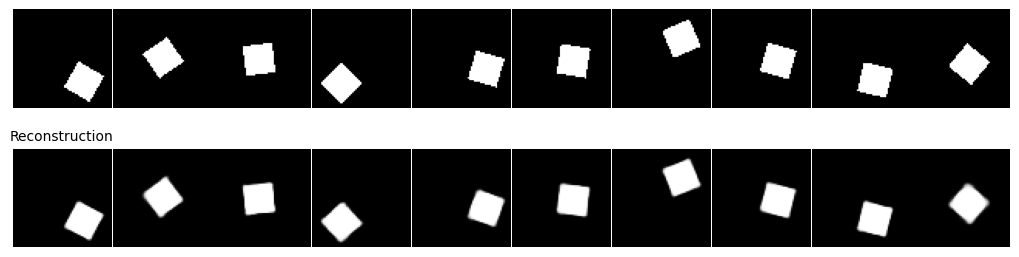

Plotting reconstructions from specific indices...


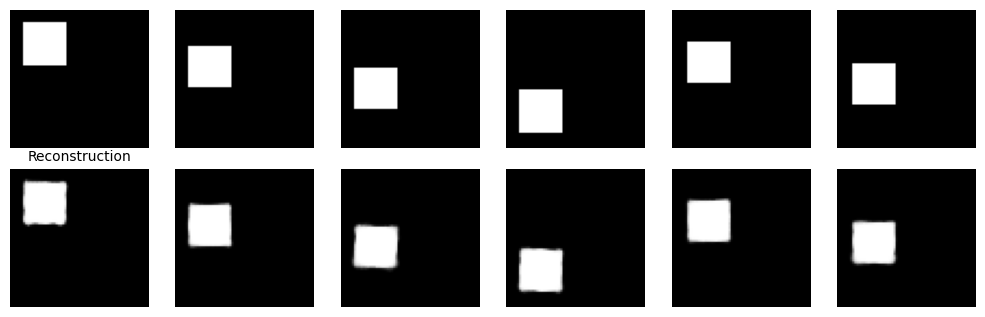

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


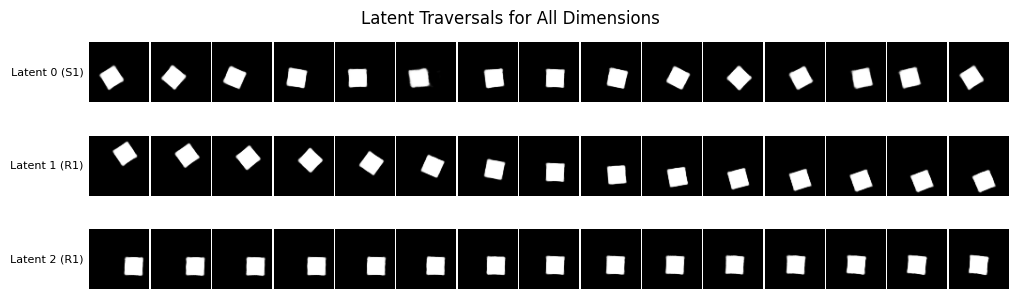

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

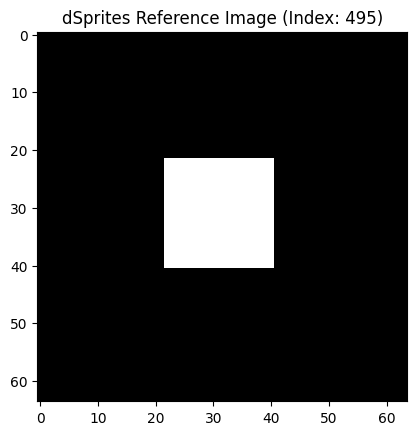

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


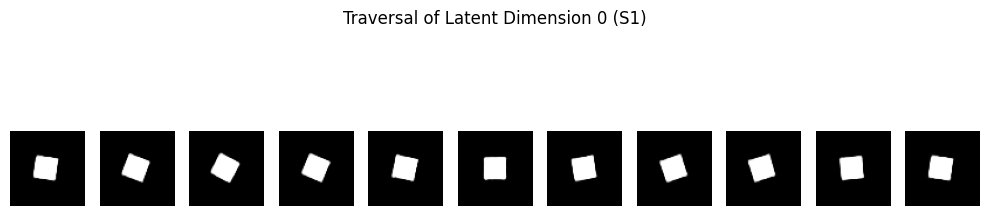

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


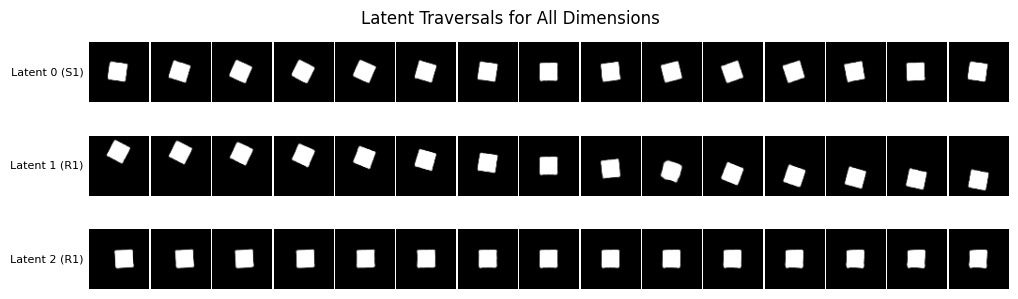

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )